# Dense Channel Aggregation and Reconstruction Network

In [1]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Select the GPU index
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import namedtuple
import scipy.io as sio
import math
import thop

from PIL import Image
from collections import OrderedDict
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
from scipy.io import savemat
import dill as pickle
from torch.optim.lr_scheduler import _LRScheduler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#Parameters
num_epochs=1000
patience=15
data_dir='../data/' 
scenario='out'
batch_size=200 
workers=5
reduction=8
expansion=50
seed=None
pin_memory=True
schedulertype = 'cosine'
weight_path=f'Experiments/table1/cr{reduction}/{expansion}x_{scenario}/epochs{num_epochs}/'
lr_init = 3e-3
val_freq=10
test_freq=10

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class PreFetcher:
    r""" Data pre-fetcher to accelerate the data loading
    """

    def __init__(self, loader):
        self.ori_loader = loader
        self.len = len(loader)
        self.stream = torch.cuda.Stream()
        self.next_input = None

    def preload(self):
        try:
            self.next_input = next(self.loader)
        except StopIteration:
            self.next_input = None
            return

        with torch.cuda.stream(self.stream):
            for idx, tensor in enumerate(self.next_input):
                self.next_input[idx] = tensor.cuda(non_blocking=True)

    def __len__(self):
        return self.len

    def __iter__(self):
        self.loader = iter(self.ori_loader)
        self.preload()
        return self

    def __next__(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        input = self.next_input
        if input is None:
            raise StopIteration
        for tensor in input:
            tensor.record_stream(torch.cuda.current_stream())
        self.preload()
        return input


In [5]:


class Cost2100DataLoader(object):
    r""" PyTorch DataLoader for COST2100 dataset.
    """

    def __init__(self, root, batch_size, num_workers, pin_memory, scenario):
        
        assert scenario in {"in", "out"}
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

        dir_train = os.path.join(root, f"DATA_Htrain{scenario}.mat")
        dir_val = os.path.join(root, f"DATA_Hval{scenario}.mat")
        dir_test = os.path.join(root, f"DATA_Htest{scenario}.mat")
        dir_raw = os.path.join(root, f"DATA_HtestF{scenario}_all.mat")
        channel, nt, nc, nc_expand = 2, 32, 32, 125

        # Training data loading
        data_train = sio.loadmat(dir_train)['HT']
        data_train = torch.tensor(data_train, dtype=torch.float32).view(
            data_train.shape[0], channel, nt, nc)
        self.train_dataset = TensorDataset(data_train)

        # Validation data loading
        data_val = sio.loadmat(dir_val)['HT']
        data_val = torch.tensor(data_val, dtype=torch.float32).view(
            data_val.shape[0], channel, nt, nc)
        self.val_dataset = TensorDataset(data_val)

        # Test data loading, including the sparse data and the raw data
        data_test = sio.loadmat(dir_test)['HT']
        data_test = torch.tensor(data_test, dtype=torch.float32).view(
            data_test.shape[0], channel, nt, nc)

        raw_test = sio.loadmat(dir_raw)['HF_all']
        real = torch.tensor(np.real(raw_test), dtype=torch.float32)
        imag = torch.tensor(np.imag(raw_test), dtype=torch.float32)
        raw_test = torch.cat((real.view(raw_test.shape[0], nt, nc_expand, 1),
                              imag.view(raw_test.shape[0], nt, nc_expand, 1)), dim=3)
        self.test_dataset = TensorDataset(data_test, raw_test)

    def __call__(self):
        train_loader = DataLoader(self.train_dataset,
                                  batch_size=self.batch_size,
                                  num_workers=self.num_workers,
                                  pin_memory=self.pin_memory,
                                  shuffle=True)
        val_loader = DataLoader(self.val_dataset,
                                batch_size=self.batch_size,
                                num_workers=self.num_workers,
                                pin_memory=self.pin_memory,
                                shuffle=False)
        test_loader = DataLoader(self.test_dataset,
                                 batch_size=self.batch_size,
                                 num_workers=self.num_workers,
                                 pin_memory=self.pin_memory,
                                 shuffle=False)

        # Accelerate CUDA data loading with pre-fetcher if GPU is used.
        if self.pin_memory is True:
            train_loader = PreFetcher(train_loader)
            val_loader = PreFetcher(val_loader)
            test_loader = PreFetcher(test_loader)

        return train_loader, val_loader, test_loader


In [6]:
# Create the data loader
train_loader, val_loader, test_loader = Cost2100DataLoader(
        root=data_dir,
        batch_size=batch_size,
        num_workers=workers,
        pin_memory=pin_memory,
        scenario=scenario)()

In [7]:
train_iter=iter(train_loader)

In [8]:
x=next(train_iter)

In [9]:
len(x)

1

In [10]:
x[0].shape

torch.Size([200, 2, 32, 32])

In [11]:
len(train_loader)

500

In [12]:
len(test_loader)

100

In [13]:
len(val_loader)

150

In [14]:
def cal_model_parameters(model):
    total_param  = []
    for p1 in model.parameters():
        total_param.append(int(p1.numel()))
    return sum(total_param)

In [15]:
def NMSE_cal(x_hat, x):
    x_real = torch.reshape(torch.real(x), (x.shape[0], -1))
    x_imag = torch.reshape(torch.imag(x), (x.shape[0], -1))
    x_hat_real = torch.reshape(torch.real(x_hat), (x.shape[0], -1))
    x_hat_imag = torch.reshape(torch.imag(x_hat), (x.shape[0], -1))
    power = torch.sum((x_real - 0.5) ** 2 + (x_imag - 0.5) ** 2, dim=1)
    mse = torch.sum((x_real - x_hat_real) ** 2 + (x_imag - x_hat_imag) ** 2, dim=1)
    nmse = torch.mean(mse / power)
    return nmse

In [16]:
class ConvBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        if not isinstance(kernel_size, int):
            padding = [(i - 1) // 2 for i in kernel_size]
        else:
            padding = (kernel_size - 1) // 2
        super(ConvBN, self).__init__(OrderedDict([
            ('conv', nn.Conv2d(in_channels=in_planes,
                               out_channels=out_planes,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               groups=groups,
                               bias=False)),
            ('bn', nn.BatchNorm2d(out_planes))
        ]))

In [17]:
class DCARNDecoderBlock(nn.Module):
  
    def __init__(self, expansion):
        super().__init__()
        width = 10 * expansion
        self.conv1 = ConvBN(2, width, [1, 11])
        self.prelu1 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv2 = ConvBN(2, width, [11, 1])
        self.prelu2 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv3 = ConvBN(2*width, 2, [1, 11])
        self.prelu3 = nn.PReLU(num_parameters=2, init=0.3)
        self.identity = nn.Identity()
    def forward(self, x):
        identity = self.identity(x)
        x1 = self.prelu1(self.conv1(x))

        x2 = self.prelu2(self.conv2(x))

        # Concat instead of add
        x3 = torch.cat([x1, x2], dim=1) 
        x3 = self.prelu3(self.conv3(x3)+identity)

        return x3

In [18]:
class DCARNEncoderBlock(nn.Module):
    def __init__(self):
        super(DCARNEncoderBlock, self).__init__()
        width = 2
        self.conv1 = ConvBN(2, width, [1, 11])
        self.prelu1 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv2 = ConvBN(2, width, [11, 1])
        self.prelu2 = nn.PReLU(num_parameters=width, init=0.3)
        self.conv3 = ConvBN(2*width, 2, [1, 11])
        self.prelu3 = nn.PReLU(num_parameters=2, init=0.3)
        self.identity = nn.Identity()
    def forward(self, x):
        identity = self.identity(x)
        x1 = self.prelu1(self.conv1(x))

        x2 = self.prelu2(self.conv2(x))

        # Concat instead of add
        x3 = torch.cat([x1, x2], dim=1) 
        x3 = self.prelu3(self.conv3(x3)+identity)
        return x3

In [19]:
class DCARN(nn.Module):
    def __init__(self,
                 in_channels=2,
                 reduction=4,
                 expansion=1):
        super(DCARN, self).__init__()
        
        total_size, w, h = 2048, 32, 32

        self.encoder_feature = nn.Sequential(OrderedDict([
            ("conv1x11_bn", ConvBN(in_channels, 2, [1, 11])),
            ("prelu", nn.PReLU(num_parameters=2, init=0.3)),
            ("DCARNEncoderBlock", DCARNEncoderBlock()),
            
        ]))
        
        self.encoder_fc = nn.Linear(total_size, total_size // reduction)

        self.decoder_fc = nn.Linear(total_size // reduction, total_size)
        
        self.decoder_feature = nn.Sequential(OrderedDict([
            ("conv1x11_bn", ConvBN(2, in_channels, [1, 11])),
            ("prelu", nn.PReLU(num_parameters=2, init=0.3)),
            ("DCARNDecoderBlock1", DCARNDecoderBlock(expansion=expansion)),
            ("DCARNDecoderBlock2", DCARNDecoderBlock(expansion=expansion)),
            ("sigmoid", nn.Sigmoid())
        ]))

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        n, c, h, w = x.detach().size()
        out = self.encoder_feature(x)
        out = self.encoder_fc(out.view(n, -1))
        out = self.decoder_fc(out)
        out = self.decoder_feature(out.view(n, c, h, w))
        return out

In [20]:
model = DCARN(in_channels=2, reduction=reduction, expansion=expansion).to(device)

In [21]:
if seed is not None:
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [22]:
cal_model_parameters(model)

1145186

In [23]:
# Define loss function
criterion = nn.MSELoss().to(device)

In [24]:
class WarmUpCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, T_warmup, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_warmup = T_warmup
        self.eta_min = eta_min
        super(WarmUpCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.T_warmup:
            return [base_lr * self.last_epoch / self.T_warmup for base_lr in self.base_lrs]
        else:
            k = 1 + math.cos(math.pi * (self.last_epoch - self.T_warmup) / (self.T_max - self.T_warmup))
            return [self.eta_min + (base_lr - self.eta_min) * k / 2 for base_lr in self.base_lrs]


class FakeLR(_LRScheduler):
    def __init__(self, optimizer):
        super(FakeLR, self).__init__(optimizer=optimizer)

    def get_lr(self):
        return self.base_lrs


In [25]:
# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr_init, betas=(0.9, 0.999))
if schedulertype == 'const':
    scheduler = FakeLR(optimizer=optimizer)

else:
    scheduler = WarmUpCosineAnnealingLR(optimizer=optimizer,
                                        T_max=num_epochs * len(train_loader),
                                        T_warmup=100 * len(train_loader),
                                        eta_min=5e-7)

In [26]:
field = ('nmse', 'rho', 'epoch')
Result = namedtuple('Result', field, defaults=(None,) * len(field))


In [27]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self, name):
        self.reset()
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.name = name

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __repr__(self):
        return f"==> For {self.name}: sum={self.sum}; avg={self.avg}"




In [28]:
def evaluator(sparse_pred, sparse_gt, raw_gt):
    r""" Evaluation of decoding implemented in PyTorch Tensor
         Computes normalized mean square error (NMSE) and rho.
    """

    with torch.no_grad():
        # Basic params
        nt = 32
        nc = 32
        nc_expand = 257

        # De-centralize
        sparse_gt = sparse_gt - 0.5
        sparse_pred = sparse_pred - 0.5

        # Calculate the NMSE
        power_gt = sparse_gt[:, 0, :, :] ** 2 + sparse_gt[:, 1, :, :] ** 2
        difference = sparse_gt - sparse_pred
        mse = difference[:, 0, :, :] ** 2 + difference[:, 1, :, :] ** 2
        nmse = (mse.sum(dim=[1, 2]) / power_gt.sum(dim=[1, 2])).mean()

        # Calculate the Rho
        n = sparse_pred.size(0)
        sparse_pred = sparse_pred.permute(0, 2, 3, 1)  # Move the real/imaginary dim to the last
        zeros = sparse_pred.new_zeros((n, nt, nc_expand - nc, 2))
        sparse_pred = torch.cat((sparse_pred, zeros), dim=2)
        raw_pred = torch.fft.fft(sparse_pred, dim=1)[:, :, :125, :]

        norm_pred = raw_pred[..., 0] ** 2 + raw_pred[..., 1] ** 2
        norm_pred = torch.sqrt(norm_pred.sum(dim=1))

        norm_gt = raw_gt[..., 0] ** 2 + raw_gt[..., 1] ** 2
        norm_gt = torch.sqrt(norm_gt.sum(dim=1))

        real_cross = raw_pred[..., 0] * raw_gt[..., 0] + raw_pred[..., 1] * raw_gt[..., 1]
        real_cross = real_cross.sum(dim=1)
        imag_cross = raw_pred[..., 0] * raw_gt[..., 1] - raw_pred[..., 1] * raw_gt[..., 0]
        imag_cross = imag_cross.sum(dim=1)
        norm_cross = torch.sqrt(real_cross ** 2 + imag_cross ** 2)

        rho = (norm_cross / (norm_pred * norm_gt)).mean()

        return rho, nmse


In [29]:
class Tester:
    r""" The testing interface for classification
    """

    def __init__(self, model, device, criterion, print_freq=20):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.print_freq = print_freq

    def __call__(self, test_data, verbose=True):
        r""" Runs the testing procedure.

        Args:
            test_data (DataLoader): Data loader for validation data.
        """

        self.model.eval()
        with torch.no_grad():
            loss, rho, nmse = self._iteration(test_data)
        if verbose:
            print(f'\n=> Test result: \nloss: {loss:.3e}'
                  f'    rho: {rho:.3e}    NMSE: {nmse:.3e}\n')
        return loss, rho, nmse

    def _iteration(self, data_loader):
        r""" protected function which test the model on given data loader for one epoch.
        """

        iter_rho = AverageMeter('Iter rho')
        iter_nmse = AverageMeter('Iter nmse')
        iter_loss = AverageMeter('Iter loss')
        iter_time = AverageMeter('Iter time')
        time_tmp = time.time()

        for batch_idx, (sparse_gt, raw_gt) in enumerate(data_loader):
            sparse_gt = sparse_gt.to(self.device)
            sparse_pred = self.model(sparse_gt)
            loss = self.criterion(sparse_pred, sparse_gt)
            rho, nmse = evaluator(sparse_pred, sparse_gt, raw_gt)

            # Log and visdom update
            iter_loss.update(loss)
            iter_rho.update(rho)
            iter_nmse.update(nmse)
            iter_time.update(time.time() - time_tmp)
            time_tmp = time.time()

            # plot progress
            if (batch_idx + 1) % self.print_freq == 0:
                print(f'[{batch_idx + 1}/{len(data_loader)}] '
                            f'loss: {iter_loss.avg:.3e} | rho: {iter_rho.avg:.3e} | '
                            f'NMSE: {10 * torch.log10(iter_nmse.avg):.3e} | time: {iter_time.avg:.3f}')
        
        nmse = 10 * torch.log10(iter_nmse.avg)  # global NMSE in dB
        print(f'=> Test rho:{iter_rho.avg:.3e}  NMSE: {nmse:.3e}\n')
        return iter_loss.avg, iter_rho.avg, nmse


In [30]:
val_losses = torch.empty(num_epochs//val_freq)
train_losses = torch.empty(num_epochs)
test_losses = torch.empty(num_epochs//test_freq)
alphas = torch.zeros(num_epochs)
test_nmses = torch.zeros(num_epochs//test_freq)

if not os.path.exists(weight_path + "losses/"):
    os.makedirs(weight_path + "losses/")

In [31]:
class Trainer:
    r""" The training pipeline for encoder-decoder architecture
    """

    def __init__(self, model, device, optimizer, criterion, scheduler, resume=None,
                 save_path=weight_path, print_freq=10, val_freq = val_freq, test_freq = test_freq):

        # Basic arguments
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.device = device

        # Verbose arguments
        self.resume_file = resume
        self.save_path = save_path
        self.print_freq = print_freq
        self.val_freq = val_freq
        self.test_freq = test_freq
        

        # Pipeline arguments
        self.cur_epoch = 1
        self.all_epoch = None
        self.train_loss = None
        self.val_loss = None
        self.test_loss = None
        self.best_rho = Result()
        self.best_nmse = Result()
        
        self.tester = Tester(model, device, criterion, print_freq)
        self.test_loader = None

    def loop(self, epochs, train_loader, val_loader, test_loader):
        r""" The main loop function which runs training and validation iteratively.

        Args:
            epochs (int): The total epoch for training
            train_loader (DataLoader): Data loader for training data.
            val_loader (DataLoader): Data loader for validation data.
            test_loader (DataLoader): Data loader for test data.
        """

        self.all_epoch = epochs
        self._resume()
        vn=0
        tn=0
        for ep in range(self.cur_epoch, epochs + 1):
            self.cur_epoch = ep

            # conduct training, validation and test
            self.train_loss = self.train(train_loader)
            train_losses[ep-1] = self.train_loss.detach()
            if ep % self.val_freq == 0:
                self.val_loss = self.val(val_loader)
                val_losses[vn] = self.val_loss.detach()
                vn=vn+1
            # Save alpha 
            alphas_ep = []
            for m in self.model.modules():
                if isinstance(m, nn.PReLU):
                    alphas_ep.append(m.weight[0])
            alphas[ep-1] = torch.stack(alphas_ep).mean().detach()
            
            if ep % self.test_freq == 0:
                self.test_loss, rho, nmse = self.test(test_loader)
                test_losses[tn] = self.test_loss.detach()
                test_nmses[tn] = nmse.detach()
                tn=tn+1
            else:
                rho, nmse = None, None
            # conduct saving, visualization and log printing
            self._loop_postprocessing(rho, nmse)

    def train(self, train_loader):
        r""" train the model on the given data loader for one epoch.

        Args:
            train_loader (DataLoader): the training data loader
        """

        self.model.train()
        with torch.enable_grad():
            return self._iteration(train_loader)

    def val(self, val_loader):
        r""" exam the model with validation set.

        Args:
            val_loader: (DataLoader): the validation data loader
        """

        self.model.eval()
        with torch.no_grad():
            return self._iteration(val_loader)

    def test(self, test_loader):
        r""" Truly test the model on the test dataset for one epoch.

        Args:
            test_loader (DataLoader): the test data loader
        """

        self.model.eval()
        with torch.no_grad():
            return self.tester(test_loader, verbose=False)

    def _iteration(self, data_loader):
        iter_loss = AverageMeter('Iter loss')
        iter_time = AverageMeter('Iter time')
        time_tmp = time.time()

        for batch_idx, (sparse_gt, ) in enumerate(data_loader):
            sparse_gt = sparse_gt.to(self.device)
            sparse_pred = self.model(sparse_gt)
            loss = self.criterion(sparse_pred, sparse_gt)

            # Scheduler update, backward pass and optimization
            if self.model.training:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

            # Log and visdom update
            iter_loss.update(loss)
            iter_time.update(time.time() - time_tmp)
            time_tmp = time.time()

            # plot progress
            if (batch_idx + 1) % self.print_freq == 0:
                print(f'Epoch: [{self.cur_epoch}/{self.all_epoch}]'
                            f'[{batch_idx + 1}/{len(data_loader)}] '
                            f'lr: {self.scheduler.get_lr()[0]:.2e} | '
                            f'MSE loss: {iter_loss.avg:.3e} | '
                            f'time: {iter_time.avg:.3f}')
                

        mode = 'Train' if self.model.training else 'Val'
        print(f' {mode}  Loss: {iter_loss.avg:.3e}\n')

        return iter_loss.avg

    def _save(self, state, name):
        if self.save_path is None:
            print('No path to save checkpoints.')
            return
        
        os.makedirs(self.save_path, exist_ok=True)
        torch.save(state, os.path.join(self.save_path, name))

    def _resume(self):
        r""" protected function which resume from checkpoint at the beginning of training.
        """

        if self.resume_file is None:
            return None
        assert os.path.isfile(self.resume_file)
        print(f' loading checkpoint {self.resume_file}')
        checkpoint = torch.load(self.resume_file)
        self.cur_epoch = checkpoint['epoch']
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        self.best_rho = checkpoint['best_rho']
        self.best_nmse = checkpoint['best_nmse']
        self.cur_epoch += 1  # start from the next epoch

        print(f' successfully loaded checkpoint {self.resume_file} '
                    f'from epoch {checkpoint["epoch"]}.\n')

    def _loop_postprocessing(self, rho, nmse):
        r""" private function which makes loop() function neater.
        """

        # save state generate
        state = {
            'epoch': self.cur_epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict(),
            'best_rho': self.best_rho,
            'best_nmse': self.best_nmse
        }

        # save model with best rho and nmse
        if rho is not None:
            if self.best_rho.rho is None or abs(self.best_rho.rho) < abs(rho):
                self.best_rho = Result(rho=rho, nmse=nmse, epoch=self.cur_epoch)
                state['best_rho'] = self.best_rho
                self._save(state, name=f"best_rho.pth")
            if self.best_nmse.nmse is None or self.best_nmse.nmse > nmse:
                self.best_nmse = Result(rho=rho, nmse=nmse, epoch=self.cur_epoch)
                state['best_nmse'] = self.best_nmse
                self._save(state, name=f"best_nmse.pth")

        self._save(state, name='last.pth')

        # print current best results
        if self.best_rho.rho is not None:
            print(f'\n=! Best rho: {self.best_rho.rho:.3e} ('
                  f'Corresponding nmse={self.best_rho.nmse:.3e}; '
                  f'epoch={self.best_rho.epoch})'
                  f'\n   Best NMSE: {self.best_nmse.nmse:.3e} ('
                  f'Corresponding rho={self.best_nmse.rho:.3e};  '
                  f'epoch={self.best_nmse.epoch})\n')
            

In [32]:
# Define the training pipeline
trainer = Trainer(model=model,
                  device=device,
                  optimizer=optimizer,
                  criterion=criterion,
                  scheduler=scheduler)

# Start training
trainer.loop(num_epochs, train_loader, val_loader, test_loader)

Epoch: [1/1000][10/500] lr: 6.00e-07 | MSE loss: 5.283e-02 | time: 0.272
Epoch: [1/1000][20/500] lr: 1.20e-06 | MSE loss: 5.259e-02 | time: 0.224
Epoch: [1/1000][30/500] lr: 1.80e-06 | MSE loss: 5.215e-02 | time: 0.208
Epoch: [1/1000][40/500] lr: 2.40e-06 | MSE loss: 5.155e-02 | time: 0.200
Epoch: [1/1000][50/500] lr: 3.00e-06 | MSE loss: 5.077e-02 | time: 0.195
Epoch: [1/1000][60/500] lr: 3.60e-06 | MSE loss: 4.983e-02 | time: 0.192
Epoch: [1/1000][70/500] lr: 4.20e-06 | MSE loss: 4.873e-02 | time: 0.190
Epoch: [1/1000][80/500] lr: 4.80e-06 | MSE loss: 4.750e-02 | time: 0.188
Epoch: [1/1000][90/500] lr: 5.40e-06 | MSE loss: 4.615e-02 | time: 0.187
Epoch: [1/1000][100/500] lr: 6.00e-06 | MSE loss: 4.474e-02 | time: 0.186
Epoch: [1/1000][110/500] lr: 6.60e-06 | MSE loss: 4.328e-02 | time: 0.185
Epoch: [1/1000][120/500] lr: 7.20e-06 | MSE loss: 4.182e-02 | time: 0.184
Epoch: [1/1000][130/500] lr: 7.80e-06 | MSE loss: 4.039e-02 | time: 0.183
Epoch: [1/1000][140/500] lr: 8.40e-06 | MSE los

Epoch: [3/1000][120/500] lr: 6.72e-05 | MSE loss: 1.258e-03 | time: 0.142
Epoch: [3/1000][130/500] lr: 6.78e-05 | MSE loss: 1.258e-03 | time: 0.142
Epoch: [3/1000][140/500] lr: 6.84e-05 | MSE loss: 1.258e-03 | time: 0.142
Epoch: [3/1000][150/500] lr: 6.90e-05 | MSE loss: 1.256e-03 | time: 0.142
Epoch: [3/1000][160/500] lr: 6.96e-05 | MSE loss: 1.255e-03 | time: 0.142
Epoch: [3/1000][170/500] lr: 7.02e-05 | MSE loss: 1.254e-03 | time: 0.143
Epoch: [3/1000][180/500] lr: 7.08e-05 | MSE loss: 1.253e-03 | time: 0.143
Epoch: [3/1000][190/500] lr: 7.14e-05 | MSE loss: 1.252e-03 | time: 0.143
Epoch: [3/1000][200/500] lr: 7.20e-05 | MSE loss: 1.252e-03 | time: 0.143
Epoch: [3/1000][210/500] lr: 7.26e-05 | MSE loss: 1.251e-03 | time: 0.143
Epoch: [3/1000][220/500] lr: 7.32e-05 | MSE loss: 1.250e-03 | time: 0.143
Epoch: [3/1000][230/500] lr: 7.38e-05 | MSE loss: 1.249e-03 | time: 0.143
Epoch: [3/1000][240/500] lr: 7.44e-05 | MSE loss: 1.248e-03 | time: 0.143
Epoch: [3/1000][250/500] lr: 7.50e-05 

Epoch: [5/1000][230/500] lr: 1.34e-04 | MSE loss: 1.168e-03 | time: 0.143
Epoch: [5/1000][240/500] lr: 1.34e-04 | MSE loss: 1.164e-03 | time: 0.144
Epoch: [5/1000][250/500] lr: 1.35e-04 | MSE loss: 1.160e-03 | time: 0.144
Epoch: [5/1000][260/500] lr: 1.36e-04 | MSE loss: 1.155e-03 | time: 0.144
Epoch: [5/1000][270/500] lr: 1.36e-04 | MSE loss: 1.151e-03 | time: 0.144
Epoch: [5/1000][280/500] lr: 1.37e-04 | MSE loss: 1.147e-03 | time: 0.144
Epoch: [5/1000][290/500] lr: 1.37e-04 | MSE loss: 1.144e-03 | time: 0.144
Epoch: [5/1000][300/500] lr: 1.38e-04 | MSE loss: 1.140e-03 | time: 0.144
Epoch: [5/1000][310/500] lr: 1.39e-04 | MSE loss: 1.137e-03 | time: 0.144
Epoch: [5/1000][320/500] lr: 1.39e-04 | MSE loss: 1.134e-03 | time: 0.144
Epoch: [5/1000][330/500] lr: 1.40e-04 | MSE loss: 1.132e-03 | time: 0.144
Epoch: [5/1000][340/500] lr: 1.40e-04 | MSE loss: 1.129e-03 | time: 0.144
Epoch: [5/1000][350/500] lr: 1.41e-04 | MSE loss: 1.127e-03 | time: 0.144
Epoch: [5/1000][360/500] lr: 1.42e-04 

Epoch: [7/1000][340/500] lr: 2.00e-04 | MSE loss: 1.043e-03 | time: 0.144
Epoch: [7/1000][350/500] lr: 2.01e-04 | MSE loss: 1.043e-03 | time: 0.144
Epoch: [7/1000][360/500] lr: 2.02e-04 | MSE loss: 1.043e-03 | time: 0.144
Epoch: [7/1000][370/500] lr: 2.02e-04 | MSE loss: 1.043e-03 | time: 0.144
Epoch: [7/1000][380/500] lr: 2.03e-04 | MSE loss: 1.042e-03 | time: 0.144
Epoch: [7/1000][390/500] lr: 2.03e-04 | MSE loss: 1.042e-03 | time: 0.144
Epoch: [7/1000][400/500] lr: 2.04e-04 | MSE loss: 1.043e-03 | time: 0.144
Epoch: [7/1000][410/500] lr: 2.05e-04 | MSE loss: 1.042e-03 | time: 0.144
Epoch: [7/1000][420/500] lr: 2.05e-04 | MSE loss: 1.042e-03 | time: 0.144
Epoch: [7/1000][430/500] lr: 2.06e-04 | MSE loss: 1.043e-03 | time: 0.144
Epoch: [7/1000][440/500] lr: 2.06e-04 | MSE loss: 1.042e-03 | time: 0.144
Epoch: [7/1000][450/500] lr: 2.07e-04 | MSE loss: 1.042e-03 | time: 0.144
Epoch: [7/1000][460/500] lr: 2.08e-04 | MSE loss: 1.042e-03 | time: 0.144
Epoch: [7/1000][470/500] lr: 2.08e-04 

Epoch: [9/1000][450/500] lr: 2.67e-04 | MSE loss: 9.923e-04 | time: 0.144
Epoch: [9/1000][460/500] lr: 2.68e-04 | MSE loss: 9.920e-04 | time: 0.144
Epoch: [9/1000][470/500] lr: 2.68e-04 | MSE loss: 9.916e-04 | time: 0.144
Epoch: [9/1000][480/500] lr: 2.69e-04 | MSE loss: 9.910e-04 | time: 0.144
Epoch: [9/1000][490/500] lr: 2.69e-04 | MSE loss: 9.907e-04 | time: 0.144
Epoch: [9/1000][500/500] lr: 2.70e-04 | MSE loss: 9.902e-04 | time: 0.144
 Train  Loss: 9.902e-04

Epoch: [10/1000][10/500] lr: 2.71e-04 | MSE loss: 9.583e-04 | time: 0.109
Epoch: [10/1000][20/500] lr: 2.71e-04 | MSE loss: 9.528e-04 | time: 0.127
Epoch: [10/1000][30/500] lr: 2.72e-04 | MSE loss: 9.528e-04 | time: 0.133
Epoch: [10/1000][40/500] lr: 2.72e-04 | MSE loss: 9.546e-04 | time: 0.136
Epoch: [10/1000][50/500] lr: 2.73e-04 | MSE loss: 9.527e-04 | time: 0.137
Epoch: [10/1000][60/500] lr: 2.74e-04 | MSE loss: 9.529e-04 | time: 0.139
Epoch: [10/1000][70/500] lr: 2.74e-04 | MSE loss: 9.557e-04 | time: 0.139
Epoch: [10/10

Epoch: [11/1000][270/500] lr: 3.16e-04 | MSE loss: 8.439e-04 | time: 0.143
Epoch: [11/1000][280/500] lr: 3.17e-04 | MSE loss: 8.423e-04 | time: 0.143
Epoch: [11/1000][290/500] lr: 3.17e-04 | MSE loss: 8.409e-04 | time: 0.143
Epoch: [11/1000][300/500] lr: 3.18e-04 | MSE loss: 8.395e-04 | time: 0.143
Epoch: [11/1000][310/500] lr: 3.19e-04 | MSE loss: 8.384e-04 | time: 0.143
Epoch: [11/1000][320/500] lr: 3.19e-04 | MSE loss: 8.377e-04 | time: 0.143
Epoch: [11/1000][330/500] lr: 3.20e-04 | MSE loss: 8.378e-04 | time: 0.143
Epoch: [11/1000][340/500] lr: 3.20e-04 | MSE loss: 8.374e-04 | time: 0.143
Epoch: [11/1000][350/500] lr: 3.21e-04 | MSE loss: 8.364e-04 | time: 0.144
Epoch: [11/1000][360/500] lr: 3.22e-04 | MSE loss: 8.349e-04 | time: 0.144
Epoch: [11/1000][370/500] lr: 3.22e-04 | MSE loss: 8.336e-04 | time: 0.144
Epoch: [11/1000][380/500] lr: 3.23e-04 | MSE loss: 8.326e-04 | time: 0.144
Epoch: [11/1000][390/500] lr: 3.23e-04 | MSE loss: 8.312e-04 | time: 0.144
Epoch: [11/1000][400/500]

Epoch: [13/1000][330/500] lr: 3.80e-04 | MSE loss: 6.158e-04 | time: 0.144
Epoch: [13/1000][340/500] lr: 3.80e-04 | MSE loss: 6.124e-04 | time: 0.144
Epoch: [13/1000][350/500] lr: 3.81e-04 | MSE loss: 6.086e-04 | time: 0.144
Epoch: [13/1000][360/500] lr: 3.82e-04 | MSE loss: 6.050e-04 | time: 0.144
Epoch: [13/1000][370/500] lr: 3.82e-04 | MSE loss: 6.015e-04 | time: 0.144
Epoch: [13/1000][380/500] lr: 3.83e-04 | MSE loss: 5.983e-04 | time: 0.144
Epoch: [13/1000][390/500] lr: 3.83e-04 | MSE loss: 5.955e-04 | time: 0.144
Epoch: [13/1000][400/500] lr: 3.84e-04 | MSE loss: 5.925e-04 | time: 0.144
Epoch: [13/1000][410/500] lr: 3.85e-04 | MSE loss: 5.898e-04 | time: 0.144
Epoch: [13/1000][420/500] lr: 3.85e-04 | MSE loss: 5.874e-04 | time: 0.144
Epoch: [13/1000][430/500] lr: 3.86e-04 | MSE loss: 5.853e-04 | time: 0.144
Epoch: [13/1000][440/500] lr: 3.86e-04 | MSE loss: 5.830e-04 | time: 0.144
Epoch: [13/1000][450/500] lr: 3.87e-04 | MSE loss: 5.809e-04 | time: 0.144
Epoch: [13/1000][460/500]

Epoch: [15/1000][390/500] lr: 4.43e-04 | MSE loss: 4.101e-04 | time: 0.144
Epoch: [15/1000][400/500] lr: 4.44e-04 | MSE loss: 4.098e-04 | time: 0.144
Epoch: [15/1000][410/500] lr: 4.45e-04 | MSE loss: 4.093e-04 | time: 0.144
Epoch: [15/1000][420/500] lr: 4.45e-04 | MSE loss: 4.089e-04 | time: 0.144
Epoch: [15/1000][430/500] lr: 4.46e-04 | MSE loss: 4.085e-04 | time: 0.144
Epoch: [15/1000][440/500] lr: 4.46e-04 | MSE loss: 4.081e-04 | time: 0.144
Epoch: [15/1000][450/500] lr: 4.47e-04 | MSE loss: 4.077e-04 | time: 0.144
Epoch: [15/1000][460/500] lr: 4.48e-04 | MSE loss: 4.076e-04 | time: 0.144
Epoch: [15/1000][470/500] lr: 4.48e-04 | MSE loss: 4.077e-04 | time: 0.144
Epoch: [15/1000][480/500] lr: 4.49e-04 | MSE loss: 4.076e-04 | time: 0.144
Epoch: [15/1000][490/500] lr: 4.49e-04 | MSE loss: 4.074e-04 | time: 0.144
Epoch: [15/1000][500/500] lr: 4.50e-04 | MSE loss: 4.071e-04 | time: 0.144
 Train  Loss: 4.071e-04


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMS

Epoch: [17/1000][450/500] lr: 5.07e-04 | MSE loss: 3.677e-04 | time: 0.144
Epoch: [17/1000][460/500] lr: 5.08e-04 | MSE loss: 3.678e-04 | time: 0.144
Epoch: [17/1000][470/500] lr: 5.08e-04 | MSE loss: 3.679e-04 | time: 0.144
Epoch: [17/1000][480/500] lr: 5.09e-04 | MSE loss: 3.684e-04 | time: 0.144
Epoch: [17/1000][490/500] lr: 5.09e-04 | MSE loss: 3.683e-04 | time: 0.144
Epoch: [17/1000][500/500] lr: 5.10e-04 | MSE loss: 3.683e-04 | time: 0.144
 Train  Loss: 3.683e-04


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: 7.444e-01 (Corresponding rho=nan+nanj;  epoch=10)

Epoch: [18/1000][10/500] lr: 5.11e-04 | MSE loss: 3.541e-04 | time: 0.110
Epoch: [18/1000][20/500] lr: 5.11e-04 | MSE loss: 3.553e-04 | time: 0.127
Epoch: [18/1000][30/500] lr: 5.12e-04 | MSE loss: 3.543e-04 | time: 0.133
Epoch: [18/1000][40/500] lr: 5.12e-04 | MSE loss: 3.535e-04 | time: 0.136
Epoch: [18/1000][50/500] lr: 5.13e-04 | MSE loss: 3.541e-04 | time: 0.138
Epoch: [18/1000][60/500] l

Epoch: [20/1000][10/500] lr: 5.71e-04 | MSE loss: 3.417e-04 | time: 0.110
Epoch: [20/1000][20/500] lr: 5.71e-04 | MSE loss: 3.440e-04 | time: 0.127
Epoch: [20/1000][30/500] lr: 5.72e-04 | MSE loss: 3.402e-04 | time: 0.133
Epoch: [20/1000][40/500] lr: 5.72e-04 | MSE loss: 3.403e-04 | time: 0.136
Epoch: [20/1000][50/500] lr: 5.73e-04 | MSE loss: 3.395e-04 | time: 0.138
Epoch: [20/1000][60/500] lr: 5.74e-04 | MSE loss: 3.391e-04 | time: 0.139
Epoch: [20/1000][70/500] lr: 5.74e-04 | MSE loss: 3.396e-04 | time: 0.140
Epoch: [20/1000][80/500] lr: 5.75e-04 | MSE loss: 3.380e-04 | time: 0.140
Epoch: [20/1000][90/500] lr: 5.75e-04 | MSE loss: 3.380e-04 | time: 0.141
Epoch: [20/1000][100/500] lr: 5.76e-04 | MSE loss: 3.388e-04 | time: 0.141
Epoch: [20/1000][110/500] lr: 5.77e-04 | MSE loss: 3.385e-04 | time: 0.141
Epoch: [20/1000][120/500] lr: 5.77e-04 | MSE loss: 3.387e-04 | time: 0.142
Epoch: [20/1000][130/500] lr: 5.78e-04 | MSE loss: 3.389e-04 | time: 0.142
Epoch: [20/1000][140/500] lr: 5.78

Epoch: [21/1000][330/500] lr: 6.20e-04 | MSE loss: 3.262e-04 | time: 0.143
Epoch: [21/1000][340/500] lr: 6.20e-04 | MSE loss: 3.261e-04 | time: 0.144
Epoch: [21/1000][350/500] lr: 6.21e-04 | MSE loss: 3.262e-04 | time: 0.144
Epoch: [21/1000][360/500] lr: 6.22e-04 | MSE loss: 3.261e-04 | time: 0.144
Epoch: [21/1000][370/500] lr: 6.22e-04 | MSE loss: 3.261e-04 | time: 0.144
Epoch: [21/1000][380/500] lr: 6.23e-04 | MSE loss: 3.261e-04 | time: 0.144
Epoch: [21/1000][390/500] lr: 6.23e-04 | MSE loss: 3.259e-04 | time: 0.144
Epoch: [21/1000][400/500] lr: 6.24e-04 | MSE loss: 3.258e-04 | time: 0.144
Epoch: [21/1000][410/500] lr: 6.25e-04 | MSE loss: 3.257e-04 | time: 0.144
Epoch: [21/1000][420/500] lr: 6.25e-04 | MSE loss: 3.258e-04 | time: 0.144
Epoch: [21/1000][430/500] lr: 6.26e-04 | MSE loss: 3.259e-04 | time: 0.144
Epoch: [21/1000][440/500] lr: 6.26e-04 | MSE loss: 3.259e-04 | time: 0.144
Epoch: [21/1000][450/500] lr: 6.27e-04 | MSE loss: 3.258e-04 | time: 0.144
Epoch: [21/1000][460/500]

Epoch: [23/1000][390/500] lr: 6.83e-04 | MSE loss: 1.960e-04 | time: 0.144
Epoch: [23/1000][400/500] lr: 6.84e-04 | MSE loss: 1.959e-04 | time: 0.144
Epoch: [23/1000][410/500] lr: 6.85e-04 | MSE loss: 1.958e-04 | time: 0.144
Epoch: [23/1000][420/500] lr: 6.85e-04 | MSE loss: 1.958e-04 | time: 0.144
Epoch: [23/1000][430/500] lr: 6.86e-04 | MSE loss: 1.958e-04 | time: 0.144
Epoch: [23/1000][440/500] lr: 6.86e-04 | MSE loss: 1.956e-04 | time: 0.144
Epoch: [23/1000][450/500] lr: 6.87e-04 | MSE loss: 1.953e-04 | time: 0.144
Epoch: [23/1000][460/500] lr: 6.88e-04 | MSE loss: 1.952e-04 | time: 0.144
Epoch: [23/1000][470/500] lr: 6.88e-04 | MSE loss: 1.950e-04 | time: 0.144
Epoch: [23/1000][480/500] lr: 6.89e-04 | MSE loss: 1.948e-04 | time: 0.144
Epoch: [23/1000][490/500] lr: 6.89e-04 | MSE loss: 1.947e-04 | time: 0.144
Epoch: [23/1000][500/500] lr: 6.90e-04 | MSE loss: 1.944e-04 | time: 0.144
 Train  Loss: 1.944e-04


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMS

Epoch: [25/1000][450/500] lr: 7.47e-04 | MSE loss: 1.792e-04 | time: 0.144
Epoch: [25/1000][460/500] lr: 7.48e-04 | MSE loss: 1.791e-04 | time: 0.144
Epoch: [25/1000][470/500] lr: 7.48e-04 | MSE loss: 1.791e-04 | time: 0.144
Epoch: [25/1000][480/500] lr: 7.49e-04 | MSE loss: 1.789e-04 | time: 0.144
Epoch: [25/1000][490/500] lr: 7.49e-04 | MSE loss: 1.788e-04 | time: 0.144
Epoch: [25/1000][500/500] lr: 7.50e-04 | MSE loss: 1.787e-04 | time: 0.144
 Train  Loss: 1.787e-04


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -3.537e+00 (Corresponding rho=nan+nanj;  epoch=20)

Epoch: [26/1000][10/500] lr: 7.51e-04 | MSE loss: 1.699e-04 | time: 0.110
Epoch: [26/1000][20/500] lr: 7.51e-04 | MSE loss: 1.689e-04 | time: 0.127
Epoch: [26/1000][30/500] lr: 7.52e-04 | MSE loss: 1.692e-04 | time: 0.133
Epoch: [26/1000][40/500] lr: 7.52e-04 | MSE loss: 1.697e-04 | time: 0.136
Epoch: [26/1000][50/500] lr: 7.53e-04 | MSE loss: 1.707e-04 | time: 0.138
Epoch: [26/1000][60/500] 

Epoch: [28/1000][10/500] lr: 8.11e-04 | MSE loss: 1.670e-04 | time: 0.112
Epoch: [28/1000][20/500] lr: 8.11e-04 | MSE loss: 1.695e-04 | time: 0.128
Epoch: [28/1000][30/500] lr: 8.12e-04 | MSE loss: 1.708e-04 | time: 0.134
Epoch: [28/1000][40/500] lr: 8.12e-04 | MSE loss: 1.703e-04 | time: 0.136
Epoch: [28/1000][50/500] lr: 8.13e-04 | MSE loss: 1.700e-04 | time: 0.138
Epoch: [28/1000][60/500] lr: 8.14e-04 | MSE loss: 1.686e-04 | time: 0.139
Epoch: [28/1000][70/500] lr: 8.14e-04 | MSE loss: 1.677e-04 | time: 0.140
Epoch: [28/1000][80/500] lr: 8.15e-04 | MSE loss: 1.673e-04 | time: 0.141
Epoch: [28/1000][90/500] lr: 8.15e-04 | MSE loss: 1.678e-04 | time: 0.141
Epoch: [28/1000][100/500] lr: 8.16e-04 | MSE loss: 1.680e-04 | time: 0.141
Epoch: [28/1000][110/500] lr: 8.17e-04 | MSE loss: 1.679e-04 | time: 0.142
Epoch: [28/1000][120/500] lr: 8.17e-04 | MSE loss: 1.672e-04 | time: 0.142
Epoch: [28/1000][130/500] lr: 8.18e-04 | MSE loss: 1.675e-04 | time: 0.142
Epoch: [28/1000][140/500] lr: 8.18

Epoch: [30/1000][70/500] lr: 8.74e-04 | MSE loss: 1.544e-04 | time: 0.140
Epoch: [30/1000][80/500] lr: 8.75e-04 | MSE loss: 1.541e-04 | time: 0.140
Epoch: [30/1000][90/500] lr: 8.75e-04 | MSE loss: 1.544e-04 | time: 0.141
Epoch: [30/1000][100/500] lr: 8.76e-04 | MSE loss: 1.556e-04 | time: 0.141
Epoch: [30/1000][110/500] lr: 8.77e-04 | MSE loss: 1.558e-04 | time: 0.141
Epoch: [30/1000][120/500] lr: 8.77e-04 | MSE loss: 1.557e-04 | time: 0.142
Epoch: [30/1000][130/500] lr: 8.78e-04 | MSE loss: 1.558e-04 | time: 0.142
Epoch: [30/1000][140/500] lr: 8.78e-04 | MSE loss: 1.554e-04 | time: 0.142
Epoch: [30/1000][150/500] lr: 8.79e-04 | MSE loss: 1.552e-04 | time: 0.142
Epoch: [30/1000][160/500] lr: 8.80e-04 | MSE loss: 1.550e-04 | time: 0.142
Epoch: [30/1000][170/500] lr: 8.80e-04 | MSE loss: 1.554e-04 | time: 0.143
Epoch: [30/1000][180/500] lr: 8.81e-04 | MSE loss: 1.557e-04 | time: 0.143
Epoch: [30/1000][190/500] lr: 8.81e-04 | MSE loss: 1.556e-04 | time: 0.143
Epoch: [30/1000][200/500] lr

Epoch: [31/1000][390/500] lr: 9.23e-04 | MSE loss: 1.533e-04 | time: 0.144
Epoch: [31/1000][400/500] lr: 9.24e-04 | MSE loss: 1.533e-04 | time: 0.144
Epoch: [31/1000][410/500] lr: 9.25e-04 | MSE loss: 1.533e-04 | time: 0.144
Epoch: [31/1000][420/500] lr: 9.25e-04 | MSE loss: 1.532e-04 | time: 0.144
Epoch: [31/1000][430/500] lr: 9.26e-04 | MSE loss: 1.532e-04 | time: 0.144
Epoch: [31/1000][440/500] lr: 9.26e-04 | MSE loss: 1.533e-04 | time: 0.144
Epoch: [31/1000][450/500] lr: 9.27e-04 | MSE loss: 1.532e-04 | time: 0.144
Epoch: [31/1000][460/500] lr: 9.28e-04 | MSE loss: 1.532e-04 | time: 0.144
Epoch: [31/1000][470/500] lr: 9.28e-04 | MSE loss: 1.532e-04 | time: 0.144
Epoch: [31/1000][480/500] lr: 9.29e-04 | MSE loss: 1.531e-04 | time: 0.144
Epoch: [31/1000][490/500] lr: 9.29e-04 | MSE loss: 1.531e-04 | time: 0.144
Epoch: [31/1000][500/500] lr: 9.30e-04 | MSE loss: 1.531e-04 | time: 0.144
 Train  Loss: 1.531e-04


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMS

Epoch: [33/1000][450/500] lr: 9.87e-04 | MSE loss: 1.474e-04 | time: 0.144
Epoch: [33/1000][460/500] lr: 9.88e-04 | MSE loss: 1.474e-04 | time: 0.144
Epoch: [33/1000][470/500] lr: 9.88e-04 | MSE loss: 1.474e-04 | time: 0.144
Epoch: [33/1000][480/500] lr: 9.89e-04 | MSE loss: 1.472e-04 | time: 0.144
Epoch: [33/1000][490/500] lr: 9.89e-04 | MSE loss: 1.472e-04 | time: 0.144
Epoch: [33/1000][500/500] lr: 9.90e-04 | MSE loss: 1.472e-04 | time: 0.144
 Train  Loss: 1.472e-04


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -7.393e+00 (Corresponding rho=nan+nanj;  epoch=30)

Epoch: [34/1000][10/500] lr: 9.91e-04 | MSE loss: 1.520e-04 | time: 0.110
Epoch: [34/1000][20/500] lr: 9.91e-04 | MSE loss: 1.503e-04 | time: 0.127
Epoch: [34/1000][30/500] lr: 9.92e-04 | MSE loss: 1.483e-04 | time: 0.133
Epoch: [34/1000][40/500] lr: 9.92e-04 | MSE loss: 1.470e-04 | time: 0.136
Epoch: [34/1000][50/500] lr: 9.93e-04 | MSE loss: 1.460e-04 | time: 0.138
Epoch: [34/1000][60/500] 

Epoch: [36/1000][10/500] lr: 1.05e-03 | MSE loss: 1.475e-04 | time: 0.111
Epoch: [36/1000][20/500] lr: 1.05e-03 | MSE loss: 1.435e-04 | time: 0.128
Epoch: [36/1000][30/500] lr: 1.05e-03 | MSE loss: 1.412e-04 | time: 0.133
Epoch: [36/1000][40/500] lr: 1.05e-03 | MSE loss: 1.397e-04 | time: 0.136
Epoch: [36/1000][50/500] lr: 1.05e-03 | MSE loss: 1.395e-04 | time: 0.138
Epoch: [36/1000][60/500] lr: 1.05e-03 | MSE loss: 1.386e-04 | time: 0.139
Epoch: [36/1000][70/500] lr: 1.05e-03 | MSE loss: 1.381e-04 | time: 0.140
Epoch: [36/1000][80/500] lr: 1.05e-03 | MSE loss: 1.380e-04 | time: 0.140
Epoch: [36/1000][90/500] lr: 1.06e-03 | MSE loss: 1.380e-04 | time: 0.141
Epoch: [36/1000][100/500] lr: 1.06e-03 | MSE loss: 1.379e-04 | time: 0.141
Epoch: [36/1000][110/500] lr: 1.06e-03 | MSE loss: 1.389e-04 | time: 0.142
Epoch: [36/1000][120/500] lr: 1.06e-03 | MSE loss: 1.392e-04 | time: 0.142
Epoch: [36/1000][130/500] lr: 1.06e-03 | MSE loss: 1.391e-04 | time: 0.142
Epoch: [36/1000][140/500] lr: 1.06

Epoch: [38/1000][70/500] lr: 1.11e-03 | MSE loss: 1.356e-04 | time: 0.140
Epoch: [38/1000][80/500] lr: 1.11e-03 | MSE loss: 1.355e-04 | time: 0.140
Epoch: [38/1000][90/500] lr: 1.12e-03 | MSE loss: 1.358e-04 | time: 0.141
Epoch: [38/1000][100/500] lr: 1.12e-03 | MSE loss: 1.356e-04 | time: 0.141
Epoch: [38/1000][110/500] lr: 1.12e-03 | MSE loss: 1.357e-04 | time: 0.141
Epoch: [38/1000][120/500] lr: 1.12e-03 | MSE loss: 1.357e-04 | time: 0.142
Epoch: [38/1000][130/500] lr: 1.12e-03 | MSE loss: 1.359e-04 | time: 0.142
Epoch: [38/1000][140/500] lr: 1.12e-03 | MSE loss: 1.359e-04 | time: 0.142
Epoch: [38/1000][150/500] lr: 1.12e-03 | MSE loss: 1.358e-04 | time: 0.142
Epoch: [38/1000][160/500] lr: 1.12e-03 | MSE loss: 1.359e-04 | time: 0.142
Epoch: [38/1000][170/500] lr: 1.12e-03 | MSE loss: 1.357e-04 | time: 0.143
Epoch: [38/1000][180/500] lr: 1.12e-03 | MSE loss: 1.354e-04 | time: 0.143
Epoch: [38/1000][190/500] lr: 1.12e-03 | MSE loss: 1.352e-04 | time: 0.143
Epoch: [38/1000][200/500] lr

Epoch: [40/1000][130/500] lr: 1.18e-03 | MSE loss: 1.329e-04 | time: 0.142
Epoch: [40/1000][140/500] lr: 1.18e-03 | MSE loss: 1.329e-04 | time: 0.142
Epoch: [40/1000][150/500] lr: 1.18e-03 | MSE loss: 1.331e-04 | time: 0.142
Epoch: [40/1000][160/500] lr: 1.18e-03 | MSE loss: 1.331e-04 | time: 0.142
Epoch: [40/1000][170/500] lr: 1.18e-03 | MSE loss: 1.330e-04 | time: 0.143
Epoch: [40/1000][180/500] lr: 1.18e-03 | MSE loss: 1.331e-04 | time: 0.143
Epoch: [40/1000][190/500] lr: 1.18e-03 | MSE loss: 1.331e-04 | time: 0.143
Epoch: [40/1000][200/500] lr: 1.18e-03 | MSE loss: 1.328e-04 | time: 0.143
Epoch: [40/1000][210/500] lr: 1.18e-03 | MSE loss: 1.329e-04 | time: 0.143
Epoch: [40/1000][220/500] lr: 1.18e-03 | MSE loss: 1.330e-04 | time: 0.143
Epoch: [40/1000][230/500] lr: 1.18e-03 | MSE loss: 1.330e-04 | time: 0.143
Epoch: [40/1000][240/500] lr: 1.18e-03 | MSE loss: 1.329e-04 | time: 0.143
Epoch: [40/1000][250/500] lr: 1.19e-03 | MSE loss: 1.329e-04 | time: 0.143
Epoch: [40/1000][260/500]

Epoch: [41/1000][450/500] lr: 1.23e-03 | MSE loss: 1.307e-04 | time: 0.144
Epoch: [41/1000][460/500] lr: 1.23e-03 | MSE loss: 1.307e-04 | time: 0.144
Epoch: [41/1000][470/500] lr: 1.23e-03 | MSE loss: 1.307e-04 | time: 0.144
Epoch: [41/1000][480/500] lr: 1.23e-03 | MSE loss: 1.307e-04 | time: 0.144
Epoch: [41/1000][490/500] lr: 1.23e-03 | MSE loss: 1.307e-04 | time: 0.144
Epoch: [41/1000][500/500] lr: 1.23e-03 | MSE loss: 1.307e-04 | time: 0.144
 Train  Loss: 1.307e-04


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -7.880e+00 (Corresponding rho=nan+nanj;  epoch=40)

Epoch: [42/1000][10/500] lr: 1.23e-03 | MSE loss: 1.242e-04 | time: 0.110
Epoch: [42/1000][20/500] lr: 1.23e-03 | MSE loss: 1.264e-04 | time: 0.127
Epoch: [42/1000][30/500] lr: 1.23e-03 | MSE loss: 1.253e-04 | time: 0.133
Epoch: [42/1000][40/500] lr: 1.23e-03 | MSE loss: 1.252e-04 | time: 0.136
Epoch: [42/1000][50/500] lr: 1.23e-03 | MSE loss: 1.255e-04 | time: 0.138
Epoch: [42/1000][60/500] 

Epoch: [44/1000][10/500] lr: 1.29e-03 | MSE loss: 1.238e-04 | time: 0.110
Epoch: [44/1000][20/500] lr: 1.29e-03 | MSE loss: 1.254e-04 | time: 0.127
Epoch: [44/1000][30/500] lr: 1.29e-03 | MSE loss: 1.242e-04 | time: 0.133
Epoch: [44/1000][40/500] lr: 1.29e-03 | MSE loss: 1.250e-04 | time: 0.136
Epoch: [44/1000][50/500] lr: 1.29e-03 | MSE loss: 1.255e-04 | time: 0.138
Epoch: [44/1000][60/500] lr: 1.29e-03 | MSE loss: 1.255e-04 | time: 0.139
Epoch: [44/1000][70/500] lr: 1.29e-03 | MSE loss: 1.254e-04 | time: 0.140
Epoch: [44/1000][80/500] lr: 1.29e-03 | MSE loss: 1.253e-04 | time: 0.140
Epoch: [44/1000][90/500] lr: 1.30e-03 | MSE loss: 1.252e-04 | time: 0.141
Epoch: [44/1000][100/500] lr: 1.30e-03 | MSE loss: 1.254e-04 | time: 0.141
Epoch: [44/1000][110/500] lr: 1.30e-03 | MSE loss: 1.253e-04 | time: 0.141
Epoch: [44/1000][120/500] lr: 1.30e-03 | MSE loss: 1.254e-04 | time: 0.142
Epoch: [44/1000][130/500] lr: 1.30e-03 | MSE loss: 1.253e-04 | time: 0.142
Epoch: [44/1000][140/500] lr: 1.30

Epoch: [46/1000][70/500] lr: 1.35e-03 | MSE loss: 1.222e-04 | time: 0.140
Epoch: [46/1000][80/500] lr: 1.35e-03 | MSE loss: 1.226e-04 | time: 0.141
Epoch: [46/1000][90/500] lr: 1.36e-03 | MSE loss: 1.226e-04 | time: 0.141
Epoch: [46/1000][100/500] lr: 1.36e-03 | MSE loss: 1.225e-04 | time: 0.142
Epoch: [46/1000][110/500] lr: 1.36e-03 | MSE loss: 1.229e-04 | time: 0.142
Epoch: [46/1000][120/500] lr: 1.36e-03 | MSE loss: 1.227e-04 | time: 0.142
Epoch: [46/1000][130/500] lr: 1.36e-03 | MSE loss: 1.226e-04 | time: 0.142
Epoch: [46/1000][140/500] lr: 1.36e-03 | MSE loss: 1.226e-04 | time: 0.142
Epoch: [46/1000][150/500] lr: 1.36e-03 | MSE loss: 1.226e-04 | time: 0.143
Epoch: [46/1000][160/500] lr: 1.36e-03 | MSE loss: 1.226e-04 | time: 0.143
Epoch: [46/1000][170/500] lr: 1.36e-03 | MSE loss: 1.226e-04 | time: 0.143
Epoch: [46/1000][180/500] lr: 1.36e-03 | MSE loss: 1.226e-04 | time: 0.143
Epoch: [46/1000][190/500] lr: 1.36e-03 | MSE loss: 1.226e-04 | time: 0.143
Epoch: [46/1000][200/500] lr

Epoch: [48/1000][130/500] lr: 1.42e-03 | MSE loss: 1.190e-04 | time: 0.142
Epoch: [48/1000][140/500] lr: 1.42e-03 | MSE loss: 1.190e-04 | time: 0.142
Epoch: [48/1000][150/500] lr: 1.42e-03 | MSE loss: 1.193e-04 | time: 0.142
Epoch: [48/1000][160/500] lr: 1.42e-03 | MSE loss: 1.193e-04 | time: 0.143
Epoch: [48/1000][170/500] lr: 1.42e-03 | MSE loss: 1.197e-04 | time: 0.143
Epoch: [48/1000][180/500] lr: 1.42e-03 | MSE loss: 1.199e-04 | time: 0.143
Epoch: [48/1000][190/500] lr: 1.42e-03 | MSE loss: 1.200e-04 | time: 0.143
Epoch: [48/1000][200/500] lr: 1.42e-03 | MSE loss: 1.199e-04 | time: 0.143
Epoch: [48/1000][210/500] lr: 1.42e-03 | MSE loss: 1.199e-04 | time: 0.143
Epoch: [48/1000][220/500] lr: 1.42e-03 | MSE loss: 1.201e-04 | time: 0.143
Epoch: [48/1000][230/500] lr: 1.42e-03 | MSE loss: 1.201e-04 | time: 0.143
Epoch: [48/1000][240/500] lr: 1.42e-03 | MSE loss: 1.202e-04 | time: 0.143
Epoch: [48/1000][250/500] lr: 1.43e-03 | MSE loss: 1.204e-04 | time: 0.143
Epoch: [48/1000][260/500]

Epoch: [50/1000][190/500] lr: 1.48e-03 | MSE loss: 1.188e-04 | time: 0.143
Epoch: [50/1000][200/500] lr: 1.48e-03 | MSE loss: 1.186e-04 | time: 0.143
Epoch: [50/1000][210/500] lr: 1.48e-03 | MSE loss: 1.185e-04 | time: 0.143
Epoch: [50/1000][220/500] lr: 1.48e-03 | MSE loss: 1.186e-04 | time: 0.143
Epoch: [50/1000][230/500] lr: 1.48e-03 | MSE loss: 1.186e-04 | time: 0.143
Epoch: [50/1000][240/500] lr: 1.48e-03 | MSE loss: 1.188e-04 | time: 0.143
Epoch: [50/1000][250/500] lr: 1.48e-03 | MSE loss: 1.189e-04 | time: 0.143
Epoch: [50/1000][260/500] lr: 1.49e-03 | MSE loss: 1.188e-04 | time: 0.143
Epoch: [50/1000][270/500] lr: 1.49e-03 | MSE loss: 1.187e-04 | time: 0.143
Epoch: [50/1000][280/500] lr: 1.49e-03 | MSE loss: 1.188e-04 | time: 0.143
Epoch: [50/1000][290/500] lr: 1.49e-03 | MSE loss: 1.189e-04 | time: 0.144
Epoch: [50/1000][300/500] lr: 1.49e-03 | MSE loss: 1.190e-04 | time: 0.144
Epoch: [50/1000][310/500] lr: 1.49e-03 | MSE loss: 1.190e-04 | time: 0.144
Epoch: [50/1000][320/500]

Epoch: [52/1000][10/500] lr: 1.53e-03 | MSE loss: 1.119e-04 | time: 0.110
Epoch: [52/1000][20/500] lr: 1.53e-03 | MSE loss: 1.133e-04 | time: 0.128
Epoch: [52/1000][30/500] lr: 1.53e-03 | MSE loss: 1.141e-04 | time: 0.133
Epoch: [52/1000][40/500] lr: 1.53e-03 | MSE loss: 1.142e-04 | time: 0.136
Epoch: [52/1000][50/500] lr: 1.53e-03 | MSE loss: 1.143e-04 | time: 0.138
Epoch: [52/1000][60/500] lr: 1.53e-03 | MSE loss: 1.143e-04 | time: 0.139
Epoch: [52/1000][70/500] lr: 1.53e-03 | MSE loss: 1.148e-04 | time: 0.140
Epoch: [52/1000][80/500] lr: 1.53e-03 | MSE loss: 1.153e-04 | time: 0.140
Epoch: [52/1000][90/500] lr: 1.54e-03 | MSE loss: 1.161e-04 | time: 0.141
Epoch: [52/1000][100/500] lr: 1.54e-03 | MSE loss: 1.171e-04 | time: 0.141
Epoch: [52/1000][110/500] lr: 1.54e-03 | MSE loss: 1.170e-04 | time: 0.142
Epoch: [52/1000][120/500] lr: 1.54e-03 | MSE loss: 1.171e-04 | time: 0.142
Epoch: [52/1000][130/500] lr: 1.54e-03 | MSE loss: 1.170e-04 | time: 0.142
Epoch: [52/1000][140/500] lr: 1.54

Epoch: [54/1000][70/500] lr: 1.59e-03 | MSE loss: 1.157e-04 | time: 0.140
Epoch: [54/1000][80/500] lr: 1.59e-03 | MSE loss: 1.159e-04 | time: 0.140
Epoch: [54/1000][90/500] lr: 1.60e-03 | MSE loss: 1.155e-04 | time: 0.141
Epoch: [54/1000][100/500] lr: 1.60e-03 | MSE loss: 1.154e-04 | time: 0.141
Epoch: [54/1000][110/500] lr: 1.60e-03 | MSE loss: 1.153e-04 | time: 0.141
Epoch: [54/1000][120/500] lr: 1.60e-03 | MSE loss: 1.155e-04 | time: 0.142
Epoch: [54/1000][130/500] lr: 1.60e-03 | MSE loss: 1.154e-04 | time: 0.142
Epoch: [54/1000][140/500] lr: 1.60e-03 | MSE loss: 1.152e-04 | time: 0.142
Epoch: [54/1000][150/500] lr: 1.60e-03 | MSE loss: 1.153e-04 | time: 0.142
Epoch: [54/1000][160/500] lr: 1.60e-03 | MSE loss: 1.152e-04 | time: 0.142
Epoch: [54/1000][170/500] lr: 1.60e-03 | MSE loss: 1.152e-04 | time: 0.143
Epoch: [54/1000][180/500] lr: 1.60e-03 | MSE loss: 1.152e-04 | time: 0.143
Epoch: [54/1000][190/500] lr: 1.60e-03 | MSE loss: 1.152e-04 | time: 0.143
Epoch: [54/1000][200/500] lr

Epoch: [56/1000][130/500] lr: 1.66e-03 | MSE loss: 1.127e-04 | time: 0.142
Epoch: [56/1000][140/500] lr: 1.66e-03 | MSE loss: 1.128e-04 | time: 0.142
Epoch: [56/1000][150/500] lr: 1.66e-03 | MSE loss: 1.127e-04 | time: 0.142
Epoch: [56/1000][160/500] lr: 1.66e-03 | MSE loss: 1.130e-04 | time: 0.142
Epoch: [56/1000][170/500] lr: 1.66e-03 | MSE loss: 1.133e-04 | time: 0.142
Epoch: [56/1000][180/500] lr: 1.66e-03 | MSE loss: 1.135e-04 | time: 0.143
Epoch: [56/1000][190/500] lr: 1.66e-03 | MSE loss: 1.135e-04 | time: 0.143
Epoch: [56/1000][200/500] lr: 1.66e-03 | MSE loss: 1.134e-04 | time: 0.143
Epoch: [56/1000][210/500] lr: 1.66e-03 | MSE loss: 1.135e-04 | time: 0.143
Epoch: [56/1000][220/500] lr: 1.66e-03 | MSE loss: 1.137e-04 | time: 0.143
Epoch: [56/1000][230/500] lr: 1.66e-03 | MSE loss: 1.136e-04 | time: 0.143
Epoch: [56/1000][240/500] lr: 1.66e-03 | MSE loss: 1.136e-04 | time: 0.143
Epoch: [56/1000][250/500] lr: 1.67e-03 | MSE loss: 1.135e-04 | time: 0.143
Epoch: [56/1000][260/500]

Epoch: [58/1000][190/500] lr: 1.72e-03 | MSE loss: 1.126e-04 | time: 0.143
Epoch: [58/1000][200/500] lr: 1.72e-03 | MSE loss: 1.125e-04 | time: 0.143
Epoch: [58/1000][210/500] lr: 1.72e-03 | MSE loss: 1.124e-04 | time: 0.143
Epoch: [58/1000][220/500] lr: 1.72e-03 | MSE loss: 1.124e-04 | time: 0.143
Epoch: [58/1000][230/500] lr: 1.72e-03 | MSE loss: 1.125e-04 | time: 0.143
Epoch: [58/1000][240/500] lr: 1.72e-03 | MSE loss: 1.126e-04 | time: 0.143
Epoch: [58/1000][250/500] lr: 1.72e-03 | MSE loss: 1.126e-04 | time: 0.143
Epoch: [58/1000][260/500] lr: 1.73e-03 | MSE loss: 1.126e-04 | time: 0.143
Epoch: [58/1000][270/500] lr: 1.73e-03 | MSE loss: 1.127e-04 | time: 0.143
Epoch: [58/1000][280/500] lr: 1.73e-03 | MSE loss: 1.128e-04 | time: 0.143
Epoch: [58/1000][290/500] lr: 1.73e-03 | MSE loss: 1.128e-04 | time: 0.143
Epoch: [58/1000][300/500] lr: 1.73e-03 | MSE loss: 1.128e-04 | time: 0.144
Epoch: [58/1000][310/500] lr: 1.73e-03 | MSE loss: 1.127e-04 | time: 0.144
Epoch: [58/1000][320/500]

Epoch: [60/1000][250/500] lr: 1.78e-03 | MSE loss: 1.114e-04 | time: 0.143
Epoch: [60/1000][260/500] lr: 1.79e-03 | MSE loss: 1.115e-04 | time: 0.143
Epoch: [60/1000][270/500] lr: 1.79e-03 | MSE loss: 1.115e-04 | time: 0.143
Epoch: [60/1000][280/500] lr: 1.79e-03 | MSE loss: 1.115e-04 | time: 0.143
Epoch: [60/1000][290/500] lr: 1.79e-03 | MSE loss: 1.115e-04 | time: 0.143
Epoch: [60/1000][300/500] lr: 1.79e-03 | MSE loss: 1.116e-04 | time: 0.143
Epoch: [60/1000][310/500] lr: 1.79e-03 | MSE loss: 1.117e-04 | time: 0.144
Epoch: [60/1000][320/500] lr: 1.79e-03 | MSE loss: 1.118e-04 | time: 0.144
Epoch: [60/1000][330/500] lr: 1.79e-03 | MSE loss: 1.118e-04 | time: 0.144
Epoch: [60/1000][340/500] lr: 1.79e-03 | MSE loss: 1.118e-04 | time: 0.144
Epoch: [60/1000][350/500] lr: 1.79e-03 | MSE loss: 1.118e-04 | time: 0.144
Epoch: [60/1000][360/500] lr: 1.79e-03 | MSE loss: 1.118e-04 | time: 0.144
Epoch: [60/1000][370/500] lr: 1.79e-03 | MSE loss: 1.117e-04 | time: 0.144
Epoch: [60/1000][380/500]

Epoch: [62/1000][50/500] lr: 1.83e-03 | MSE loss: 1.091e-04 | time: 0.138
Epoch: [62/1000][60/500] lr: 1.83e-03 | MSE loss: 1.092e-04 | time: 0.139
Epoch: [62/1000][70/500] lr: 1.83e-03 | MSE loss: 1.096e-04 | time: 0.140
Epoch: [62/1000][80/500] lr: 1.83e-03 | MSE loss: 1.098e-04 | time: 0.140
Epoch: [62/1000][90/500] lr: 1.84e-03 | MSE loss: 1.098e-04 | time: 0.141
Epoch: [62/1000][100/500] lr: 1.84e-03 | MSE loss: 1.097e-04 | time: 0.141
Epoch: [62/1000][110/500] lr: 1.84e-03 | MSE loss: 1.097e-04 | time: 0.142
Epoch: [62/1000][120/500] lr: 1.84e-03 | MSE loss: 1.098e-04 | time: 0.142
Epoch: [62/1000][130/500] lr: 1.84e-03 | MSE loss: 1.097e-04 | time: 0.142
Epoch: [62/1000][140/500] lr: 1.84e-03 | MSE loss: 1.098e-04 | time: 0.142
Epoch: [62/1000][150/500] lr: 1.84e-03 | MSE loss: 1.096e-04 | time: 0.142
Epoch: [62/1000][160/500] lr: 1.84e-03 | MSE loss: 1.096e-04 | time: 0.142
Epoch: [62/1000][170/500] lr: 1.84e-03 | MSE loss: 1.094e-04 | time: 0.143
Epoch: [62/1000][180/500] lr: 

Epoch: [64/1000][110/500] lr: 1.90e-03 | MSE loss: 1.092e-04 | time: 0.142
Epoch: [64/1000][120/500] lr: 1.90e-03 | MSE loss: 1.091e-04 | time: 0.142
Epoch: [64/1000][130/500] lr: 1.90e-03 | MSE loss: 1.092e-04 | time: 0.142
Epoch: [64/1000][140/500] lr: 1.90e-03 | MSE loss: 1.091e-04 | time: 0.142
Epoch: [64/1000][150/500] lr: 1.90e-03 | MSE loss: 1.090e-04 | time: 0.142
Epoch: [64/1000][160/500] lr: 1.90e-03 | MSE loss: 1.087e-04 | time: 0.143
Epoch: [64/1000][170/500] lr: 1.90e-03 | MSE loss: 1.086e-04 | time: 0.143
Epoch: [64/1000][180/500] lr: 1.90e-03 | MSE loss: 1.086e-04 | time: 0.143
Epoch: [64/1000][190/500] lr: 1.90e-03 | MSE loss: 1.086e-04 | time: 0.143
Epoch: [64/1000][200/500] lr: 1.90e-03 | MSE loss: 1.088e-04 | time: 0.143
Epoch: [64/1000][210/500] lr: 1.90e-03 | MSE loss: 1.087e-04 | time: 0.143
Epoch: [64/1000][220/500] lr: 1.90e-03 | MSE loss: 1.088e-04 | time: 0.143
Epoch: [64/1000][230/500] lr: 1.90e-03 | MSE loss: 1.088e-04 | time: 0.143
Epoch: [64/1000][240/500]

Epoch: [66/1000][170/500] lr: 1.96e-03 | MSE loss: 1.070e-04 | time: 0.143
Epoch: [66/1000][180/500] lr: 1.96e-03 | MSE loss: 1.070e-04 | time: 0.143
Epoch: [66/1000][190/500] lr: 1.96e-03 | MSE loss: 1.070e-04 | time: 0.143
Epoch: [66/1000][200/500] lr: 1.96e-03 | MSE loss: 1.070e-04 | time: 0.143
Epoch: [66/1000][210/500] lr: 1.96e-03 | MSE loss: 1.070e-04 | time: 0.143
Epoch: [66/1000][220/500] lr: 1.96e-03 | MSE loss: 1.069e-04 | time: 0.143
Epoch: [66/1000][230/500] lr: 1.96e-03 | MSE loss: 1.070e-04 | time: 0.143
Epoch: [66/1000][240/500] lr: 1.96e-03 | MSE loss: 1.072e-04 | time: 0.143
Epoch: [66/1000][250/500] lr: 1.97e-03 | MSE loss: 1.072e-04 | time: 0.143
Epoch: [66/1000][260/500] lr: 1.97e-03 | MSE loss: 1.072e-04 | time: 0.143
Epoch: [66/1000][270/500] lr: 1.97e-03 | MSE loss: 1.073e-04 | time: 0.143
Epoch: [66/1000][280/500] lr: 1.97e-03 | MSE loss: 1.074e-04 | time: 0.143
Epoch: [66/1000][290/500] lr: 1.97e-03 | MSE loss: 1.074e-04 | time: 0.143
Epoch: [66/1000][300/500]

Epoch: [68/1000][230/500] lr: 2.02e-03 | MSE loss: 1.065e-04 | time: 0.143
Epoch: [68/1000][240/500] lr: 2.02e-03 | MSE loss: 1.066e-04 | time: 0.143
Epoch: [68/1000][250/500] lr: 2.02e-03 | MSE loss: 1.066e-04 | time: 0.143
Epoch: [68/1000][260/500] lr: 2.03e-03 | MSE loss: 1.066e-04 | time: 0.143
Epoch: [68/1000][270/500] lr: 2.03e-03 | MSE loss: 1.066e-04 | time: 0.143
Epoch: [68/1000][280/500] lr: 2.03e-03 | MSE loss: 1.065e-04 | time: 0.143
Epoch: [68/1000][290/500] lr: 2.03e-03 | MSE loss: 1.065e-04 | time: 0.143
Epoch: [68/1000][300/500] lr: 2.03e-03 | MSE loss: 1.065e-04 | time: 0.143
Epoch: [68/1000][310/500] lr: 2.03e-03 | MSE loss: 1.065e-04 | time: 0.143
Epoch: [68/1000][320/500] lr: 2.03e-03 | MSE loss: 1.065e-04 | time: 0.144
Epoch: [68/1000][330/500] lr: 2.03e-03 | MSE loss: 1.066e-04 | time: 0.144
Epoch: [68/1000][340/500] lr: 2.03e-03 | MSE loss: 1.067e-04 | time: 0.144
Epoch: [68/1000][350/500] lr: 2.03e-03 | MSE loss: 1.067e-04 | time: 0.144
Epoch: [68/1000][360/500]

Epoch: [70/1000][290/500] lr: 2.09e-03 | MSE loss: 1.057e-04 | time: 0.143
Epoch: [70/1000][300/500] lr: 2.09e-03 | MSE loss: 1.058e-04 | time: 0.144
Epoch: [70/1000][310/500] lr: 2.09e-03 | MSE loss: 1.060e-04 | time: 0.144
Epoch: [70/1000][320/500] lr: 2.09e-03 | MSE loss: 1.061e-04 | time: 0.144
Epoch: [70/1000][330/500] lr: 2.09e-03 | MSE loss: 1.061e-04 | time: 0.144
Epoch: [70/1000][340/500] lr: 2.09e-03 | MSE loss: 1.060e-04 | time: 0.144
Epoch: [70/1000][350/500] lr: 2.09e-03 | MSE loss: 1.060e-04 | time: 0.144
Epoch: [70/1000][360/500] lr: 2.09e-03 | MSE loss: 1.060e-04 | time: 0.144
Epoch: [70/1000][370/500] lr: 2.09e-03 | MSE loss: 1.060e-04 | time: 0.144
Epoch: [70/1000][380/500] lr: 2.09e-03 | MSE loss: 1.061e-04 | time: 0.144
Epoch: [70/1000][390/500] lr: 2.09e-03 | MSE loss: 1.061e-04 | time: 0.144
Epoch: [70/1000][400/500] lr: 2.09e-03 | MSE loss: 1.061e-04 | time: 0.144
Epoch: [70/1000][410/500] lr: 2.09e-03 | MSE loss: 1.062e-04 | time: 0.144
Epoch: [70/1000][420/500]

Epoch: [72/1000][90/500] lr: 2.14e-03 | MSE loss: 1.041e-04 | time: 0.141
Epoch: [72/1000][100/500] lr: 2.14e-03 | MSE loss: 1.041e-04 | time: 0.141
Epoch: [72/1000][110/500] lr: 2.14e-03 | MSE loss: 1.043e-04 | time: 0.141
Epoch: [72/1000][120/500] lr: 2.14e-03 | MSE loss: 1.042e-04 | time: 0.142
Epoch: [72/1000][130/500] lr: 2.14e-03 | MSE loss: 1.043e-04 | time: 0.142
Epoch: [72/1000][140/500] lr: 2.14e-03 | MSE loss: 1.042e-04 | time: 0.142
Epoch: [72/1000][150/500] lr: 2.14e-03 | MSE loss: 1.041e-04 | time: 0.142
Epoch: [72/1000][160/500] lr: 2.14e-03 | MSE loss: 1.041e-04 | time: 0.142
Epoch: [72/1000][170/500] lr: 2.14e-03 | MSE loss: 1.043e-04 | time: 0.143
Epoch: [72/1000][180/500] lr: 2.14e-03 | MSE loss: 1.045e-04 | time: 0.143
Epoch: [72/1000][190/500] lr: 2.14e-03 | MSE loss: 1.045e-04 | time: 0.143
Epoch: [72/1000][200/500] lr: 2.14e-03 | MSE loss: 1.046e-04 | time: 0.143
Epoch: [72/1000][210/500] lr: 2.14e-03 | MSE loss: 1.047e-04 | time: 0.143
Epoch: [72/1000][220/500] 

Epoch: [74/1000][150/500] lr: 2.20e-03 | MSE loss: 1.056e-04 | time: 0.143
Epoch: [74/1000][160/500] lr: 2.20e-03 | MSE loss: 1.055e-04 | time: 0.143
Epoch: [74/1000][170/500] lr: 2.20e-03 | MSE loss: 1.055e-04 | time: 0.143
Epoch: [74/1000][180/500] lr: 2.20e-03 | MSE loss: 1.055e-04 | time: 0.143
Epoch: [74/1000][190/500] lr: 2.20e-03 | MSE loss: 1.054e-04 | time: 0.143
Epoch: [74/1000][200/500] lr: 2.20e-03 | MSE loss: 1.054e-04 | time: 0.143
Epoch: [74/1000][210/500] lr: 2.20e-03 | MSE loss: 1.053e-04 | time: 0.143
Epoch: [74/1000][220/500] lr: 2.20e-03 | MSE loss: 1.052e-04 | time: 0.143
Epoch: [74/1000][230/500] lr: 2.20e-03 | MSE loss: 1.050e-04 | time: 0.143
Epoch: [74/1000][240/500] lr: 2.20e-03 | MSE loss: 1.048e-04 | time: 0.143
Epoch: [74/1000][250/500] lr: 2.20e-03 | MSE loss: 1.048e-04 | time: 0.143
Epoch: [74/1000][260/500] lr: 2.21e-03 | MSE loss: 1.048e-04 | time: 0.143
Epoch: [74/1000][270/500] lr: 2.21e-03 | MSE loss: 1.048e-04 | time: 0.143
Epoch: [74/1000][280/500]

Epoch: [76/1000][210/500] lr: 2.26e-03 | MSE loss: 1.029e-04 | time: 0.143
Epoch: [76/1000][220/500] lr: 2.26e-03 | MSE loss: 1.030e-04 | time: 0.143
Epoch: [76/1000][230/500] lr: 2.26e-03 | MSE loss: 1.031e-04 | time: 0.143
Epoch: [76/1000][240/500] lr: 2.26e-03 | MSE loss: 1.032e-04 | time: 0.143
Epoch: [76/1000][250/500] lr: 2.27e-03 | MSE loss: 1.033e-04 | time: 0.143
Epoch: [76/1000][260/500] lr: 2.27e-03 | MSE loss: 1.032e-04 | time: 0.143
Epoch: [76/1000][270/500] lr: 2.27e-03 | MSE loss: 1.032e-04 | time: 0.143
Epoch: [76/1000][280/500] lr: 2.27e-03 | MSE loss: 1.032e-04 | time: 0.143
Epoch: [76/1000][290/500] lr: 2.27e-03 | MSE loss: 1.032e-04 | time: 0.143
Epoch: [76/1000][300/500] lr: 2.27e-03 | MSE loss: 1.032e-04 | time: 0.143
Epoch: [76/1000][310/500] lr: 2.27e-03 | MSE loss: 1.032e-04 | time: 0.144
Epoch: [76/1000][320/500] lr: 2.27e-03 | MSE loss: 1.033e-04 | time: 0.144
Epoch: [76/1000][330/500] lr: 2.27e-03 | MSE loss: 1.033e-04 | time: 0.144
Epoch: [76/1000][340/500]

Epoch: [78/1000][270/500] lr: 2.33e-03 | MSE loss: 1.023e-04 | time: 0.143
Epoch: [78/1000][280/500] lr: 2.33e-03 | MSE loss: 1.023e-04 | time: 0.143
Epoch: [78/1000][290/500] lr: 2.33e-03 | MSE loss: 1.023e-04 | time: 0.143
Epoch: [78/1000][300/500] lr: 2.33e-03 | MSE loss: 1.024e-04 | time: 0.144
Epoch: [78/1000][310/500] lr: 2.33e-03 | MSE loss: 1.023e-04 | time: 0.144
Epoch: [78/1000][320/500] lr: 2.33e-03 | MSE loss: 1.024e-04 | time: 0.144
Epoch: [78/1000][330/500] lr: 2.33e-03 | MSE loss: 1.025e-04 | time: 0.144
Epoch: [78/1000][340/500] lr: 2.33e-03 | MSE loss: 1.026e-04 | time: 0.144
Epoch: [78/1000][350/500] lr: 2.33e-03 | MSE loss: 1.027e-04 | time: 0.144
Epoch: [78/1000][360/500] lr: 2.33e-03 | MSE loss: 1.027e-04 | time: 0.144
Epoch: [78/1000][370/500] lr: 2.33e-03 | MSE loss: 1.028e-04 | time: 0.144
Epoch: [78/1000][380/500] lr: 2.33e-03 | MSE loss: 1.028e-04 | time: 0.144
Epoch: [78/1000][390/500] lr: 2.33e-03 | MSE loss: 1.027e-04 | time: 0.144
Epoch: [78/1000][400/500]

Epoch: [80/1000][330/500] lr: 2.39e-03 | MSE loss: 1.021e-04 | time: 0.144
Epoch: [80/1000][340/500] lr: 2.39e-03 | MSE loss: 1.021e-04 | time: 0.144
Epoch: [80/1000][350/500] lr: 2.39e-03 | MSE loss: 1.022e-04 | time: 0.144
Epoch: [80/1000][360/500] lr: 2.39e-03 | MSE loss: 1.022e-04 | time: 0.144
Epoch: [80/1000][370/500] lr: 2.39e-03 | MSE loss: 1.022e-04 | time: 0.144
Epoch: [80/1000][380/500] lr: 2.39e-03 | MSE loss: 1.023e-04 | time: 0.144
Epoch: [80/1000][390/500] lr: 2.39e-03 | MSE loss: 1.023e-04 | time: 0.144
Epoch: [80/1000][400/500] lr: 2.39e-03 | MSE loss: 1.023e-04 | time: 0.144
Epoch: [80/1000][410/500] lr: 2.39e-03 | MSE loss: 1.023e-04 | time: 0.144
Epoch: [80/1000][420/500] lr: 2.40e-03 | MSE loss: 1.023e-04 | time: 0.144
Epoch: [80/1000][430/500] lr: 2.40e-03 | MSE loss: 1.023e-04 | time: 0.144
Epoch: [80/1000][440/500] lr: 2.40e-03 | MSE loss: 1.023e-04 | time: 0.144
Epoch: [80/1000][450/500] lr: 2.40e-03 | MSE loss: 1.023e-04 | time: 0.144
Epoch: [80/1000][460/500]

Epoch: [82/1000][130/500] lr: 2.44e-03 | MSE loss: 1.010e-04 | time: 0.142
Epoch: [82/1000][140/500] lr: 2.44e-03 | MSE loss: 1.012e-04 | time: 0.142
Epoch: [82/1000][150/500] lr: 2.44e-03 | MSE loss: 1.013e-04 | time: 0.142
Epoch: [82/1000][160/500] lr: 2.44e-03 | MSE loss: 1.012e-04 | time: 0.143
Epoch: [82/1000][170/500] lr: 2.44e-03 | MSE loss: 1.012e-04 | time: 0.143
Epoch: [82/1000][180/500] lr: 2.44e-03 | MSE loss: 1.013e-04 | time: 0.143
Epoch: [82/1000][190/500] lr: 2.44e-03 | MSE loss: 1.013e-04 | time: 0.143
Epoch: [82/1000][200/500] lr: 2.44e-03 | MSE loss: 1.012e-04 | time: 0.143
Epoch: [82/1000][210/500] lr: 2.44e-03 | MSE loss: 1.014e-04 | time: 0.143
Epoch: [82/1000][220/500] lr: 2.44e-03 | MSE loss: 1.014e-04 | time: 0.143
Epoch: [82/1000][230/500] lr: 2.44e-03 | MSE loss: 1.015e-04 | time: 0.143
Epoch: [82/1000][240/500] lr: 2.44e-03 | MSE loss: 1.013e-04 | time: 0.143
Epoch: [82/1000][250/500] lr: 2.45e-03 | MSE loss: 1.013e-04 | time: 0.143
Epoch: [82/1000][260/500]

Epoch: [84/1000][190/500] lr: 2.50e-03 | MSE loss: 1.004e-04 | time: 0.143
Epoch: [84/1000][200/500] lr: 2.50e-03 | MSE loss: 1.005e-04 | time: 0.143
Epoch: [84/1000][210/500] lr: 2.50e-03 | MSE loss: 1.007e-04 | time: 0.143
Epoch: [84/1000][220/500] lr: 2.50e-03 | MSE loss: 1.008e-04 | time: 0.143
Epoch: [84/1000][230/500] lr: 2.50e-03 | MSE loss: 1.007e-04 | time: 0.143
Epoch: [84/1000][240/500] lr: 2.50e-03 | MSE loss: 1.006e-04 | time: 0.143
Epoch: [84/1000][250/500] lr: 2.50e-03 | MSE loss: 1.006e-04 | time: 0.143
Epoch: [84/1000][260/500] lr: 2.51e-03 | MSE loss: 1.007e-04 | time: 0.143
Epoch: [84/1000][270/500] lr: 2.51e-03 | MSE loss: 1.008e-04 | time: 0.143
Epoch: [84/1000][280/500] lr: 2.51e-03 | MSE loss: 1.008e-04 | time: 0.143
Epoch: [84/1000][290/500] lr: 2.51e-03 | MSE loss: 1.009e-04 | time: 0.143
Epoch: [84/1000][300/500] lr: 2.51e-03 | MSE loss: 1.009e-04 | time: 0.143
Epoch: [84/1000][310/500] lr: 2.51e-03 | MSE loss: 1.009e-04 | time: 0.144
Epoch: [84/1000][320/500]

Epoch: [86/1000][250/500] lr: 2.57e-03 | MSE loss: 1.003e-04 | time: 0.143
Epoch: [86/1000][260/500] lr: 2.57e-03 | MSE loss: 1.004e-04 | time: 0.143
Epoch: [86/1000][270/500] lr: 2.57e-03 | MSE loss: 1.003e-04 | time: 0.143
Epoch: [86/1000][280/500] lr: 2.57e-03 | MSE loss: 1.004e-04 | time: 0.143
Epoch: [86/1000][290/500] lr: 2.57e-03 | MSE loss: 1.004e-04 | time: 0.143
Epoch: [86/1000][300/500] lr: 2.57e-03 | MSE loss: 1.004e-04 | time: 0.144
Epoch: [86/1000][310/500] lr: 2.57e-03 | MSE loss: 1.004e-04 | time: 0.144
Epoch: [86/1000][320/500] lr: 2.57e-03 | MSE loss: 1.005e-04 | time: 0.144
Epoch: [86/1000][330/500] lr: 2.57e-03 | MSE loss: 1.004e-04 | time: 0.144
Epoch: [86/1000][340/500] lr: 2.57e-03 | MSE loss: 1.003e-04 | time: 0.144
Epoch: [86/1000][350/500] lr: 2.57e-03 | MSE loss: 1.003e-04 | time: 0.144
Epoch: [86/1000][360/500] lr: 2.57e-03 | MSE loss: 1.003e-04 | time: 0.144
Epoch: [86/1000][370/500] lr: 2.57e-03 | MSE loss: 1.002e-04 | time: 0.144
Epoch: [86/1000][380/500]

Epoch: [88/1000][310/500] lr: 2.63e-03 | MSE loss: 1.000e-04 | time: 0.144
Epoch: [88/1000][320/500] lr: 2.63e-03 | MSE loss: 9.995e-05 | time: 0.144
Epoch: [88/1000][330/500] lr: 2.63e-03 | MSE loss: 9.998e-05 | time: 0.144
Epoch: [88/1000][340/500] lr: 2.63e-03 | MSE loss: 9.999e-05 | time: 0.144
Epoch: [88/1000][350/500] lr: 2.63e-03 | MSE loss: 1.001e-04 | time: 0.144
Epoch: [88/1000][360/500] lr: 2.63e-03 | MSE loss: 1.001e-04 | time: 0.144
Epoch: [88/1000][370/500] lr: 2.63e-03 | MSE loss: 1.001e-04 | time: 0.144
Epoch: [88/1000][380/500] lr: 2.63e-03 | MSE loss: 1.001e-04 | time: 0.144
Epoch: [88/1000][390/500] lr: 2.63e-03 | MSE loss: 1.001e-04 | time: 0.144
Epoch: [88/1000][400/500] lr: 2.63e-03 | MSE loss: 1.000e-04 | time: 0.144
Epoch: [88/1000][410/500] lr: 2.63e-03 | MSE loss: 1.000e-04 | time: 0.144
Epoch: [88/1000][420/500] lr: 2.64e-03 | MSE loss: 9.998e-05 | time: 0.144
Epoch: [88/1000][430/500] lr: 2.64e-03 | MSE loss: 9.998e-05 | time: 0.144
Epoch: [88/1000][440/500]

Epoch: [90/1000][370/500] lr: 2.69e-03 | MSE loss: 9.923e-05 | time: 0.144
Epoch: [90/1000][380/500] lr: 2.69e-03 | MSE loss: 9.926e-05 | time: 0.144
Epoch: [90/1000][390/500] lr: 2.69e-03 | MSE loss: 9.923e-05 | time: 0.144
Epoch: [90/1000][400/500] lr: 2.69e-03 | MSE loss: 9.925e-05 | time: 0.144
Epoch: [90/1000][410/500] lr: 2.69e-03 | MSE loss: 9.928e-05 | time: 0.144
Epoch: [90/1000][420/500] lr: 2.70e-03 | MSE loss: 9.933e-05 | time: 0.144
Epoch: [90/1000][430/500] lr: 2.70e-03 | MSE loss: 9.930e-05 | time: 0.144
Epoch: [90/1000][440/500] lr: 2.70e-03 | MSE loss: 9.934e-05 | time: 0.144
Epoch: [90/1000][450/500] lr: 2.70e-03 | MSE loss: 9.940e-05 | time: 0.144
Epoch: [90/1000][460/500] lr: 2.70e-03 | MSE loss: 9.935e-05 | time: 0.144
Epoch: [90/1000][470/500] lr: 2.70e-03 | MSE loss: 9.927e-05 | time: 0.144
Epoch: [90/1000][480/500] lr: 2.70e-03 | MSE loss: 9.929e-05 | time: 0.144
Epoch: [90/1000][490/500] lr: 2.70e-03 | MSE loss: 9.924e-05 | time: 0.144
Epoch: [90/1000][500/500]

Epoch: [92/1000][170/500] lr: 2.74e-03 | MSE loss: 9.788e-05 | time: 0.143
Epoch: [92/1000][180/500] lr: 2.74e-03 | MSE loss: 9.798e-05 | time: 0.143
Epoch: [92/1000][190/500] lr: 2.74e-03 | MSE loss: 9.790e-05 | time: 0.143
Epoch: [92/1000][200/500] lr: 2.74e-03 | MSE loss: 9.790e-05 | time: 0.143
Epoch: [92/1000][210/500] lr: 2.74e-03 | MSE loss: 9.786e-05 | time: 0.143
Epoch: [92/1000][220/500] lr: 2.74e-03 | MSE loss: 9.791e-05 | time: 0.143
Epoch: [92/1000][230/500] lr: 2.74e-03 | MSE loss: 9.787e-05 | time: 0.143
Epoch: [92/1000][240/500] lr: 2.74e-03 | MSE loss: 9.789e-05 | time: 0.143
Epoch: [92/1000][250/500] lr: 2.75e-03 | MSE loss: 9.799e-05 | time: 0.143
Epoch: [92/1000][260/500] lr: 2.75e-03 | MSE loss: 9.804e-05 | time: 0.143
Epoch: [92/1000][270/500] lr: 2.75e-03 | MSE loss: 9.808e-05 | time: 0.143
Epoch: [92/1000][280/500] lr: 2.75e-03 | MSE loss: 9.811e-05 | time: 0.143
Epoch: [92/1000][290/500] lr: 2.75e-03 | MSE loss: 9.825e-05 | time: 0.143
Epoch: [92/1000][300/500]

Epoch: [94/1000][230/500] lr: 2.80e-03 | MSE loss: 9.776e-05 | time: 0.143
Epoch: [94/1000][240/500] lr: 2.80e-03 | MSE loss: 9.780e-05 | time: 0.143
Epoch: [94/1000][250/500] lr: 2.81e-03 | MSE loss: 9.790e-05 | time: 0.143
Epoch: [94/1000][260/500] lr: 2.81e-03 | MSE loss: 9.783e-05 | time: 0.143
Epoch: [94/1000][270/500] lr: 2.81e-03 | MSE loss: 9.777e-05 | time: 0.143
Epoch: [94/1000][280/500] lr: 2.81e-03 | MSE loss: 9.781e-05 | time: 0.143
Epoch: [94/1000][290/500] lr: 2.81e-03 | MSE loss: 9.782e-05 | time: 0.143
Epoch: [94/1000][300/500] lr: 2.81e-03 | MSE loss: 9.791e-05 | time: 0.143
Epoch: [94/1000][310/500] lr: 2.81e-03 | MSE loss: 9.796e-05 | time: 0.144
Epoch: [94/1000][320/500] lr: 2.81e-03 | MSE loss: 9.793e-05 | time: 0.144
Epoch: [94/1000][330/500] lr: 2.81e-03 | MSE loss: 9.794e-05 | time: 0.144
Epoch: [94/1000][340/500] lr: 2.81e-03 | MSE loss: 9.800e-05 | time: 0.144
Epoch: [94/1000][350/500] lr: 2.81e-03 | MSE loss: 9.804e-05 | time: 0.144
Epoch: [94/1000][360/500]

Epoch: [96/1000][290/500] lr: 2.87e-03 | MSE loss: 9.802e-05 | time: 0.144
Epoch: [96/1000][300/500] lr: 2.87e-03 | MSE loss: 9.814e-05 | time: 0.144
Epoch: [96/1000][310/500] lr: 2.87e-03 | MSE loss: 9.807e-05 | time: 0.144
Epoch: [96/1000][320/500] lr: 2.87e-03 | MSE loss: 9.813e-05 | time: 0.144
Epoch: [96/1000][330/500] lr: 2.87e-03 | MSE loss: 9.804e-05 | time: 0.144
Epoch: [96/1000][340/500] lr: 2.87e-03 | MSE loss: 9.811e-05 | time: 0.144
Epoch: [96/1000][350/500] lr: 2.87e-03 | MSE loss: 9.811e-05 | time: 0.144
Epoch: [96/1000][360/500] lr: 2.87e-03 | MSE loss: 9.812e-05 | time: 0.144
Epoch: [96/1000][370/500] lr: 2.87e-03 | MSE loss: 9.805e-05 | time: 0.144
Epoch: [96/1000][380/500] lr: 2.87e-03 | MSE loss: 9.803e-05 | time: 0.144
Epoch: [96/1000][390/500] lr: 2.87e-03 | MSE loss: 9.802e-05 | time: 0.144
Epoch: [96/1000][400/500] lr: 2.87e-03 | MSE loss: 9.803e-05 | time: 0.144
Epoch: [96/1000][410/500] lr: 2.87e-03 | MSE loss: 9.802e-05 | time: 0.144
Epoch: [96/1000][420/500]

Epoch: [98/1000][350/500] lr: 2.93e-03 | MSE loss: 9.723e-05 | time: 0.144
Epoch: [98/1000][360/500] lr: 2.93e-03 | MSE loss: 9.730e-05 | time: 0.144
Epoch: [98/1000][370/500] lr: 2.93e-03 | MSE loss: 9.726e-05 | time: 0.144
Epoch: [98/1000][380/500] lr: 2.93e-03 | MSE loss: 9.721e-05 | time: 0.144
Epoch: [98/1000][390/500] lr: 2.93e-03 | MSE loss: 9.712e-05 | time: 0.144
Epoch: [98/1000][400/500] lr: 2.93e-03 | MSE loss: 9.711e-05 | time: 0.144
Epoch: [98/1000][410/500] lr: 2.93e-03 | MSE loss: 9.709e-05 | time: 0.144
Epoch: [98/1000][420/500] lr: 2.94e-03 | MSE loss: 9.714e-05 | time: 0.144
Epoch: [98/1000][430/500] lr: 2.94e-03 | MSE loss: 9.724e-05 | time: 0.144
Epoch: [98/1000][440/500] lr: 2.94e-03 | MSE loss: 9.721e-05 | time: 0.144
Epoch: [98/1000][450/500] lr: 2.94e-03 | MSE loss: 9.722e-05 | time: 0.144
Epoch: [98/1000][460/500] lr: 2.94e-03 | MSE loss: 9.731e-05 | time: 0.144
Epoch: [98/1000][470/500] lr: 2.94e-03 | MSE loss: 9.733e-05 | time: 0.144
Epoch: [98/1000][480/500]

Epoch: [100/1000][400/500] lr: 2.99e-03 | MSE loss: 9.710e-05 | time: 0.144
Epoch: [100/1000][410/500] lr: 2.99e-03 | MSE loss: 9.711e-05 | time: 0.144
Epoch: [100/1000][420/500] lr: 3.00e-03 | MSE loss: 9.712e-05 | time: 0.144
Epoch: [100/1000][430/500] lr: 3.00e-03 | MSE loss: 9.719e-05 | time: 0.144
Epoch: [100/1000][440/500] lr: 3.00e-03 | MSE loss: 9.726e-05 | time: 0.144
Epoch: [100/1000][450/500] lr: 3.00e-03 | MSE loss: 9.724e-05 | time: 0.144
Epoch: [100/1000][460/500] lr: 3.00e-03 | MSE loss: 9.721e-05 | time: 0.144
Epoch: [100/1000][470/500] lr: 3.00e-03 | MSE loss: 9.724e-05 | time: 0.144
Epoch: [100/1000][480/500] lr: 3.00e-03 | MSE loss: 9.723e-05 | time: 0.144
Epoch: [100/1000][490/500] lr: 3.00e-03 | MSE loss: 9.725e-05 | time: 0.144
Epoch: [100/1000][500/500] lr: 3.00e-03 | MSE loss: 9.730e-05 | time: 0.144
 Train  Loss: 9.730e-05

Epoch: [100/1000][10/150] lr: 3.00e-03 | MSE loss: 9.752e-05 | time: 0.041
Epoch: [100/1000][20/150] lr: 3.00e-03 | MSE loss: 9.786e-05 | t

Epoch: [102/1000][190/500] lr: 3.00e-03 | MSE loss: 9.608e-05 | time: 0.143
Epoch: [102/1000][200/500] lr: 3.00e-03 | MSE loss: 9.616e-05 | time: 0.143
Epoch: [102/1000][210/500] lr: 3.00e-03 | MSE loss: 9.604e-05 | time: 0.143
Epoch: [102/1000][220/500] lr: 3.00e-03 | MSE loss: 9.605e-05 | time: 0.143
Epoch: [102/1000][230/500] lr: 3.00e-03 | MSE loss: 9.594e-05 | time: 0.143
Epoch: [102/1000][240/500] lr: 3.00e-03 | MSE loss: 9.593e-05 | time: 0.143
Epoch: [102/1000][250/500] lr: 3.00e-03 | MSE loss: 9.600e-05 | time: 0.143
Epoch: [102/1000][260/500] lr: 3.00e-03 | MSE loss: 9.599e-05 | time: 0.143
Epoch: [102/1000][270/500] lr: 3.00e-03 | MSE loss: 9.598e-05 | time: 0.143
Epoch: [102/1000][280/500] lr: 3.00e-03 | MSE loss: 9.600e-05 | time: 0.143
Epoch: [102/1000][290/500] lr: 3.00e-03 | MSE loss: 9.605e-05 | time: 0.144
Epoch: [102/1000][300/500] lr: 3.00e-03 | MSE loss: 9.600e-05 | time: 0.144
Epoch: [102/1000][310/500] lr: 3.00e-03 | MSE loss: 9.604e-05 | time: 0.144
Epoch: [102/

Epoch: [104/1000][230/500] lr: 3.00e-03 | MSE loss: 9.506e-05 | time: 0.143
Epoch: [104/1000][240/500] lr: 3.00e-03 | MSE loss: 9.522e-05 | time: 0.143
Epoch: [104/1000][250/500] lr: 3.00e-03 | MSE loss: 9.524e-05 | time: 0.143
Epoch: [104/1000][260/500] lr: 3.00e-03 | MSE loss: 9.522e-05 | time: 0.143
Epoch: [104/1000][270/500] lr: 3.00e-03 | MSE loss: 9.516e-05 | time: 0.143
Epoch: [104/1000][280/500] lr: 3.00e-03 | MSE loss: 9.509e-05 | time: 0.143
Epoch: [104/1000][290/500] lr: 3.00e-03 | MSE loss: 9.528e-05 | time: 0.143
Epoch: [104/1000][300/500] lr: 3.00e-03 | MSE loss: 9.526e-05 | time: 0.144
Epoch: [104/1000][310/500] lr: 3.00e-03 | MSE loss: 9.522e-05 | time: 0.144
Epoch: [104/1000][320/500] lr: 3.00e-03 | MSE loss: 9.516e-05 | time: 0.144
Epoch: [104/1000][330/500] lr: 3.00e-03 | MSE loss: 9.526e-05 | time: 0.144
Epoch: [104/1000][340/500] lr: 3.00e-03 | MSE loss: 9.522e-05 | time: 0.144
Epoch: [104/1000][350/500] lr: 3.00e-03 | MSE loss: 9.521e-05 | time: 0.144
Epoch: [104/

Epoch: [106/1000][270/500] lr: 3.00e-03 | MSE loss: 9.473e-05 | time: 0.143
Epoch: [106/1000][280/500] lr: 3.00e-03 | MSE loss: 9.490e-05 | time: 0.143
Epoch: [106/1000][290/500] lr: 3.00e-03 | MSE loss: 9.489e-05 | time: 0.143
Epoch: [106/1000][300/500] lr: 3.00e-03 | MSE loss: 9.485e-05 | time: 0.143
Epoch: [106/1000][310/500] lr: 3.00e-03 | MSE loss: 9.496e-05 | time: 0.144
Epoch: [106/1000][320/500] lr: 3.00e-03 | MSE loss: 9.501e-05 | time: 0.144
Epoch: [106/1000][330/500] lr: 3.00e-03 | MSE loss: 9.503e-05 | time: 0.144
Epoch: [106/1000][340/500] lr: 3.00e-03 | MSE loss: 9.515e-05 | time: 0.144
Epoch: [106/1000][350/500] lr: 3.00e-03 | MSE loss: 9.519e-05 | time: 0.144
Epoch: [106/1000][360/500] lr: 3.00e-03 | MSE loss: 9.517e-05 | time: 0.144
Epoch: [106/1000][370/500] lr: 3.00e-03 | MSE loss: 9.520e-05 | time: 0.144
Epoch: [106/1000][380/500] lr: 3.00e-03 | MSE loss: 9.521e-05 | time: 0.144
Epoch: [106/1000][390/500] lr: 3.00e-03 | MSE loss: 9.524e-05 | time: 0.144
Epoch: [106/

Epoch: [108/1000][310/500] lr: 3.00e-03 | MSE loss: 9.467e-05 | time: 0.143
Epoch: [108/1000][320/500] lr: 3.00e-03 | MSE loss: 9.466e-05 | time: 0.144
Epoch: [108/1000][330/500] lr: 3.00e-03 | MSE loss: 9.458e-05 | time: 0.144
Epoch: [108/1000][340/500] lr: 3.00e-03 | MSE loss: 9.455e-05 | time: 0.144
Epoch: [108/1000][350/500] lr: 3.00e-03 | MSE loss: 9.465e-05 | time: 0.144
Epoch: [108/1000][360/500] lr: 3.00e-03 | MSE loss: 9.464e-05 | time: 0.144
Epoch: [108/1000][370/500] lr: 3.00e-03 | MSE loss: 9.462e-05 | time: 0.144
Epoch: [108/1000][380/500] lr: 3.00e-03 | MSE loss: 9.471e-05 | time: 0.144
Epoch: [108/1000][390/500] lr: 3.00e-03 | MSE loss: 9.476e-05 | time: 0.144
Epoch: [108/1000][400/500] lr: 3.00e-03 | MSE loss: 9.482e-05 | time: 0.144
Epoch: [108/1000][410/500] lr: 3.00e-03 | MSE loss: 9.483e-05 | time: 0.144
Epoch: [108/1000][420/500] lr: 3.00e-03 | MSE loss: 9.480e-05 | time: 0.144
Epoch: [108/1000][430/500] lr: 3.00e-03 | MSE loss: 9.482e-05 | time: 0.144
Epoch: [108/

Epoch: [110/1000][350/500] lr: 3.00e-03 | MSE loss: 9.427e-05 | time: 0.144
Epoch: [110/1000][360/500] lr: 3.00e-03 | MSE loss: 9.424e-05 | time: 0.144
Epoch: [110/1000][370/500] lr: 3.00e-03 | MSE loss: 9.431e-05 | time: 0.144
Epoch: [110/1000][380/500] lr: 3.00e-03 | MSE loss: 9.436e-05 | time: 0.144
Epoch: [110/1000][390/500] lr: 3.00e-03 | MSE loss: 9.435e-05 | time: 0.144
Epoch: [110/1000][400/500] lr: 3.00e-03 | MSE loss: 9.435e-05 | time: 0.144
Epoch: [110/1000][410/500] lr: 3.00e-03 | MSE loss: 9.431e-05 | time: 0.144
Epoch: [110/1000][420/500] lr: 3.00e-03 | MSE loss: 9.432e-05 | time: 0.144
Epoch: [110/1000][430/500] lr: 3.00e-03 | MSE loss: 9.432e-05 | time: 0.144
Epoch: [110/1000][440/500] lr: 3.00e-03 | MSE loss: 9.428e-05 | time: 0.144
Epoch: [110/1000][450/500] lr: 3.00e-03 | MSE loss: 9.426e-05 | time: 0.144
Epoch: [110/1000][460/500] lr: 3.00e-03 | MSE loss: 9.427e-05 | time: 0.144
Epoch: [110/1000][470/500] lr: 3.00e-03 | MSE loss: 9.427e-05 | time: 0.144
Epoch: [110/

Epoch: [112/1000][140/500] lr: 3.00e-03 | MSE loss: 9.377e-05 | time: 0.142
Epoch: [112/1000][150/500] lr: 3.00e-03 | MSE loss: 9.367e-05 | time: 0.142
Epoch: [112/1000][160/500] lr: 3.00e-03 | MSE loss: 9.361e-05 | time: 0.142
Epoch: [112/1000][170/500] lr: 3.00e-03 | MSE loss: 9.351e-05 | time: 0.143
Epoch: [112/1000][180/500] lr: 3.00e-03 | MSE loss: 9.347e-05 | time: 0.143
Epoch: [112/1000][190/500] lr: 3.00e-03 | MSE loss: 9.338e-05 | time: 0.143
Epoch: [112/1000][200/500] lr: 3.00e-03 | MSE loss: 9.345e-05 | time: 0.143
Epoch: [112/1000][210/500] lr: 3.00e-03 | MSE loss: 9.342e-05 | time: 0.143
Epoch: [112/1000][220/500] lr: 3.00e-03 | MSE loss: 9.339e-05 | time: 0.143
Epoch: [112/1000][230/500] lr: 3.00e-03 | MSE loss: 9.341e-05 | time: 0.143
Epoch: [112/1000][240/500] lr: 3.00e-03 | MSE loss: 9.332e-05 | time: 0.143
Epoch: [112/1000][250/500] lr: 3.00e-03 | MSE loss: 9.326e-05 | time: 0.143
Epoch: [112/1000][260/500] lr: 3.00e-03 | MSE loss: 9.322e-05 | time: 0.143
Epoch: [112/

Epoch: [114/1000][180/500] lr: 3.00e-03 | MSE loss: 9.285e-05 | time: 0.143
Epoch: [114/1000][190/500] lr: 3.00e-03 | MSE loss: 9.290e-05 | time: 0.143
Epoch: [114/1000][200/500] lr: 3.00e-03 | MSE loss: 9.294e-05 | time: 0.143
Epoch: [114/1000][210/500] lr: 3.00e-03 | MSE loss: 9.295e-05 | time: 0.143
Epoch: [114/1000][220/500] lr: 3.00e-03 | MSE loss: 9.303e-05 | time: 0.143
Epoch: [114/1000][230/500] lr: 3.00e-03 | MSE loss: 9.301e-05 | time: 0.143
Epoch: [114/1000][240/500] lr: 3.00e-03 | MSE loss: 9.291e-05 | time: 0.143
Epoch: [114/1000][250/500] lr: 3.00e-03 | MSE loss: 9.292e-05 | time: 0.143
Epoch: [114/1000][260/500] lr: 3.00e-03 | MSE loss: 9.289e-05 | time: 0.143
Epoch: [114/1000][270/500] lr: 3.00e-03 | MSE loss: 9.294e-05 | time: 0.143
Epoch: [114/1000][280/500] lr: 3.00e-03 | MSE loss: 9.289e-05 | time: 0.144
Epoch: [114/1000][290/500] lr: 3.00e-03 | MSE loss: 9.290e-05 | time: 0.144
Epoch: [114/1000][300/500] lr: 3.00e-03 | MSE loss: 9.289e-05 | time: 0.144
Epoch: [114/

Epoch: [116/1000][220/500] lr: 3.00e-03 | MSE loss: 9.216e-05 | time: 0.143
Epoch: [116/1000][230/500] lr: 3.00e-03 | MSE loss: 9.227e-05 | time: 0.143
Epoch: [116/1000][240/500] lr: 3.00e-03 | MSE loss: 9.222e-05 | time: 0.143
Epoch: [116/1000][250/500] lr: 3.00e-03 | MSE loss: 9.220e-05 | time: 0.143
Epoch: [116/1000][260/500] lr: 3.00e-03 | MSE loss: 9.215e-05 | time: 0.143
Epoch: [116/1000][270/500] lr: 3.00e-03 | MSE loss: 9.219e-05 | time: 0.143
Epoch: [116/1000][280/500] lr: 3.00e-03 | MSE loss: 9.218e-05 | time: 0.143
Epoch: [116/1000][290/500] lr: 3.00e-03 | MSE loss: 9.226e-05 | time: 0.143
Epoch: [116/1000][300/500] lr: 3.00e-03 | MSE loss: 9.235e-05 | time: 0.143
Epoch: [116/1000][310/500] lr: 3.00e-03 | MSE loss: 9.243e-05 | time: 0.143
Epoch: [116/1000][320/500] lr: 3.00e-03 | MSE loss: 9.240e-05 | time: 0.143
Epoch: [116/1000][330/500] lr: 3.00e-03 | MSE loss: 9.245e-05 | time: 0.144
Epoch: [116/1000][340/500] lr: 3.00e-03 | MSE loss: 9.241e-05 | time: 0.144
Epoch: [116/

Epoch: [118/1000][260/500] lr: 3.00e-03 | MSE loss: 9.194e-05 | time: 0.143
Epoch: [118/1000][270/500] lr: 3.00e-03 | MSE loss: 9.191e-05 | time: 0.143
Epoch: [118/1000][280/500] lr: 3.00e-03 | MSE loss: 9.192e-05 | time: 0.143
Epoch: [118/1000][290/500] lr: 3.00e-03 | MSE loss: 9.192e-05 | time: 0.143
Epoch: [118/1000][300/500] lr: 3.00e-03 | MSE loss: 9.199e-05 | time: 0.144
Epoch: [118/1000][310/500] lr: 3.00e-03 | MSE loss: 9.198e-05 | time: 0.144
Epoch: [118/1000][320/500] lr: 3.00e-03 | MSE loss: 9.200e-05 | time: 0.144
Epoch: [118/1000][330/500] lr: 3.00e-03 | MSE loss: 9.203e-05 | time: 0.144
Epoch: [118/1000][340/500] lr: 3.00e-03 | MSE loss: 9.199e-05 | time: 0.144
Epoch: [118/1000][350/500] lr: 3.00e-03 | MSE loss: 9.211e-05 | time: 0.144
Epoch: [118/1000][360/500] lr: 3.00e-03 | MSE loss: 9.213e-05 | time: 0.144
Epoch: [118/1000][370/500] lr: 3.00e-03 | MSE loss: 9.209e-05 | time: 0.144
Epoch: [118/1000][380/500] lr: 3.00e-03 | MSE loss: 9.212e-05 | time: 0.144
Epoch: [118/

Epoch: [120/1000][300/500] lr: 3.00e-03 | MSE loss: 9.175e-05 | time: 0.143
Epoch: [120/1000][310/500] lr: 3.00e-03 | MSE loss: 9.172e-05 | time: 0.143
Epoch: [120/1000][320/500] lr: 3.00e-03 | MSE loss: 9.170e-05 | time: 0.143
Epoch: [120/1000][330/500] lr: 3.00e-03 | MSE loss: 9.164e-05 | time: 0.144
Epoch: [120/1000][340/500] lr: 3.00e-03 | MSE loss: 9.168e-05 | time: 0.144
Epoch: [120/1000][350/500] lr: 3.00e-03 | MSE loss: 9.165e-05 | time: 0.144
Epoch: [120/1000][360/500] lr: 3.00e-03 | MSE loss: 9.166e-05 | time: 0.144
Epoch: [120/1000][370/500] lr: 3.00e-03 | MSE loss: 9.171e-05 | time: 0.144
Epoch: [120/1000][380/500] lr: 3.00e-03 | MSE loss: 9.172e-05 | time: 0.144
Epoch: [120/1000][390/500] lr: 3.00e-03 | MSE loss: 9.175e-05 | time: 0.144
Epoch: [120/1000][400/500] lr: 3.00e-03 | MSE loss: 9.173e-05 | time: 0.144
Epoch: [120/1000][410/500] lr: 3.00e-03 | MSE loss: 9.176e-05 | time: 0.144
Epoch: [120/1000][420/500] lr: 3.00e-03 | MSE loss: 9.172e-05 | time: 0.144
Epoch: [120/

Epoch: [122/1000][90/500] lr: 3.00e-03 | MSE loss: 9.115e-05 | time: 0.141
Epoch: [122/1000][100/500] lr: 3.00e-03 | MSE loss: 9.122e-05 | time: 0.141
Epoch: [122/1000][110/500] lr: 3.00e-03 | MSE loss: 9.125e-05 | time: 0.142
Epoch: [122/1000][120/500] lr: 3.00e-03 | MSE loss: 9.117e-05 | time: 0.142
Epoch: [122/1000][130/500] lr: 3.00e-03 | MSE loss: 9.113e-05 | time: 0.142
Epoch: [122/1000][140/500] lr: 3.00e-03 | MSE loss: 9.122e-05 | time: 0.142
Epoch: [122/1000][150/500] lr: 3.00e-03 | MSE loss: 9.117e-05 | time: 0.142
Epoch: [122/1000][160/500] lr: 3.00e-03 | MSE loss: 9.110e-05 | time: 0.142
Epoch: [122/1000][170/500] lr: 3.00e-03 | MSE loss: 9.100e-05 | time: 0.143
Epoch: [122/1000][180/500] lr: 3.00e-03 | MSE loss: 9.092e-05 | time: 0.143
Epoch: [122/1000][190/500] lr: 3.00e-03 | MSE loss: 9.097e-05 | time: 0.143
Epoch: [122/1000][200/500] lr: 3.00e-03 | MSE loss: 9.084e-05 | time: 0.143
Epoch: [122/1000][210/500] lr: 3.00e-03 | MSE loss: 9.089e-05 | time: 0.143
Epoch: [122/1

Epoch: [124/1000][130/500] lr: 3.00e-03 | MSE loss: 9.068e-05 | time: 0.142
Epoch: [124/1000][140/500] lr: 3.00e-03 | MSE loss: 9.087e-05 | time: 0.142
Epoch: [124/1000][150/500] lr: 3.00e-03 | MSE loss: 9.080e-05 | time: 0.142
Epoch: [124/1000][160/500] lr: 3.00e-03 | MSE loss: 9.082e-05 | time: 0.142
Epoch: [124/1000][170/500] lr: 3.00e-03 | MSE loss: 9.091e-05 | time: 0.143
Epoch: [124/1000][180/500] lr: 3.00e-03 | MSE loss: 9.103e-05 | time: 0.143
Epoch: [124/1000][190/500] lr: 3.00e-03 | MSE loss: 9.100e-05 | time: 0.143
Epoch: [124/1000][200/500] lr: 2.99e-03 | MSE loss: 9.103e-05 | time: 0.143
Epoch: [124/1000][210/500] lr: 2.99e-03 | MSE loss: 9.111e-05 | time: 0.143
Epoch: [124/1000][220/500] lr: 2.99e-03 | MSE loss: 9.109e-05 | time: 0.143
Epoch: [124/1000][230/500] lr: 2.99e-03 | MSE loss: 9.108e-05 | time: 0.143
Epoch: [124/1000][240/500] lr: 2.99e-03 | MSE loss: 9.115e-05 | time: 0.143
Epoch: [124/1000][250/500] lr: 2.99e-03 | MSE loss: 9.126e-05 | time: 0.143
Epoch: [124/

Epoch: [126/1000][170/500] lr: 2.99e-03 | MSE loss: 9.116e-05 | time: 0.143
Epoch: [126/1000][180/500] lr: 2.99e-03 | MSE loss: 9.129e-05 | time: 0.143
Epoch: [126/1000][190/500] lr: 2.99e-03 | MSE loss: 9.144e-05 | time: 0.143
Epoch: [126/1000][200/500] lr: 2.99e-03 | MSE loss: 9.146e-05 | time: 0.143
Epoch: [126/1000][210/500] lr: 2.99e-03 | MSE loss: 9.148e-05 | time: 0.143
Epoch: [126/1000][220/500] lr: 2.99e-03 | MSE loss: 9.147e-05 | time: 0.143
Epoch: [126/1000][230/500] lr: 2.99e-03 | MSE loss: 9.132e-05 | time: 0.143
Epoch: [126/1000][240/500] lr: 2.99e-03 | MSE loss: 9.130e-05 | time: 0.143
Epoch: [126/1000][250/500] lr: 2.99e-03 | MSE loss: 9.132e-05 | time: 0.143
Epoch: [126/1000][260/500] lr: 2.99e-03 | MSE loss: 9.122e-05 | time: 0.143
Epoch: [126/1000][270/500] lr: 2.99e-03 | MSE loss: 9.110e-05 | time: 0.143
Epoch: [126/1000][280/500] lr: 2.99e-03 | MSE loss: 9.110e-05 | time: 0.143
Epoch: [126/1000][290/500] lr: 2.99e-03 | MSE loss: 9.110e-05 | time: 0.143
Epoch: [126/

Epoch: [128/1000][210/500] lr: 2.99e-03 | MSE loss: 9.022e-05 | time: 0.143
Epoch: [128/1000][220/500] lr: 2.99e-03 | MSE loss: 9.033e-05 | time: 0.143
Epoch: [128/1000][230/500] lr: 2.99e-03 | MSE loss: 9.032e-05 | time: 0.143
Epoch: [128/1000][240/500] lr: 2.99e-03 | MSE loss: 9.024e-05 | time: 0.143
Epoch: [128/1000][250/500] lr: 2.99e-03 | MSE loss: 9.028e-05 | time: 0.143
Epoch: [128/1000][260/500] lr: 2.99e-03 | MSE loss: 9.027e-05 | time: 0.143
Epoch: [128/1000][270/500] lr: 2.99e-03 | MSE loss: 9.020e-05 | time: 0.143
Epoch: [128/1000][280/500] lr: 2.99e-03 | MSE loss: 9.028e-05 | time: 0.143
Epoch: [128/1000][290/500] lr: 2.99e-03 | MSE loss: 9.035e-05 | time: 0.143
Epoch: [128/1000][300/500] lr: 2.99e-03 | MSE loss: 9.037e-05 | time: 0.144
Epoch: [128/1000][310/500] lr: 2.99e-03 | MSE loss: 9.039e-05 | time: 0.144
Epoch: [128/1000][320/500] lr: 2.99e-03 | MSE loss: 9.039e-05 | time: 0.144
Epoch: [128/1000][330/500] lr: 2.99e-03 | MSE loss: 9.039e-05 | time: 0.144
Epoch: [128/

Epoch: [130/1000][250/500] lr: 2.99e-03 | MSE loss: 8.918e-05 | time: 0.143
Epoch: [130/1000][260/500] lr: 2.99e-03 | MSE loss: 8.927e-05 | time: 0.143
Epoch: [130/1000][270/500] lr: 2.99e-03 | MSE loss: 8.929e-05 | time: 0.143
Epoch: [130/1000][280/500] lr: 2.99e-03 | MSE loss: 8.940e-05 | time: 0.143
Epoch: [130/1000][290/500] lr: 2.99e-03 | MSE loss: 8.946e-05 | time: 0.143
Epoch: [130/1000][300/500] lr: 2.99e-03 | MSE loss: 8.951e-05 | time: 0.144
Epoch: [130/1000][310/500] lr: 2.99e-03 | MSE loss: 8.954e-05 | time: 0.144
Epoch: [130/1000][320/500] lr: 2.99e-03 | MSE loss: 8.962e-05 | time: 0.144
Epoch: [130/1000][330/500] lr: 2.99e-03 | MSE loss: 8.962e-05 | time: 0.144
Epoch: [130/1000][340/500] lr: 2.99e-03 | MSE loss: 8.969e-05 | time: 0.144
Epoch: [130/1000][350/500] lr: 2.99e-03 | MSE loss: 8.976e-05 | time: 0.144
Epoch: [130/1000][360/500] lr: 2.99e-03 | MSE loss: 8.974e-05 | time: 0.144
Epoch: [130/1000][370/500] lr: 2.99e-03 | MSE loss: 8.978e-05 | time: 0.144
Epoch: [130/

Epoch: [132/1000][40/500] lr: 2.99e-03 | MSE loss: 8.830e-05 | time: 0.136
Epoch: [132/1000][50/500] lr: 2.99e-03 | MSE loss: 8.845e-05 | time: 0.137
Epoch: [132/1000][60/500] lr: 2.99e-03 | MSE loss: 8.885e-05 | time: 0.139
Epoch: [132/1000][70/500] lr: 2.99e-03 | MSE loss: 8.929e-05 | time: 0.139
Epoch: [132/1000][80/500] lr: 2.99e-03 | MSE loss: 8.928e-05 | time: 0.140
Epoch: [132/1000][90/500] lr: 2.99e-03 | MSE loss: 8.899e-05 | time: 0.141
Epoch: [132/1000][100/500] lr: 2.99e-03 | MSE loss: 8.879e-05 | time: 0.141
Epoch: [132/1000][110/500] lr: 2.99e-03 | MSE loss: 8.899e-05 | time: 0.141
Epoch: [132/1000][120/500] lr: 2.99e-03 | MSE loss: 8.909e-05 | time: 0.142
Epoch: [132/1000][130/500] lr: 2.99e-03 | MSE loss: 8.917e-05 | time: 0.142
Epoch: [132/1000][140/500] lr: 2.99e-03 | MSE loss: 8.928e-05 | time: 0.142
Epoch: [132/1000][150/500] lr: 2.99e-03 | MSE loss: 8.925e-05 | time: 0.142
Epoch: [132/1000][160/500] lr: 2.99e-03 | MSE loss: 8.926e-05 | time: 0.142
Epoch: [132/1000][

Epoch: [134/1000][80/500] lr: 2.99e-03 | MSE loss: 9.016e-05 | time: 0.140
Epoch: [134/1000][90/500] lr: 2.99e-03 | MSE loss: 9.011e-05 | time: 0.141
Epoch: [134/1000][100/500] lr: 2.99e-03 | MSE loss: 8.991e-05 | time: 0.141
Epoch: [134/1000][110/500] lr: 2.99e-03 | MSE loss: 8.979e-05 | time: 0.141
Epoch: [134/1000][120/500] lr: 2.99e-03 | MSE loss: 8.956e-05 | time: 0.142
Epoch: [134/1000][130/500] lr: 2.99e-03 | MSE loss: 8.947e-05 | time: 0.142
Epoch: [134/1000][140/500] lr: 2.99e-03 | MSE loss: 8.950e-05 | time: 0.142
Epoch: [134/1000][150/500] lr: 2.99e-03 | MSE loss: 8.943e-05 | time: 0.142
Epoch: [134/1000][160/500] lr: 2.99e-03 | MSE loss: 8.948e-05 | time: 0.142
Epoch: [134/1000][170/500] lr: 2.99e-03 | MSE loss: 8.949e-05 | time: 0.143
Epoch: [134/1000][180/500] lr: 2.99e-03 | MSE loss: 8.955e-05 | time: 0.143
Epoch: [134/1000][190/500] lr: 2.99e-03 | MSE loss: 8.958e-05 | time: 0.143
Epoch: [134/1000][200/500] lr: 2.99e-03 | MSE loss: 8.963e-05 | time: 0.143
Epoch: [134/10

Epoch: [136/1000][120/500] lr: 2.99e-03 | MSE loss: 8.863e-05 | time: 0.142
Epoch: [136/1000][130/500] lr: 2.99e-03 | MSE loss: 8.852e-05 | time: 0.142
Epoch: [136/1000][140/500] lr: 2.99e-03 | MSE loss: 8.849e-05 | time: 0.142
Epoch: [136/1000][150/500] lr: 2.99e-03 | MSE loss: 8.858e-05 | time: 0.142
Epoch: [136/1000][160/500] lr: 2.99e-03 | MSE loss: 8.872e-05 | time: 0.142
Epoch: [136/1000][170/500] lr: 2.99e-03 | MSE loss: 8.879e-05 | time: 0.142
Epoch: [136/1000][180/500] lr: 2.99e-03 | MSE loss: 8.873e-05 | time: 0.143
Epoch: [136/1000][190/500] lr: 2.99e-03 | MSE loss: 8.879e-05 | time: 0.143
Epoch: [136/1000][200/500] lr: 2.99e-03 | MSE loss: 8.882e-05 | time: 0.143
Epoch: [136/1000][210/500] lr: 2.99e-03 | MSE loss: 8.869e-05 | time: 0.143
Epoch: [136/1000][220/500] lr: 2.99e-03 | MSE loss: 8.876e-05 | time: 0.143
Epoch: [136/1000][230/500] lr: 2.99e-03 | MSE loss: 8.875e-05 | time: 0.143
Epoch: [136/1000][240/500] lr: 2.99e-03 | MSE loss: 8.885e-05 | time: 0.143
Epoch: [136/

Epoch: [138/1000][160/500] lr: 2.99e-03 | MSE loss: 8.827e-05 | time: 0.142
Epoch: [138/1000][170/500] lr: 2.99e-03 | MSE loss: 8.842e-05 | time: 0.143
Epoch: [138/1000][180/500] lr: 2.99e-03 | MSE loss: 8.844e-05 | time: 0.143
Epoch: [138/1000][190/500] lr: 2.99e-03 | MSE loss: 8.866e-05 | time: 0.143
Epoch: [138/1000][200/500] lr: 2.99e-03 | MSE loss: 8.879e-05 | time: 0.143
Epoch: [138/1000][210/500] lr: 2.99e-03 | MSE loss: 8.893e-05 | time: 0.143
Epoch: [138/1000][220/500] lr: 2.99e-03 | MSE loss: 8.897e-05 | time: 0.143
Epoch: [138/1000][230/500] lr: 2.99e-03 | MSE loss: 8.901e-05 | time: 0.143
Epoch: [138/1000][240/500] lr: 2.99e-03 | MSE loss: 8.904e-05 | time: 0.143
Epoch: [138/1000][250/500] lr: 2.99e-03 | MSE loss: 8.907e-05 | time: 0.143
Epoch: [138/1000][260/500] lr: 2.99e-03 | MSE loss: 8.906e-05 | time: 0.143
Epoch: [138/1000][270/500] lr: 2.99e-03 | MSE loss: 8.906e-05 | time: 0.143
Epoch: [138/1000][280/500] lr: 2.99e-03 | MSE loss: 8.922e-05 | time: 0.143
Epoch: [138/

Epoch: [140/1000][200/500] lr: 2.99e-03 | MSE loss: 8.870e-05 | time: 0.143
Epoch: [140/1000][210/500] lr: 2.99e-03 | MSE loss: 8.863e-05 | time: 0.143
Epoch: [140/1000][220/500] lr: 2.99e-03 | MSE loss: 8.869e-05 | time: 0.143
Epoch: [140/1000][230/500] lr: 2.99e-03 | MSE loss: 8.877e-05 | time: 0.143
Epoch: [140/1000][240/500] lr: 2.99e-03 | MSE loss: 8.884e-05 | time: 0.143
Epoch: [140/1000][250/500] lr: 2.99e-03 | MSE loss: 8.885e-05 | time: 0.143
Epoch: [140/1000][260/500] lr: 2.99e-03 | MSE loss: 8.881e-05 | time: 0.143
Epoch: [140/1000][270/500] lr: 2.99e-03 | MSE loss: 8.884e-05 | time: 0.143
Epoch: [140/1000][280/500] lr: 2.99e-03 | MSE loss: 8.885e-05 | time: 0.143
Epoch: [140/1000][290/500] lr: 2.99e-03 | MSE loss: 8.885e-05 | time: 0.143
Epoch: [140/1000][300/500] lr: 2.99e-03 | MSE loss: 8.879e-05 | time: 0.143
Epoch: [140/1000][310/500] lr: 2.99e-03 | MSE loss: 8.877e-05 | time: 0.143
Epoch: [140/1000][320/500] lr: 2.99e-03 | MSE loss: 8.882e-05 | time: 0.143
Epoch: [140/

Epoch: [142/1000][10/500] lr: 2.98e-03 | MSE loss: 8.765e-05 | time: 0.111
Epoch: [142/1000][20/500] lr: 2.98e-03 | MSE loss: 8.819e-05 | time: 0.128
Epoch: [142/1000][30/500] lr: 2.98e-03 | MSE loss: 8.826e-05 | time: 0.134
Epoch: [142/1000][40/500] lr: 2.98e-03 | MSE loss: 8.787e-05 | time: 0.136
Epoch: [142/1000][50/500] lr: 2.98e-03 | MSE loss: 8.772e-05 | time: 0.138
Epoch: [142/1000][60/500] lr: 2.98e-03 | MSE loss: 8.772e-05 | time: 0.139
Epoch: [142/1000][70/500] lr: 2.98e-03 | MSE loss: 8.764e-05 | time: 0.140
Epoch: [142/1000][80/500] lr: 2.98e-03 | MSE loss: 8.767e-05 | time: 0.140
Epoch: [142/1000][90/500] lr: 2.98e-03 | MSE loss: 8.767e-05 | time: 0.141
Epoch: [142/1000][100/500] lr: 2.98e-03 | MSE loss: 8.781e-05 | time: 0.141
Epoch: [142/1000][110/500] lr: 2.98e-03 | MSE loss: 8.784e-05 | time: 0.142
Epoch: [142/1000][120/500] lr: 2.98e-03 | MSE loss: 8.773e-05 | time: 0.142
Epoch: [142/1000][130/500] lr: 2.98e-03 | MSE loss: 8.777e-05 | time: 0.142
Epoch: [142/1000][140

Epoch: [144/1000][50/500] lr: 2.98e-03 | MSE loss: 8.721e-05 | time: 0.138
Epoch: [144/1000][60/500] lr: 2.98e-03 | MSE loss: 8.731e-05 | time: 0.139
Epoch: [144/1000][70/500] lr: 2.98e-03 | MSE loss: 8.733e-05 | time: 0.140
Epoch: [144/1000][80/500] lr: 2.98e-03 | MSE loss: 8.740e-05 | time: 0.140
Epoch: [144/1000][90/500] lr: 2.98e-03 | MSE loss: 8.777e-05 | time: 0.141
Epoch: [144/1000][100/500] lr: 2.98e-03 | MSE loss: 8.776e-05 | time: 0.141
Epoch: [144/1000][110/500] lr: 2.98e-03 | MSE loss: 8.777e-05 | time: 0.141
Epoch: [144/1000][120/500] lr: 2.98e-03 | MSE loss: 8.772e-05 | time: 0.142
Epoch: [144/1000][130/500] lr: 2.98e-03 | MSE loss: 8.763e-05 | time: 0.142
Epoch: [144/1000][140/500] lr: 2.98e-03 | MSE loss: 8.753e-05 | time: 0.142
Epoch: [144/1000][150/500] lr: 2.98e-03 | MSE loss: 8.751e-05 | time: 0.142
Epoch: [144/1000][160/500] lr: 2.98e-03 | MSE loss: 8.747e-05 | time: 0.142
Epoch: [144/1000][170/500] lr: 2.98e-03 | MSE loss: 8.735e-05 | time: 0.143
Epoch: [144/1000]

Epoch: [146/1000][90/500] lr: 2.98e-03 | MSE loss: 8.686e-05 | time: 0.141
Epoch: [146/1000][100/500] lr: 2.98e-03 | MSE loss: 8.692e-05 | time: 0.142
Epoch: [146/1000][110/500] lr: 2.98e-03 | MSE loss: 8.711e-05 | time: 0.142
Epoch: [146/1000][120/500] lr: 2.98e-03 | MSE loss: 8.699e-05 | time: 0.142
Epoch: [146/1000][130/500] lr: 2.98e-03 | MSE loss: 8.701e-05 | time: 0.142
Epoch: [146/1000][140/500] lr: 2.98e-03 | MSE loss: 8.701e-05 | time: 0.142
Epoch: [146/1000][150/500] lr: 2.98e-03 | MSE loss: 8.701e-05 | time: 0.143
Epoch: [146/1000][160/500] lr: 2.98e-03 | MSE loss: 8.699e-05 | time: 0.143
Epoch: [146/1000][170/500] lr: 2.98e-03 | MSE loss: 8.723e-05 | time: 0.143
Epoch: [146/1000][180/500] lr: 2.98e-03 | MSE loss: 8.728e-05 | time: 0.143
Epoch: [146/1000][190/500] lr: 2.98e-03 | MSE loss: 8.728e-05 | time: 0.143
Epoch: [146/1000][200/500] lr: 2.98e-03 | MSE loss: 8.728e-05 | time: 0.143
Epoch: [146/1000][210/500] lr: 2.98e-03 | MSE loss: 8.724e-05 | time: 0.143
Epoch: [146/1

Epoch: [148/1000][130/500] lr: 2.98e-03 | MSE loss: 8.688e-05 | time: 0.142
Epoch: [148/1000][140/500] lr: 2.98e-03 | MSE loss: 8.694e-05 | time: 0.142
Epoch: [148/1000][150/500] lr: 2.98e-03 | MSE loss: 8.703e-05 | time: 0.142
Epoch: [148/1000][160/500] lr: 2.98e-03 | MSE loss: 8.704e-05 | time: 0.143
Epoch: [148/1000][170/500] lr: 2.98e-03 | MSE loss: 8.704e-05 | time: 0.143
Epoch: [148/1000][180/500] lr: 2.98e-03 | MSE loss: 8.705e-05 | time: 0.143
Epoch: [148/1000][190/500] lr: 2.98e-03 | MSE loss: 8.724e-05 | time: 0.143
Epoch: [148/1000][200/500] lr: 2.98e-03 | MSE loss: 8.725e-05 | time: 0.143
Epoch: [148/1000][210/500] lr: 2.98e-03 | MSE loss: 8.726e-05 | time: 0.143
Epoch: [148/1000][220/500] lr: 2.98e-03 | MSE loss: 8.727e-05 | time: 0.143
Epoch: [148/1000][230/500] lr: 2.98e-03 | MSE loss: 8.721e-05 | time: 0.143
Epoch: [148/1000][240/500] lr: 2.98e-03 | MSE loss: 8.722e-05 | time: 0.143
Epoch: [148/1000][250/500] lr: 2.98e-03 | MSE loss: 8.729e-05 | time: 0.143
Epoch: [148/

Epoch: [150/1000][170/500] lr: 2.98e-03 | MSE loss: 8.681e-05 | time: 0.143
Epoch: [150/1000][180/500] lr: 2.98e-03 | MSE loss: 8.689e-05 | time: 0.143
Epoch: [150/1000][190/500] lr: 2.98e-03 | MSE loss: 8.703e-05 | time: 0.143
Epoch: [150/1000][200/500] lr: 2.98e-03 | MSE loss: 8.706e-05 | time: 0.143
Epoch: [150/1000][210/500] lr: 2.98e-03 | MSE loss: 8.711e-05 | time: 0.143
Epoch: [150/1000][220/500] lr: 2.98e-03 | MSE loss: 8.712e-05 | time: 0.143
Epoch: [150/1000][230/500] lr: 2.98e-03 | MSE loss: 8.712e-05 | time: 0.143
Epoch: [150/1000][240/500] lr: 2.98e-03 | MSE loss: 8.722e-05 | time: 0.143
Epoch: [150/1000][250/500] lr: 2.98e-03 | MSE loss: 8.720e-05 | time: 0.143
Epoch: [150/1000][260/500] lr: 2.98e-03 | MSE loss: 8.724e-05 | time: 0.143
Epoch: [150/1000][270/500] lr: 2.98e-03 | MSE loss: 8.734e-05 | time: 0.143
Epoch: [150/1000][280/500] lr: 2.98e-03 | MSE loss: 8.735e-05 | time: 0.143
Epoch: [150/1000][290/500] lr: 2.98e-03 | MSE loss: 8.734e-05 | time: 0.143
Epoch: [150/

Epoch: [151/1000][480/500] lr: 2.98e-03 | MSE loss: 8.736e-05 | time: 0.144
Epoch: [151/1000][490/500] lr: 2.98e-03 | MSE loss: 8.729e-05 | time: 0.144
Epoch: [151/1000][500/500] lr: 2.98e-03 | MSE loss: 8.730e-05 | time: 0.144
 Train  Loss: 8.730e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.323e+00 (Corresponding rho=nan+nanj;  epoch=120)

Epoch: [152/1000][10/500] lr: 2.98e-03 | MSE loss: 8.677e-05 | time: 0.109
Epoch: [152/1000][20/500] lr: 2.98e-03 | MSE loss: 8.600e-05 | time: 0.127
Epoch: [152/1000][30/500] lr: 2.98e-03 | MSE loss: 8.630e-05 | time: 0.133
Epoch: [152/1000][40/500] lr: 2.98e-03 | MSE loss: 8.677e-05 | time: 0.136
Epoch: [152/1000][50/500] lr: 2.98e-03 | MSE loss: 8.704e-05 | time: 0.137
Epoch: [152/1000][60/500] lr: 2.98e-03 | MSE loss: 8.709e-05 | time: 0.139
Epoch: [152/1000][70/500] lr: 2.98e-03 | MSE loss: 8.706e-05 | time: 0.139
Epoch: [152/1000][80/500] lr: 2.98e-03 | MSE loss: 8.716e-05 | time: 0.140
Epoch: [152/1000

Epoch: [154/1000][10/500] lr: 2.97e-03 | MSE loss: 8.702e-05 | time: 0.110
Epoch: [154/1000][20/500] lr: 2.97e-03 | MSE loss: 8.715e-05 | time: 0.127
Epoch: [154/1000][30/500] lr: 2.97e-03 | MSE loss: 8.704e-05 | time: 0.133
Epoch: [154/1000][40/500] lr: 2.97e-03 | MSE loss: 8.720e-05 | time: 0.136
Epoch: [154/1000][50/500] lr: 2.97e-03 | MSE loss: 8.718e-05 | time: 0.138
Epoch: [154/1000][60/500] lr: 2.97e-03 | MSE loss: 8.758e-05 | time: 0.139
Epoch: [154/1000][70/500] lr: 2.97e-03 | MSE loss: 8.733e-05 | time: 0.140
Epoch: [154/1000][80/500] lr: 2.97e-03 | MSE loss: 8.723e-05 | time: 0.140
Epoch: [154/1000][90/500] lr: 2.97e-03 | MSE loss: 8.717e-05 | time: 0.141
Epoch: [154/1000][100/500] lr: 2.97e-03 | MSE loss: 8.725e-05 | time: 0.141
Epoch: [154/1000][110/500] lr: 2.97e-03 | MSE loss: 8.709e-05 | time: 0.142
Epoch: [154/1000][120/500] lr: 2.97e-03 | MSE loss: 8.698e-05 | time: 0.142
Epoch: [154/1000][130/500] lr: 2.97e-03 | MSE loss: 8.710e-05 | time: 0.142
Epoch: [154/1000][140

Epoch: [156/1000][50/500] lr: 2.97e-03 | MSE loss: 8.681e-05 | time: 0.138
Epoch: [156/1000][60/500] lr: 2.97e-03 | MSE loss: 8.633e-05 | time: 0.139
Epoch: [156/1000][70/500] lr: 2.97e-03 | MSE loss: 8.601e-05 | time: 0.140
Epoch: [156/1000][80/500] lr: 2.97e-03 | MSE loss: 8.599e-05 | time: 0.140
Epoch: [156/1000][90/500] lr: 2.97e-03 | MSE loss: 8.581e-05 | time: 0.141
Epoch: [156/1000][100/500] lr: 2.97e-03 | MSE loss: 8.575e-05 | time: 0.141
Epoch: [156/1000][110/500] lr: 2.97e-03 | MSE loss: 8.591e-05 | time: 0.141
Epoch: [156/1000][120/500] lr: 2.97e-03 | MSE loss: 8.595e-05 | time: 0.142
Epoch: [156/1000][130/500] lr: 2.97e-03 | MSE loss: 8.592e-05 | time: 0.142
Epoch: [156/1000][140/500] lr: 2.97e-03 | MSE loss: 8.609e-05 | time: 0.142
Epoch: [156/1000][150/500] lr: 2.97e-03 | MSE loss: 8.593e-05 | time: 0.142
Epoch: [156/1000][160/500] lr: 2.97e-03 | MSE loss: 8.610e-05 | time: 0.142
Epoch: [156/1000][170/500] lr: 2.97e-03 | MSE loss: 8.625e-05 | time: 0.143
Epoch: [156/1000]

Epoch: [158/1000][90/500] lr: 2.97e-03 | MSE loss: 8.610e-05 | time: 0.141
Epoch: [158/1000][100/500] lr: 2.97e-03 | MSE loss: 8.595e-05 | time: 0.141
Epoch: [158/1000][110/500] lr: 2.97e-03 | MSE loss: 8.608e-05 | time: 0.141
Epoch: [158/1000][120/500] lr: 2.97e-03 | MSE loss: 8.615e-05 | time: 0.142
Epoch: [158/1000][130/500] lr: 2.97e-03 | MSE loss: 8.599e-05 | time: 0.142
Epoch: [158/1000][140/500] lr: 2.97e-03 | MSE loss: 8.594e-05 | time: 0.142
Epoch: [158/1000][150/500] lr: 2.97e-03 | MSE loss: 8.597e-05 | time: 0.142
Epoch: [158/1000][160/500] lr: 2.97e-03 | MSE loss: 8.602e-05 | time: 0.142
Epoch: [158/1000][170/500] lr: 2.97e-03 | MSE loss: 8.617e-05 | time: 0.143
Epoch: [158/1000][180/500] lr: 2.97e-03 | MSE loss: 8.615e-05 | time: 0.143
Epoch: [158/1000][190/500] lr: 2.97e-03 | MSE loss: 8.618e-05 | time: 0.143
Epoch: [158/1000][200/500] lr: 2.97e-03 | MSE loss: 8.621e-05 | time: 0.143
Epoch: [158/1000][210/500] lr: 2.97e-03 | MSE loss: 8.625e-05 | time: 0.143
Epoch: [158/1

Epoch: [160/1000][130/500] lr: 2.97e-03 | MSE loss: 8.588e-05 | time: 0.142
Epoch: [160/1000][140/500] lr: 2.97e-03 | MSE loss: 8.602e-05 | time: 0.142
Epoch: [160/1000][150/500] lr: 2.97e-03 | MSE loss: 8.614e-05 | time: 0.142
Epoch: [160/1000][160/500] lr: 2.97e-03 | MSE loss: 8.620e-05 | time: 0.142
Epoch: [160/1000][170/500] lr: 2.97e-03 | MSE loss: 8.626e-05 | time: 0.142
Epoch: [160/1000][180/500] lr: 2.97e-03 | MSE loss: 8.630e-05 | time: 0.143
Epoch: [160/1000][190/500] lr: 2.97e-03 | MSE loss: 8.632e-05 | time: 0.143
Epoch: [160/1000][200/500] lr: 2.97e-03 | MSE loss: 8.628e-05 | time: 0.143
Epoch: [160/1000][210/500] lr: 2.97e-03 | MSE loss: 8.628e-05 | time: 0.143
Epoch: [160/1000][220/500] lr: 2.97e-03 | MSE loss: 8.635e-05 | time: 0.143
Epoch: [160/1000][230/500] lr: 2.97e-03 | MSE loss: 8.631e-05 | time: 0.143
Epoch: [160/1000][240/500] lr: 2.97e-03 | MSE loss: 8.622e-05 | time: 0.143
Epoch: [160/1000][250/500] lr: 2.97e-03 | MSE loss: 8.616e-05 | time: 0.143
Epoch: [160/

Epoch: [161/1000][440/500] lr: 2.97e-03 | MSE loss: 8.650e-05 | time: 0.144
Epoch: [161/1000][450/500] lr: 2.97e-03 | MSE loss: 8.652e-05 | time: 0.144
Epoch: [161/1000][460/500] lr: 2.97e-03 | MSE loss: 8.652e-05 | time: 0.144
Epoch: [161/1000][470/500] lr: 2.97e-03 | MSE loss: 8.650e-05 | time: 0.144
Epoch: [161/1000][480/500] lr: 2.97e-03 | MSE loss: 8.645e-05 | time: 0.144
Epoch: [161/1000][490/500] lr: 2.97e-03 | MSE loss: 8.644e-05 | time: 0.144
Epoch: [161/1000][500/500] lr: 2.97e-03 | MSE loss: 8.644e-05 | time: 0.144
 Train  Loss: 8.644e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.323e+00 (Corresponding rho=nan+nanj;  epoch=120)

Epoch: [162/1000][10/500] lr: 2.97e-03 | MSE loss: 8.667e-05 | time: 0.115
Epoch: [162/1000][20/500] lr: 2.97e-03 | MSE loss: 8.614e-05 | time: 0.130
Epoch: [162/1000][30/500] lr: 2.97e-03 | MSE loss: 8.593e-05 | time: 0.135
Epoch: [162/1000][40/500] lr: 2.97e-03 | MSE loss: 8.601e-05 | time: 0.137
Epoch: [162/

Epoch: [163/1000][480/500] lr: 2.96e-03 | MSE loss: 8.599e-05 | time: 0.144
Epoch: [163/1000][490/500] lr: 2.96e-03 | MSE loss: 8.594e-05 | time: 0.144
Epoch: [163/1000][500/500] lr: 2.96e-03 | MSE loss: 8.601e-05 | time: 0.144
 Train  Loss: 8.601e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.323e+00 (Corresponding rho=nan+nanj;  epoch=120)

Epoch: [164/1000][10/500] lr: 2.96e-03 | MSE loss: 8.602e-05 | time: 0.111
Epoch: [164/1000][20/500] lr: 2.96e-03 | MSE loss: 8.654e-05 | time: 0.128
Epoch: [164/1000][30/500] lr: 2.96e-03 | MSE loss: 8.676e-05 | time: 0.133
Epoch: [164/1000][40/500] lr: 2.96e-03 | MSE loss: 8.637e-05 | time: 0.136
Epoch: [164/1000][50/500] lr: 2.96e-03 | MSE loss: 8.634e-05 | time: 0.138
Epoch: [164/1000][60/500] lr: 2.96e-03 | MSE loss: 8.647e-05 | time: 0.139
Epoch: [164/1000][70/500] lr: 2.96e-03 | MSE loss: 8.691e-05 | time: 0.140
Epoch: [164/1000][80/500] lr: 2.96e-03 | MSE loss: 8.685e-05 | time: 0.141
Epoch: [164/1000

Epoch: [166/1000][10/500] lr: 2.96e-03 | MSE loss: 8.553e-05 | time: 0.112
Epoch: [166/1000][20/500] lr: 2.96e-03 | MSE loss: 8.477e-05 | time: 0.128
Epoch: [166/1000][30/500] lr: 2.96e-03 | MSE loss: 8.513e-05 | time: 0.134
Epoch: [166/1000][40/500] lr: 2.96e-03 | MSE loss: 8.501e-05 | time: 0.137
Epoch: [166/1000][50/500] lr: 2.96e-03 | MSE loss: 8.509e-05 | time: 0.138
Epoch: [166/1000][60/500] lr: 2.96e-03 | MSE loss: 8.488e-05 | time: 0.139
Epoch: [166/1000][70/500] lr: 2.96e-03 | MSE loss: 8.514e-05 | time: 0.140
Epoch: [166/1000][80/500] lr: 2.96e-03 | MSE loss: 8.538e-05 | time: 0.141
Epoch: [166/1000][90/500] lr: 2.96e-03 | MSE loss: 8.554e-05 | time: 0.141
Epoch: [166/1000][100/500] lr: 2.96e-03 | MSE loss: 8.562e-05 | time: 0.141
Epoch: [166/1000][110/500] lr: 2.96e-03 | MSE loss: 8.559e-05 | time: 0.142
Epoch: [166/1000][120/500] lr: 2.96e-03 | MSE loss: 8.551e-05 | time: 0.142
Epoch: [166/1000][130/500] lr: 2.96e-03 | MSE loss: 8.558e-05 | time: 0.142
Epoch: [166/1000][140

Epoch: [168/1000][50/500] lr: 2.96e-03 | MSE loss: 8.482e-05 | time: 0.139
Epoch: [168/1000][60/500] lr: 2.96e-03 | MSE loss: 8.487e-05 | time: 0.140
Epoch: [168/1000][70/500] lr: 2.96e-03 | MSE loss: 8.504e-05 | time: 0.141
Epoch: [168/1000][80/500] lr: 2.96e-03 | MSE loss: 8.509e-05 | time: 0.141
Epoch: [168/1000][90/500] lr: 2.96e-03 | MSE loss: 8.540e-05 | time: 0.141
Epoch: [168/1000][100/500] lr: 2.96e-03 | MSE loss: 8.525e-05 | time: 0.142
Epoch: [168/1000][110/500] lr: 2.96e-03 | MSE loss: 8.523e-05 | time: 0.142
Epoch: [168/1000][120/500] lr: 2.96e-03 | MSE loss: 8.515e-05 | time: 0.142
Epoch: [168/1000][130/500] lr: 2.96e-03 | MSE loss: 8.516e-05 | time: 0.142
Epoch: [168/1000][140/500] lr: 2.96e-03 | MSE loss: 8.521e-05 | time: 0.143
Epoch: [168/1000][150/500] lr: 2.96e-03 | MSE loss: 8.513e-05 | time: 0.143
Epoch: [168/1000][160/500] lr: 2.96e-03 | MSE loss: 8.508e-05 | time: 0.143
Epoch: [168/1000][170/500] lr: 2.96e-03 | MSE loss: 8.510e-05 | time: 0.143
Epoch: [168/1000]

Epoch: [170/1000][90/500] lr: 2.96e-03 | MSE loss: 8.484e-05 | time: 0.141
Epoch: [170/1000][100/500] lr: 2.96e-03 | MSE loss: 8.485e-05 | time: 0.142
Epoch: [170/1000][110/500] lr: 2.96e-03 | MSE loss: 8.478e-05 | time: 0.142
Epoch: [170/1000][120/500] lr: 2.96e-03 | MSE loss: 8.494e-05 | time: 0.142
Epoch: [170/1000][130/500] lr: 2.96e-03 | MSE loss: 8.493e-05 | time: 0.142
Epoch: [170/1000][140/500] lr: 2.96e-03 | MSE loss: 8.521e-05 | time: 0.142
Epoch: [170/1000][150/500] lr: 2.96e-03 | MSE loss: 8.515e-05 | time: 0.143
Epoch: [170/1000][160/500] lr: 2.96e-03 | MSE loss: 8.507e-05 | time: 0.143
Epoch: [170/1000][170/500] lr: 2.96e-03 | MSE loss: 8.505e-05 | time: 0.143
Epoch: [170/1000][180/500] lr: 2.96e-03 | MSE loss: 8.498e-05 | time: 0.143
Epoch: [170/1000][190/500] lr: 2.96e-03 | MSE loss: 8.500e-05 | time: 0.143
Epoch: [170/1000][200/500] lr: 2.96e-03 | MSE loss: 8.500e-05 | time: 0.143
Epoch: [170/1000][210/500] lr: 2.96e-03 | MSE loss: 8.492e-05 | time: 0.143
Epoch: [170/1

Epoch: [171/1000][400/500] lr: 2.95e-03 | MSE loss: 8.552e-05 | time: 0.144
Epoch: [171/1000][410/500] lr: 2.95e-03 | MSE loss: 8.554e-05 | time: 0.144
Epoch: [171/1000][420/500] lr: 2.95e-03 | MSE loss: 8.555e-05 | time: 0.144
Epoch: [171/1000][430/500] lr: 2.95e-03 | MSE loss: 8.555e-05 | time: 0.144
Epoch: [171/1000][440/500] lr: 2.95e-03 | MSE loss: 8.556e-05 | time: 0.144
Epoch: [171/1000][450/500] lr: 2.95e-03 | MSE loss: 8.556e-05 | time: 0.144
Epoch: [171/1000][460/500] lr: 2.95e-03 | MSE loss: 8.560e-05 | time: 0.144
Epoch: [171/1000][470/500] lr: 2.95e-03 | MSE loss: 8.563e-05 | time: 0.144
Epoch: [171/1000][480/500] lr: 2.95e-03 | MSE loss: 8.563e-05 | time: 0.144
Epoch: [171/1000][490/500] lr: 2.95e-03 | MSE loss: 8.566e-05 | time: 0.144
Epoch: [171/1000][500/500] lr: 2.95e-03 | MSE loss: 8.562e-05 | time: 0.144
 Train  Loss: 8.562e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.325e+00 (Corresponding rho=nan+nanj;  epoch=170)

Epoch: [

Epoch: [173/1000][440/500] lr: 2.95e-03 | MSE loss: 8.518e-05 | time: 0.144
Epoch: [173/1000][450/500] lr: 2.95e-03 | MSE loss: 8.518e-05 | time: 0.144
Epoch: [173/1000][460/500] lr: 2.95e-03 | MSE loss: 8.516e-05 | time: 0.144
Epoch: [173/1000][470/500] lr: 2.95e-03 | MSE loss: 8.521e-05 | time: 0.144
Epoch: [173/1000][480/500] lr: 2.95e-03 | MSE loss: 8.523e-05 | time: 0.144
Epoch: [173/1000][490/500] lr: 2.95e-03 | MSE loss: 8.525e-05 | time: 0.144
Epoch: [173/1000][500/500] lr: 2.95e-03 | MSE loss: 8.525e-05 | time: 0.144
 Train  Loss: 8.525e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.325e+00 (Corresponding rho=nan+nanj;  epoch=170)

Epoch: [174/1000][10/500] lr: 2.95e-03 | MSE loss: 8.517e-05 | time: 0.114
Epoch: [174/1000][20/500] lr: 2.95e-03 | MSE loss: 8.499e-05 | time: 0.130
Epoch: [174/1000][30/500] lr: 2.95e-03 | MSE loss: 8.455e-05 | time: 0.135
Epoch: [174/1000][40/500] lr: 2.95e-03 | MSE loss: 8.484e-05 | time: 0.137
Epoch: [174/

Epoch: [175/1000][480/500] lr: 2.95e-03 | MSE loss: 8.527e-05 | time: 0.144
Epoch: [175/1000][490/500] lr: 2.95e-03 | MSE loss: 8.526e-05 | time: 0.144
Epoch: [175/1000][500/500] lr: 2.95e-03 | MSE loss: 8.525e-05 | time: 0.144
 Train  Loss: 8.525e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.325e+00 (Corresponding rho=nan+nanj;  epoch=170)

Epoch: [176/1000][10/500] lr: 2.95e-03 | MSE loss: 8.432e-05 | time: 0.114
Epoch: [176/1000][20/500] lr: 2.95e-03 | MSE loss: 8.405e-05 | time: 0.129
Epoch: [176/1000][30/500] lr: 2.95e-03 | MSE loss: 8.354e-05 | time: 0.135
Epoch: [176/1000][40/500] lr: 2.95e-03 | MSE loss: 8.369e-05 | time: 0.137
Epoch: [176/1000][50/500] lr: 2.95e-03 | MSE loss: 8.421e-05 | time: 0.139
Epoch: [176/1000][60/500] lr: 2.95e-03 | MSE loss: 8.437e-05 | time: 0.140
Epoch: [176/1000][70/500] lr: 2.95e-03 | MSE loss: 8.475e-05 | time: 0.140
Epoch: [176/1000][80/500] lr: 2.95e-03 | MSE loss: 8.484e-05 | time: 0.141
Epoch: [176/1000

Epoch: [178/1000][10/500] lr: 2.95e-03 | MSE loss: 8.703e-05 | time: 0.115
Epoch: [178/1000][20/500] lr: 2.95e-03 | MSE loss: 8.558e-05 | time: 0.130
Epoch: [178/1000][30/500] lr: 2.95e-03 | MSE loss: 8.515e-05 | time: 0.135
Epoch: [178/1000][40/500] lr: 2.95e-03 | MSE loss: 8.517e-05 | time: 0.137
Epoch: [178/1000][50/500] lr: 2.95e-03 | MSE loss: 8.517e-05 | time: 0.139
Epoch: [178/1000][60/500] lr: 2.95e-03 | MSE loss: 8.504e-05 | time: 0.140
Epoch: [178/1000][70/500] lr: 2.95e-03 | MSE loss: 8.467e-05 | time: 0.140
Epoch: [178/1000][80/500] lr: 2.95e-03 | MSE loss: 8.474e-05 | time: 0.141
Epoch: [178/1000][90/500] lr: 2.95e-03 | MSE loss: 8.476e-05 | time: 0.141
Epoch: [178/1000][100/500] lr: 2.95e-03 | MSE loss: 8.478e-05 | time: 0.142
Epoch: [178/1000][110/500] lr: 2.95e-03 | MSE loss: 8.487e-05 | time: 0.142
Epoch: [178/1000][120/500] lr: 2.95e-03 | MSE loss: 8.481e-05 | time: 0.142
Epoch: [178/1000][130/500] lr: 2.95e-03 | MSE loss: 8.479e-05 | time: 0.142
Epoch: [178/1000][140

Epoch: [180/1000][50/500] lr: 2.94e-03 | MSE loss: 8.357e-05 | time: 0.139
Epoch: [180/1000][60/500] lr: 2.94e-03 | MSE loss: 8.347e-05 | time: 0.140
Epoch: [180/1000][70/500] lr: 2.94e-03 | MSE loss: 8.355e-05 | time: 0.140
Epoch: [180/1000][80/500] lr: 2.94e-03 | MSE loss: 8.396e-05 | time: 0.141
Epoch: [180/1000][90/500] lr: 2.94e-03 | MSE loss: 8.397e-05 | time: 0.141
Epoch: [180/1000][100/500] lr: 2.94e-03 | MSE loss: 8.404e-05 | time: 0.142
Epoch: [180/1000][110/500] lr: 2.94e-03 | MSE loss: 8.399e-05 | time: 0.142
Epoch: [180/1000][120/500] lr: 2.94e-03 | MSE loss: 8.397e-05 | time: 0.142
Epoch: [180/1000][130/500] lr: 2.94e-03 | MSE loss: 8.393e-05 | time: 0.142
Epoch: [180/1000][140/500] lr: 2.94e-03 | MSE loss: 8.411e-05 | time: 0.143
Epoch: [180/1000][150/500] lr: 2.94e-03 | MSE loss: 8.421e-05 | time: 0.143
Epoch: [180/1000][160/500] lr: 2.94e-03 | MSE loss: 8.435e-05 | time: 0.143
Epoch: [180/1000][170/500] lr: 2.94e-03 | MSE loss: 8.441e-05 | time: 0.143
Epoch: [180/1000]

Epoch: [181/1000][360/500] lr: 2.94e-03 | MSE loss: 8.445e-05 | time: 0.144
Epoch: [181/1000][370/500] lr: 2.94e-03 | MSE loss: 8.447e-05 | time: 0.144
Epoch: [181/1000][380/500] lr: 2.94e-03 | MSE loss: 8.446e-05 | time: 0.144
Epoch: [181/1000][390/500] lr: 2.94e-03 | MSE loss: 8.451e-05 | time: 0.144
Epoch: [181/1000][400/500] lr: 2.94e-03 | MSE loss: 8.452e-05 | time: 0.144
Epoch: [181/1000][410/500] lr: 2.94e-03 | MSE loss: 8.454e-05 | time: 0.144
Epoch: [181/1000][420/500] lr: 2.94e-03 | MSE loss: 8.454e-05 | time: 0.144
Epoch: [181/1000][430/500] lr: 2.94e-03 | MSE loss: 8.453e-05 | time: 0.144
Epoch: [181/1000][440/500] lr: 2.94e-03 | MSE loss: 8.451e-05 | time: 0.144
Epoch: [181/1000][450/500] lr: 2.94e-03 | MSE loss: 8.452e-05 | time: 0.144
Epoch: [181/1000][460/500] lr: 2.94e-03 | MSE loss: 8.454e-05 | time: 0.144
Epoch: [181/1000][470/500] lr: 2.94e-03 | MSE loss: 8.459e-05 | time: 0.144
Epoch: [181/1000][480/500] lr: 2.94e-03 | MSE loss: 8.461e-05 | time: 0.144
Epoch: [181/

Epoch: [183/1000][400/500] lr: 2.94e-03 | MSE loss: 8.467e-05 | time: 0.144
Epoch: [183/1000][410/500] lr: 2.94e-03 | MSE loss: 8.467e-05 | time: 0.144
Epoch: [183/1000][420/500] lr: 2.94e-03 | MSE loss: 8.462e-05 | time: 0.144
Epoch: [183/1000][430/500] lr: 2.94e-03 | MSE loss: 8.464e-05 | time: 0.144
Epoch: [183/1000][440/500] lr: 2.94e-03 | MSE loss: 8.463e-05 | time: 0.144
Epoch: [183/1000][450/500] lr: 2.94e-03 | MSE loss: 8.464e-05 | time: 0.144
Epoch: [183/1000][460/500] lr: 2.94e-03 | MSE loss: 8.466e-05 | time: 0.144
Epoch: [183/1000][470/500] lr: 2.94e-03 | MSE loss: 8.471e-05 | time: 0.144
Epoch: [183/1000][480/500] lr: 2.94e-03 | MSE loss: 8.472e-05 | time: 0.144
Epoch: [183/1000][490/500] lr: 2.94e-03 | MSE loss: 8.474e-05 | time: 0.144
Epoch: [183/1000][500/500] lr: 2.94e-03 | MSE loss: 8.475e-05 | time: 0.144
 Train  Loss: 8.475e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.452e+00 (Corresponding rho=nan+nanj;  epoch=180)

Epoch: [

Epoch: [185/1000][440/500] lr: 2.93e-03 | MSE loss: 8.454e-05 | time: 0.144
Epoch: [185/1000][450/500] lr: 2.93e-03 | MSE loss: 8.453e-05 | time: 0.144
Epoch: [185/1000][460/500] lr: 2.93e-03 | MSE loss: 8.457e-05 | time: 0.144
Epoch: [185/1000][470/500] lr: 2.93e-03 | MSE loss: 8.457e-05 | time: 0.144
Epoch: [185/1000][480/500] lr: 2.93e-03 | MSE loss: 8.459e-05 | time: 0.144
Epoch: [185/1000][490/500] lr: 2.93e-03 | MSE loss: 8.457e-05 | time: 0.144
Epoch: [185/1000][500/500] lr: 2.93e-03 | MSE loss: 8.453e-05 | time: 0.144
 Train  Loss: 8.453e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.452e+00 (Corresponding rho=nan+nanj;  epoch=180)

Epoch: [186/1000][10/500] lr: 2.93e-03 | MSE loss: 8.499e-05 | time: 0.114
Epoch: [186/1000][20/500] lr: 2.93e-03 | MSE loss: 8.501e-05 | time: 0.129
Epoch: [186/1000][30/500] lr: 2.93e-03 | MSE loss: 8.421e-05 | time: 0.135
Epoch: [186/1000][40/500] lr: 2.93e-03 | MSE loss: 8.395e-05 | time: 0.137
Epoch: [186/

Epoch: [187/1000][480/500] lr: 2.93e-03 | MSE loss: 8.416e-05 | time: 0.144
Epoch: [187/1000][490/500] lr: 2.93e-03 | MSE loss: 8.417e-05 | time: 0.144
Epoch: [187/1000][500/500] lr: 2.93e-03 | MSE loss: 8.414e-05 | time: 0.144
 Train  Loss: 8.414e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.452e+00 (Corresponding rho=nan+nanj;  epoch=180)

Epoch: [188/1000][10/500] lr: 2.93e-03 | MSE loss: 8.471e-05 | time: 0.124
Epoch: [188/1000][20/500] lr: 2.93e-03 | MSE loss: 8.442e-05 | time: 0.134
Epoch: [188/1000][30/500] lr: 2.93e-03 | MSE loss: 8.453e-05 | time: 0.138
Epoch: [188/1000][40/500] lr: 2.93e-03 | MSE loss: 8.369e-05 | time: 0.140
Epoch: [188/1000][50/500] lr: 2.93e-03 | MSE loss: 8.372e-05 | time: 0.141
Epoch: [188/1000][60/500] lr: 2.93e-03 | MSE loss: 8.341e-05 | time: 0.141
Epoch: [188/1000][70/500] lr: 2.93e-03 | MSE loss: 8.328e-05 | time: 0.142
Epoch: [188/1000][80/500] lr: 2.93e-03 | MSE loss: 8.309e-05 | time: 0.142
Epoch: [188/1000

Epoch: [190/1000][10/500] lr: 2.93e-03 | MSE loss: 8.275e-05 | time: 0.119
Epoch: [190/1000][20/500] lr: 2.93e-03 | MSE loss: 8.385e-05 | time: 0.132
Epoch: [190/1000][30/500] lr: 2.93e-03 | MSE loss: 8.354e-05 | time: 0.136
Epoch: [190/1000][40/500] lr: 2.93e-03 | MSE loss: 8.320e-05 | time: 0.138
Epoch: [190/1000][50/500] lr: 2.93e-03 | MSE loss: 8.367e-05 | time: 0.139
Epoch: [190/1000][60/500] lr: 2.93e-03 | MSE loss: 8.364e-05 | time: 0.140
Epoch: [190/1000][70/500] lr: 2.93e-03 | MSE loss: 8.384e-05 | time: 0.141
Epoch: [190/1000][80/500] lr: 2.93e-03 | MSE loss: 8.413e-05 | time: 0.141
Epoch: [190/1000][90/500] lr: 2.93e-03 | MSE loss: 8.404e-05 | time: 0.142
Epoch: [190/1000][100/500] lr: 2.93e-03 | MSE loss: 8.402e-05 | time: 0.142
Epoch: [190/1000][110/500] lr: 2.93e-03 | MSE loss: 8.400e-05 | time: 0.142
Epoch: [190/1000][120/500] lr: 2.93e-03 | MSE loss: 8.397e-05 | time: 0.142
Epoch: [190/1000][130/500] lr: 2.93e-03 | MSE loss: 8.395e-05 | time: 0.143
Epoch: [190/1000][140

Epoch: [191/1000][320/500] lr: 2.93e-03 | MSE loss: 8.375e-05 | time: 0.144
Epoch: [191/1000][330/500] lr: 2.93e-03 | MSE loss: 8.377e-05 | time: 0.144
Epoch: [191/1000][340/500] lr: 2.93e-03 | MSE loss: 8.381e-05 | time: 0.144
Epoch: [191/1000][350/500] lr: 2.93e-03 | MSE loss: 8.390e-05 | time: 0.144
Epoch: [191/1000][360/500] lr: 2.93e-03 | MSE loss: 8.390e-05 | time: 0.144
Epoch: [191/1000][370/500] lr: 2.93e-03 | MSE loss: 8.395e-05 | time: 0.144
Epoch: [191/1000][380/500] lr: 2.93e-03 | MSE loss: 8.393e-05 | time: 0.144
Epoch: [191/1000][390/500] lr: 2.93e-03 | MSE loss: 8.389e-05 | time: 0.144
Epoch: [191/1000][400/500] lr: 2.93e-03 | MSE loss: 8.387e-05 | time: 0.144
Epoch: [191/1000][410/500] lr: 2.93e-03 | MSE loss: 8.387e-05 | time: 0.144
Epoch: [191/1000][420/500] lr: 2.93e-03 | MSE loss: 8.384e-05 | time: 0.144
Epoch: [191/1000][430/500] lr: 2.93e-03 | MSE loss: 8.387e-05 | time: 0.144
Epoch: [191/1000][440/500] lr: 2.93e-03 | MSE loss: 8.379e-05 | time: 0.144
Epoch: [191/

Epoch: [193/1000][360/500] lr: 2.92e-03 | MSE loss: 8.382e-05 | time: 0.144
Epoch: [193/1000][370/500] lr: 2.92e-03 | MSE loss: 8.389e-05 | time: 0.144
Epoch: [193/1000][380/500] lr: 2.92e-03 | MSE loss: 8.386e-05 | time: 0.144
Epoch: [193/1000][390/500] lr: 2.92e-03 | MSE loss: 8.383e-05 | time: 0.144
Epoch: [193/1000][400/500] lr: 2.92e-03 | MSE loss: 8.383e-05 | time: 0.144
Epoch: [193/1000][410/500] lr: 2.92e-03 | MSE loss: 8.378e-05 | time: 0.144
Epoch: [193/1000][420/500] lr: 2.92e-03 | MSE loss: 8.377e-05 | time: 0.144
Epoch: [193/1000][430/500] lr: 2.92e-03 | MSE loss: 8.377e-05 | time: 0.144
Epoch: [193/1000][440/500] lr: 2.92e-03 | MSE loss: 8.382e-05 | time: 0.144
Epoch: [193/1000][450/500] lr: 2.92e-03 | MSE loss: 8.383e-05 | time: 0.144
Epoch: [193/1000][460/500] lr: 2.92e-03 | MSE loss: 8.383e-05 | time: 0.144
Epoch: [193/1000][470/500] lr: 2.92e-03 | MSE loss: 8.379e-05 | time: 0.144
Epoch: [193/1000][480/500] lr: 2.92e-03 | MSE loss: 8.378e-05 | time: 0.144
Epoch: [193/

Epoch: [195/1000][400/500] lr: 2.92e-03 | MSE loss: 8.362e-05 | time: 0.144
Epoch: [195/1000][410/500] lr: 2.92e-03 | MSE loss: 8.368e-05 | time: 0.144
Epoch: [195/1000][420/500] lr: 2.92e-03 | MSE loss: 8.370e-05 | time: 0.144
Epoch: [195/1000][430/500] lr: 2.92e-03 | MSE loss: 8.372e-05 | time: 0.144
Epoch: [195/1000][440/500] lr: 2.92e-03 | MSE loss: 8.372e-05 | time: 0.144
Epoch: [195/1000][450/500] lr: 2.92e-03 | MSE loss: 8.374e-05 | time: 0.144
Epoch: [195/1000][460/500] lr: 2.92e-03 | MSE loss: 8.372e-05 | time: 0.144
Epoch: [195/1000][470/500] lr: 2.92e-03 | MSE loss: 8.372e-05 | time: 0.144
Epoch: [195/1000][480/500] lr: 2.92e-03 | MSE loss: 8.379e-05 | time: 0.144
Epoch: [195/1000][490/500] lr: 2.92e-03 | MSE loss: 8.382e-05 | time: 0.144
Epoch: [195/1000][500/500] lr: 2.92e-03 | MSE loss: 8.384e-05 | time: 0.144
 Train  Loss: 8.384e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.560e+00 (Corresponding rho=nan+nanj;  epoch=190)

Epoch: [

Epoch: [197/1000][440/500] lr: 2.92e-03 | MSE loss: 8.348e-05 | time: 0.144
Epoch: [197/1000][450/500] lr: 2.92e-03 | MSE loss: 8.346e-05 | time: 0.144
Epoch: [197/1000][460/500] lr: 2.91e-03 | MSE loss: 8.347e-05 | time: 0.144
Epoch: [197/1000][470/500] lr: 2.91e-03 | MSE loss: 8.349e-05 | time: 0.144
Epoch: [197/1000][480/500] lr: 2.91e-03 | MSE loss: 8.346e-05 | time: 0.144
Epoch: [197/1000][490/500] lr: 2.91e-03 | MSE loss: 8.347e-05 | time: 0.144
Epoch: [197/1000][500/500] lr: 2.91e-03 | MSE loss: 8.347e-05 | time: 0.144
 Train  Loss: 8.347e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.560e+00 (Corresponding rho=nan+nanj;  epoch=190)

Epoch: [198/1000][10/500] lr: 2.91e-03 | MSE loss: 8.361e-05 | time: 0.127
Epoch: [198/1000][20/500] lr: 2.91e-03 | MSE loss: 8.268e-05 | time: 0.136
Epoch: [198/1000][30/500] lr: 2.91e-03 | MSE loss: 8.310e-05 | time: 0.139
Epoch: [198/1000][40/500] lr: 2.91e-03 | MSE loss: 8.296e-05 | time: 0.140
Epoch: [198/

Epoch: [199/1000][480/500] lr: 2.91e-03 | MSE loss: 8.361e-05 | time: 0.144
Epoch: [199/1000][490/500] lr: 2.91e-03 | MSE loss: 8.361e-05 | time: 0.144
Epoch: [199/1000][500/500] lr: 2.91e-03 | MSE loss: 8.357e-05 | time: 0.144
 Train  Loss: 8.357e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.560e+00 (Corresponding rho=nan+nanj;  epoch=190)

Epoch: [200/1000][10/500] lr: 2.91e-03 | MSE loss: 8.238e-05 | time: 0.133
Epoch: [200/1000][20/500] lr: 2.91e-03 | MSE loss: 8.270e-05 | time: 0.139
Epoch: [200/1000][30/500] lr: 2.91e-03 | MSE loss: 8.237e-05 | time: 0.141
Epoch: [200/1000][40/500] lr: 2.91e-03 | MSE loss: 8.262e-05 | time: 0.142
Epoch: [200/1000][50/500] lr: 2.91e-03 | MSE loss: 8.260e-05 | time: 0.142
Epoch: [200/1000][60/500] lr: 2.91e-03 | MSE loss: 8.249e-05 | time: 0.143
Epoch: [200/1000][70/500] lr: 2.91e-03 | MSE loss: 8.254e-05 | time: 0.143
Epoch: [200/1000][80/500] lr: 2.91e-03 | MSE loss: 8.245e-05 | time: 0.143
Epoch: [200/1000

Epoch: [201/1000][270/500] lr: 2.91e-03 | MSE loss: 8.317e-05 | time: 0.144
Epoch: [201/1000][280/500] lr: 2.91e-03 | MSE loss: 8.323e-05 | time: 0.144
Epoch: [201/1000][290/500] lr: 2.91e-03 | MSE loss: 8.331e-05 | time: 0.144
Epoch: [201/1000][300/500] lr: 2.91e-03 | MSE loss: 8.330e-05 | time: 0.144
Epoch: [201/1000][310/500] lr: 2.91e-03 | MSE loss: 8.326e-05 | time: 0.144
Epoch: [201/1000][320/500] lr: 2.91e-03 | MSE loss: 8.325e-05 | time: 0.144
Epoch: [201/1000][330/500] lr: 2.91e-03 | MSE loss: 8.324e-05 | time: 0.144
Epoch: [201/1000][340/500] lr: 2.91e-03 | MSE loss: 8.318e-05 | time: 0.144
Epoch: [201/1000][350/500] lr: 2.91e-03 | MSE loss: 8.312e-05 | time: 0.144
Epoch: [201/1000][360/500] lr: 2.91e-03 | MSE loss: 8.319e-05 | time: 0.144
Epoch: [201/1000][370/500] lr: 2.91e-03 | MSE loss: 8.322e-05 | time: 0.144
Epoch: [201/1000][380/500] lr: 2.91e-03 | MSE loss: 8.320e-05 | time: 0.144
Epoch: [201/1000][390/500] lr: 2.91e-03 | MSE loss: 8.321e-05 | time: 0.144
Epoch: [201/

Epoch: [203/1000][310/500] lr: 2.90e-03 | MSE loss: 8.284e-05 | time: 0.144
Epoch: [203/1000][320/500] lr: 2.90e-03 | MSE loss: 8.290e-05 | time: 0.144
Epoch: [203/1000][330/500] lr: 2.90e-03 | MSE loss: 8.307e-05 | time: 0.144
Epoch: [203/1000][340/500] lr: 2.90e-03 | MSE loss: 8.314e-05 | time: 0.144
Epoch: [203/1000][350/500] lr: 2.90e-03 | MSE loss: 8.320e-05 | time: 0.144
Epoch: [203/1000][360/500] lr: 2.90e-03 | MSE loss: 8.324e-05 | time: 0.144
Epoch: [203/1000][370/500] lr: 2.90e-03 | MSE loss: 8.329e-05 | time: 0.144
Epoch: [203/1000][380/500] lr: 2.90e-03 | MSE loss: 8.328e-05 | time: 0.144
Epoch: [203/1000][390/500] lr: 2.90e-03 | MSE loss: 8.334e-05 | time: 0.144
Epoch: [203/1000][400/500] lr: 2.90e-03 | MSE loss: 8.335e-05 | time: 0.144
Epoch: [203/1000][410/500] lr: 2.90e-03 | MSE loss: 8.334e-05 | time: 0.144
Epoch: [203/1000][420/500] lr: 2.90e-03 | MSE loss: 8.331e-05 | time: 0.144
Epoch: [203/1000][430/500] lr: 2.90e-03 | MSE loss: 8.329e-05 | time: 0.144
Epoch: [203/

Epoch: [205/1000][350/500] lr: 2.90e-03 | MSE loss: 8.306e-05 | time: 0.144
Epoch: [205/1000][360/500] lr: 2.90e-03 | MSE loss: 8.308e-05 | time: 0.144
Epoch: [205/1000][370/500] lr: 2.90e-03 | MSE loss: 8.307e-05 | time: 0.144
Epoch: [205/1000][380/500] lr: 2.90e-03 | MSE loss: 8.307e-05 | time: 0.144
Epoch: [205/1000][390/500] lr: 2.90e-03 | MSE loss: 8.304e-05 | time: 0.144
Epoch: [205/1000][400/500] lr: 2.90e-03 | MSE loss: 8.302e-05 | time: 0.144
Epoch: [205/1000][410/500] lr: 2.90e-03 | MSE loss: 8.303e-05 | time: 0.144
Epoch: [205/1000][420/500] lr: 2.90e-03 | MSE loss: 8.309e-05 | time: 0.144
Epoch: [205/1000][430/500] lr: 2.90e-03 | MSE loss: 8.305e-05 | time: 0.144
Epoch: [205/1000][440/500] lr: 2.90e-03 | MSE loss: 8.303e-05 | time: 0.144
Epoch: [205/1000][450/500] lr: 2.90e-03 | MSE loss: 8.305e-05 | time: 0.144
Epoch: [205/1000][460/500] lr: 2.90e-03 | MSE loss: 8.306e-05 | time: 0.144
Epoch: [205/1000][470/500] lr: 2.90e-03 | MSE loss: 8.308e-05 | time: 0.144
Epoch: [205/

Epoch: [207/1000][390/500] lr: 2.90e-03 | MSE loss: 8.313e-05 | time: 0.144
Epoch: [207/1000][400/500] lr: 2.90e-03 | MSE loss: 8.315e-05 | time: 0.144
Epoch: [207/1000][410/500] lr: 2.90e-03 | MSE loss: 8.316e-05 | time: 0.144
Epoch: [207/1000][420/500] lr: 2.90e-03 | MSE loss: 8.313e-05 | time: 0.144
Epoch: [207/1000][430/500] lr: 2.90e-03 | MSE loss: 8.315e-05 | time: 0.144
Epoch: [207/1000][440/500] lr: 2.90e-03 | MSE loss: 8.314e-05 | time: 0.144
Epoch: [207/1000][450/500] lr: 2.90e-03 | MSE loss: 8.313e-05 | time: 0.144
Epoch: [207/1000][460/500] lr: 2.90e-03 | MSE loss: 8.313e-05 | time: 0.144
Epoch: [207/1000][470/500] lr: 2.90e-03 | MSE loss: 8.312e-05 | time: 0.144
Epoch: [207/1000][480/500] lr: 2.90e-03 | MSE loss: 8.310e-05 | time: 0.144
Epoch: [207/1000][490/500] lr: 2.90e-03 | MSE loss: 8.313e-05 | time: 0.144
Epoch: [207/1000][500/500] lr: 2.90e-03 | MSE loss: 8.318e-05 | time: 0.145
 Train  Loss: 8.318e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)

Epoch: [209/1000][430/500] lr: 2.89e-03 | MSE loss: 8.308e-05 | time: 0.144
Epoch: [209/1000][440/500] lr: 2.89e-03 | MSE loss: 8.308e-05 | time: 0.144
Epoch: [209/1000][450/500] lr: 2.89e-03 | MSE loss: 8.306e-05 | time: 0.144
Epoch: [209/1000][460/500] lr: 2.89e-03 | MSE loss: 8.303e-05 | time: 0.144
Epoch: [209/1000][470/500] lr: 2.89e-03 | MSE loss: 8.301e-05 | time: 0.144
Epoch: [209/1000][480/500] lr: 2.89e-03 | MSE loss: 8.305e-05 | time: 0.144
Epoch: [209/1000][490/500] lr: 2.89e-03 | MSE loss: 8.304e-05 | time: 0.144
Epoch: [209/1000][500/500] lr: 2.89e-03 | MSE loss: 8.306e-05 | time: 0.144
 Train  Loss: 8.306e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.560e+00 (Corresponding rho=nan+nanj;  epoch=190)

Epoch: [210/1000][10/500] lr: 2.89e-03 | MSE loss: 8.116e-05 | time: 0.120
Epoch: [210/1000][20/500] lr: 2.89e-03 | MSE loss: 8.231e-05 | time: 0.132
Epoch: [210/1000][30/500] lr: 2.89e-03 | MSE loss: 8.199e-05 | time: 0.136
Epoch: [210

Epoch: [211/1000][220/500] lr: 2.89e-03 | MSE loss: 8.340e-05 | time: 0.143
Epoch: [211/1000][230/500] lr: 2.89e-03 | MSE loss: 8.335e-05 | time: 0.144
Epoch: [211/1000][240/500] lr: 2.89e-03 | MSE loss: 8.331e-05 | time: 0.144
Epoch: [211/1000][250/500] lr: 2.89e-03 | MSE loss: 8.324e-05 | time: 0.144
Epoch: [211/1000][260/500] lr: 2.89e-03 | MSE loss: 8.314e-05 | time: 0.144
Epoch: [211/1000][270/500] lr: 2.89e-03 | MSE loss: 8.312e-05 | time: 0.144
Epoch: [211/1000][280/500] lr: 2.89e-03 | MSE loss: 8.313e-05 | time: 0.144
Epoch: [211/1000][290/500] lr: 2.89e-03 | MSE loss: 8.318e-05 | time: 0.144
Epoch: [211/1000][300/500] lr: 2.89e-03 | MSE loss: 8.316e-05 | time: 0.144
Epoch: [211/1000][310/500] lr: 2.89e-03 | MSE loss: 8.324e-05 | time: 0.144
Epoch: [211/1000][320/500] lr: 2.89e-03 | MSE loss: 8.323e-05 | time: 0.144
Epoch: [211/1000][330/500] lr: 2.89e-03 | MSE loss: 8.322e-05 | time: 0.144
Epoch: [211/1000][340/500] lr: 2.89e-03 | MSE loss: 8.322e-05 | time: 0.144
Epoch: [211/

Epoch: [213/1000][260/500] lr: 2.89e-03 | MSE loss: 8.260e-05 | time: 0.144
Epoch: [213/1000][270/500] lr: 2.89e-03 | MSE loss: 8.262e-05 | time: 0.144
Epoch: [213/1000][280/500] lr: 2.89e-03 | MSE loss: 8.263e-05 | time: 0.144
Epoch: [213/1000][290/500] lr: 2.89e-03 | MSE loss: 8.261e-05 | time: 0.144
Epoch: [213/1000][300/500] lr: 2.89e-03 | MSE loss: 8.261e-05 | time: 0.144
Epoch: [213/1000][310/500] lr: 2.89e-03 | MSE loss: 8.257e-05 | time: 0.144
Epoch: [213/1000][320/500] lr: 2.89e-03 | MSE loss: 8.258e-05 | time: 0.144
Epoch: [213/1000][330/500] lr: 2.89e-03 | MSE loss: 8.261e-05 | time: 0.144
Epoch: [213/1000][340/500] lr: 2.89e-03 | MSE loss: 8.265e-05 | time: 0.144
Epoch: [213/1000][350/500] lr: 2.89e-03 | MSE loss: 8.264e-05 | time: 0.144
Epoch: [213/1000][360/500] lr: 2.89e-03 | MSE loss: 8.264e-05 | time: 0.144
Epoch: [213/1000][370/500] lr: 2.89e-03 | MSE loss: 8.270e-05 | time: 0.144
Epoch: [213/1000][380/500] lr: 2.89e-03 | MSE loss: 8.272e-05 | time: 0.144
Epoch: [213/

Epoch: [215/1000][300/500] lr: 2.88e-03 | MSE loss: 8.283e-05 | time: 0.144
Epoch: [215/1000][310/500] lr: 2.88e-03 | MSE loss: 8.281e-05 | time: 0.144
Epoch: [215/1000][320/500] lr: 2.88e-03 | MSE loss: 8.275e-05 | time: 0.144
Epoch: [215/1000][330/500] lr: 2.88e-03 | MSE loss: 8.278e-05 | time: 0.144
Epoch: [215/1000][340/500] lr: 2.88e-03 | MSE loss: 8.280e-05 | time: 0.144
Epoch: [215/1000][350/500] lr: 2.88e-03 | MSE loss: 8.276e-05 | time: 0.144
Epoch: [215/1000][360/500] lr: 2.88e-03 | MSE loss: 8.279e-05 | time: 0.144
Epoch: [215/1000][370/500] lr: 2.88e-03 | MSE loss: 8.281e-05 | time: 0.144
Epoch: [215/1000][380/500] lr: 2.88e-03 | MSE loss: 8.279e-05 | time: 0.144
Epoch: [215/1000][390/500] lr: 2.88e-03 | MSE loss: 8.284e-05 | time: 0.144
Epoch: [215/1000][400/500] lr: 2.88e-03 | MSE loss: 8.281e-05 | time: 0.144
Epoch: [215/1000][410/500] lr: 2.88e-03 | MSE loss: 8.280e-05 | time: 0.144
Epoch: [215/1000][420/500] lr: 2.88e-03 | MSE loss: 8.278e-05 | time: 0.144
Epoch: [215/

Epoch: [217/1000][340/500] lr: 2.88e-03 | MSE loss: 8.268e-05 | time: 0.144
Epoch: [217/1000][350/500] lr: 2.88e-03 | MSE loss: 8.266e-05 | time: 0.144
Epoch: [217/1000][360/500] lr: 2.88e-03 | MSE loss: 8.266e-05 | time: 0.144
Epoch: [217/1000][370/500] lr: 2.88e-03 | MSE loss: 8.258e-05 | time: 0.144
Epoch: [217/1000][380/500] lr: 2.88e-03 | MSE loss: 8.255e-05 | time: 0.144
Epoch: [217/1000][390/500] lr: 2.88e-03 | MSE loss: 8.250e-05 | time: 0.144
Epoch: [217/1000][400/500] lr: 2.88e-03 | MSE loss: 8.250e-05 | time: 0.144
Epoch: [217/1000][410/500] lr: 2.88e-03 | MSE loss: 8.254e-05 | time: 0.144
Epoch: [217/1000][420/500] lr: 2.88e-03 | MSE loss: 8.261e-05 | time: 0.144
Epoch: [217/1000][430/500] lr: 2.88e-03 | MSE loss: 8.271e-05 | time: 0.144
Epoch: [217/1000][440/500] lr: 2.88e-03 | MSE loss: 8.273e-05 | time: 0.144
Epoch: [217/1000][450/500] lr: 2.88e-03 | MSE loss: 8.272e-05 | time: 0.144
Epoch: [217/1000][460/500] lr: 2.88e-03 | MSE loss: 8.270e-05 | time: 0.144
Epoch: [217/

Epoch: [219/1000][380/500] lr: 2.87e-03 | MSE loss: 8.235e-05 | time: 0.144
Epoch: [219/1000][390/500] lr: 2.87e-03 | MSE loss: 8.237e-05 | time: 0.144
Epoch: [219/1000][400/500] lr: 2.87e-03 | MSE loss: 8.241e-05 | time: 0.144
Epoch: [219/1000][410/500] lr: 2.87e-03 | MSE loss: 8.238e-05 | time: 0.144
Epoch: [219/1000][420/500] lr: 2.87e-03 | MSE loss: 8.236e-05 | time: 0.144
Epoch: [219/1000][430/500] lr: 2.87e-03 | MSE loss: 8.238e-05 | time: 0.144
Epoch: [219/1000][440/500] lr: 2.87e-03 | MSE loss: 8.238e-05 | time: 0.144
Epoch: [219/1000][450/500] lr: 2.87e-03 | MSE loss: 8.242e-05 | time: 0.144
Epoch: [219/1000][460/500] lr: 2.87e-03 | MSE loss: 8.244e-05 | time: 0.144
Epoch: [219/1000][470/500] lr: 2.87e-03 | MSE loss: 8.246e-05 | time: 0.144
Epoch: [219/1000][480/500] lr: 2.87e-03 | MSE loss: 8.243e-05 | time: 0.144
Epoch: [219/1000][490/500] lr: 2.87e-03 | MSE loss: 8.245e-05 | time: 0.144
Epoch: [219/1000][500/500] lr: 2.87e-03 | MSE loss: 8.243e-05 | time: 0.144
 Train  Loss

Epoch: [221/1000][170/500] lr: 2.87e-03 | MSE loss: 8.229e-05 | time: 0.143
Epoch: [221/1000][180/500] lr: 2.87e-03 | MSE loss: 8.229e-05 | time: 0.143
Epoch: [221/1000][190/500] lr: 2.87e-03 | MSE loss: 8.230e-05 | time: 0.143
Epoch: [221/1000][200/500] lr: 2.87e-03 | MSE loss: 8.232e-05 | time: 0.143
Epoch: [221/1000][210/500] lr: 2.87e-03 | MSE loss: 8.230e-05 | time: 0.143
Epoch: [221/1000][220/500] lr: 2.87e-03 | MSE loss: 8.231e-05 | time: 0.143
Epoch: [221/1000][230/500] lr: 2.87e-03 | MSE loss: 8.237e-05 | time: 0.143
Epoch: [221/1000][240/500] lr: 2.87e-03 | MSE loss: 8.236e-05 | time: 0.143
Epoch: [221/1000][250/500] lr: 2.87e-03 | MSE loss: 8.240e-05 | time: 0.143
Epoch: [221/1000][260/500] lr: 2.87e-03 | MSE loss: 8.250e-05 | time: 0.143
Epoch: [221/1000][270/500] lr: 2.87e-03 | MSE loss: 8.258e-05 | time: 0.144
Epoch: [221/1000][280/500] lr: 2.87e-03 | MSE loss: 8.261e-05 | time: 0.144
Epoch: [221/1000][290/500] lr: 2.87e-03 | MSE loss: 8.259e-05 | time: 0.144
Epoch: [221/

Epoch: [223/1000][210/500] lr: 2.87e-03 | MSE loss: 8.222e-05 | time: 0.143
Epoch: [223/1000][220/500] lr: 2.87e-03 | MSE loss: 8.223e-05 | time: 0.144
Epoch: [223/1000][230/500] lr: 2.87e-03 | MSE loss: 8.227e-05 | time: 0.144
Epoch: [223/1000][240/500] lr: 2.87e-03 | MSE loss: 8.236e-05 | time: 0.144
Epoch: [223/1000][250/500] lr: 2.86e-03 | MSE loss: 8.236e-05 | time: 0.144
Epoch: [223/1000][260/500] lr: 2.86e-03 | MSE loss: 8.243e-05 | time: 0.144
Epoch: [223/1000][270/500] lr: 2.86e-03 | MSE loss: 8.247e-05 | time: 0.144
Epoch: [223/1000][280/500] lr: 2.86e-03 | MSE loss: 8.244e-05 | time: 0.144
Epoch: [223/1000][290/500] lr: 2.86e-03 | MSE loss: 8.247e-05 | time: 0.144
Epoch: [223/1000][300/500] lr: 2.86e-03 | MSE loss: 8.237e-05 | time: 0.144
Epoch: [223/1000][310/500] lr: 2.86e-03 | MSE loss: 8.242e-05 | time: 0.144
Epoch: [223/1000][320/500] lr: 2.86e-03 | MSE loss: 8.239e-05 | time: 0.144
Epoch: [223/1000][330/500] lr: 2.86e-03 | MSE loss: 8.241e-05 | time: 0.144
Epoch: [223/

Epoch: [225/1000][250/500] lr: 2.86e-03 | MSE loss: 8.203e-05 | time: 0.144
Epoch: [225/1000][260/500] lr: 2.86e-03 | MSE loss: 8.206e-05 | time: 0.144
Epoch: [225/1000][270/500] lr: 2.86e-03 | MSE loss: 8.204e-05 | time: 0.144
Epoch: [225/1000][280/500] lr: 2.86e-03 | MSE loss: 8.209e-05 | time: 0.144
Epoch: [225/1000][290/500] lr: 2.86e-03 | MSE loss: 8.212e-05 | time: 0.144
Epoch: [225/1000][300/500] lr: 2.86e-03 | MSE loss: 8.219e-05 | time: 0.144
Epoch: [225/1000][310/500] lr: 2.86e-03 | MSE loss: 8.217e-05 | time: 0.144
Epoch: [225/1000][320/500] lr: 2.86e-03 | MSE loss: 8.212e-05 | time: 0.144
Epoch: [225/1000][330/500] lr: 2.86e-03 | MSE loss: 8.212e-05 | time: 0.144
Epoch: [225/1000][340/500] lr: 2.86e-03 | MSE loss: 8.216e-05 | time: 0.144
Epoch: [225/1000][350/500] lr: 2.86e-03 | MSE loss: 8.223e-05 | time: 0.144
Epoch: [225/1000][360/500] lr: 2.86e-03 | MSE loss: 8.226e-05 | time: 0.144
Epoch: [225/1000][370/500] lr: 2.86e-03 | MSE loss: 8.226e-05 | time: 0.144
Epoch: [225/

Epoch: [227/1000][290/500] lr: 2.86e-03 | MSE loss: 8.215e-05 | time: 0.144
Epoch: [227/1000][300/500] lr: 2.86e-03 | MSE loss: 8.220e-05 | time: 0.144
Epoch: [227/1000][310/500] lr: 2.86e-03 | MSE loss: 8.224e-05 | time: 0.144
Epoch: [227/1000][320/500] lr: 2.86e-03 | MSE loss: 8.220e-05 | time: 0.144
Epoch: [227/1000][330/500] lr: 2.86e-03 | MSE loss: 8.217e-05 | time: 0.144
Epoch: [227/1000][340/500] lr: 2.86e-03 | MSE loss: 8.220e-05 | time: 0.144
Epoch: [227/1000][350/500] lr: 2.86e-03 | MSE loss: 8.219e-05 | time: 0.144
Epoch: [227/1000][360/500] lr: 2.86e-03 | MSE loss: 8.220e-05 | time: 0.144
Epoch: [227/1000][370/500] lr: 2.86e-03 | MSE loss: 8.221e-05 | time: 0.144
Epoch: [227/1000][380/500] lr: 2.86e-03 | MSE loss: 8.220e-05 | time: 0.144
Epoch: [227/1000][390/500] lr: 2.86e-03 | MSE loss: 8.221e-05 | time: 0.144
Epoch: [227/1000][400/500] lr: 2.86e-03 | MSE loss: 8.222e-05 | time: 0.144
Epoch: [227/1000][410/500] lr: 2.86e-03 | MSE loss: 8.224e-05 | time: 0.144
Epoch: [227/

Epoch: [229/1000][330/500] lr: 2.85e-03 | MSE loss: 8.206e-05 | time: 0.144
Epoch: [229/1000][340/500] lr: 2.85e-03 | MSE loss: 8.202e-05 | time: 0.144
Epoch: [229/1000][350/500] lr: 2.85e-03 | MSE loss: 8.205e-05 | time: 0.144
Epoch: [229/1000][360/500] lr: 2.85e-03 | MSE loss: 8.204e-05 | time: 0.144
Epoch: [229/1000][370/500] lr: 2.85e-03 | MSE loss: 8.207e-05 | time: 0.144
Epoch: [229/1000][380/500] lr: 2.85e-03 | MSE loss: 8.205e-05 | time: 0.144
Epoch: [229/1000][390/500] lr: 2.85e-03 | MSE loss: 8.207e-05 | time: 0.144
Epoch: [229/1000][400/500] lr: 2.85e-03 | MSE loss: 8.207e-05 | time: 0.144
Epoch: [229/1000][410/500] lr: 2.85e-03 | MSE loss: 8.208e-05 | time: 0.144
Epoch: [229/1000][420/500] lr: 2.85e-03 | MSE loss: 8.207e-05 | time: 0.144
Epoch: [229/1000][430/500] lr: 2.85e-03 | MSE loss: 8.204e-05 | time: 0.144
Epoch: [229/1000][440/500] lr: 2.85e-03 | MSE loss: 8.205e-05 | time: 0.144
Epoch: [229/1000][450/500] lr: 2.85e-03 | MSE loss: 8.206e-05 | time: 0.144
Epoch: [229/

Epoch: [231/1000][120/500] lr: 2.85e-03 | MSE loss: 8.192e-05 | time: 0.142
Epoch: [231/1000][130/500] lr: 2.85e-03 | MSE loss: 8.188e-05 | time: 0.142
Epoch: [231/1000][140/500] lr: 2.85e-03 | MSE loss: 8.195e-05 | time: 0.143
Epoch: [231/1000][150/500] lr: 2.85e-03 | MSE loss: 8.192e-05 | time: 0.143
Epoch: [231/1000][160/500] lr: 2.85e-03 | MSE loss: 8.176e-05 | time: 0.143
Epoch: [231/1000][170/500] lr: 2.85e-03 | MSE loss: 8.172e-05 | time: 0.143
Epoch: [231/1000][180/500] lr: 2.85e-03 | MSE loss: 8.168e-05 | time: 0.143
Epoch: [231/1000][190/500] lr: 2.85e-03 | MSE loss: 8.168e-05 | time: 0.143
Epoch: [231/1000][200/500] lr: 2.85e-03 | MSE loss: 8.160e-05 | time: 0.143
Epoch: [231/1000][210/500] lr: 2.85e-03 | MSE loss: 8.176e-05 | time: 0.143
Epoch: [231/1000][220/500] lr: 2.85e-03 | MSE loss: 8.181e-05 | time: 0.143
Epoch: [231/1000][230/500] lr: 2.85e-03 | MSE loss: 8.184e-05 | time: 0.143
Epoch: [231/1000][240/500] lr: 2.85e-03 | MSE loss: 8.180e-05 | time: 0.143
Epoch: [231/

Epoch: [233/1000][160/500] lr: 2.84e-03 | MSE loss: 8.188e-05 | time: 0.143
Epoch: [233/1000][170/500] lr: 2.84e-03 | MSE loss: 8.184e-05 | time: 0.143
Epoch: [233/1000][180/500] lr: 2.84e-03 | MSE loss: 8.191e-05 | time: 0.143
Epoch: [233/1000][190/500] lr: 2.84e-03 | MSE loss: 8.194e-05 | time: 0.144
Epoch: [233/1000][200/500] lr: 2.84e-03 | MSE loss: 8.184e-05 | time: 0.144
Epoch: [233/1000][210/500] lr: 2.84e-03 | MSE loss: 8.185e-05 | time: 0.144
Epoch: [233/1000][220/500] lr: 2.84e-03 | MSE loss: 8.182e-05 | time: 0.144
Epoch: [233/1000][230/500] lr: 2.84e-03 | MSE loss: 8.185e-05 | time: 0.144
Epoch: [233/1000][240/500] lr: 2.84e-03 | MSE loss: 8.183e-05 | time: 0.144
Epoch: [233/1000][250/500] lr: 2.84e-03 | MSE loss: 8.183e-05 | time: 0.144
Epoch: [233/1000][260/500] lr: 2.84e-03 | MSE loss: 8.185e-05 | time: 0.144
Epoch: [233/1000][270/500] lr: 2.84e-03 | MSE loss: 8.189e-05 | time: 0.144
Epoch: [233/1000][280/500] lr: 2.84e-03 | MSE loss: 8.190e-05 | time: 0.144
Epoch: [233/

Epoch: [235/1000][200/500] lr: 2.84e-03 | MSE loss: 8.169e-05 | time: 0.143
Epoch: [235/1000][210/500] lr: 2.84e-03 | MSE loss: 8.173e-05 | time: 0.143
Epoch: [235/1000][220/500] lr: 2.84e-03 | MSE loss: 8.179e-05 | time: 0.143
Epoch: [235/1000][230/500] lr: 2.84e-03 | MSE loss: 8.180e-05 | time: 0.144
Epoch: [235/1000][240/500] lr: 2.84e-03 | MSE loss: 8.186e-05 | time: 0.144
Epoch: [235/1000][250/500] lr: 2.84e-03 | MSE loss: 8.185e-05 | time: 0.144
Epoch: [235/1000][260/500] lr: 2.84e-03 | MSE loss: 8.185e-05 | time: 0.144
Epoch: [235/1000][270/500] lr: 2.84e-03 | MSE loss: 8.181e-05 | time: 0.144
Epoch: [235/1000][280/500] lr: 2.84e-03 | MSE loss: 8.188e-05 | time: 0.144
Epoch: [235/1000][290/500] lr: 2.84e-03 | MSE loss: 8.193e-05 | time: 0.144
Epoch: [235/1000][300/500] lr: 2.84e-03 | MSE loss: 8.200e-05 | time: 0.144
Epoch: [235/1000][310/500] lr: 2.84e-03 | MSE loss: 8.201e-05 | time: 0.144
Epoch: [235/1000][320/500] lr: 2.84e-03 | MSE loss: 8.204e-05 | time: 0.144
Epoch: [235/

Epoch: [237/1000][240/500] lr: 2.83e-03 | MSE loss: 8.192e-05 | time: 0.144
Epoch: [237/1000][250/500] lr: 2.83e-03 | MSE loss: 8.196e-05 | time: 0.144
Epoch: [237/1000][260/500] lr: 2.83e-03 | MSE loss: 8.200e-05 | time: 0.144
Epoch: [237/1000][270/500] lr: 2.83e-03 | MSE loss: 8.202e-05 | time: 0.144
Epoch: [237/1000][280/500] lr: 2.83e-03 | MSE loss: 8.195e-05 | time: 0.144
Epoch: [237/1000][290/500] lr: 2.83e-03 | MSE loss: 8.193e-05 | time: 0.144
Epoch: [237/1000][300/500] lr: 2.83e-03 | MSE loss: 8.187e-05 | time: 0.144
Epoch: [237/1000][310/500] lr: 2.83e-03 | MSE loss: 8.186e-05 | time: 0.144
Epoch: [237/1000][320/500] lr: 2.83e-03 | MSE loss: 8.187e-05 | time: 0.144
Epoch: [237/1000][330/500] lr: 2.83e-03 | MSE loss: 8.186e-05 | time: 0.144
Epoch: [237/1000][340/500] lr: 2.83e-03 | MSE loss: 8.192e-05 | time: 0.144
Epoch: [237/1000][350/500] lr: 2.83e-03 | MSE loss: 8.186e-05 | time: 0.144
Epoch: [237/1000][360/500] lr: 2.83e-03 | MSE loss: 8.183e-05 | time: 0.144
Epoch: [237/

Epoch: [239/1000][280/500] lr: 2.83e-03 | MSE loss: 8.122e-05 | time: 0.144
Epoch: [239/1000][290/500] lr: 2.83e-03 | MSE loss: 8.117e-05 | time: 0.144
Epoch: [239/1000][300/500] lr: 2.83e-03 | MSE loss: 8.115e-05 | time: 0.144
Epoch: [239/1000][310/500] lr: 2.83e-03 | MSE loss: 8.117e-05 | time: 0.144
Epoch: [239/1000][320/500] lr: 2.83e-03 | MSE loss: 8.114e-05 | time: 0.144
Epoch: [239/1000][330/500] lr: 2.83e-03 | MSE loss: 8.120e-05 | time: 0.144
Epoch: [239/1000][340/500] lr: 2.83e-03 | MSE loss: 8.121e-05 | time: 0.144
Epoch: [239/1000][350/500] lr: 2.83e-03 | MSE loss: 8.130e-05 | time: 0.144
Epoch: [239/1000][360/500] lr: 2.83e-03 | MSE loss: 8.132e-05 | time: 0.144
Epoch: [239/1000][370/500] lr: 2.83e-03 | MSE loss: 8.133e-05 | time: 0.144
Epoch: [239/1000][380/500] lr: 2.83e-03 | MSE loss: 8.132e-05 | time: 0.144
Epoch: [239/1000][390/500] lr: 2.83e-03 | MSE loss: 8.140e-05 | time: 0.144
Epoch: [239/1000][400/500] lr: 2.83e-03 | MSE loss: 8.139e-05 | time: 0.144
Epoch: [239/

Epoch: [241/1000][70/500] lr: 2.82e-03 | MSE loss: 8.014e-05 | time: 0.143
Epoch: [241/1000][80/500] lr: 2.82e-03 | MSE loss: 8.040e-05 | time: 0.143
Epoch: [241/1000][90/500] lr: 2.82e-03 | MSE loss: 8.052e-05 | time: 0.144
Epoch: [241/1000][100/500] lr: 2.82e-03 | MSE loss: 8.046e-05 | time: 0.144
Epoch: [241/1000][110/500] lr: 2.82e-03 | MSE loss: 8.057e-05 | time: 0.144
Epoch: [241/1000][120/500] lr: 2.82e-03 | MSE loss: 8.061e-05 | time: 0.144
Epoch: [241/1000][130/500] lr: 2.82e-03 | MSE loss: 8.075e-05 | time: 0.144
Epoch: [241/1000][140/500] lr: 2.82e-03 | MSE loss: 8.091e-05 | time: 0.144
Epoch: [241/1000][150/500] lr: 2.82e-03 | MSE loss: 8.103e-05 | time: 0.144
Epoch: [241/1000][160/500] lr: 2.82e-03 | MSE loss: 8.110e-05 | time: 0.144
Epoch: [241/1000][170/500] lr: 2.82e-03 | MSE loss: 8.117e-05 | time: 0.144
Epoch: [241/1000][180/500] lr: 2.82e-03 | MSE loss: 8.124e-05 | time: 0.144
Epoch: [241/1000][190/500] lr: 2.82e-03 | MSE loss: 8.132e-05 | time: 0.144
Epoch: [241/100

Epoch: [243/1000][110/500] lr: 2.82e-03 | MSE loss: 8.137e-05 | time: 0.144
Epoch: [243/1000][120/500] lr: 2.82e-03 | MSE loss: 8.135e-05 | time: 0.144
Epoch: [243/1000][130/500] lr: 2.82e-03 | MSE loss: 8.136e-05 | time: 0.144
Epoch: [243/1000][140/500] lr: 2.82e-03 | MSE loss: 8.152e-05 | time: 0.144
Epoch: [243/1000][150/500] lr: 2.82e-03 | MSE loss: 8.148e-05 | time: 0.144
Epoch: [243/1000][160/500] lr: 2.82e-03 | MSE loss: 8.151e-05 | time: 0.144
Epoch: [243/1000][170/500] lr: 2.82e-03 | MSE loss: 8.144e-05 | time: 0.144
Epoch: [243/1000][180/500] lr: 2.82e-03 | MSE loss: 8.150e-05 | time: 0.144
Epoch: [243/1000][190/500] lr: 2.82e-03 | MSE loss: 8.134e-05 | time: 0.144
Epoch: [243/1000][200/500] lr: 2.82e-03 | MSE loss: 8.128e-05 | time: 0.144
Epoch: [243/1000][210/500] lr: 2.82e-03 | MSE loss: 8.117e-05 | time: 0.144
Epoch: [243/1000][220/500] lr: 2.82e-03 | MSE loss: 8.111e-05 | time: 0.144
Epoch: [243/1000][230/500] lr: 2.82e-03 | MSE loss: 8.115e-05 | time: 0.144
Epoch: [243/

Epoch: [245/1000][150/500] lr: 2.81e-03 | MSE loss: 8.081e-05 | time: 0.143
Epoch: [245/1000][160/500] lr: 2.81e-03 | MSE loss: 8.073e-05 | time: 0.143
Epoch: [245/1000][170/500] lr: 2.81e-03 | MSE loss: 8.084e-05 | time: 0.143
Epoch: [245/1000][180/500] lr: 2.81e-03 | MSE loss: 8.087e-05 | time: 0.143
Epoch: [245/1000][190/500] lr: 2.81e-03 | MSE loss: 8.090e-05 | time: 0.143
Epoch: [245/1000][200/500] lr: 2.81e-03 | MSE loss: 8.108e-05 | time: 0.143
Epoch: [245/1000][210/500] lr: 2.81e-03 | MSE loss: 8.102e-05 | time: 0.143
Epoch: [245/1000][220/500] lr: 2.81e-03 | MSE loss: 8.108e-05 | time: 0.143
Epoch: [245/1000][230/500] lr: 2.81e-03 | MSE loss: 8.103e-05 | time: 0.143
Epoch: [245/1000][240/500] lr: 2.81e-03 | MSE loss: 8.099e-05 | time: 0.144
Epoch: [245/1000][250/500] lr: 2.81e-03 | MSE loss: 8.102e-05 | time: 0.144
Epoch: [245/1000][260/500] lr: 2.81e-03 | MSE loss: 8.100e-05 | time: 0.144
Epoch: [245/1000][270/500] lr: 2.81e-03 | MSE loss: 8.108e-05 | time: 0.144
Epoch: [245/

Epoch: [247/1000][190/500] lr: 2.81e-03 | MSE loss: 8.110e-05 | time: 0.143
Epoch: [247/1000][200/500] lr: 2.81e-03 | MSE loss: 8.106e-05 | time: 0.143
Epoch: [247/1000][210/500] lr: 2.81e-03 | MSE loss: 8.098e-05 | time: 0.143
Epoch: [247/1000][220/500] lr: 2.81e-03 | MSE loss: 8.096e-05 | time: 0.144
Epoch: [247/1000][230/500] lr: 2.81e-03 | MSE loss: 8.096e-05 | time: 0.144
Epoch: [247/1000][240/500] lr: 2.81e-03 | MSE loss: 8.097e-05 | time: 0.144
Epoch: [247/1000][250/500] lr: 2.81e-03 | MSE loss: 8.099e-05 | time: 0.144
Epoch: [247/1000][260/500] lr: 2.81e-03 | MSE loss: 8.091e-05 | time: 0.144
Epoch: [247/1000][270/500] lr: 2.81e-03 | MSE loss: 8.088e-05 | time: 0.144
Epoch: [247/1000][280/500] lr: 2.81e-03 | MSE loss: 8.088e-05 | time: 0.144
Epoch: [247/1000][290/500] lr: 2.81e-03 | MSE loss: 8.095e-05 | time: 0.144
Epoch: [247/1000][300/500] lr: 2.81e-03 | MSE loss: 8.103e-05 | time: 0.144
Epoch: [247/1000][310/500] lr: 2.81e-03 | MSE loss: 8.103e-05 | time: 0.144
Epoch: [247/

Epoch: [249/1000][230/500] lr: 2.80e-03 | MSE loss: 8.144e-05 | time: 0.143
Epoch: [249/1000][240/500] lr: 2.80e-03 | MSE loss: 8.140e-05 | time: 0.143
Epoch: [249/1000][250/500] lr: 2.80e-03 | MSE loss: 8.138e-05 | time: 0.144
Epoch: [249/1000][260/500] lr: 2.80e-03 | MSE loss: 8.135e-05 | time: 0.144
Epoch: [249/1000][270/500] lr: 2.80e-03 | MSE loss: 8.126e-05 | time: 0.144
Epoch: [249/1000][280/500] lr: 2.80e-03 | MSE loss: 8.132e-05 | time: 0.144
Epoch: [249/1000][290/500] lr: 2.80e-03 | MSE loss: 8.137e-05 | time: 0.144
Epoch: [249/1000][300/500] lr: 2.80e-03 | MSE loss: 8.143e-05 | time: 0.144
Epoch: [249/1000][310/500] lr: 2.80e-03 | MSE loss: 8.144e-05 | time: 0.144
Epoch: [249/1000][320/500] lr: 2.80e-03 | MSE loss: 8.146e-05 | time: 0.144
Epoch: [249/1000][330/500] lr: 2.80e-03 | MSE loss: 8.141e-05 | time: 0.144
Epoch: [249/1000][340/500] lr: 2.80e-03 | MSE loss: 8.149e-05 | time: 0.144
Epoch: [249/1000][350/500] lr: 2.80e-03 | MSE loss: 8.152e-05 | time: 0.144
Epoch: [249/

Epoch: [251/1000][20/500] lr: 2.80e-03 | MSE loss: 8.202e-05 | time: 0.130
Epoch: [251/1000][30/500] lr: 2.80e-03 | MSE loss: 8.023e-05 | time: 0.135
Epoch: [251/1000][40/500] lr: 2.80e-03 | MSE loss: 8.076e-05 | time: 0.137
Epoch: [251/1000][50/500] lr: 2.80e-03 | MSE loss: 8.089e-05 | time: 0.139
Epoch: [251/1000][60/500] lr: 2.80e-03 | MSE loss: 8.085e-05 | time: 0.140
Epoch: [251/1000][70/500] lr: 2.80e-03 | MSE loss: 8.081e-05 | time: 0.140
Epoch: [251/1000][80/500] lr: 2.80e-03 | MSE loss: 8.068e-05 | time: 0.141
Epoch: [251/1000][90/500] lr: 2.80e-03 | MSE loss: 8.076e-05 | time: 0.141
Epoch: [251/1000][100/500] lr: 2.80e-03 | MSE loss: 8.065e-05 | time: 0.142
Epoch: [251/1000][110/500] lr: 2.80e-03 | MSE loss: 8.075e-05 | time: 0.142
Epoch: [251/1000][120/500] lr: 2.80e-03 | MSE loss: 8.078e-05 | time: 0.142
Epoch: [251/1000][130/500] lr: 2.80e-03 | MSE loss: 8.094e-05 | time: 0.142
Epoch: [251/1000][140/500] lr: 2.80e-03 | MSE loss: 8.102e-05 | time: 0.143
Epoch: [251/1000][15

Epoch: [253/1000][60/500] lr: 2.79e-03 | MSE loss: 8.097e-05 | time: 0.140
Epoch: [253/1000][70/500] lr: 2.79e-03 | MSE loss: 8.090e-05 | time: 0.141
Epoch: [253/1000][80/500] lr: 2.79e-03 | MSE loss: 8.084e-05 | time: 0.141
Epoch: [253/1000][90/500] lr: 2.79e-03 | MSE loss: 8.085e-05 | time: 0.142
Epoch: [253/1000][100/500] lr: 2.79e-03 | MSE loss: 8.087e-05 | time: 0.142
Epoch: [253/1000][110/500] lr: 2.79e-03 | MSE loss: 8.076e-05 | time: 0.142
Epoch: [253/1000][120/500] lr: 2.79e-03 | MSE loss: 8.081e-05 | time: 0.142
Epoch: [253/1000][130/500] lr: 2.79e-03 | MSE loss: 8.082e-05 | time: 0.143
Epoch: [253/1000][140/500] lr: 2.79e-03 | MSE loss: 8.084e-05 | time: 0.143
Epoch: [253/1000][150/500] lr: 2.79e-03 | MSE loss: 8.079e-05 | time: 0.143
Epoch: [253/1000][160/500] lr: 2.79e-03 | MSE loss: 8.077e-05 | time: 0.143
Epoch: [253/1000][170/500] lr: 2.79e-03 | MSE loss: 8.077e-05 | time: 0.143
Epoch: [253/1000][180/500] lr: 2.79e-03 | MSE loss: 8.088e-05 | time: 0.143
Epoch: [253/1000

Epoch: [255/1000][100/500] lr: 2.79e-03 | MSE loss: 8.000e-05 | time: 0.143
Epoch: [255/1000][110/500] lr: 2.79e-03 | MSE loss: 8.020e-05 | time: 0.143
Epoch: [255/1000][120/500] lr: 2.79e-03 | MSE loss: 8.027e-05 | time: 0.143
Epoch: [255/1000][130/500] lr: 2.79e-03 | MSE loss: 8.029e-05 | time: 0.143
Epoch: [255/1000][140/500] lr: 2.79e-03 | MSE loss: 8.036e-05 | time: 0.143
Epoch: [255/1000][150/500] lr: 2.79e-03 | MSE loss: 8.043e-05 | time: 0.143
Epoch: [255/1000][160/500] lr: 2.79e-03 | MSE loss: 8.051e-05 | time: 0.144
Epoch: [255/1000][170/500] lr: 2.79e-03 | MSE loss: 8.052e-05 | time: 0.144
Epoch: [255/1000][180/500] lr: 2.79e-03 | MSE loss: 8.054e-05 | time: 0.144
Epoch: [255/1000][190/500] lr: 2.79e-03 | MSE loss: 8.050e-05 | time: 0.144
Epoch: [255/1000][200/500] lr: 2.79e-03 | MSE loss: 8.064e-05 | time: 0.144
Epoch: [255/1000][210/500] lr: 2.79e-03 | MSE loss: 8.064e-05 | time: 0.144
Epoch: [255/1000][220/500] lr: 2.79e-03 | MSE loss: 8.057e-05 | time: 0.144
Epoch: [255/

Epoch: [257/1000][140/500] lr: 2.78e-03 | MSE loss: 8.035e-05 | time: 0.143
Epoch: [257/1000][150/500] lr: 2.78e-03 | MSE loss: 8.058e-05 | time: 0.143
Epoch: [257/1000][160/500] lr: 2.78e-03 | MSE loss: 8.068e-05 | time: 0.143
Epoch: [257/1000][170/500] lr: 2.78e-03 | MSE loss: 8.074e-05 | time: 0.143
Epoch: [257/1000][180/500] lr: 2.78e-03 | MSE loss: 8.063e-05 | time: 0.143
Epoch: [257/1000][190/500] lr: 2.78e-03 | MSE loss: 8.053e-05 | time: 0.143
Epoch: [257/1000][200/500] lr: 2.78e-03 | MSE loss: 8.054e-05 | time: 0.143
Epoch: [257/1000][210/500] lr: 2.78e-03 | MSE loss: 8.054e-05 | time: 0.143
Epoch: [257/1000][220/500] lr: 2.78e-03 | MSE loss: 8.052e-05 | time: 0.144
Epoch: [257/1000][230/500] lr: 2.78e-03 | MSE loss: 8.057e-05 | time: 0.144
Epoch: [257/1000][240/500] lr: 2.78e-03 | MSE loss: 8.056e-05 | time: 0.144
Epoch: [257/1000][250/500] lr: 2.78e-03 | MSE loss: 8.065e-05 | time: 0.144
Epoch: [257/1000][260/500] lr: 2.78e-03 | MSE loss: 8.077e-05 | time: 0.144
Epoch: [257/

Epoch: [259/1000][180/500] lr: 2.78e-03 | MSE loss: 8.009e-05 | time: 0.143
Epoch: [259/1000][190/500] lr: 2.78e-03 | MSE loss: 8.007e-05 | time: 0.143
Epoch: [259/1000][200/500] lr: 2.78e-03 | MSE loss: 8.026e-05 | time: 0.143
Epoch: [259/1000][210/500] lr: 2.78e-03 | MSE loss: 8.027e-05 | time: 0.143
Epoch: [259/1000][220/500] lr: 2.78e-03 | MSE loss: 8.037e-05 | time: 0.144
Epoch: [259/1000][230/500] lr: 2.78e-03 | MSE loss: 8.034e-05 | time: 0.144
Epoch: [259/1000][240/500] lr: 2.78e-03 | MSE loss: 8.039e-05 | time: 0.144
Epoch: [259/1000][250/500] lr: 2.78e-03 | MSE loss: 8.037e-05 | time: 0.144
Epoch: [259/1000][260/500] lr: 2.78e-03 | MSE loss: 8.038e-05 | time: 0.144
Epoch: [259/1000][270/500] lr: 2.78e-03 | MSE loss: 8.045e-05 | time: 0.144
Epoch: [259/1000][280/500] lr: 2.78e-03 | MSE loss: 8.051e-05 | time: 0.144
Epoch: [259/1000][290/500] lr: 2.78e-03 | MSE loss: 8.050e-05 | time: 0.144
Epoch: [259/1000][300/500] lr: 2.78e-03 | MSE loss: 8.057e-05 | time: 0.144
Epoch: [259/

[90/100] loss: 8.619e-05 | rho: nan+nanj | NMSE: -9.483e+00 | time: 0.060
[100/100] loss: 8.630e-05 | rho: nan+nanj | NMSE: -9.481e+00 | time: 0.061
=> Test rho:nan+nanj  NMSE: -9.481e+00


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.784e+00 (Corresponding rho=nan+nanj;  epoch=250)

Epoch: [261/1000][10/500] lr: 2.77e-03 | MSE loss: 8.113e-05 | time: 0.119
Epoch: [261/1000][20/500] lr: 2.77e-03 | MSE loss: 8.144e-05 | time: 0.132
Epoch: [261/1000][30/500] lr: 2.77e-03 | MSE loss: 8.080e-05 | time: 0.136
Epoch: [261/1000][40/500] lr: 2.77e-03 | MSE loss: 8.107e-05 | time: 0.138
Epoch: [261/1000][50/500] lr: 2.77e-03 | MSE loss: 8.097e-05 | time: 0.140
Epoch: [261/1000][60/500] lr: 2.77e-03 | MSE loss: 8.070e-05 | time: 0.141
Epoch: [261/1000][70/500] lr: 2.77e-03 | MSE loss: 8.042e-05 | time: 0.141
Epoch: [261/1000][80/500] lr: 2.77e-03 | MSE loss: 8.056e-05 | time: 0.142
Epoch: [261/1000][90/500] lr: 2.77e-03 | MSE loss: 8.070e-05 | time: 0.142
Epoch

Epoch: [263/1000][10/500] lr: 2.77e-03 | MSE loss: 8.110e-05 | time: 0.118
Epoch: [263/1000][20/500] lr: 2.77e-03 | MSE loss: 7.917e-05 | time: 0.132
Epoch: [263/1000][30/500] lr: 2.77e-03 | MSE loss: 7.958e-05 | time: 0.136
Epoch: [263/1000][40/500] lr: 2.77e-03 | MSE loss: 7.937e-05 | time: 0.138
Epoch: [263/1000][50/500] lr: 2.77e-03 | MSE loss: 7.951e-05 | time: 0.139
Epoch: [263/1000][60/500] lr: 2.77e-03 | MSE loss: 7.916e-05 | time: 0.140
Epoch: [263/1000][70/500] lr: 2.77e-03 | MSE loss: 7.952e-05 | time: 0.141
Epoch: [263/1000][80/500] lr: 2.77e-03 | MSE loss: 7.966e-05 | time: 0.141
Epoch: [263/1000][90/500] lr: 2.77e-03 | MSE loss: 7.955e-05 | time: 0.142
Epoch: [263/1000][100/500] lr: 2.77e-03 | MSE loss: 7.987e-05 | time: 0.142
Epoch: [263/1000][110/500] lr: 2.77e-03 | MSE loss: 7.985e-05 | time: 0.142
Epoch: [263/1000][120/500] lr: 2.77e-03 | MSE loss: 7.990e-05 | time: 0.143
Epoch: [263/1000][130/500] lr: 2.77e-03 | MSE loss: 8.008e-05 | time: 0.143
Epoch: [263/1000][140

Epoch: [265/1000][50/500] lr: 2.76e-03 | MSE loss: 8.011e-05 | time: 0.141
Epoch: [265/1000][60/500] lr: 2.76e-03 | MSE loss: 7.991e-05 | time: 0.141
Epoch: [265/1000][70/500] lr: 2.76e-03 | MSE loss: 7.992e-05 | time: 0.141
Epoch: [265/1000][80/500] lr: 2.76e-03 | MSE loss: 7.997e-05 | time: 0.142
Epoch: [265/1000][90/500] lr: 2.76e-03 | MSE loss: 7.998e-05 | time: 0.142
Epoch: [265/1000][100/500] lr: 2.76e-03 | MSE loss: 8.008e-05 | time: 0.142
Epoch: [265/1000][110/500] lr: 2.76e-03 | MSE loss: 8.012e-05 | time: 0.143
Epoch: [265/1000][120/500] lr: 2.76e-03 | MSE loss: 7.994e-05 | time: 0.143
Epoch: [265/1000][130/500] lr: 2.76e-03 | MSE loss: 7.994e-05 | time: 0.143
Epoch: [265/1000][140/500] lr: 2.76e-03 | MSE loss: 7.997e-05 | time: 0.143
Epoch: [265/1000][150/500] lr: 2.76e-03 | MSE loss: 7.996e-05 | time: 0.143
Epoch: [265/1000][160/500] lr: 2.76e-03 | MSE loss: 8.007e-05 | time: 0.143
Epoch: [265/1000][170/500] lr: 2.76e-03 | MSE loss: 8.007e-05 | time: 0.143
Epoch: [265/1000]

Epoch: [267/1000][90/500] lr: 2.75e-03 | MSE loss: 7.990e-05 | time: 0.142
Epoch: [267/1000][100/500] lr: 2.75e-03 | MSE loss: 7.999e-05 | time: 0.142
Epoch: [267/1000][110/500] lr: 2.75e-03 | MSE loss: 8.011e-05 | time: 0.142
Epoch: [267/1000][120/500] lr: 2.75e-03 | MSE loss: 8.025e-05 | time: 0.142
Epoch: [267/1000][130/500] lr: 2.75e-03 | MSE loss: 8.032e-05 | time: 0.143
Epoch: [267/1000][140/500] lr: 2.75e-03 | MSE loss: 8.046e-05 | time: 0.143
Epoch: [267/1000][150/500] lr: 2.75e-03 | MSE loss: 8.054e-05 | time: 0.143
Epoch: [267/1000][160/500] lr: 2.75e-03 | MSE loss: 8.058e-05 | time: 0.143
Epoch: [267/1000][170/500] lr: 2.75e-03 | MSE loss: 8.070e-05 | time: 0.143
Epoch: [267/1000][180/500] lr: 2.75e-03 | MSE loss: 8.058e-05 | time: 0.143
Epoch: [267/1000][190/500] lr: 2.75e-03 | MSE loss: 8.055e-05 | time: 0.143
Epoch: [267/1000][200/500] lr: 2.75e-03 | MSE loss: 8.053e-05 | time: 0.143
Epoch: [267/1000][210/500] lr: 2.75e-03 | MSE loss: 8.057e-05 | time: 0.143
Epoch: [267/1

Epoch: [269/1000][130/500] lr: 2.75e-03 | MSE loss: 8.067e-05 | time: 0.143
Epoch: [269/1000][140/500] lr: 2.75e-03 | MSE loss: 8.075e-05 | time: 0.143
Epoch: [269/1000][150/500] lr: 2.75e-03 | MSE loss: 8.067e-05 | time: 0.143
Epoch: [269/1000][160/500] lr: 2.75e-03 | MSE loss: 8.062e-05 | time: 0.143
Epoch: [269/1000][170/500] lr: 2.75e-03 | MSE loss: 8.074e-05 | time: 0.143
Epoch: [269/1000][180/500] lr: 2.75e-03 | MSE loss: 8.067e-05 | time: 0.143
Epoch: [269/1000][190/500] lr: 2.75e-03 | MSE loss: 8.067e-05 | time: 0.143
Epoch: [269/1000][200/500] lr: 2.75e-03 | MSE loss: 8.069e-05 | time: 0.143
Epoch: [269/1000][210/500] lr: 2.75e-03 | MSE loss: 8.055e-05 | time: 0.144
Epoch: [269/1000][220/500] lr: 2.75e-03 | MSE loss: 8.051e-05 | time: 0.144
Epoch: [269/1000][230/500] lr: 2.75e-03 | MSE loss: 8.044e-05 | time: 0.144
Epoch: [269/1000][240/500] lr: 2.75e-03 | MSE loss: 8.040e-05 | time: 0.144
Epoch: [269/1000][250/500] lr: 2.75e-03 | MSE loss: 8.040e-05 | time: 0.144
Epoch: [269/

[40/100] loss: 8.562e-05 | rho: nan+nanj | NMSE: -9.505e+00 | time: 0.060
[50/100] loss: 8.591e-05 | rho: nan+nanj | NMSE: -9.499e+00 | time: 0.060
[60/100] loss: 8.588e-05 | rho: nan+nanj | NMSE: -9.494e+00 | time: 0.061
[70/100] loss: 8.596e-05 | rho: nan+nanj | NMSE: -9.492e+00 | time: 0.061
[80/100] loss: 8.602e-05 | rho: nan+nanj | NMSE: -9.497e+00 | time: 0.061
[90/100] loss: 8.578e-05 | rho: nan+nanj | NMSE: -9.502e+00 | time: 0.061
[100/100] loss: 8.591e-05 | rho: nan+nanj | NMSE: -9.499e+00 | time: 0.062
=> Test rho:nan+nanj  NMSE: -9.499e+00


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.784e+00 (Corresponding rho=nan+nanj;  epoch=250)

Epoch: [271/1000][10/500] lr: 2.74e-03 | MSE loss: 8.044e-05 | time: 0.189
Epoch: [271/1000][20/500] lr: 2.74e-03 | MSE loss: 8.014e-05 | time: 0.167
Epoch: [271/1000][30/500] lr: 2.74e-03 | MSE loss: 8.030e-05 | time: 0.160
Epoch: [271/1000][40/500] lr: 2.74e-03 | MSE loss: 8.059e-05 | time: 0.156
Epoch: [27

Epoch: [272/1000][480/500] lr: 2.74e-03 | MSE loss: 8.016e-05 | time: 0.144
Epoch: [272/1000][490/500] lr: 2.74e-03 | MSE loss: 8.019e-05 | time: 0.144
Epoch: [272/1000][500/500] lr: 2.74e-03 | MSE loss: 8.024e-05 | time: 0.144
 Train  Loss: 8.024e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.784e+00 (Corresponding rho=nan+nanj;  epoch=250)

Epoch: [273/1000][10/500] lr: 2.74e-03 | MSE loss: 8.051e-05 | time: 0.121
Epoch: [273/1000][20/500] lr: 2.74e-03 | MSE loss: 8.068e-05 | time: 0.133
Epoch: [273/1000][30/500] lr: 2.74e-03 | MSE loss: 8.066e-05 | time: 0.137
Epoch: [273/1000][40/500] lr: 2.74e-03 | MSE loss: 7.992e-05 | time: 0.139
Epoch: [273/1000][50/500] lr: 2.74e-03 | MSE loss: 7.984e-05 | time: 0.140
Epoch: [273/1000][60/500] lr: 2.74e-03 | MSE loss: 7.997e-05 | time: 0.141
Epoch: [273/1000][70/500] lr: 2.74e-03 | MSE loss: 7.976e-05 | time: 0.141
Epoch: [273/1000][80/500] lr: 2.74e-03 | MSE loss: 8.002e-05 | time: 0.142
Epoch: [273/1000

Epoch: [275/1000][10/500] lr: 2.73e-03 | MSE loss: 7.832e-05 | time: 0.121
Epoch: [275/1000][20/500] lr: 2.73e-03 | MSE loss: 7.838e-05 | time: 0.133
Epoch: [275/1000][30/500] lr: 2.73e-03 | MSE loss: 7.867e-05 | time: 0.137
Epoch: [275/1000][40/500] lr: 2.73e-03 | MSE loss: 7.899e-05 | time: 0.139
Epoch: [275/1000][50/500] lr: 2.73e-03 | MSE loss: 7.921e-05 | time: 0.140
Epoch: [275/1000][60/500] lr: 2.73e-03 | MSE loss: 7.935e-05 | time: 0.141
Epoch: [275/1000][70/500] lr: 2.73e-03 | MSE loss: 7.942e-05 | time: 0.141
Epoch: [275/1000][80/500] lr: 2.73e-03 | MSE loss: 7.947e-05 | time: 0.142
Epoch: [275/1000][90/500] lr: 2.73e-03 | MSE loss: 7.929e-05 | time: 0.142
Epoch: [275/1000][100/500] lr: 2.73e-03 | MSE loss: 7.939e-05 | time: 0.142
Epoch: [275/1000][110/500] lr: 2.73e-03 | MSE loss: 7.936e-05 | time: 0.143
Epoch: [275/1000][120/500] lr: 2.73e-03 | MSE loss: 7.948e-05 | time: 0.143
Epoch: [275/1000][130/500] lr: 2.73e-03 | MSE loss: 7.945e-05 | time: 0.143
Epoch: [275/1000][140

Epoch: [277/1000][50/500] lr: 2.73e-03 | MSE loss: 8.051e-05 | time: 0.139
Epoch: [277/1000][60/500] lr: 2.73e-03 | MSE loss: 8.048e-05 | time: 0.140
Epoch: [277/1000][70/500] lr: 2.73e-03 | MSE loss: 8.059e-05 | time: 0.141
Epoch: [277/1000][80/500] lr: 2.73e-03 | MSE loss: 8.049e-05 | time: 0.141
Epoch: [277/1000][90/500] lr: 2.73e-03 | MSE loss: 8.047e-05 | time: 0.141
Epoch: [277/1000][100/500] lr: 2.73e-03 | MSE loss: 8.056e-05 | time: 0.142
Epoch: [277/1000][110/500] lr: 2.73e-03 | MSE loss: 8.050e-05 | time: 0.142
Epoch: [277/1000][120/500] lr: 2.73e-03 | MSE loss: 8.055e-05 | time: 0.142
Epoch: [277/1000][130/500] lr: 2.72e-03 | MSE loss: 8.041e-05 | time: 0.142
Epoch: [277/1000][140/500] lr: 2.72e-03 | MSE loss: 8.035e-05 | time: 0.143
Epoch: [277/1000][150/500] lr: 2.72e-03 | MSE loss: 8.029e-05 | time: 0.143
Epoch: [277/1000][160/500] lr: 2.72e-03 | MSE loss: 8.029e-05 | time: 0.143
Epoch: [277/1000][170/500] lr: 2.72e-03 | MSE loss: 8.019e-05 | time: 0.143
Epoch: [277/1000]

Epoch: [279/1000][90/500] lr: 2.72e-03 | MSE loss: 7.996e-05 | time: 0.142
Epoch: [279/1000][100/500] lr: 2.72e-03 | MSE loss: 8.012e-05 | time: 0.142
Epoch: [279/1000][110/500] lr: 2.72e-03 | MSE loss: 8.008e-05 | time: 0.143
Epoch: [279/1000][120/500] lr: 2.72e-03 | MSE loss: 8.006e-05 | time: 0.143
Epoch: [279/1000][130/500] lr: 2.72e-03 | MSE loss: 7.997e-05 | time: 0.143
Epoch: [279/1000][140/500] lr: 2.72e-03 | MSE loss: 8.012e-05 | time: 0.143
Epoch: [279/1000][150/500] lr: 2.72e-03 | MSE loss: 8.016e-05 | time: 0.143
Epoch: [279/1000][160/500] lr: 2.72e-03 | MSE loss: 8.017e-05 | time: 0.143
Epoch: [279/1000][170/500] lr: 2.72e-03 | MSE loss: 8.012e-05 | time: 0.143
Epoch: [279/1000][180/500] lr: 2.72e-03 | MSE loss: 8.008e-05 | time: 0.144
Epoch: [279/1000][190/500] lr: 2.72e-03 | MSE loss: 8.000e-05 | time: 0.144
Epoch: [279/1000][200/500] lr: 2.72e-03 | MSE loss: 7.985e-05 | time: 0.144
Epoch: [279/1000][210/500] lr: 2.72e-03 | MSE loss: 7.984e-05 | time: 0.144
Epoch: [279/1

Epoch: [280/1000][150/150] lr: 2.71e-03 | MSE loss: 8.533e-05 | time: 0.061
 Val  Loss: 8.533e-05

[10/100] loss: 8.504e-05 | rho: nan+nanj | NMSE: -9.484e+00 | time: 0.054
[20/100] loss: 8.544e-05 | rho: nan+nanj | NMSE: -9.486e+00 | time: 0.055
[30/100] loss: 8.566e-05 | rho: nan+nanj | NMSE: -9.500e+00 | time: 0.057
[40/100] loss: 8.510e-05 | rho: nan+nanj | NMSE: -9.511e+00 | time: 0.058
[50/100] loss: 8.533e-05 | rho: nan+nanj | NMSE: -9.506e+00 | time: 0.059
[60/100] loss: 8.528e-05 | rho: nan+nanj | NMSE: -9.503e+00 | time: 0.059
[70/100] loss: 8.536e-05 | rho: nan+nanj | NMSE: -9.500e+00 | time: 0.060
[80/100] loss: 8.545e-05 | rho: nan+nanj | NMSE: -9.504e+00 | time: 0.060
[90/100] loss: 8.523e-05 | rho: nan+nanj | NMSE: -9.508e+00 | time: 0.060
[100/100] loss: 8.533e-05 | rho: nan+nanj | NMSE: -9.506e+00 | time: 0.061
=> Test rho:nan+nanj  NMSE: -9.506e+00


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.784e+00 (Corresponding rho=nan+nanj;  e

Epoch: [282/1000][440/500] lr: 2.71e-03 | MSE loss: 7.997e-05 | time: 0.144
Epoch: [282/1000][450/500] lr: 2.71e-03 | MSE loss: 7.995e-05 | time: 0.144
Epoch: [282/1000][460/500] lr: 2.71e-03 | MSE loss: 7.998e-05 | time: 0.144
Epoch: [282/1000][470/500] lr: 2.71e-03 | MSE loss: 8.000e-05 | time: 0.144
Epoch: [282/1000][480/500] lr: 2.71e-03 | MSE loss: 8.001e-05 | time: 0.144
Epoch: [282/1000][490/500] lr: 2.71e-03 | MSE loss: 8.000e-05 | time: 0.144
Epoch: [282/1000][500/500] lr: 2.71e-03 | MSE loss: 7.995e-05 | time: 0.144
 Train  Loss: 7.995e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.784e+00 (Corresponding rho=nan+nanj;  epoch=250)

Epoch: [283/1000][10/500] lr: 2.71e-03 | MSE loss: 8.009e-05 | time: 0.120
Epoch: [283/1000][20/500] lr: 2.71e-03 | MSE loss: 7.924e-05 | time: 0.132
Epoch: [283/1000][30/500] lr: 2.71e-03 | MSE loss: 7.885e-05 | time: 0.136
Epoch: [283/1000][40/500] lr: 2.71e-03 | MSE loss: 7.915e-05 | time: 0.138
Epoch: [283/

Epoch: [284/1000][480/500] lr: 2.70e-03 | MSE loss: 7.980e-05 | time: 0.144
Epoch: [284/1000][490/500] lr: 2.70e-03 | MSE loss: 7.981e-05 | time: 0.144
Epoch: [284/1000][500/500] lr: 2.70e-03 | MSE loss: 7.979e-05 | time: 0.144
 Train  Loss: 7.979e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.784e+00 (Corresponding rho=nan+nanj;  epoch=250)

Epoch: [285/1000][10/500] lr: 2.70e-03 | MSE loss: 7.834e-05 | time: 0.120
Epoch: [285/1000][20/500] lr: 2.70e-03 | MSE loss: 7.946e-05 | time: 0.133
Epoch: [285/1000][30/500] lr: 2.70e-03 | MSE loss: 7.998e-05 | time: 0.137
Epoch: [285/1000][40/500] lr: 2.70e-03 | MSE loss: 8.027e-05 | time: 0.139
Epoch: [285/1000][50/500] lr: 2.70e-03 | MSE loss: 8.008e-05 | time: 0.140
Epoch: [285/1000][60/500] lr: 2.70e-03 | MSE loss: 7.994e-05 | time: 0.141
Epoch: [285/1000][70/500] lr: 2.70e-03 | MSE loss: 8.032e-05 | time: 0.141
Epoch: [285/1000][80/500] lr: 2.70e-03 | MSE loss: 8.025e-05 | time: 0.142
Epoch: [285/1000

Epoch: [287/1000][10/500] lr: 2.69e-03 | MSE loss: 7.703e-05 | time: 0.118
Epoch: [287/1000][20/500] lr: 2.69e-03 | MSE loss: 7.821e-05 | time: 0.131
Epoch: [287/1000][30/500] lr: 2.69e-03 | MSE loss: 7.883e-05 | time: 0.136
Epoch: [287/1000][40/500] lr: 2.69e-03 | MSE loss: 7.917e-05 | time: 0.138
Epoch: [287/1000][50/500] lr: 2.69e-03 | MSE loss: 7.931e-05 | time: 0.139
Epoch: [287/1000][60/500] lr: 2.69e-03 | MSE loss: 7.935e-05 | time: 0.140
Epoch: [287/1000][70/500] lr: 2.69e-03 | MSE loss: 7.958e-05 | time: 0.141
Epoch: [287/1000][80/500] lr: 2.69e-03 | MSE loss: 7.955e-05 | time: 0.141
Epoch: [287/1000][90/500] lr: 2.69e-03 | MSE loss: 7.953e-05 | time: 0.142
Epoch: [287/1000][100/500] lr: 2.69e-03 | MSE loss: 7.988e-05 | time: 0.142
Epoch: [287/1000][110/500] lr: 2.69e-03 | MSE loss: 8.001e-05 | time: 0.142
Epoch: [287/1000][120/500] lr: 2.69e-03 | MSE loss: 7.990e-05 | time: 0.142
Epoch: [287/1000][130/500] lr: 2.69e-03 | MSE loss: 7.990e-05 | time: 0.143
Epoch: [287/1000][140

Epoch: [289/1000][50/500] lr: 2.69e-03 | MSE loss: 7.933e-05 | time: 0.147
Epoch: [289/1000][60/500] lr: 2.69e-03 | MSE loss: 7.964e-05 | time: 0.147
Epoch: [289/1000][70/500] lr: 2.69e-03 | MSE loss: 7.975e-05 | time: 0.147
Epoch: [289/1000][80/500] lr: 2.69e-03 | MSE loss: 7.967e-05 | time: 0.146
Epoch: [289/1000][90/500] lr: 2.69e-03 | MSE loss: 7.956e-05 | time: 0.146
Epoch: [289/1000][100/500] lr: 2.69e-03 | MSE loss: 7.981e-05 | time: 0.146
Epoch: [289/1000][110/500] lr: 2.69e-03 | MSE loss: 7.971e-05 | time: 0.146
Epoch: [289/1000][120/500] lr: 2.69e-03 | MSE loss: 7.972e-05 | time: 0.146
Epoch: [289/1000][130/500] lr: 2.69e-03 | MSE loss: 7.985e-05 | time: 0.146
Epoch: [289/1000][140/500] lr: 2.69e-03 | MSE loss: 7.975e-05 | time: 0.146
Epoch: [289/1000][150/500] lr: 2.69e-03 | MSE loss: 7.971e-05 | time: 0.146
Epoch: [289/1000][160/500] lr: 2.69e-03 | MSE loss: 7.969e-05 | time: 0.145
Epoch: [289/1000][170/500] lr: 2.69e-03 | MSE loss: 7.959e-05 | time: 0.145
Epoch: [289/1000]

Epoch: [290/1000][110/150] lr: 2.68e-03 | MSE loss: 7.967e-05 | time: 0.060
Epoch: [290/1000][120/150] lr: 2.68e-03 | MSE loss: 7.971e-05 | time: 0.060
Epoch: [290/1000][130/150] lr: 2.68e-03 | MSE loss: 7.975e-05 | time: 0.060
Epoch: [290/1000][140/150] lr: 2.68e-03 | MSE loss: 7.961e-05 | time: 0.060
Epoch: [290/1000][150/150] lr: 2.68e-03 | MSE loss: 7.968e-05 | time: 0.061
 Val  Loss: 7.968e-05

[10/100] loss: 7.955e-05 | rho: nan+nanj | NMSE: -9.793e+00 | time: 0.053
[20/100] loss: 7.985e-05 | rho: nan+nanj | NMSE: -9.798e+00 | time: 0.054
[30/100] loss: 8.000e-05 | rho: nan+nanj | NMSE: -9.816e+00 | time: 0.057
[40/100] loss: 7.943e-05 | rho: nan+nanj | NMSE: -9.828e+00 | time: 0.058
[50/100] loss: 7.968e-05 | rho: nan+nanj | NMSE: -9.822e+00 | time: 0.058
[60/100] loss: 7.966e-05 | rho: nan+nanj | NMSE: -9.817e+00 | time: 0.059
[70/100] loss: 7.973e-05 | rho: nan+nanj | NMSE: -9.815e+00 | time: 0.059
[80/100] loss: 7.980e-05 | rho: nan+nanj | NMSE: -9.820e+00 | time: 0.060
[90/1

Epoch: [292/1000][400/500] lr: 2.68e-03 | MSE loss: 7.974e-05 | time: 0.144
Epoch: [292/1000][410/500] lr: 2.68e-03 | MSE loss: 7.976e-05 | time: 0.144
Epoch: [292/1000][420/500] lr: 2.68e-03 | MSE loss: 7.975e-05 | time: 0.144
Epoch: [292/1000][430/500] lr: 2.68e-03 | MSE loss: 7.977e-05 | time: 0.144
Epoch: [292/1000][440/500] lr: 2.68e-03 | MSE loss: 7.977e-05 | time: 0.144
Epoch: [292/1000][450/500] lr: 2.68e-03 | MSE loss: 7.980e-05 | time: 0.144
Epoch: [292/1000][460/500] lr: 2.68e-03 | MSE loss: 7.978e-05 | time: 0.144
Epoch: [292/1000][470/500] lr: 2.68e-03 | MSE loss: 7.978e-05 | time: 0.144
Epoch: [292/1000][480/500] lr: 2.68e-03 | MSE loss: 7.976e-05 | time: 0.144
Epoch: [292/1000][490/500] lr: 2.68e-03 | MSE loss: 7.975e-05 | time: 0.144
Epoch: [292/1000][500/500] lr: 2.68e-03 | MSE loss: 7.974e-05 | time: 0.144
 Train  Loss: 7.974e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.822e+00 (Corresponding rho=nan+nanj;  epoch=290)

Epoch: [

Epoch: [294/1000][440/500] lr: 2.67e-03 | MSE loss: 7.950e-05 | time: 0.144
Epoch: [294/1000][450/500] lr: 2.67e-03 | MSE loss: 7.951e-05 | time: 0.144
Epoch: [294/1000][460/500] lr: 2.67e-03 | MSE loss: 7.954e-05 | time: 0.144
Epoch: [294/1000][470/500] lr: 2.67e-03 | MSE loss: 7.959e-05 | time: 0.144
Epoch: [294/1000][480/500] lr: 2.67e-03 | MSE loss: 7.959e-05 | time: 0.144
Epoch: [294/1000][490/500] lr: 2.67e-03 | MSE loss: 7.962e-05 | time: 0.144
Epoch: [294/1000][500/500] lr: 2.67e-03 | MSE loss: 7.963e-05 | time: 0.145
 Train  Loss: 7.963e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.822e+00 (Corresponding rho=nan+nanj;  epoch=290)

Epoch: [295/1000][10/500] lr: 2.67e-03 | MSE loss: 8.185e-05 | time: 0.121
Epoch: [295/1000][20/500] lr: 2.67e-03 | MSE loss: 8.031e-05 | time: 0.133
Epoch: [295/1000][30/500] lr: 2.67e-03 | MSE loss: 8.009e-05 | time: 0.137
Epoch: [295/1000][40/500] lr: 2.67e-03 | MSE loss: 8.010e-05 | time: 0.139
Epoch: [295/

Epoch: [296/1000][480/500] lr: 2.66e-03 | MSE loss: 7.943e-05 | time: 0.144
Epoch: [296/1000][490/500] lr: 2.66e-03 | MSE loss: 7.943e-05 | time: 0.144
Epoch: [296/1000][500/500] lr: 2.66e-03 | MSE loss: 7.945e-05 | time: 0.144
 Train  Loss: 7.945e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.822e+00 (Corresponding rho=nan+nanj;  epoch=290)

Epoch: [297/1000][10/500] lr: 2.66e-03 | MSE loss: 8.018e-05 | time: 0.120
Epoch: [297/1000][20/500] lr: 2.66e-03 | MSE loss: 7.978e-05 | time: 0.132
Epoch: [297/1000][30/500] lr: 2.66e-03 | MSE loss: 7.957e-05 | time: 0.136
Epoch: [297/1000][40/500] lr: 2.66e-03 | MSE loss: 7.951e-05 | time: 0.138
Epoch: [297/1000][50/500] lr: 2.66e-03 | MSE loss: 7.959e-05 | time: 0.140
Epoch: [297/1000][60/500] lr: 2.66e-03 | MSE loss: 7.936e-05 | time: 0.141
Epoch: [297/1000][70/500] lr: 2.66e-03 | MSE loss: 7.945e-05 | time: 0.141
Epoch: [297/1000][80/500] lr: 2.66e-03 | MSE loss: 7.974e-05 | time: 0.142
Epoch: [297/1000

Epoch: [299/1000][10/500] lr: 2.66e-03 | MSE loss: 7.866e-05 | time: 0.127
Epoch: [299/1000][20/500] lr: 2.66e-03 | MSE loss: 7.854e-05 | time: 0.136
Epoch: [299/1000][30/500] lr: 2.66e-03 | MSE loss: 7.902e-05 | time: 0.139
Epoch: [299/1000][40/500] lr: 2.66e-03 | MSE loss: 7.874e-05 | time: 0.140
Epoch: [299/1000][50/500] lr: 2.66e-03 | MSE loss: 7.865e-05 | time: 0.141
Epoch: [299/1000][60/500] lr: 2.66e-03 | MSE loss: 7.873e-05 | time: 0.142
Epoch: [299/1000][70/500] lr: 2.66e-03 | MSE loss: 7.856e-05 | time: 0.142
Epoch: [299/1000][80/500] lr: 2.66e-03 | MSE loss: 7.868e-05 | time: 0.142
Epoch: [299/1000][90/500] lr: 2.66e-03 | MSE loss: 7.886e-05 | time: 0.143
Epoch: [299/1000][100/500] lr: 2.66e-03 | MSE loss: 7.881e-05 | time: 0.143
Epoch: [299/1000][110/500] lr: 2.66e-03 | MSE loss: 7.890e-05 | time: 0.143
Epoch: [299/1000][120/500] lr: 2.66e-03 | MSE loss: 7.896e-05 | time: 0.143
Epoch: [299/1000][130/500] lr: 2.65e-03 | MSE loss: 7.879e-05 | time: 0.143
Epoch: [299/1000][140

Epoch: [300/1000][70/150] lr: 2.65e-03 | MSE loss: 7.927e-05 | time: 0.060
Epoch: [300/1000][80/150] lr: 2.65e-03 | MSE loss: 7.935e-05 | time: 0.060
Epoch: [300/1000][90/150] lr: 2.65e-03 | MSE loss: 7.912e-05 | time: 0.060
Epoch: [300/1000][100/150] lr: 2.65e-03 | MSE loss: 7.923e-05 | time: 0.060
Epoch: [300/1000][110/150] lr: 2.65e-03 | MSE loss: 7.922e-05 | time: 0.060
Epoch: [300/1000][120/150] lr: 2.65e-03 | MSE loss: 7.926e-05 | time: 0.060
Epoch: [300/1000][130/150] lr: 2.65e-03 | MSE loss: 7.931e-05 | time: 0.060
Epoch: [300/1000][140/150] lr: 2.65e-03 | MSE loss: 7.916e-05 | time: 0.060
Epoch: [300/1000][150/150] lr: 2.65e-03 | MSE loss: 7.923e-05 | time: 0.061
 Val  Loss: 7.923e-05

[10/100] loss: 7.904e-05 | rho: nan+nanj | NMSE: -9.813e+00 | time: 0.054
[20/100] loss: 7.937e-05 | rho: nan+nanj | NMSE: -9.816e+00 | time: 0.056
[30/100] loss: 7.956e-05 | rho: nan+nanj | NMSE: -9.832e+00 | time: 0.058
[40/100] loss: 7.897e-05 | rho: nan+nanj | NMSE: -9.844e+00 | time: 0.058


Epoch: [302/1000][360/500] lr: 2.64e-03 | MSE loss: 7.924e-05 | time: 0.144
Epoch: [302/1000][370/500] lr: 2.64e-03 | MSE loss: 7.928e-05 | time: 0.144
Epoch: [302/1000][380/500] lr: 2.64e-03 | MSE loss: 7.924e-05 | time: 0.144
Epoch: [302/1000][390/500] lr: 2.64e-03 | MSE loss: 7.919e-05 | time: 0.144
Epoch: [302/1000][400/500] lr: 2.64e-03 | MSE loss: 7.921e-05 | time: 0.144
Epoch: [302/1000][410/500] lr: 2.64e-03 | MSE loss: 7.923e-05 | time: 0.144
Epoch: [302/1000][420/500] lr: 2.64e-03 | MSE loss: 7.927e-05 | time: 0.144
Epoch: [302/1000][430/500] lr: 2.64e-03 | MSE loss: 7.926e-05 | time: 0.144
Epoch: [302/1000][440/500] lr: 2.64e-03 | MSE loss: 7.925e-05 | time: 0.144
Epoch: [302/1000][450/500] lr: 2.64e-03 | MSE loss: 7.923e-05 | time: 0.144
Epoch: [302/1000][460/500] lr: 2.64e-03 | MSE loss: 7.923e-05 | time: 0.144
Epoch: [302/1000][470/500] lr: 2.64e-03 | MSE loss: 7.926e-05 | time: 0.144
Epoch: [302/1000][480/500] lr: 2.64e-03 | MSE loss: 7.927e-05 | time: 0.144
Epoch: [302/

Epoch: [304/1000][400/500] lr: 2.64e-03 | MSE loss: 7.921e-05 | time: 0.144
Epoch: [304/1000][410/500] lr: 2.64e-03 | MSE loss: 7.919e-05 | time: 0.144
Epoch: [304/1000][420/500] lr: 2.64e-03 | MSE loss: 7.922e-05 | time: 0.144
Epoch: [304/1000][430/500] lr: 2.64e-03 | MSE loss: 7.924e-05 | time: 0.144
Epoch: [304/1000][440/500] lr: 2.64e-03 | MSE loss: 7.925e-05 | time: 0.144
Epoch: [304/1000][450/500] lr: 2.64e-03 | MSE loss: 7.925e-05 | time: 0.144
Epoch: [304/1000][460/500] lr: 2.64e-03 | MSE loss: 7.931e-05 | time: 0.144
Epoch: [304/1000][470/500] lr: 2.64e-03 | MSE loss: 7.938e-05 | time: 0.144
Epoch: [304/1000][480/500] lr: 2.64e-03 | MSE loss: 7.938e-05 | time: 0.144
Epoch: [304/1000][490/500] lr: 2.64e-03 | MSE loss: 7.941e-05 | time: 0.144
Epoch: [304/1000][500/500] lr: 2.64e-03 | MSE loss: 7.943e-05 | time: 0.144
 Train  Loss: 7.943e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.837e+00 (Corresponding rho=nan+nanj;  epoch=300)

Epoch: [

Epoch: [306/1000][440/500] lr: 2.63e-03 | MSE loss: 7.911e-05 | time: 0.144
Epoch: [306/1000][450/500] lr: 2.63e-03 | MSE loss: 7.912e-05 | time: 0.144
Epoch: [306/1000][460/500] lr: 2.63e-03 | MSE loss: 7.914e-05 | time: 0.144
Epoch: [306/1000][470/500] lr: 2.63e-03 | MSE loss: 7.917e-05 | time: 0.144
Epoch: [306/1000][480/500] lr: 2.63e-03 | MSE loss: 7.916e-05 | time: 0.144
Epoch: [306/1000][490/500] lr: 2.63e-03 | MSE loss: 7.919e-05 | time: 0.144
Epoch: [306/1000][500/500] lr: 2.63e-03 | MSE loss: 7.922e-05 | time: 0.144
 Train  Loss: 7.922e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.837e+00 (Corresponding rho=nan+nanj;  epoch=300)

Epoch: [307/1000][10/500] lr: 2.63e-03 | MSE loss: 7.835e-05 | time: 0.124
Epoch: [307/1000][20/500] lr: 2.63e-03 | MSE loss: 7.896e-05 | time: 0.134
Epoch: [307/1000][30/500] lr: 2.63e-03 | MSE loss: 7.884e-05 | time: 0.138
Epoch: [307/1000][40/500] lr: 2.63e-03 | MSE loss: 7.929e-05 | time: 0.140
Epoch: [307/

Epoch: [308/1000][480/500] lr: 2.62e-03 | MSE loss: 7.912e-05 | time: 0.144
Epoch: [308/1000][490/500] lr: 2.62e-03 | MSE loss: 7.910e-05 | time: 0.144
Epoch: [308/1000][500/500] lr: 2.62e-03 | MSE loss: 7.908e-05 | time: 0.144
 Train  Loss: 7.908e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.837e+00 (Corresponding rho=nan+nanj;  epoch=300)

Epoch: [309/1000][10/500] lr: 2.62e-03 | MSE loss: 7.952e-05 | time: 0.129
Epoch: [309/1000][20/500] lr: 2.62e-03 | MSE loss: 7.784e-05 | time: 0.137
Epoch: [309/1000][30/500] lr: 2.62e-03 | MSE loss: 7.850e-05 | time: 0.140
Epoch: [309/1000][40/500] lr: 2.62e-03 | MSE loss: 7.855e-05 | time: 0.141
Epoch: [309/1000][50/500] lr: 2.62e-03 | MSE loss: 7.874e-05 | time: 0.142
Epoch: [309/1000][60/500] lr: 2.62e-03 | MSE loss: 7.882e-05 | time: 0.142
Epoch: [309/1000][70/500] lr: 2.62e-03 | MSE loss: 7.904e-05 | time: 0.142
Epoch: [309/1000][80/500] lr: 2.62e-03 | MSE loss: 7.916e-05 | time: 0.143
Epoch: [309/1000

Epoch: [310/1000][20/150] lr: 2.61e-03 | MSE loss: 8.442e-05 | time: 0.056
Epoch: [310/1000][30/150] lr: 2.61e-03 | MSE loss: 8.464e-05 | time: 0.058
Epoch: [310/1000][40/150] lr: 2.61e-03 | MSE loss: 8.399e-05 | time: 0.059
Epoch: [310/1000][50/150] lr: 2.61e-03 | MSE loss: 8.429e-05 | time: 0.059
Epoch: [310/1000][60/150] lr: 2.61e-03 | MSE loss: 8.426e-05 | time: 0.059
Epoch: [310/1000][70/150] lr: 2.61e-03 | MSE loss: 8.433e-05 | time: 0.059
Epoch: [310/1000][80/150] lr: 2.61e-03 | MSE loss: 8.440e-05 | time: 0.060
Epoch: [310/1000][90/150] lr: 2.61e-03 | MSE loss: 8.416e-05 | time: 0.060
Epoch: [310/1000][100/150] lr: 2.61e-03 | MSE loss: 8.429e-05 | time: 0.060
Epoch: [310/1000][110/150] lr: 2.61e-03 | MSE loss: 8.428e-05 | time: 0.060
Epoch: [310/1000][120/150] lr: 2.61e-03 | MSE loss: 8.431e-05 | time: 0.060
Epoch: [310/1000][130/150] lr: 2.61e-03 | MSE loss: 8.436e-05 | time: 0.060
Epoch: [310/1000][140/150] lr: 2.61e-03 | MSE loss: 8.421e-05 | time: 0.060
Epoch: [310/1000][15

Epoch: [312/1000][310/500] lr: 2.61e-03 | MSE loss: 7.881e-05 | time: 0.144
Epoch: [312/1000][320/500] lr: 2.61e-03 | MSE loss: 7.880e-05 | time: 0.144
Epoch: [312/1000][330/500] lr: 2.61e-03 | MSE loss: 7.885e-05 | time: 0.144
Epoch: [312/1000][340/500] lr: 2.61e-03 | MSE loss: 7.883e-05 | time: 0.144
Epoch: [312/1000][350/500] lr: 2.61e-03 | MSE loss: 7.888e-05 | time: 0.144
Epoch: [312/1000][360/500] lr: 2.61e-03 | MSE loss: 7.885e-05 | time: 0.144
Epoch: [312/1000][370/500] lr: 2.61e-03 | MSE loss: 7.888e-05 | time: 0.144
Epoch: [312/1000][380/500] lr: 2.61e-03 | MSE loss: 7.895e-05 | time: 0.144
Epoch: [312/1000][390/500] lr: 2.61e-03 | MSE loss: 7.899e-05 | time: 0.144
Epoch: [312/1000][400/500] lr: 2.61e-03 | MSE loss: 7.902e-05 | time: 0.144
Epoch: [312/1000][410/500] lr: 2.61e-03 | MSE loss: 7.901e-05 | time: 0.144
Epoch: [312/1000][420/500] lr: 2.61e-03 | MSE loss: 7.903e-05 | time: 0.144
Epoch: [312/1000][430/500] lr: 2.61e-03 | MSE loss: 7.902e-05 | time: 0.144
Epoch: [312/

Epoch: [314/1000][350/500] lr: 2.60e-03 | MSE loss: 7.891e-05 | time: 0.144
Epoch: [314/1000][360/500] lr: 2.60e-03 | MSE loss: 7.895e-05 | time: 0.144
Epoch: [314/1000][370/500] lr: 2.60e-03 | MSE loss: 7.892e-05 | time: 0.144
Epoch: [314/1000][380/500] lr: 2.60e-03 | MSE loss: 7.892e-05 | time: 0.144
Epoch: [314/1000][390/500] lr: 2.60e-03 | MSE loss: 7.887e-05 | time: 0.144
Epoch: [314/1000][400/500] lr: 2.60e-03 | MSE loss: 7.884e-05 | time: 0.144
Epoch: [314/1000][410/500] lr: 2.60e-03 | MSE loss: 7.886e-05 | time: 0.144
Epoch: [314/1000][420/500] lr: 2.60e-03 | MSE loss: 7.884e-05 | time: 0.144
Epoch: [314/1000][430/500] lr: 2.60e-03 | MSE loss: 7.887e-05 | time: 0.144
Epoch: [314/1000][440/500] lr: 2.60e-03 | MSE loss: 7.886e-05 | time: 0.144
Epoch: [314/1000][450/500] lr: 2.60e-03 | MSE loss: 7.886e-05 | time: 0.144
Epoch: [314/1000][460/500] lr: 2.60e-03 | MSE loss: 7.883e-05 | time: 0.144
Epoch: [314/1000][470/500] lr: 2.60e-03 | MSE loss: 7.883e-05 | time: 0.144
Epoch: [314/

Epoch: [316/1000][390/500] lr: 2.59e-03 | MSE loss: 7.894e-05 | time: 0.144
Epoch: [316/1000][400/500] lr: 2.59e-03 | MSE loss: 7.897e-05 | time: 0.144
Epoch: [316/1000][410/500] lr: 2.59e-03 | MSE loss: 7.892e-05 | time: 0.144
Epoch: [316/1000][420/500] lr: 2.59e-03 | MSE loss: 7.894e-05 | time: 0.144
Epoch: [316/1000][430/500] lr: 2.59e-03 | MSE loss: 7.889e-05 | time: 0.144
Epoch: [316/1000][440/500] lr: 2.59e-03 | MSE loss: 7.889e-05 | time: 0.144
Epoch: [316/1000][450/500] lr: 2.59e-03 | MSE loss: 7.884e-05 | time: 0.144
Epoch: [316/1000][460/500] lr: 2.59e-03 | MSE loss: 7.885e-05 | time: 0.144
Epoch: [316/1000][470/500] lr: 2.59e-03 | MSE loss: 7.887e-05 | time: 0.144
Epoch: [316/1000][480/500] lr: 2.59e-03 | MSE loss: 7.886e-05 | time: 0.144
Epoch: [316/1000][490/500] lr: 2.59e-03 | MSE loss: 7.885e-05 | time: 0.144
Epoch: [316/1000][500/500] lr: 2.59e-03 | MSE loss: 7.887e-05 | time: 0.144
 Train  Loss: 7.887e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)

Epoch: [318/1000][430/500] lr: 2.59e-03 | MSE loss: 7.879e-05 | time: 0.145
Epoch: [318/1000][440/500] lr: 2.59e-03 | MSE loss: 7.885e-05 | time: 0.145
Epoch: [318/1000][450/500] lr: 2.59e-03 | MSE loss: 7.883e-05 | time: 0.145
Epoch: [318/1000][460/500] lr: 2.59e-03 | MSE loss: 7.887e-05 | time: 0.145
Epoch: [318/1000][470/500] lr: 2.59e-03 | MSE loss: 7.887e-05 | time: 0.145
Epoch: [318/1000][480/500] lr: 2.59e-03 | MSE loss: 7.892e-05 | time: 0.145
Epoch: [318/1000][490/500] lr: 2.59e-03 | MSE loss: 7.892e-05 | time: 0.145
Epoch: [318/1000][500/500] lr: 2.59e-03 | MSE loss: 7.893e-05 | time: 0.145
 Train  Loss: 7.893e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.837e+00 (Corresponding rho=nan+nanj;  epoch=300)

Epoch: [319/1000][10/500] lr: 2.59e-03 | MSE loss: 7.781e-05 | time: 0.121
Epoch: [319/1000][20/500] lr: 2.59e-03 | MSE loss: 7.847e-05 | time: 0.133
Epoch: [319/1000][30/500] lr: 2.59e-03 | MSE loss: 7.823e-05 | time: 0.137
Epoch: [319

Epoch: [320/1000][470/500] lr: 2.58e-03 | MSE loss: 7.867e-05 | time: 0.144
Epoch: [320/1000][480/500] lr: 2.58e-03 | MSE loss: 7.868e-05 | time: 0.144
Epoch: [320/1000][490/500] lr: 2.58e-03 | MSE loss: 7.872e-05 | time: 0.144
Epoch: [320/1000][500/500] lr: 2.58e-03 | MSE loss: 7.872e-05 | time: 0.144
 Train  Loss: 7.872e-05

Epoch: [320/1000][10/150] lr: 2.58e-03 | MSE loss: 8.063e-05 | time: 0.056
Epoch: [320/1000][20/150] lr: 2.58e-03 | MSE loss: 8.090e-05 | time: 0.056
Epoch: [320/1000][30/150] lr: 2.58e-03 | MSE loss: 8.111e-05 | time: 0.058
Epoch: [320/1000][40/150] lr: 2.58e-03 | MSE loss: 8.049e-05 | time: 0.058
Epoch: [320/1000][50/150] lr: 2.58e-03 | MSE loss: 8.076e-05 | time: 0.059
Epoch: [320/1000][60/150] lr: 2.58e-03 | MSE loss: 8.074e-05 | time: 0.059
Epoch: [320/1000][70/150] lr: 2.58e-03 | MSE loss: 8.081e-05 | time: 0.059
Epoch: [320/1000][80/150] lr: 2.58e-03 | MSE loss: 8.088e-05 | time: 0.059
Epoch: [320/1000][90/150] lr: 2.58e-03 | MSE loss: 8.064e-05 | time: 0.

Epoch: [322/1000][260/500] lr: 2.57e-03 | MSE loss: 7.856e-05 | time: 0.144
Epoch: [322/1000][270/500] lr: 2.57e-03 | MSE loss: 7.851e-05 | time: 0.144
Epoch: [322/1000][280/500] lr: 2.57e-03 | MSE loss: 7.853e-05 | time: 0.144
Epoch: [322/1000][290/500] lr: 2.57e-03 | MSE loss: 7.854e-05 | time: 0.144
Epoch: [322/1000][300/500] lr: 2.57e-03 | MSE loss: 7.852e-05 | time: 0.144
Epoch: [322/1000][310/500] lr: 2.57e-03 | MSE loss: 7.857e-05 | time: 0.144
Epoch: [322/1000][320/500] lr: 2.57e-03 | MSE loss: 7.862e-05 | time: 0.144
Epoch: [322/1000][330/500] lr: 2.57e-03 | MSE loss: 7.862e-05 | time: 0.144
Epoch: [322/1000][340/500] lr: 2.57e-03 | MSE loss: 7.864e-05 | time: 0.144
Epoch: [322/1000][350/500] lr: 2.57e-03 | MSE loss: 7.865e-05 | time: 0.144
Epoch: [322/1000][360/500] lr: 2.57e-03 | MSE loss: 7.870e-05 | time: 0.144
Epoch: [322/1000][370/500] lr: 2.57e-03 | MSE loss: 7.876e-05 | time: 0.144
Epoch: [322/1000][380/500] lr: 2.57e-03 | MSE loss: 7.880e-05 | time: 0.144
Epoch: [322/

Epoch: [324/1000][300/500] lr: 2.57e-03 | MSE loss: 7.857e-05 | time: 0.144
Epoch: [324/1000][310/500] lr: 2.57e-03 | MSE loss: 7.852e-05 | time: 0.144
Epoch: [324/1000][320/500] lr: 2.57e-03 | MSE loss: 7.856e-05 | time: 0.144
Epoch: [324/1000][330/500] lr: 2.57e-03 | MSE loss: 7.854e-05 | time: 0.144
Epoch: [324/1000][340/500] lr: 2.57e-03 | MSE loss: 7.852e-05 | time: 0.144
Epoch: [324/1000][350/500] lr: 2.57e-03 | MSE loss: 7.851e-05 | time: 0.144
Epoch: [324/1000][360/500] lr: 2.57e-03 | MSE loss: 7.847e-05 | time: 0.144
Epoch: [324/1000][370/500] lr: 2.57e-03 | MSE loss: 7.851e-05 | time: 0.144
Epoch: [324/1000][380/500] lr: 2.57e-03 | MSE loss: 7.853e-05 | time: 0.144
Epoch: [324/1000][390/500] lr: 2.57e-03 | MSE loss: 7.850e-05 | time: 0.144
Epoch: [324/1000][400/500] lr: 2.57e-03 | MSE loss: 7.849e-05 | time: 0.144
Epoch: [324/1000][410/500] lr: 2.57e-03 | MSE loss: 7.852e-05 | time: 0.144
Epoch: [324/1000][420/500] lr: 2.57e-03 | MSE loss: 7.854e-05 | time: 0.144
Epoch: [324/

Epoch: [326/1000][340/500] lr: 2.56e-03 | MSE loss: 7.879e-05 | time: 0.144
Epoch: [326/1000][350/500] lr: 2.56e-03 | MSE loss: 7.879e-05 | time: 0.144
Epoch: [326/1000][360/500] lr: 2.56e-03 | MSE loss: 7.873e-05 | time: 0.144
Epoch: [326/1000][370/500] lr: 2.56e-03 | MSE loss: 7.871e-05 | time: 0.144
Epoch: [326/1000][380/500] lr: 2.56e-03 | MSE loss: 7.869e-05 | time: 0.144
Epoch: [326/1000][390/500] lr: 2.56e-03 | MSE loss: 7.871e-05 | time: 0.144
Epoch: [326/1000][400/500] lr: 2.56e-03 | MSE loss: 7.877e-05 | time: 0.144
Epoch: [326/1000][410/500] lr: 2.56e-03 | MSE loss: 7.879e-05 | time: 0.144
Epoch: [326/1000][420/500] lr: 2.56e-03 | MSE loss: 7.880e-05 | time: 0.144
Epoch: [326/1000][430/500] lr: 2.56e-03 | MSE loss: 7.876e-05 | time: 0.144
Epoch: [326/1000][440/500] lr: 2.56e-03 | MSE loss: 7.878e-05 | time: 0.144
Epoch: [326/1000][450/500] lr: 2.56e-03 | MSE loss: 7.878e-05 | time: 0.144
Epoch: [326/1000][460/500] lr: 2.56e-03 | MSE loss: 7.875e-05 | time: 0.144
Epoch: [326/

Epoch: [328/1000][380/500] lr: 2.55e-03 | MSE loss: 7.835e-05 | time: 0.144
Epoch: [328/1000][390/500] lr: 2.55e-03 | MSE loss: 7.833e-05 | time: 0.144
Epoch: [328/1000][400/500] lr: 2.55e-03 | MSE loss: 7.830e-05 | time: 0.144
Epoch: [328/1000][410/500] lr: 2.55e-03 | MSE loss: 7.833e-05 | time: 0.144
Epoch: [328/1000][420/500] lr: 2.55e-03 | MSE loss: 7.837e-05 | time: 0.144
Epoch: [328/1000][430/500] lr: 2.55e-03 | MSE loss: 7.835e-05 | time: 0.144
Epoch: [328/1000][440/500] lr: 2.55e-03 | MSE loss: 7.836e-05 | time: 0.144
Epoch: [328/1000][450/500] lr: 2.55e-03 | MSE loss: 7.836e-05 | time: 0.144
Epoch: [328/1000][460/500] lr: 2.55e-03 | MSE loss: 7.833e-05 | time: 0.144
Epoch: [328/1000][470/500] lr: 2.55e-03 | MSE loss: 7.837e-05 | time: 0.144
Epoch: [328/1000][480/500] lr: 2.55e-03 | MSE loss: 7.840e-05 | time: 0.144
Epoch: [328/1000][490/500] lr: 2.55e-03 | MSE loss: 7.842e-05 | time: 0.144
Epoch: [328/1000][500/500] lr: 2.55e-03 | MSE loss: 7.839e-05 | time: 0.144
 Train  Loss

Epoch: [330/1000][420/500] lr: 2.54e-03 | MSE loss: 7.848e-05 | time: 0.144
Epoch: [330/1000][430/500] lr: 2.54e-03 | MSE loss: 7.851e-05 | time: 0.144
Epoch: [330/1000][440/500] lr: 2.54e-03 | MSE loss: 7.850e-05 | time: 0.144
Epoch: [330/1000][450/500] lr: 2.54e-03 | MSE loss: 7.848e-05 | time: 0.144
Epoch: [330/1000][460/500] lr: 2.54e-03 | MSE loss: 7.848e-05 | time: 0.144
Epoch: [330/1000][470/500] lr: 2.54e-03 | MSE loss: 7.847e-05 | time: 0.144
Epoch: [330/1000][480/500] lr: 2.54e-03 | MSE loss: 7.847e-05 | time: 0.144
Epoch: [330/1000][490/500] lr: 2.54e-03 | MSE loss: 7.843e-05 | time: 0.144
Epoch: [330/1000][500/500] lr: 2.54e-03 | MSE loss: 7.842e-05 | time: 0.144
 Train  Loss: 7.842e-05

Epoch: [330/1000][10/150] lr: 2.54e-03 | MSE loss: 8.354e-05 | time: 0.058
Epoch: [330/1000][20/150] lr: 2.54e-03 | MSE loss: 8.383e-05 | time: 0.057
Epoch: [330/1000][30/150] lr: 2.54e-03 | MSE loss: 8.400e-05 | time: 0.058
Epoch: [330/1000][40/150] lr: 2.54e-03 | MSE loss: 8.337e-05 | tim

Epoch: [332/1000][210/500] lr: 2.54e-03 | MSE loss: 7.764e-05 | time: 0.143
Epoch: [332/1000][220/500] lr: 2.54e-03 | MSE loss: 7.761e-05 | time: 0.144
Epoch: [332/1000][230/500] lr: 2.54e-03 | MSE loss: 7.760e-05 | time: 0.144
Epoch: [332/1000][240/500] lr: 2.54e-03 | MSE loss: 7.764e-05 | time: 0.144
Epoch: [332/1000][250/500] lr: 2.54e-03 | MSE loss: 7.766e-05 | time: 0.144
Epoch: [332/1000][260/500] lr: 2.54e-03 | MSE loss: 7.780e-05 | time: 0.144
Epoch: [332/1000][270/500] lr: 2.54e-03 | MSE loss: 7.785e-05 | time: 0.144
Epoch: [332/1000][280/500] lr: 2.54e-03 | MSE loss: 7.783e-05 | time: 0.144
Epoch: [332/1000][290/500] lr: 2.54e-03 | MSE loss: 7.785e-05 | time: 0.144
Epoch: [332/1000][300/500] lr: 2.54e-03 | MSE loss: 7.785e-05 | time: 0.144
Epoch: [332/1000][310/500] lr: 2.54e-03 | MSE loss: 7.789e-05 | time: 0.144
Epoch: [332/1000][320/500] lr: 2.54e-03 | MSE loss: 7.794e-05 | time: 0.144
Epoch: [332/1000][330/500] lr: 2.54e-03 | MSE loss: 7.802e-05 | time: 0.144
Epoch: [332/

Epoch: [334/1000][250/500] lr: 2.53e-03 | MSE loss: 7.847e-05 | time: 0.144
Epoch: [334/1000][260/500] lr: 2.53e-03 | MSE loss: 7.845e-05 | time: 0.144
Epoch: [334/1000][270/500] lr: 2.53e-03 | MSE loss: 7.851e-05 | time: 0.144
Epoch: [334/1000][280/500] lr: 2.53e-03 | MSE loss: 7.850e-05 | time: 0.144
Epoch: [334/1000][290/500] lr: 2.53e-03 | MSE loss: 7.852e-05 | time: 0.144
Epoch: [334/1000][300/500] lr: 2.53e-03 | MSE loss: 7.852e-05 | time: 0.144
Epoch: [334/1000][310/500] lr: 2.53e-03 | MSE loss: 7.848e-05 | time: 0.144
Epoch: [334/1000][320/500] lr: 2.53e-03 | MSE loss: 7.847e-05 | time: 0.144
Epoch: [334/1000][330/500] lr: 2.53e-03 | MSE loss: 7.852e-05 | time: 0.144
Epoch: [334/1000][340/500] lr: 2.53e-03 | MSE loss: 7.853e-05 | time: 0.144
Epoch: [334/1000][350/500] lr: 2.53e-03 | MSE loss: 7.857e-05 | time: 0.144
Epoch: [334/1000][360/500] lr: 2.53e-03 | MSE loss: 7.858e-05 | time: 0.144
Epoch: [334/1000][370/500] lr: 2.53e-03 | MSE loss: 7.854e-05 | time: 0.144
Epoch: [334/

Epoch: [336/1000][290/500] lr: 2.52e-03 | MSE loss: 7.847e-05 | time: 0.144
Epoch: [336/1000][300/500] lr: 2.52e-03 | MSE loss: 7.842e-05 | time: 0.144
Epoch: [336/1000][310/500] lr: 2.52e-03 | MSE loss: 7.840e-05 | time: 0.144
Epoch: [336/1000][320/500] lr: 2.52e-03 | MSE loss: 7.837e-05 | time: 0.144
Epoch: [336/1000][330/500] lr: 2.52e-03 | MSE loss: 7.836e-05 | time: 0.144
Epoch: [336/1000][340/500] lr: 2.52e-03 | MSE loss: 7.831e-05 | time: 0.144
Epoch: [336/1000][350/500] lr: 2.52e-03 | MSE loss: 7.837e-05 | time: 0.144
Epoch: [336/1000][360/500] lr: 2.52e-03 | MSE loss: 7.833e-05 | time: 0.144
Epoch: [336/1000][370/500] lr: 2.52e-03 | MSE loss: 7.832e-05 | time: 0.144
Epoch: [336/1000][380/500] lr: 2.52e-03 | MSE loss: 7.836e-05 | time: 0.144
Epoch: [336/1000][390/500] lr: 2.52e-03 | MSE loss: 7.832e-05 | time: 0.144
Epoch: [336/1000][400/500] lr: 2.52e-03 | MSE loss: 7.834e-05 | time: 0.144
Epoch: [336/1000][410/500] lr: 2.52e-03 | MSE loss: 7.831e-05 | time: 0.144
Epoch: [336/

Epoch: [338/1000][330/500] lr: 2.51e-03 | MSE loss: 7.845e-05 | time: 0.144
Epoch: [338/1000][340/500] lr: 2.51e-03 | MSE loss: 7.843e-05 | time: 0.144
Epoch: [338/1000][350/500] lr: 2.51e-03 | MSE loss: 7.847e-05 | time: 0.144
Epoch: [338/1000][360/500] lr: 2.51e-03 | MSE loss: 7.845e-05 | time: 0.144
Epoch: [338/1000][370/500] lr: 2.51e-03 | MSE loss: 7.846e-05 | time: 0.144
Epoch: [338/1000][380/500] lr: 2.51e-03 | MSE loss: 7.855e-05 | time: 0.144
Epoch: [338/1000][390/500] lr: 2.51e-03 | MSE loss: 7.855e-05 | time: 0.144
Epoch: [338/1000][400/500] lr: 2.51e-03 | MSE loss: 7.853e-05 | time: 0.144
Epoch: [338/1000][410/500] lr: 2.51e-03 | MSE loss: 7.852e-05 | time: 0.144
Epoch: [338/1000][420/500] lr: 2.51e-03 | MSE loss: 7.851e-05 | time: 0.144
Epoch: [338/1000][430/500] lr: 2.51e-03 | MSE loss: 7.850e-05 | time: 0.144
Epoch: [338/1000][440/500] lr: 2.51e-03 | MSE loss: 7.849e-05 | time: 0.144
Epoch: [338/1000][450/500] lr: 2.51e-03 | MSE loss: 7.853e-05 | time: 0.144
Epoch: [338/

Epoch: [340/1000][370/500] lr: 2.50e-03 | MSE loss: 7.813e-05 | time: 0.144
Epoch: [340/1000][380/500] lr: 2.50e-03 | MSE loss: 7.814e-05 | time: 0.144
Epoch: [340/1000][390/500] lr: 2.50e-03 | MSE loss: 7.815e-05 | time: 0.144
Epoch: [340/1000][400/500] lr: 2.50e-03 | MSE loss: 7.818e-05 | time: 0.144
Epoch: [340/1000][410/500] lr: 2.50e-03 | MSE loss: 7.816e-05 | time: 0.144
Epoch: [340/1000][420/500] lr: 2.50e-03 | MSE loss: 7.819e-05 | time: 0.144
Epoch: [340/1000][430/500] lr: 2.50e-03 | MSE loss: 7.824e-05 | time: 0.144
Epoch: [340/1000][440/500] lr: 2.50e-03 | MSE loss: 7.829e-05 | time: 0.144
Epoch: [340/1000][450/500] lr: 2.50e-03 | MSE loss: 7.830e-05 | time: 0.144
Epoch: [340/1000][460/500] lr: 2.50e-03 | MSE loss: 7.828e-05 | time: 0.144
Epoch: [340/1000][470/500] lr: 2.50e-03 | MSE loss: 7.829e-05 | time: 0.144
Epoch: [340/1000][480/500] lr: 2.50e-03 | MSE loss: 7.828e-05 | time: 0.144
Epoch: [340/1000][490/500] lr: 2.50e-03 | MSE loss: 7.826e-05 | time: 0.144
Epoch: [340/

Epoch: [342/1000][160/500] lr: 2.50e-03 | MSE loss: 7.803e-05 | time: 0.143
Epoch: [342/1000][170/500] lr: 2.50e-03 | MSE loss: 7.792e-05 | time: 0.143
Epoch: [342/1000][180/500] lr: 2.50e-03 | MSE loss: 7.794e-05 | time: 0.143
Epoch: [342/1000][190/500] lr: 2.50e-03 | MSE loss: 7.798e-05 | time: 0.143
Epoch: [342/1000][200/500] lr: 2.50e-03 | MSE loss: 7.798e-05 | time: 0.143
Epoch: [342/1000][210/500] lr: 2.50e-03 | MSE loss: 7.802e-05 | time: 0.143
Epoch: [342/1000][220/500] lr: 2.50e-03 | MSE loss: 7.799e-05 | time: 0.144
Epoch: [342/1000][230/500] lr: 2.50e-03 | MSE loss: 7.808e-05 | time: 0.144
Epoch: [342/1000][240/500] lr: 2.50e-03 | MSE loss: 7.820e-05 | time: 0.144
Epoch: [342/1000][250/500] lr: 2.50e-03 | MSE loss: 7.820e-05 | time: 0.144
Epoch: [342/1000][260/500] lr: 2.50e-03 | MSE loss: 7.823e-05 | time: 0.144
Epoch: [342/1000][270/500] lr: 2.50e-03 | MSE loss: 7.824e-05 | time: 0.144
Epoch: [342/1000][280/500] lr: 2.50e-03 | MSE loss: 7.821e-05 | time: 0.144
Epoch: [342/

Epoch: [344/1000][200/500] lr: 2.49e-03 | MSE loss: 7.824e-05 | time: 0.144
Epoch: [344/1000][210/500] lr: 2.49e-03 | MSE loss: 7.817e-05 | time: 0.144
Epoch: [344/1000][220/500] lr: 2.49e-03 | MSE loss: 7.825e-05 | time: 0.144
Epoch: [344/1000][230/500] lr: 2.49e-03 | MSE loss: 7.830e-05 | time: 0.144
Epoch: [344/1000][240/500] lr: 2.49e-03 | MSE loss: 7.835e-05 | time: 0.144
Epoch: [344/1000][250/500] lr: 2.49e-03 | MSE loss: 7.828e-05 | time: 0.144
Epoch: [344/1000][260/500] lr: 2.49e-03 | MSE loss: 7.829e-05 | time: 0.144
Epoch: [344/1000][270/500] lr: 2.49e-03 | MSE loss: 7.834e-05 | time: 0.144
Epoch: [344/1000][280/500] lr: 2.49e-03 | MSE loss: 7.838e-05 | time: 0.144
Epoch: [344/1000][290/500] lr: 2.49e-03 | MSE loss: 7.841e-05 | time: 0.144
Epoch: [344/1000][300/500] lr: 2.49e-03 | MSE loss: 7.839e-05 | time: 0.144
Epoch: [344/1000][310/500] lr: 2.49e-03 | MSE loss: 7.838e-05 | time: 0.144
Epoch: [344/1000][320/500] lr: 2.49e-03 | MSE loss: 7.837e-05 | time: 0.144
Epoch: [344/

Epoch: [346/1000][240/500] lr: 2.48e-03 | MSE loss: 7.769e-05 | time: 0.144
Epoch: [346/1000][250/500] lr: 2.48e-03 | MSE loss: 7.763e-05 | time: 0.144
Epoch: [346/1000][260/500] lr: 2.48e-03 | MSE loss: 7.763e-05 | time: 0.144
Epoch: [346/1000][270/500] lr: 2.48e-03 | MSE loss: 7.761e-05 | time: 0.144
Epoch: [346/1000][280/500] lr: 2.48e-03 | MSE loss: 7.756e-05 | time: 0.144
Epoch: [346/1000][290/500] lr: 2.48e-03 | MSE loss: 7.756e-05 | time: 0.144
Epoch: [346/1000][300/500] lr: 2.48e-03 | MSE loss: 7.759e-05 | time: 0.144
Epoch: [346/1000][310/500] lr: 2.48e-03 | MSE loss: 7.769e-05 | time: 0.144
Epoch: [346/1000][320/500] lr: 2.48e-03 | MSE loss: 7.773e-05 | time: 0.144
Epoch: [346/1000][330/500] lr: 2.48e-03 | MSE loss: 7.777e-05 | time: 0.144
Epoch: [346/1000][340/500] lr: 2.48e-03 | MSE loss: 7.778e-05 | time: 0.144
Epoch: [346/1000][350/500] lr: 2.48e-03 | MSE loss: 7.777e-05 | time: 0.144
Epoch: [346/1000][360/500] lr: 2.48e-03 | MSE loss: 7.778e-05 | time: 0.144
Epoch: [346/

Epoch: [348/1000][280/500] lr: 2.47e-03 | MSE loss: 7.785e-05 | time: 0.144
Epoch: [348/1000][290/500] lr: 2.47e-03 | MSE loss: 7.783e-05 | time: 0.144
Epoch: [348/1000][300/500] lr: 2.47e-03 | MSE loss: 7.779e-05 | time: 0.144
Epoch: [348/1000][310/500] lr: 2.47e-03 | MSE loss: 7.779e-05 | time: 0.144
Epoch: [348/1000][320/500] lr: 2.47e-03 | MSE loss: 7.780e-05 | time: 0.144
Epoch: [348/1000][330/500] lr: 2.47e-03 | MSE loss: 7.783e-05 | time: 0.144
Epoch: [348/1000][340/500] lr: 2.47e-03 | MSE loss: 7.785e-05 | time: 0.144
Epoch: [348/1000][350/500] lr: 2.47e-03 | MSE loss: 7.788e-05 | time: 0.144
Epoch: [348/1000][360/500] lr: 2.47e-03 | MSE loss: 7.788e-05 | time: 0.144
Epoch: [348/1000][370/500] lr: 2.47e-03 | MSE loss: 7.785e-05 | time: 0.144
Epoch: [348/1000][380/500] lr: 2.47e-03 | MSE loss: 7.786e-05 | time: 0.144
Epoch: [348/1000][390/500] lr: 2.47e-03 | MSE loss: 7.783e-05 | time: 0.144
Epoch: [348/1000][400/500] lr: 2.47e-03 | MSE loss: 7.785e-05 | time: 0.144
Epoch: [348/

Epoch: [350/1000][320/500] lr: 2.47e-03 | MSE loss: 7.797e-05 | time: 0.144
Epoch: [350/1000][330/500] lr: 2.47e-03 | MSE loss: 7.802e-05 | time: 0.144
Epoch: [350/1000][340/500] lr: 2.47e-03 | MSE loss: 7.799e-05 | time: 0.144
Epoch: [350/1000][350/500] lr: 2.47e-03 | MSE loss: 7.804e-05 | time: 0.144
Epoch: [350/1000][360/500] lr: 2.47e-03 | MSE loss: 7.803e-05 | time: 0.144
Epoch: [350/1000][370/500] lr: 2.47e-03 | MSE loss: 7.800e-05 | time: 0.144
Epoch: [350/1000][380/500] lr: 2.47e-03 | MSE loss: 7.801e-05 | time: 0.144
Epoch: [350/1000][390/500] lr: 2.47e-03 | MSE loss: 7.801e-05 | time: 0.144
Epoch: [350/1000][400/500] lr: 2.47e-03 | MSE loss: 7.798e-05 | time: 0.144
Epoch: [350/1000][410/500] lr: 2.46e-03 | MSE loss: 7.798e-05 | time: 0.144
Epoch: [350/1000][420/500] lr: 2.46e-03 | MSE loss: 7.795e-05 | time: 0.144
Epoch: [350/1000][430/500] lr: 2.46e-03 | MSE loss: 7.798e-05 | time: 0.144
Epoch: [350/1000][440/500] lr: 2.46e-03 | MSE loss: 7.798e-05 | time: 0.144
Epoch: [350/

Epoch: [352/1000][110/500] lr: 2.46e-03 | MSE loss: 7.717e-05 | time: 0.143
Epoch: [352/1000][120/500] lr: 2.46e-03 | MSE loss: 7.715e-05 | time: 0.143
Epoch: [352/1000][130/500] lr: 2.46e-03 | MSE loss: 7.725e-05 | time: 0.143
Epoch: [352/1000][140/500] lr: 2.46e-03 | MSE loss: 7.739e-05 | time: 0.144
Epoch: [352/1000][150/500] lr: 2.46e-03 | MSE loss: 7.741e-05 | time: 0.144
Epoch: [352/1000][160/500] lr: 2.46e-03 | MSE loss: 7.741e-05 | time: 0.144
Epoch: [352/1000][170/500] lr: 2.46e-03 | MSE loss: 7.755e-05 | time: 0.144
Epoch: [352/1000][180/500] lr: 2.46e-03 | MSE loss: 7.760e-05 | time: 0.144
Epoch: [352/1000][190/500] lr: 2.46e-03 | MSE loss: 7.759e-05 | time: 0.144
Epoch: [352/1000][200/500] lr: 2.46e-03 | MSE loss: 7.749e-05 | time: 0.144
Epoch: [352/1000][210/500] lr: 2.46e-03 | MSE loss: 7.742e-05 | time: 0.144
Epoch: [352/1000][220/500] lr: 2.46e-03 | MSE loss: 7.742e-05 | time: 0.144
Epoch: [352/1000][230/500] lr: 2.46e-03 | MSE loss: 7.741e-05 | time: 0.144
Epoch: [352/

Epoch: [354/1000][150/500] lr: 2.45e-03 | MSE loss: 7.788e-05 | time: 0.143
Epoch: [354/1000][160/500] lr: 2.45e-03 | MSE loss: 7.796e-05 | time: 0.143
Epoch: [354/1000][170/500] lr: 2.45e-03 | MSE loss: 7.799e-05 | time: 0.143
Epoch: [354/1000][180/500] lr: 2.45e-03 | MSE loss: 7.786e-05 | time: 0.143
Epoch: [354/1000][190/500] lr: 2.45e-03 | MSE loss: 7.777e-05 | time: 0.143
Epoch: [354/1000][200/500] lr: 2.45e-03 | MSE loss: 7.776e-05 | time: 0.144
Epoch: [354/1000][210/500] lr: 2.45e-03 | MSE loss: 7.780e-05 | time: 0.144
Epoch: [354/1000][220/500] lr: 2.45e-03 | MSE loss: 7.782e-05 | time: 0.144
Epoch: [354/1000][230/500] lr: 2.45e-03 | MSE loss: 7.783e-05 | time: 0.144
Epoch: [354/1000][240/500] lr: 2.45e-03 | MSE loss: 7.789e-05 | time: 0.144
Epoch: [354/1000][250/500] lr: 2.45e-03 | MSE loss: 7.791e-05 | time: 0.144
Epoch: [354/1000][260/500] lr: 2.45e-03 | MSE loss: 7.790e-05 | time: 0.144
Epoch: [354/1000][270/500] lr: 2.45e-03 | MSE loss: 7.786e-05 | time: 0.144
Epoch: [354/

Epoch: [356/1000][190/500] lr: 2.44e-03 | MSE loss: 7.800e-05 | time: 0.143
Epoch: [356/1000][200/500] lr: 2.44e-03 | MSE loss: 7.799e-05 | time: 0.143
Epoch: [356/1000][210/500] lr: 2.44e-03 | MSE loss: 7.805e-05 | time: 0.143
Epoch: [356/1000][220/500] lr: 2.44e-03 | MSE loss: 7.805e-05 | time: 0.143
Epoch: [356/1000][230/500] lr: 2.44e-03 | MSE loss: 7.805e-05 | time: 0.144
Epoch: [356/1000][240/500] lr: 2.44e-03 | MSE loss: 7.809e-05 | time: 0.144
Epoch: [356/1000][250/500] lr: 2.44e-03 | MSE loss: 7.812e-05 | time: 0.144
Epoch: [356/1000][260/500] lr: 2.44e-03 | MSE loss: 7.816e-05 | time: 0.144
Epoch: [356/1000][270/500] lr: 2.44e-03 | MSE loss: 7.819e-05 | time: 0.144
Epoch: [356/1000][280/500] lr: 2.44e-03 | MSE loss: 7.819e-05 | time: 0.144
Epoch: [356/1000][290/500] lr: 2.44e-03 | MSE loss: 7.815e-05 | time: 0.144
Epoch: [356/1000][300/500] lr: 2.44e-03 | MSE loss: 7.815e-05 | time: 0.144
Epoch: [356/1000][310/500] lr: 2.44e-03 | MSE loss: 7.817e-05 | time: 0.144
Epoch: [356/

Epoch: [358/1000][230/500] lr: 2.43e-03 | MSE loss: 7.765e-05 | time: 0.144
Epoch: [358/1000][240/500] lr: 2.43e-03 | MSE loss: 7.771e-05 | time: 0.144
Epoch: [358/1000][250/500] lr: 2.43e-03 | MSE loss: 7.764e-05 | time: 0.144
Epoch: [358/1000][260/500] lr: 2.43e-03 | MSE loss: 7.764e-05 | time: 0.144
Epoch: [358/1000][270/500] lr: 2.43e-03 | MSE loss: 7.769e-05 | time: 0.144
Epoch: [358/1000][280/500] lr: 2.43e-03 | MSE loss: 7.764e-05 | time: 0.144
Epoch: [358/1000][290/500] lr: 2.43e-03 | MSE loss: 7.758e-05 | time: 0.144
Epoch: [358/1000][300/500] lr: 2.43e-03 | MSE loss: 7.759e-05 | time: 0.144
Epoch: [358/1000][310/500] lr: 2.43e-03 | MSE loss: 7.754e-05 | time: 0.144
Epoch: [358/1000][320/500] lr: 2.43e-03 | MSE loss: 7.751e-05 | time: 0.144
Epoch: [358/1000][330/500] lr: 2.43e-03 | MSE loss: 7.753e-05 | time: 0.144
Epoch: [358/1000][340/500] lr: 2.43e-03 | MSE loss: 7.753e-05 | time: 0.144
Epoch: [358/1000][350/500] lr: 2.43e-03 | MSE loss: 7.762e-05 | time: 0.144
Epoch: [358/

Epoch: [360/1000][270/500] lr: 2.43e-03 | MSE loss: 7.777e-05 | time: 0.144
Epoch: [360/1000][280/500] lr: 2.43e-03 | MSE loss: 7.768e-05 | time: 0.144
Epoch: [360/1000][290/500] lr: 2.43e-03 | MSE loss: 7.763e-05 | time: 0.144
Epoch: [360/1000][300/500] lr: 2.43e-03 | MSE loss: 7.758e-05 | time: 0.144
Epoch: [360/1000][310/500] lr: 2.43e-03 | MSE loss: 7.756e-05 | time: 0.144
Epoch: [360/1000][320/500] lr: 2.43e-03 | MSE loss: 7.758e-05 | time: 0.144
Epoch: [360/1000][330/500] lr: 2.42e-03 | MSE loss: 7.766e-05 | time: 0.144
Epoch: [360/1000][340/500] lr: 2.42e-03 | MSE loss: 7.764e-05 | time: 0.144
Epoch: [360/1000][350/500] lr: 2.42e-03 | MSE loss: 7.766e-05 | time: 0.144
Epoch: [360/1000][360/500] lr: 2.42e-03 | MSE loss: 7.768e-05 | time: 0.144
Epoch: [360/1000][370/500] lr: 2.42e-03 | MSE loss: 7.776e-05 | time: 0.144
Epoch: [360/1000][380/500] lr: 2.42e-03 | MSE loss: 7.775e-05 | time: 0.144
Epoch: [360/1000][390/500] lr: 2.42e-03 | MSE loss: 7.782e-05 | time: 0.144
Epoch: [360/

Epoch: [362/1000][60/500] lr: 2.42e-03 | MSE loss: 7.799e-05 | time: 0.141
Epoch: [362/1000][70/500] lr: 2.42e-03 | MSE loss: 7.826e-05 | time: 0.142
Epoch: [362/1000][80/500] lr: 2.42e-03 | MSE loss: 7.786e-05 | time: 0.142
Epoch: [362/1000][90/500] lr: 2.42e-03 | MSE loss: 7.790e-05 | time: 0.142
Epoch: [362/1000][100/500] lr: 2.42e-03 | MSE loss: 7.783e-05 | time: 0.143
Epoch: [362/1000][110/500] lr: 2.42e-03 | MSE loss: 7.772e-05 | time: 0.143
Epoch: [362/1000][120/500] lr: 2.42e-03 | MSE loss: 7.752e-05 | time: 0.143
Epoch: [362/1000][130/500] lr: 2.42e-03 | MSE loss: 7.741e-05 | time: 0.143
Epoch: [362/1000][140/500] lr: 2.42e-03 | MSE loss: 7.728e-05 | time: 0.143
Epoch: [362/1000][150/500] lr: 2.42e-03 | MSE loss: 7.722e-05 | time: 0.143
Epoch: [362/1000][160/500] lr: 2.42e-03 | MSE loss: 7.715e-05 | time: 0.143
Epoch: [362/1000][170/500] lr: 2.42e-03 | MSE loss: 7.717e-05 | time: 0.143
Epoch: [362/1000][180/500] lr: 2.42e-03 | MSE loss: 7.730e-05 | time: 0.143
Epoch: [362/1000

Epoch: [364/1000][100/500] lr: 2.41e-03 | MSE loss: 7.735e-05 | time: 0.142
Epoch: [364/1000][110/500] lr: 2.41e-03 | MSE loss: 7.730e-05 | time: 0.142
Epoch: [364/1000][120/500] lr: 2.41e-03 | MSE loss: 7.725e-05 | time: 0.142
Epoch: [364/1000][130/500] lr: 2.41e-03 | MSE loss: 7.730e-05 | time: 0.143
Epoch: [364/1000][140/500] lr: 2.41e-03 | MSE loss: 7.739e-05 | time: 0.143
Epoch: [364/1000][150/500] lr: 2.41e-03 | MSE loss: 7.736e-05 | time: 0.143
Epoch: [364/1000][160/500] lr: 2.41e-03 | MSE loss: 7.738e-05 | time: 0.143
Epoch: [364/1000][170/500] lr: 2.41e-03 | MSE loss: 7.729e-05 | time: 0.143
Epoch: [364/1000][180/500] lr: 2.41e-03 | MSE loss: 7.723e-05 | time: 0.143
Epoch: [364/1000][190/500] lr: 2.41e-03 | MSE loss: 7.715e-05 | time: 0.143
Epoch: [364/1000][200/500] lr: 2.41e-03 | MSE loss: 7.722e-05 | time: 0.143
Epoch: [364/1000][210/500] lr: 2.41e-03 | MSE loss: 7.724e-05 | time: 0.143
Epoch: [364/1000][220/500] lr: 2.41e-03 | MSE loss: 7.725e-05 | time: 0.143
Epoch: [364/

Epoch: [366/1000][140/500] lr: 2.40e-03 | MSE loss: 7.780e-05 | time: 0.143
Epoch: [366/1000][150/500] lr: 2.40e-03 | MSE loss: 7.775e-05 | time: 0.143
Epoch: [366/1000][160/500] lr: 2.40e-03 | MSE loss: 7.783e-05 | time: 0.143
Epoch: [366/1000][170/500] lr: 2.40e-03 | MSE loss: 7.792e-05 | time: 0.143
Epoch: [366/1000][180/500] lr: 2.40e-03 | MSE loss: 7.790e-05 | time: 0.143
Epoch: [366/1000][190/500] lr: 2.40e-03 | MSE loss: 7.788e-05 | time: 0.143
Epoch: [366/1000][200/500] lr: 2.40e-03 | MSE loss: 7.789e-05 | time: 0.143
Epoch: [366/1000][210/500] lr: 2.40e-03 | MSE loss: 7.785e-05 | time: 0.143
Epoch: [366/1000][220/500] lr: 2.40e-03 | MSE loss: 7.781e-05 | time: 0.143
Epoch: [366/1000][230/500] lr: 2.40e-03 | MSE loss: 7.784e-05 | time: 0.143
Epoch: [366/1000][240/500] lr: 2.40e-03 | MSE loss: 7.775e-05 | time: 0.143
Epoch: [366/1000][250/500] lr: 2.40e-03 | MSE loss: 7.772e-05 | time: 0.144
Epoch: [366/1000][260/500] lr: 2.40e-03 | MSE loss: 7.780e-05 | time: 0.144
Epoch: [366/

Epoch: [368/1000][180/500] lr: 2.39e-03 | MSE loss: 7.745e-05 | time: 0.144
Epoch: [368/1000][190/500] lr: 2.39e-03 | MSE loss: 7.746e-05 | time: 0.144
Epoch: [368/1000][200/500] lr: 2.39e-03 | MSE loss: 7.750e-05 | time: 0.144
Epoch: [368/1000][210/500] lr: 2.39e-03 | MSE loss: 7.757e-05 | time: 0.144
Epoch: [368/1000][220/500] lr: 2.39e-03 | MSE loss: 7.755e-05 | time: 0.144
Epoch: [368/1000][230/500] lr: 2.39e-03 | MSE loss: 7.753e-05 | time: 0.144
Epoch: [368/1000][240/500] lr: 2.39e-03 | MSE loss: 7.751e-05 | time: 0.144
Epoch: [368/1000][250/500] lr: 2.39e-03 | MSE loss: 7.754e-05 | time: 0.144
Epoch: [368/1000][260/500] lr: 2.39e-03 | MSE loss: 7.755e-05 | time: 0.144
Epoch: [368/1000][270/500] lr: 2.39e-03 | MSE loss: 7.757e-05 | time: 0.144
Epoch: [368/1000][280/500] lr: 2.39e-03 | MSE loss: 7.758e-05 | time: 0.144
Epoch: [368/1000][290/500] lr: 2.39e-03 | MSE loss: 7.756e-05 | time: 0.144
Epoch: [368/1000][300/500] lr: 2.39e-03 | MSE loss: 7.756e-05 | time: 0.144
Epoch: [368/

Epoch: [370/1000][220/500] lr: 2.38e-03 | MSE loss: 7.725e-05 | time: 0.143
Epoch: [370/1000][230/500] lr: 2.38e-03 | MSE loss: 7.725e-05 | time: 0.144
Epoch: [370/1000][240/500] lr: 2.38e-03 | MSE loss: 7.724e-05 | time: 0.144
Epoch: [370/1000][250/500] lr: 2.38e-03 | MSE loss: 7.730e-05 | time: 0.144
Epoch: [370/1000][260/500] lr: 2.38e-03 | MSE loss: 7.731e-05 | time: 0.144
Epoch: [370/1000][270/500] lr: 2.38e-03 | MSE loss: 7.733e-05 | time: 0.144
Epoch: [370/1000][280/500] lr: 2.38e-03 | MSE loss: 7.734e-05 | time: 0.144
Epoch: [370/1000][290/500] lr: 2.38e-03 | MSE loss: 7.730e-05 | time: 0.144
Epoch: [370/1000][300/500] lr: 2.38e-03 | MSE loss: 7.728e-05 | time: 0.144
Epoch: [370/1000][310/500] lr: 2.38e-03 | MSE loss: 7.736e-05 | time: 0.144
Epoch: [370/1000][320/500] lr: 2.38e-03 | MSE loss: 7.735e-05 | time: 0.144
Epoch: [370/1000][330/500] lr: 2.38e-03 | MSE loss: 7.732e-05 | time: 0.144
Epoch: [370/1000][340/500] lr: 2.38e-03 | MSE loss: 7.728e-05 | time: 0.144
Epoch: [370/

Epoch: [372/1000][10/500] lr: 2.38e-03 | MSE loss: 7.509e-05 | time: 0.123
Epoch: [372/1000][20/500] lr: 2.38e-03 | MSE loss: 7.640e-05 | time: 0.134
Epoch: [372/1000][30/500] lr: 2.38e-03 | MSE loss: 7.630e-05 | time: 0.138
Epoch: [372/1000][40/500] lr: 2.38e-03 | MSE loss: 7.673e-05 | time: 0.139
Epoch: [372/1000][50/500] lr: 2.38e-03 | MSE loss: 7.678e-05 | time: 0.140
Epoch: [372/1000][60/500] lr: 2.38e-03 | MSE loss: 7.703e-05 | time: 0.141
Epoch: [372/1000][70/500] lr: 2.38e-03 | MSE loss: 7.692e-05 | time: 0.142
Epoch: [372/1000][80/500] lr: 2.38e-03 | MSE loss: 7.717e-05 | time: 0.142
Epoch: [372/1000][90/500] lr: 2.38e-03 | MSE loss: 7.729e-05 | time: 0.142
Epoch: [372/1000][100/500] lr: 2.38e-03 | MSE loss: 7.742e-05 | time: 0.143
Epoch: [372/1000][110/500] lr: 2.38e-03 | MSE loss: 7.748e-05 | time: 0.143
Epoch: [372/1000][120/500] lr: 2.38e-03 | MSE loss: 7.745e-05 | time: 0.143
Epoch: [372/1000][130/500] lr: 2.38e-03 | MSE loss: 7.733e-05 | time: 0.143
Epoch: [372/1000][140

Epoch: [374/1000][50/500] lr: 2.37e-03 | MSE loss: 7.667e-05 | time: 0.140
Epoch: [374/1000][60/500] lr: 2.37e-03 | MSE loss: 7.670e-05 | time: 0.141
Epoch: [374/1000][70/500] lr: 2.37e-03 | MSE loss: 7.660e-05 | time: 0.141
Epoch: [374/1000][80/500] lr: 2.37e-03 | MSE loss: 7.656e-05 | time: 0.142
Epoch: [374/1000][90/500] lr: 2.37e-03 | MSE loss: 7.666e-05 | time: 0.142
Epoch: [374/1000][100/500] lr: 2.37e-03 | MSE loss: 7.667e-05 | time: 0.142
Epoch: [374/1000][110/500] lr: 2.37e-03 | MSE loss: 7.663e-05 | time: 0.142
Epoch: [374/1000][120/500] lr: 2.37e-03 | MSE loss: 7.683e-05 | time: 0.143
Epoch: [374/1000][130/500] lr: 2.37e-03 | MSE loss: 7.681e-05 | time: 0.143
Epoch: [374/1000][140/500] lr: 2.37e-03 | MSE loss: 7.680e-05 | time: 0.143
Epoch: [374/1000][150/500] lr: 2.37e-03 | MSE loss: 7.693e-05 | time: 0.143
Epoch: [374/1000][160/500] lr: 2.37e-03 | MSE loss: 7.690e-05 | time: 0.143
Epoch: [374/1000][170/500] lr: 2.37e-03 | MSE loss: 7.690e-05 | time: 0.143
Epoch: [374/1000]

Epoch: [376/1000][90/500] lr: 2.36e-03 | MSE loss: 7.735e-05 | time: 0.142
Epoch: [376/1000][100/500] lr: 2.36e-03 | MSE loss: 7.734e-05 | time: 0.142
Epoch: [376/1000][110/500] lr: 2.36e-03 | MSE loss: 7.745e-05 | time: 0.142
Epoch: [376/1000][120/500] lr: 2.36e-03 | MSE loss: 7.735e-05 | time: 0.142
Epoch: [376/1000][130/500] lr: 2.36e-03 | MSE loss: 7.728e-05 | time: 0.143
Epoch: [376/1000][140/500] lr: 2.36e-03 | MSE loss: 7.731e-05 | time: 0.143
Epoch: [376/1000][150/500] lr: 2.36e-03 | MSE loss: 7.736e-05 | time: 0.143
Epoch: [376/1000][160/500] lr: 2.36e-03 | MSE loss: 7.745e-05 | time: 0.143
Epoch: [376/1000][170/500] lr: 2.36e-03 | MSE loss: 7.747e-05 | time: 0.143
Epoch: [376/1000][180/500] lr: 2.36e-03 | MSE loss: 7.749e-05 | time: 0.143
Epoch: [376/1000][190/500] lr: 2.36e-03 | MSE loss: 7.744e-05 | time: 0.143
Epoch: [376/1000][200/500] lr: 2.36e-03 | MSE loss: 7.747e-05 | time: 0.143
Epoch: [376/1000][210/500] lr: 2.36e-03 | MSE loss: 7.750e-05 | time: 0.143
Epoch: [376/1

Epoch: [378/1000][130/500] lr: 2.35e-03 | MSE loss: 7.692e-05 | time: 0.143
Epoch: [378/1000][140/500] lr: 2.35e-03 | MSE loss: 7.699e-05 | time: 0.143
Epoch: [378/1000][150/500] lr: 2.35e-03 | MSE loss: 7.700e-05 | time: 0.143
Epoch: [378/1000][160/500] lr: 2.35e-03 | MSE loss: 7.700e-05 | time: 0.143
Epoch: [378/1000][170/500] lr: 2.35e-03 | MSE loss: 7.695e-05 | time: 0.143
Epoch: [378/1000][180/500] lr: 2.35e-03 | MSE loss: 7.689e-05 | time: 0.143
Epoch: [378/1000][190/500] lr: 2.35e-03 | MSE loss: 7.694e-05 | time: 0.143
Epoch: [378/1000][200/500] lr: 2.35e-03 | MSE loss: 7.691e-05 | time: 0.144
Epoch: [378/1000][210/500] lr: 2.35e-03 | MSE loss: 7.690e-05 | time: 0.144
Epoch: [378/1000][220/500] lr: 2.35e-03 | MSE loss: 7.688e-05 | time: 0.144
Epoch: [378/1000][230/500] lr: 2.35e-03 | MSE loss: 7.692e-05 | time: 0.144
Epoch: [378/1000][240/500] lr: 2.35e-03 | MSE loss: 7.694e-05 | time: 0.144
Epoch: [378/1000][250/500] lr: 2.35e-03 | MSE loss: 7.699e-05 | time: 0.144
Epoch: [378/

Epoch: [380/1000][170/500] lr: 2.34e-03 | MSE loss: 7.742e-05 | time: 0.144
Epoch: [380/1000][180/500] lr: 2.34e-03 | MSE loss: 7.736e-05 | time: 0.144
Epoch: [380/1000][190/500] lr: 2.34e-03 | MSE loss: 7.739e-05 | time: 0.144
Epoch: [380/1000][200/500] lr: 2.34e-03 | MSE loss: 7.738e-05 | time: 0.144
Epoch: [380/1000][210/500] lr: 2.34e-03 | MSE loss: 7.736e-05 | time: 0.144
Epoch: [380/1000][220/500] lr: 2.34e-03 | MSE loss: 7.733e-05 | time: 0.144
Epoch: [380/1000][230/500] lr: 2.34e-03 | MSE loss: 7.743e-05 | time: 0.144
Epoch: [380/1000][240/500] lr: 2.34e-03 | MSE loss: 7.744e-05 | time: 0.144
Epoch: [380/1000][250/500] lr: 2.34e-03 | MSE loss: 7.746e-05 | time: 0.144
Epoch: [380/1000][260/500] lr: 2.34e-03 | MSE loss: 7.745e-05 | time: 0.144
Epoch: [380/1000][270/500] lr: 2.34e-03 | MSE loss: 7.738e-05 | time: 0.144
Epoch: [380/1000][280/500] lr: 2.34e-03 | MSE loss: 7.737e-05 | time: 0.144
Epoch: [380/1000][290/500] lr: 2.34e-03 | MSE loss: 7.733e-05 | time: 0.144
Epoch: [380/

Epoch: [381/1000][480/500] lr: 2.33e-03 | MSE loss: 7.718e-05 | time: 0.144
Epoch: [381/1000][490/500] lr: 2.33e-03 | MSE loss: 7.720e-05 | time: 0.144
Epoch: [381/1000][500/500] lr: 2.33e-03 | MSE loss: 7.723e-05 | time: 0.144
 Train  Loss: 7.723e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [382/1000][10/500] lr: 2.33e-03 | MSE loss: 7.550e-05 | time: 0.117
Epoch: [382/1000][20/500] lr: 2.33e-03 | MSE loss: 7.649e-05 | time: 0.131
Epoch: [382/1000][30/500] lr: 2.33e-03 | MSE loss: 7.692e-05 | time: 0.135
Epoch: [382/1000][40/500] lr: 2.33e-03 | MSE loss: 7.685e-05 | time: 0.138
Epoch: [382/1000][50/500] lr: 2.33e-03 | MSE loss: 7.686e-05 | time: 0.139
Epoch: [382/1000][60/500] lr: 2.33e-03 | MSE loss: 7.683e-05 | time: 0.140
Epoch: [382/1000][70/500] lr: 2.33e-03 | MSE loss: 7.684e-05 | time: 0.141
Epoch: [382/1000][80/500] lr: 2.33e-03 | MSE loss: 7.680e-05 | time: 0.141
Epoch: [382/1000

Epoch: [384/1000][10/500] lr: 2.33e-03 | MSE loss: 7.714e-05 | time: 0.119
Epoch: [384/1000][20/500] lr: 2.33e-03 | MSE loss: 7.720e-05 | time: 0.132
Epoch: [384/1000][30/500] lr: 2.33e-03 | MSE loss: 7.701e-05 | time: 0.136
Epoch: [384/1000][40/500] lr: 2.33e-03 | MSE loss: 7.663e-05 | time: 0.138
Epoch: [384/1000][50/500] lr: 2.33e-03 | MSE loss: 7.685e-05 | time: 0.140
Epoch: [384/1000][60/500] lr: 2.33e-03 | MSE loss: 7.667e-05 | time: 0.140
Epoch: [384/1000][70/500] lr: 2.33e-03 | MSE loss: 7.691e-05 | time: 0.141
Epoch: [384/1000][80/500] lr: 2.33e-03 | MSE loss: 7.687e-05 | time: 0.141
Epoch: [384/1000][90/500] lr: 2.33e-03 | MSE loss: 7.680e-05 | time: 0.142
Epoch: [384/1000][100/500] lr: 2.32e-03 | MSE loss: 7.682e-05 | time: 0.142
Epoch: [384/1000][110/500] lr: 2.32e-03 | MSE loss: 7.694e-05 | time: 0.142
Epoch: [384/1000][120/500] lr: 2.32e-03 | MSE loss: 7.692e-05 | time: 0.143
Epoch: [384/1000][130/500] lr: 2.32e-03 | MSE loss: 7.685e-05 | time: 0.143
Epoch: [384/1000][140

Epoch: [386/1000][50/500] lr: 2.32e-03 | MSE loss: 7.598e-05 | time: 0.140
Epoch: [386/1000][60/500] lr: 2.32e-03 | MSE loss: 7.602e-05 | time: 0.141
Epoch: [386/1000][70/500] lr: 2.32e-03 | MSE loss: 7.595e-05 | time: 0.142
Epoch: [386/1000][80/500] lr: 2.32e-03 | MSE loss: 7.602e-05 | time: 0.142
Epoch: [386/1000][90/500] lr: 2.32e-03 | MSE loss: 7.629e-05 | time: 0.142
Epoch: [386/1000][100/500] lr: 2.32e-03 | MSE loss: 7.634e-05 | time: 0.142
Epoch: [386/1000][110/500] lr: 2.32e-03 | MSE loss: 7.660e-05 | time: 0.143
Epoch: [386/1000][120/500] lr: 2.32e-03 | MSE loss: 7.664e-05 | time: 0.143
Epoch: [386/1000][130/500] lr: 2.32e-03 | MSE loss: 7.674e-05 | time: 0.143
Epoch: [386/1000][140/500] lr: 2.32e-03 | MSE loss: 7.680e-05 | time: 0.143
Epoch: [386/1000][150/500] lr: 2.32e-03 | MSE loss: 7.682e-05 | time: 0.143
Epoch: [386/1000][160/500] lr: 2.32e-03 | MSE loss: 7.682e-05 | time: 0.143
Epoch: [386/1000][170/500] lr: 2.32e-03 | MSE loss: 7.689e-05 | time: 0.143
Epoch: [386/1000]

Epoch: [388/1000][90/500] lr: 2.31e-03 | MSE loss: 7.730e-05 | time: 0.142
Epoch: [388/1000][100/500] lr: 2.31e-03 | MSE loss: 7.720e-05 | time: 0.142
Epoch: [388/1000][110/500] lr: 2.31e-03 | MSE loss: 7.711e-05 | time: 0.142
Epoch: [388/1000][120/500] lr: 2.31e-03 | MSE loss: 7.693e-05 | time: 0.143
Epoch: [388/1000][130/500] lr: 2.31e-03 | MSE loss: 7.706e-05 | time: 0.143
Epoch: [388/1000][140/500] lr: 2.31e-03 | MSE loss: 7.704e-05 | time: 0.143
Epoch: [388/1000][150/500] lr: 2.31e-03 | MSE loss: 7.712e-05 | time: 0.143
Epoch: [388/1000][160/500] lr: 2.31e-03 | MSE loss: 7.714e-05 | time: 0.143
Epoch: [388/1000][170/500] lr: 2.31e-03 | MSE loss: 7.715e-05 | time: 0.143
Epoch: [388/1000][180/500] lr: 2.31e-03 | MSE loss: 7.710e-05 | time: 0.143
Epoch: [388/1000][190/500] lr: 2.31e-03 | MSE loss: 7.699e-05 | time: 0.143
Epoch: [388/1000][200/500] lr: 2.31e-03 | MSE loss: 7.693e-05 | time: 0.143
Epoch: [388/1000][210/500] lr: 2.31e-03 | MSE loss: 7.697e-05 | time: 0.144
Epoch: [388/1

Epoch: [390/1000][130/500] lr: 2.30e-03 | MSE loss: 7.685e-05 | time: 0.143
Epoch: [390/1000][140/500] lr: 2.30e-03 | MSE loss: 7.683e-05 | time: 0.143
Epoch: [390/1000][150/500] lr: 2.30e-03 | MSE loss: 7.675e-05 | time: 0.143
Epoch: [390/1000][160/500] lr: 2.30e-03 | MSE loss: 7.676e-05 | time: 0.143
Epoch: [390/1000][170/500] lr: 2.30e-03 | MSE loss: 7.675e-05 | time: 0.143
Epoch: [390/1000][180/500] lr: 2.30e-03 | MSE loss: 7.675e-05 | time: 0.143
Epoch: [390/1000][190/500] lr: 2.30e-03 | MSE loss: 7.671e-05 | time: 0.143
Epoch: [390/1000][200/500] lr: 2.30e-03 | MSE loss: 7.673e-05 | time: 0.144
Epoch: [390/1000][210/500] lr: 2.30e-03 | MSE loss: 7.672e-05 | time: 0.144
Epoch: [390/1000][220/500] lr: 2.30e-03 | MSE loss: 7.680e-05 | time: 0.144
Epoch: [390/1000][230/500] lr: 2.30e-03 | MSE loss: 7.678e-05 | time: 0.144
Epoch: [390/1000][240/500] lr: 2.30e-03 | MSE loss: 7.682e-05 | time: 0.144
Epoch: [390/1000][250/500] lr: 2.30e-03 | MSE loss: 7.681e-05 | time: 0.144
Epoch: [390/

Epoch: [391/1000][440/500] lr: 2.29e-03 | MSE loss: 7.691e-05 | time: 0.144
Epoch: [391/1000][450/500] lr: 2.29e-03 | MSE loss: 7.693e-05 | time: 0.144
Epoch: [391/1000][460/500] lr: 2.29e-03 | MSE loss: 7.696e-05 | time: 0.144
Epoch: [391/1000][470/500] lr: 2.29e-03 | MSE loss: 7.697e-05 | time: 0.144
Epoch: [391/1000][480/500] lr: 2.29e-03 | MSE loss: 7.700e-05 | time: 0.144
Epoch: [391/1000][490/500] lr: 2.29e-03 | MSE loss: 7.701e-05 | time: 0.144
Epoch: [391/1000][500/500] lr: 2.29e-03 | MSE loss: 7.702e-05 | time: 0.144
 Train  Loss: 7.702e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [392/1000][10/500] lr: 2.29e-03 | MSE loss: 7.537e-05 | time: 0.120
Epoch: [392/1000][20/500] lr: 2.29e-03 | MSE loss: 7.550e-05 | time: 0.132
Epoch: [392/1000][30/500] lr: 2.29e-03 | MSE loss: 7.585e-05 | time: 0.136
Epoch: [392/1000][40/500] lr: 2.29e-03 | MSE loss: 7.587e-05 | time: 0.138
Epoch: [392/

Epoch: [393/1000][480/500] lr: 2.28e-03 | MSE loss: 7.682e-05 | time: 0.144
Epoch: [393/1000][490/500] lr: 2.28e-03 | MSE loss: 7.687e-05 | time: 0.144
Epoch: [393/1000][500/500] lr: 2.28e-03 | MSE loss: 7.687e-05 | time: 0.144
 Train  Loss: 7.687e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [394/1000][10/500] lr: 2.28e-03 | MSE loss: 7.788e-05 | time: 0.119
Epoch: [394/1000][20/500] lr: 2.28e-03 | MSE loss: 7.762e-05 | time: 0.132
Epoch: [394/1000][30/500] lr: 2.28e-03 | MSE loss: 7.776e-05 | time: 0.136
Epoch: [394/1000][40/500] lr: 2.28e-03 | MSE loss: 7.814e-05 | time: 0.138
Epoch: [394/1000][50/500] lr: 2.28e-03 | MSE loss: 7.770e-05 | time: 0.140
Epoch: [394/1000][60/500] lr: 2.28e-03 | MSE loss: 7.744e-05 | time: 0.140
Epoch: [394/1000][70/500] lr: 2.28e-03 | MSE loss: 7.728e-05 | time: 0.141
Epoch: [394/1000][80/500] lr: 2.28e-03 | MSE loss: 7.739e-05 | time: 0.141
Epoch: [394/1000

Epoch: [396/1000][10/500] lr: 2.27e-03 | MSE loss: 7.453e-05 | time: 0.120
Epoch: [396/1000][20/500] lr: 2.27e-03 | MSE loss: 7.530e-05 | time: 0.133
Epoch: [396/1000][30/500] lr: 2.27e-03 | MSE loss: 7.573e-05 | time: 0.137
Epoch: [396/1000][40/500] lr: 2.27e-03 | MSE loss: 7.597e-05 | time: 0.139
Epoch: [396/1000][50/500] lr: 2.27e-03 | MSE loss: 7.605e-05 | time: 0.140
Epoch: [396/1000][60/500] lr: 2.27e-03 | MSE loss: 7.604e-05 | time: 0.141
Epoch: [396/1000][70/500] lr: 2.27e-03 | MSE loss: 7.589e-05 | time: 0.141
Epoch: [396/1000][80/500] lr: 2.27e-03 | MSE loss: 7.609e-05 | time: 0.142
Epoch: [396/1000][90/500] lr: 2.27e-03 | MSE loss: 7.631e-05 | time: 0.142
Epoch: [396/1000][100/500] lr: 2.27e-03 | MSE loss: 7.625e-05 | time: 0.142
Epoch: [396/1000][110/500] lr: 2.27e-03 | MSE loss: 7.615e-05 | time: 0.142
Epoch: [396/1000][120/500] lr: 2.27e-03 | MSE loss: 7.624e-05 | time: 0.143
Epoch: [396/1000][130/500] lr: 2.27e-03 | MSE loss: 7.627e-05 | time: 0.143
Epoch: [396/1000][140

Epoch: [398/1000][50/500] lr: 2.26e-03 | MSE loss: 7.545e-05 | time: 0.140
Epoch: [398/1000][60/500] lr: 2.26e-03 | MSE loss: 7.545e-05 | time: 0.141
Epoch: [398/1000][70/500] lr: 2.26e-03 | MSE loss: 7.565e-05 | time: 0.141
Epoch: [398/1000][80/500] lr: 2.26e-03 | MSE loss: 7.582e-05 | time: 0.142
Epoch: [398/1000][90/500] lr: 2.26e-03 | MSE loss: 7.597e-05 | time: 0.142
Epoch: [398/1000][100/500] lr: 2.26e-03 | MSE loss: 7.613e-05 | time: 0.142
Epoch: [398/1000][110/500] lr: 2.26e-03 | MSE loss: 7.622e-05 | time: 0.142
Epoch: [398/1000][120/500] lr: 2.26e-03 | MSE loss: 7.636e-05 | time: 0.143
Epoch: [398/1000][130/500] lr: 2.26e-03 | MSE loss: 7.650e-05 | time: 0.143
Epoch: [398/1000][140/500] lr: 2.26e-03 | MSE loss: 7.633e-05 | time: 0.143
Epoch: [398/1000][150/500] lr: 2.26e-03 | MSE loss: 7.648e-05 | time: 0.143
Epoch: [398/1000][160/500] lr: 2.26e-03 | MSE loss: 7.658e-05 | time: 0.143
Epoch: [398/1000][170/500] lr: 2.26e-03 | MSE loss: 7.652e-05 | time: 0.143
Epoch: [398/1000]

Epoch: [400/1000][90/500] lr: 2.25e-03 | MSE loss: 7.634e-05 | time: 0.142
Epoch: [400/1000][100/500] lr: 2.25e-03 | MSE loss: 7.635e-05 | time: 0.142
Epoch: [400/1000][110/500] lr: 2.25e-03 | MSE loss: 7.630e-05 | time: 0.142
Epoch: [400/1000][120/500] lr: 2.25e-03 | MSE loss: 7.635e-05 | time: 0.143
Epoch: [400/1000][130/500] lr: 2.25e-03 | MSE loss: 7.635e-05 | time: 0.143
Epoch: [400/1000][140/500] lr: 2.25e-03 | MSE loss: 7.642e-05 | time: 0.143
Epoch: [400/1000][150/500] lr: 2.25e-03 | MSE loss: 7.652e-05 | time: 0.143
Epoch: [400/1000][160/500] lr: 2.25e-03 | MSE loss: 7.648e-05 | time: 0.143
Epoch: [400/1000][170/500] lr: 2.25e-03 | MSE loss: 7.653e-05 | time: 0.143
Epoch: [400/1000][180/500] lr: 2.25e-03 | MSE loss: 7.654e-05 | time: 0.143
Epoch: [400/1000][190/500] lr: 2.25e-03 | MSE loss: 7.655e-05 | time: 0.143
Epoch: [400/1000][200/500] lr: 2.25e-03 | MSE loss: 7.650e-05 | time: 0.143
Epoch: [400/1000][210/500] lr: 2.25e-03 | MSE loss: 7.652e-05 | time: 0.143
Epoch: [400/1

Epoch: [401/1000][400/500] lr: 2.25e-03 | MSE loss: 7.702e-05 | time: 0.144
Epoch: [401/1000][410/500] lr: 2.25e-03 | MSE loss: 7.702e-05 | time: 0.144
Epoch: [401/1000][420/500] lr: 2.25e-03 | MSE loss: 7.701e-05 | time: 0.144
Epoch: [401/1000][430/500] lr: 2.25e-03 | MSE loss: 7.698e-05 | time: 0.144
Epoch: [401/1000][440/500] lr: 2.25e-03 | MSE loss: 7.698e-05 | time: 0.144
Epoch: [401/1000][450/500] lr: 2.25e-03 | MSE loss: 7.697e-05 | time: 0.144
Epoch: [401/1000][460/500] lr: 2.25e-03 | MSE loss: 7.702e-05 | time: 0.144
Epoch: [401/1000][470/500] lr: 2.25e-03 | MSE loss: 7.707e-05 | time: 0.144
Epoch: [401/1000][480/500] lr: 2.25e-03 | MSE loss: 7.703e-05 | time: 0.144
Epoch: [401/1000][490/500] lr: 2.25e-03 | MSE loss: 7.699e-05 | time: 0.144
Epoch: [401/1000][500/500] lr: 2.25e-03 | MSE loss: 7.700e-05 | time: 0.144
 Train  Loss: 7.700e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [

Epoch: [403/1000][440/500] lr: 2.24e-03 | MSE loss: 7.676e-05 | time: 0.144
Epoch: [403/1000][450/500] lr: 2.24e-03 | MSE loss: 7.672e-05 | time: 0.144
Epoch: [403/1000][460/500] lr: 2.24e-03 | MSE loss: 7.673e-05 | time: 0.144
Epoch: [403/1000][470/500] lr: 2.24e-03 | MSE loss: 7.672e-05 | time: 0.144
Epoch: [403/1000][480/500] lr: 2.24e-03 | MSE loss: 7.669e-05 | time: 0.144
Epoch: [403/1000][490/500] lr: 2.24e-03 | MSE loss: 7.670e-05 | time: 0.144
Epoch: [403/1000][500/500] lr: 2.24e-03 | MSE loss: 7.673e-05 | time: 0.144
 Train  Loss: 7.673e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [404/1000][10/500] lr: 2.24e-03 | MSE loss: 7.650e-05 | time: 0.129
Epoch: [404/1000][20/500] lr: 2.24e-03 | MSE loss: 7.626e-05 | time: 0.137
Epoch: [404/1000][30/500] lr: 2.24e-03 | MSE loss: 7.641e-05 | time: 0.139
Epoch: [404/1000][40/500] lr: 2.24e-03 | MSE loss: 7.661e-05 | time: 0.141
Epoch: [404/

Epoch: [405/1000][480/500] lr: 2.23e-03 | MSE loss: 7.681e-05 | time: 0.144
Epoch: [405/1000][490/500] lr: 2.23e-03 | MSE loss: 7.677e-05 | time: 0.144
Epoch: [405/1000][500/500] lr: 2.23e-03 | MSE loss: 7.678e-05 | time: 0.144
 Train  Loss: 7.678e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [406/1000][10/500] lr: 2.23e-03 | MSE loss: 7.533e-05 | time: 0.114
Epoch: [406/1000][20/500] lr: 2.23e-03 | MSE loss: 7.582e-05 | time: 0.130
Epoch: [406/1000][30/500] lr: 2.23e-03 | MSE loss: 7.611e-05 | time: 0.135
Epoch: [406/1000][40/500] lr: 2.23e-03 | MSE loss: 7.603e-05 | time: 0.137
Epoch: [406/1000][50/500] lr: 2.23e-03 | MSE loss: 7.612e-05 | time: 0.139
Epoch: [406/1000][60/500] lr: 2.23e-03 | MSE loss: 7.600e-05 | time: 0.140
Epoch: [406/1000][70/500] lr: 2.23e-03 | MSE loss: 7.628e-05 | time: 0.140
Epoch: [406/1000][80/500] lr: 2.23e-03 | MSE loss: 7.606e-05 | time: 0.141
Epoch: [406/1000

Epoch: [408/1000][10/500] lr: 2.22e-03 | MSE loss: 7.684e-05 | time: 0.119
Epoch: [408/1000][20/500] lr: 2.22e-03 | MSE loss: 7.600e-05 | time: 0.132
Epoch: [408/1000][30/500] lr: 2.22e-03 | MSE loss: 7.592e-05 | time: 0.136
Epoch: [408/1000][40/500] lr: 2.22e-03 | MSE loss: 7.572e-05 | time: 0.139
Epoch: [408/1000][50/500] lr: 2.22e-03 | MSE loss: 7.557e-05 | time: 0.140
Epoch: [408/1000][60/500] lr: 2.22e-03 | MSE loss: 7.611e-05 | time: 0.141
Epoch: [408/1000][70/500] lr: 2.22e-03 | MSE loss: 7.598e-05 | time: 0.141
Epoch: [408/1000][80/500] lr: 2.22e-03 | MSE loss: 7.619e-05 | time: 0.142
Epoch: [408/1000][90/500] lr: 2.22e-03 | MSE loss: 7.628e-05 | time: 0.142
Epoch: [408/1000][100/500] lr: 2.22e-03 | MSE loss: 7.616e-05 | time: 0.142
Epoch: [408/1000][110/500] lr: 2.22e-03 | MSE loss: 7.604e-05 | time: 0.142
Epoch: [408/1000][120/500] lr: 2.22e-03 | MSE loss: 7.600e-05 | time: 0.143
Epoch: [408/1000][130/500] lr: 2.22e-03 | MSE loss: 7.610e-05 | time: 0.143
Epoch: [408/1000][140

Epoch: [410/1000][50/500] lr: 2.21e-03 | MSE loss: 7.604e-05 | time: 0.140
Epoch: [410/1000][60/500] lr: 2.21e-03 | MSE loss: 7.607e-05 | time: 0.141
Epoch: [410/1000][70/500] lr: 2.21e-03 | MSE loss: 7.608e-05 | time: 0.141
Epoch: [410/1000][80/500] lr: 2.21e-03 | MSE loss: 7.613e-05 | time: 0.142
Epoch: [410/1000][90/500] lr: 2.21e-03 | MSE loss: 7.617e-05 | time: 0.142
Epoch: [410/1000][100/500] lr: 2.21e-03 | MSE loss: 7.608e-05 | time: 0.142
Epoch: [410/1000][110/500] lr: 2.21e-03 | MSE loss: 7.617e-05 | time: 0.142
Epoch: [410/1000][120/500] lr: 2.21e-03 | MSE loss: 7.616e-05 | time: 0.143
Epoch: [410/1000][130/500] lr: 2.21e-03 | MSE loss: 7.622e-05 | time: 0.143
Epoch: [410/1000][140/500] lr: 2.21e-03 | MSE loss: 7.625e-05 | time: 0.143
Epoch: [410/1000][150/500] lr: 2.21e-03 | MSE loss: 7.633e-05 | time: 0.143
Epoch: [410/1000][160/500] lr: 2.21e-03 | MSE loss: 7.640e-05 | time: 0.143
Epoch: [410/1000][170/500] lr: 2.21e-03 | MSE loss: 7.646e-05 | time: 0.143
Epoch: [410/1000]

Epoch: [411/1000][360/500] lr: 2.20e-03 | MSE loss: 7.674e-05 | time: 0.144
Epoch: [411/1000][370/500] lr: 2.20e-03 | MSE loss: 7.671e-05 | time: 0.144
Epoch: [411/1000][380/500] lr: 2.20e-03 | MSE loss: 7.673e-05 | time: 0.144
Epoch: [411/1000][390/500] lr: 2.20e-03 | MSE loss: 7.674e-05 | time: 0.144
Epoch: [411/1000][400/500] lr: 2.20e-03 | MSE loss: 7.674e-05 | time: 0.144
Epoch: [411/1000][410/500] lr: 2.20e-03 | MSE loss: 7.668e-05 | time: 0.144
Epoch: [411/1000][420/500] lr: 2.20e-03 | MSE loss: 7.667e-05 | time: 0.144
Epoch: [411/1000][430/500] lr: 2.20e-03 | MSE loss: 7.663e-05 | time: 0.144
Epoch: [411/1000][440/500] lr: 2.20e-03 | MSE loss: 7.663e-05 | time: 0.144
Epoch: [411/1000][450/500] lr: 2.20e-03 | MSE loss: 7.663e-05 | time: 0.144
Epoch: [411/1000][460/500] lr: 2.20e-03 | MSE loss: 7.663e-05 | time: 0.144
Epoch: [411/1000][470/500] lr: 2.20e-03 | MSE loss: 7.664e-05 | time: 0.144
Epoch: [411/1000][480/500] lr: 2.20e-03 | MSE loss: 7.668e-05 | time: 0.144
Epoch: [411/

Epoch: [413/1000][400/500] lr: 2.19e-03 | MSE loss: 7.660e-05 | time: 0.144
Epoch: [413/1000][410/500] lr: 2.19e-03 | MSE loss: 7.659e-05 | time: 0.144
Epoch: [413/1000][420/500] lr: 2.19e-03 | MSE loss: 7.657e-05 | time: 0.144
Epoch: [413/1000][430/500] lr: 2.19e-03 | MSE loss: 7.653e-05 | time: 0.144
Epoch: [413/1000][440/500] lr: 2.19e-03 | MSE loss: 7.653e-05 | time: 0.144
Epoch: [413/1000][450/500] lr: 2.19e-03 | MSE loss: 7.649e-05 | time: 0.144
Epoch: [413/1000][460/500] lr: 2.19e-03 | MSE loss: 7.646e-05 | time: 0.144
Epoch: [413/1000][470/500] lr: 2.19e-03 | MSE loss: 7.646e-05 | time: 0.144
Epoch: [413/1000][480/500] lr: 2.19e-03 | MSE loss: 7.645e-05 | time: 0.144
Epoch: [413/1000][490/500] lr: 2.19e-03 | MSE loss: 7.642e-05 | time: 0.144
Epoch: [413/1000][500/500] lr: 2.19e-03 | MSE loss: 7.642e-05 | time: 0.144
 Train  Loss: 7.642e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [

Epoch: [415/1000][440/500] lr: 2.18e-03 | MSE loss: 7.645e-05 | time: 0.144
Epoch: [415/1000][450/500] lr: 2.18e-03 | MSE loss: 7.647e-05 | time: 0.144
Epoch: [415/1000][460/500] lr: 2.18e-03 | MSE loss: 7.645e-05 | time: 0.144
Epoch: [415/1000][470/500] lr: 2.18e-03 | MSE loss: 7.644e-05 | time: 0.144
Epoch: [415/1000][480/500] lr: 2.18e-03 | MSE loss: 7.646e-05 | time: 0.144
Epoch: [415/1000][490/500] lr: 2.18e-03 | MSE loss: 7.643e-05 | time: 0.144
Epoch: [415/1000][500/500] lr: 2.18e-03 | MSE loss: 7.646e-05 | time: 0.144
 Train  Loss: 7.646e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [416/1000][10/500] lr: 2.18e-03 | MSE loss: 7.722e-05 | time: 0.119
Epoch: [416/1000][20/500] lr: 2.18e-03 | MSE loss: 7.580e-05 | time: 0.132
Epoch: [416/1000][30/500] lr: 2.18e-03 | MSE loss: 7.598e-05 | time: 0.136
Epoch: [416/1000][40/500] lr: 2.18e-03 | MSE loss: 7.574e-05 | time: 0.138
Epoch: [416/

Epoch: [417/1000][480/500] lr: 2.17e-03 | MSE loss: 7.646e-05 | time: 0.144
Epoch: [417/1000][490/500] lr: 2.17e-03 | MSE loss: 7.644e-05 | time: 0.144
Epoch: [417/1000][500/500] lr: 2.17e-03 | MSE loss: 7.648e-05 | time: 0.144
 Train  Loss: 7.648e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [418/1000][10/500] lr: 2.17e-03 | MSE loss: 7.629e-05 | time: 0.126
Epoch: [418/1000][20/500] lr: 2.17e-03 | MSE loss: 7.669e-05 | time: 0.135
Epoch: [418/1000][30/500] lr: 2.17e-03 | MSE loss: 7.630e-05 | time: 0.139
Epoch: [418/1000][40/500] lr: 2.17e-03 | MSE loss: 7.652e-05 | time: 0.140
Epoch: [418/1000][50/500] lr: 2.17e-03 | MSE loss: 7.664e-05 | time: 0.141
Epoch: [418/1000][60/500] lr: 2.17e-03 | MSE loss: 7.653e-05 | time: 0.142
Epoch: [418/1000][70/500] lr: 2.17e-03 | MSE loss: 7.651e-05 | time: 0.142
Epoch: [418/1000][80/500] lr: 2.17e-03 | MSE loss: 7.640e-05 | time: 0.142
Epoch: [418/1000

Epoch: [420/1000][10/500] lr: 2.16e-03 | MSE loss: 7.799e-05 | time: 0.125
Epoch: [420/1000][20/500] lr: 2.16e-03 | MSE loss: 7.691e-05 | time: 0.135
Epoch: [420/1000][30/500] lr: 2.16e-03 | MSE loss: 7.633e-05 | time: 0.138
Epoch: [420/1000][40/500] lr: 2.16e-03 | MSE loss: 7.600e-05 | time: 0.140
Epoch: [420/1000][50/500] lr: 2.16e-03 | MSE loss: 7.615e-05 | time: 0.141
Epoch: [420/1000][60/500] lr: 2.16e-03 | MSE loss: 7.575e-05 | time: 0.142
Epoch: [420/1000][70/500] lr: 2.16e-03 | MSE loss: 7.563e-05 | time: 0.142
Epoch: [420/1000][80/500] lr: 2.16e-03 | MSE loss: 7.576e-05 | time: 0.142
Epoch: [420/1000][90/500] lr: 2.16e-03 | MSE loss: 7.576e-05 | time: 0.143
Epoch: [420/1000][100/500] lr: 2.16e-03 | MSE loss: 7.568e-05 | time: 0.143
Epoch: [420/1000][110/500] lr: 2.16e-03 | MSE loss: 7.564e-05 | time: 0.143
Epoch: [420/1000][120/500] lr: 2.16e-03 | MSE loss: 7.568e-05 | time: 0.143
Epoch: [420/1000][130/500] lr: 2.16e-03 | MSE loss: 7.570e-05 | time: 0.143
Epoch: [420/1000][140

Epoch: [421/1000][320/500] lr: 2.15e-03 | MSE loss: 7.612e-05 | time: 0.144
Epoch: [421/1000][330/500] lr: 2.15e-03 | MSE loss: 7.612e-05 | time: 0.144
Epoch: [421/1000][340/500] lr: 2.15e-03 | MSE loss: 7.614e-05 | time: 0.144
Epoch: [421/1000][350/500] lr: 2.15e-03 | MSE loss: 7.613e-05 | time: 0.144
Epoch: [421/1000][360/500] lr: 2.15e-03 | MSE loss: 7.622e-05 | time: 0.144
Epoch: [421/1000][370/500] lr: 2.15e-03 | MSE loss: 7.619e-05 | time: 0.144
Epoch: [421/1000][380/500] lr: 2.15e-03 | MSE loss: 7.612e-05 | time: 0.144
Epoch: [421/1000][390/500] lr: 2.15e-03 | MSE loss: 7.618e-05 | time: 0.144
Epoch: [421/1000][400/500] lr: 2.15e-03 | MSE loss: 7.617e-05 | time: 0.144
Epoch: [421/1000][410/500] lr: 2.15e-03 | MSE loss: 7.619e-05 | time: 0.144
Epoch: [421/1000][420/500] lr: 2.15e-03 | MSE loss: 7.617e-05 | time: 0.144
Epoch: [421/1000][430/500] lr: 2.15e-03 | MSE loss: 7.615e-05 | time: 0.144
Epoch: [421/1000][440/500] lr: 2.15e-03 | MSE loss: 7.620e-05 | time: 0.144
Epoch: [421/

Epoch: [423/1000][360/500] lr: 2.14e-03 | MSE loss: 7.634e-05 | time: 0.144
Epoch: [423/1000][370/500] lr: 2.14e-03 | MSE loss: 7.631e-05 | time: 0.144
Epoch: [423/1000][380/500] lr: 2.14e-03 | MSE loss: 7.629e-05 | time: 0.144
Epoch: [423/1000][390/500] lr: 2.14e-03 | MSE loss: 7.628e-05 | time: 0.144
Epoch: [423/1000][400/500] lr: 2.14e-03 | MSE loss: 7.625e-05 | time: 0.144
Epoch: [423/1000][410/500] lr: 2.14e-03 | MSE loss: 7.625e-05 | time: 0.144
Epoch: [423/1000][420/500] lr: 2.14e-03 | MSE loss: 7.623e-05 | time: 0.144
Epoch: [423/1000][430/500] lr: 2.14e-03 | MSE loss: 7.620e-05 | time: 0.144
Epoch: [423/1000][440/500] lr: 2.14e-03 | MSE loss: 7.618e-05 | time: 0.144
Epoch: [423/1000][450/500] lr: 2.14e-03 | MSE loss: 7.620e-05 | time: 0.144
Epoch: [423/1000][460/500] lr: 2.14e-03 | MSE loss: 7.621e-05 | time: 0.144
Epoch: [423/1000][470/500] lr: 2.14e-03 | MSE loss: 7.629e-05 | time: 0.144
Epoch: [423/1000][480/500] lr: 2.14e-03 | MSE loss: 7.629e-05 | time: 0.144
Epoch: [423/

Epoch: [425/1000][400/500] lr: 2.14e-03 | MSE loss: 7.629e-05 | time: 0.144
Epoch: [425/1000][410/500] lr: 2.13e-03 | MSE loss: 7.630e-05 | time: 0.144
Epoch: [425/1000][420/500] lr: 2.13e-03 | MSE loss: 7.633e-05 | time: 0.144
Epoch: [425/1000][430/500] lr: 2.13e-03 | MSE loss: 7.631e-05 | time: 0.144
Epoch: [425/1000][440/500] lr: 2.13e-03 | MSE loss: 7.633e-05 | time: 0.144
Epoch: [425/1000][450/500] lr: 2.13e-03 | MSE loss: 7.633e-05 | time: 0.144
Epoch: [425/1000][460/500] lr: 2.13e-03 | MSE loss: 7.633e-05 | time: 0.144
Epoch: [425/1000][470/500] lr: 2.13e-03 | MSE loss: 7.634e-05 | time: 0.144
Epoch: [425/1000][480/500] lr: 2.13e-03 | MSE loss: 7.633e-05 | time: 0.144
Epoch: [425/1000][490/500] lr: 2.13e-03 | MSE loss: 7.632e-05 | time: 0.144
Epoch: [425/1000][500/500] lr: 2.13e-03 | MSE loss: 7.633e-05 | time: 0.144
 Train  Loss: 7.633e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [

Epoch: [427/1000][440/500] lr: 2.13e-03 | MSE loss: 7.617e-05 | time: 0.144
Epoch: [427/1000][450/500] lr: 2.13e-03 | MSE loss: 7.620e-05 | time: 0.144
Epoch: [427/1000][460/500] lr: 2.12e-03 | MSE loss: 7.622e-05 | time: 0.144
Epoch: [427/1000][470/500] lr: 2.12e-03 | MSE loss: 7.626e-05 | time: 0.144
Epoch: [427/1000][480/500] lr: 2.12e-03 | MSE loss: 7.626e-05 | time: 0.144
Epoch: [427/1000][490/500] lr: 2.12e-03 | MSE loss: 7.628e-05 | time: 0.144
Epoch: [427/1000][500/500] lr: 2.12e-03 | MSE loss: 7.628e-05 | time: 0.144
 Train  Loss: 7.628e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [428/1000][10/500] lr: 2.12e-03 | MSE loss: 7.506e-05 | time: 0.126
Epoch: [428/1000][20/500] lr: 2.12e-03 | MSE loss: 7.648e-05 | time: 0.135
Epoch: [428/1000][30/500] lr: 2.12e-03 | MSE loss: 7.602e-05 | time: 0.139
Epoch: [428/1000][40/500] lr: 2.12e-03 | MSE loss: 7.516e-05 | time: 0.140
Epoch: [428/

Epoch: [429/1000][480/500] lr: 2.12e-03 | MSE loss: 7.644e-05 | time: 0.144
Epoch: [429/1000][490/500] lr: 2.12e-03 | MSE loss: 7.647e-05 | time: 0.144
Epoch: [429/1000][500/500] lr: 2.12e-03 | MSE loss: 7.641e-05 | time: 0.144
 Train  Loss: 7.641e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.883e+00 (Corresponding rho=nan+nanj;  epoch=380)

Epoch: [430/1000][10/500] lr: 2.11e-03 | MSE loss: 7.537e-05 | time: 0.127
Epoch: [430/1000][20/500] lr: 2.11e-03 | MSE loss: 7.612e-05 | time: 0.136
Epoch: [430/1000][30/500] lr: 2.11e-03 | MSE loss: 7.626e-05 | time: 0.139
Epoch: [430/1000][40/500] lr: 2.11e-03 | MSE loss: 7.614e-05 | time: 0.140
Epoch: [430/1000][50/500] lr: 2.11e-03 | MSE loss: 7.606e-05 | time: 0.141
Epoch: [430/1000][60/500] lr: 2.11e-03 | MSE loss: 7.607e-05 | time: 0.142
Epoch: [430/1000][70/500] lr: 2.11e-03 | MSE loss: 7.611e-05 | time: 0.142
Epoch: [430/1000][80/500] lr: 2.11e-03 | MSE loss: 7.600e-05 | time: 0.143
Epoch: [430/1000

Epoch: [431/1000][270/500] lr: 2.11e-03 | MSE loss: 7.597e-05 | time: 0.144
Epoch: [431/1000][280/500] lr: 2.11e-03 | MSE loss: 7.595e-05 | time: 0.144
Epoch: [431/1000][290/500] lr: 2.11e-03 | MSE loss: 7.600e-05 | time: 0.144
Epoch: [431/1000][300/500] lr: 2.11e-03 | MSE loss: 7.603e-05 | time: 0.144
Epoch: [431/1000][310/500] lr: 2.11e-03 | MSE loss: 7.603e-05 | time: 0.144
Epoch: [431/1000][320/500] lr: 2.11e-03 | MSE loss: 7.605e-05 | time: 0.144
Epoch: [431/1000][330/500] lr: 2.11e-03 | MSE loss: 7.598e-05 | time: 0.144
Epoch: [431/1000][340/500] lr: 2.11e-03 | MSE loss: 7.593e-05 | time: 0.144
Epoch: [431/1000][350/500] lr: 2.11e-03 | MSE loss: 7.596e-05 | time: 0.144
Epoch: [431/1000][360/500] lr: 2.11e-03 | MSE loss: 7.601e-05 | time: 0.144
Epoch: [431/1000][370/500] lr: 2.11e-03 | MSE loss: 7.603e-05 | time: 0.144
Epoch: [431/1000][380/500] lr: 2.11e-03 | MSE loss: 7.601e-05 | time: 0.144
Epoch: [431/1000][390/500] lr: 2.11e-03 | MSE loss: 7.600e-05 | time: 0.144
Epoch: [431/

Epoch: [433/1000][310/500] lr: 2.10e-03 | MSE loss: 7.633e-05 | time: 0.144
Epoch: [433/1000][320/500] lr: 2.10e-03 | MSE loss: 7.627e-05 | time: 0.144
Epoch: [433/1000][330/500] lr: 2.10e-03 | MSE loss: 7.621e-05 | time: 0.144
Epoch: [433/1000][340/500] lr: 2.10e-03 | MSE loss: 7.622e-05 | time: 0.144
Epoch: [433/1000][350/500] lr: 2.10e-03 | MSE loss: 7.625e-05 | time: 0.144
Epoch: [433/1000][360/500] lr: 2.10e-03 | MSE loss: 7.625e-05 | time: 0.144
Epoch: [433/1000][370/500] lr: 2.10e-03 | MSE loss: 7.622e-05 | time: 0.144
Epoch: [433/1000][380/500] lr: 2.10e-03 | MSE loss: 7.622e-05 | time: 0.144
Epoch: [433/1000][390/500] lr: 2.10e-03 | MSE loss: 7.617e-05 | time: 0.144
Epoch: [433/1000][400/500] lr: 2.10e-03 | MSE loss: 7.616e-05 | time: 0.144
Epoch: [433/1000][410/500] lr: 2.10e-03 | MSE loss: 7.618e-05 | time: 0.144
Epoch: [433/1000][420/500] lr: 2.10e-03 | MSE loss: 7.617e-05 | time: 0.144
Epoch: [433/1000][430/500] lr: 2.10e-03 | MSE loss: 7.618e-05 | time: 0.144
Epoch: [433/

Epoch: [435/1000][350/500] lr: 2.09e-03 | MSE loss: 7.610e-05 | time: 0.144
Epoch: [435/1000][360/500] lr: 2.09e-03 | MSE loss: 7.612e-05 | time: 0.144
Epoch: [435/1000][370/500] lr: 2.09e-03 | MSE loss: 7.608e-05 | time: 0.144
Epoch: [435/1000][380/500] lr: 2.09e-03 | MSE loss: 7.608e-05 | time: 0.144
Epoch: [435/1000][390/500] lr: 2.09e-03 | MSE loss: 7.607e-05 | time: 0.144
Epoch: [435/1000][400/500] lr: 2.09e-03 | MSE loss: 7.609e-05 | time: 0.144
Epoch: [435/1000][410/500] lr: 2.09e-03 | MSE loss: 7.611e-05 | time: 0.144
Epoch: [435/1000][420/500] lr: 2.09e-03 | MSE loss: 7.610e-05 | time: 0.144
Epoch: [435/1000][430/500] lr: 2.09e-03 | MSE loss: 7.613e-05 | time: 0.144
Epoch: [435/1000][440/500] lr: 2.09e-03 | MSE loss: 7.613e-05 | time: 0.144
Epoch: [435/1000][450/500] lr: 2.09e-03 | MSE loss: 7.615e-05 | time: 0.144
Epoch: [435/1000][460/500] lr: 2.09e-03 | MSE loss: 7.615e-05 | time: 0.144
Epoch: [435/1000][470/500] lr: 2.09e-03 | MSE loss: 7.614e-05 | time: 0.144
Epoch: [435/

Epoch: [437/1000][390/500] lr: 2.08e-03 | MSE loss: 7.596e-05 | time: 0.144
Epoch: [437/1000][400/500] lr: 2.08e-03 | MSE loss: 7.595e-05 | time: 0.144
Epoch: [437/1000][410/500] lr: 2.08e-03 | MSE loss: 7.597e-05 | time: 0.144
Epoch: [437/1000][420/500] lr: 2.08e-03 | MSE loss: 7.598e-05 | time: 0.144
Epoch: [437/1000][430/500] lr: 2.08e-03 | MSE loss: 7.595e-05 | time: 0.144
Epoch: [437/1000][440/500] lr: 2.08e-03 | MSE loss: 7.595e-05 | time: 0.144
Epoch: [437/1000][450/500] lr: 2.08e-03 | MSE loss: 7.601e-05 | time: 0.144
Epoch: [437/1000][460/500] lr: 2.08e-03 | MSE loss: 7.603e-05 | time: 0.144
Epoch: [437/1000][470/500] lr: 2.08e-03 | MSE loss: 7.605e-05 | time: 0.144
Epoch: [437/1000][480/500] lr: 2.08e-03 | MSE loss: 7.606e-05 | time: 0.144
Epoch: [437/1000][490/500] lr: 2.08e-03 | MSE loss: 7.607e-05 | time: 0.144
Epoch: [437/1000][500/500] lr: 2.08e-03 | MSE loss: 7.607e-05 | time: 0.144
 Train  Loss: 7.607e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)

Epoch: [439/1000][430/500] lr: 2.07e-03 | MSE loss: 7.589e-05 | time: 0.144
Epoch: [439/1000][440/500] lr: 2.07e-03 | MSE loss: 7.589e-05 | time: 0.144
Epoch: [439/1000][450/500] lr: 2.07e-03 | MSE loss: 7.590e-05 | time: 0.144
Epoch: [439/1000][460/500] lr: 2.07e-03 | MSE loss: 7.590e-05 | time: 0.144
Epoch: [439/1000][470/500] lr: 2.07e-03 | MSE loss: 7.586e-05 | time: 0.144
Epoch: [439/1000][480/500] lr: 2.07e-03 | MSE loss: 7.587e-05 | time: 0.144
Epoch: [439/1000][490/500] lr: 2.07e-03 | MSE loss: 7.585e-05 | time: 0.144
Epoch: [439/1000][500/500] lr: 2.07e-03 | MSE loss: 7.588e-05 | time: 0.144
 Train  Loss: 7.588e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -9.928e+00 (Corresponding rho=nan+nanj;  epoch=430)

Epoch: [440/1000][10/500] lr: 2.07e-03 | MSE loss: 7.833e-05 | time: 0.123
Epoch: [440/1000][20/500] lr: 2.07e-03 | MSE loss: 7.693e-05 | time: 0.134
Epoch: [440/1000][30/500] lr: 2.07e-03 | MSE loss: 7.643e-05 | time: 0.138
Epoch: [440

Epoch: [441/1000][220/500] lr: 2.06e-03 | MSE loss: 7.604e-05 | time: 0.144
Epoch: [441/1000][230/500] lr: 2.06e-03 | MSE loss: 7.595e-05 | time: 0.144
Epoch: [441/1000][240/500] lr: 2.06e-03 | MSE loss: 7.607e-05 | time: 0.144
Epoch: [441/1000][250/500] lr: 2.06e-03 | MSE loss: 7.610e-05 | time: 0.144
Epoch: [441/1000][260/500] lr: 2.06e-03 | MSE loss: 7.604e-05 | time: 0.144
Epoch: [441/1000][270/500] lr: 2.06e-03 | MSE loss: 7.608e-05 | time: 0.144
Epoch: [441/1000][280/500] lr: 2.06e-03 | MSE loss: 7.615e-05 | time: 0.144
Epoch: [441/1000][290/500] lr: 2.06e-03 | MSE loss: 7.618e-05 | time: 0.144
Epoch: [441/1000][300/500] lr: 2.06e-03 | MSE loss: 7.622e-05 | time: 0.144
Epoch: [441/1000][310/500] lr: 2.06e-03 | MSE loss: 7.622e-05 | time: 0.144
Epoch: [441/1000][320/500] lr: 2.06e-03 | MSE loss: 7.621e-05 | time: 0.144
Epoch: [441/1000][330/500] lr: 2.06e-03 | MSE loss: 7.625e-05 | time: 0.145
Epoch: [441/1000][340/500] lr: 2.06e-03 | MSE loss: 7.627e-05 | time: 0.145
Epoch: [441/

Epoch: [443/1000][260/500] lr: 2.05e-03 | MSE loss: 7.572e-05 | time: 0.144
Epoch: [443/1000][270/500] lr: 2.05e-03 | MSE loss: 7.576e-05 | time: 0.144
Epoch: [443/1000][280/500] lr: 2.05e-03 | MSE loss: 7.573e-05 | time: 0.144
Epoch: [443/1000][290/500] lr: 2.05e-03 | MSE loss: 7.574e-05 | time: 0.144
Epoch: [443/1000][300/500] lr: 2.05e-03 | MSE loss: 7.572e-05 | time: 0.144
Epoch: [443/1000][310/500] lr: 2.05e-03 | MSE loss: 7.572e-05 | time: 0.144
Epoch: [443/1000][320/500] lr: 2.05e-03 | MSE loss: 7.571e-05 | time: 0.144
Epoch: [443/1000][330/500] lr: 2.05e-03 | MSE loss: 7.572e-05 | time: 0.144
Epoch: [443/1000][340/500] lr: 2.05e-03 | MSE loss: 7.574e-05 | time: 0.144
Epoch: [443/1000][350/500] lr: 2.05e-03 | MSE loss: 7.576e-05 | time: 0.144
Epoch: [443/1000][360/500] lr: 2.05e-03 | MSE loss: 7.571e-05 | time: 0.144
Epoch: [443/1000][370/500] lr: 2.05e-03 | MSE loss: 7.571e-05 | time: 0.144
Epoch: [443/1000][380/500] lr: 2.05e-03 | MSE loss: 7.572e-05 | time: 0.144
Epoch: [443/

Epoch: [445/1000][300/500] lr: 2.04e-03 | MSE loss: 7.564e-05 | time: 0.144
Epoch: [445/1000][310/500] lr: 2.04e-03 | MSE loss: 7.567e-05 | time: 0.144
Epoch: [445/1000][320/500] lr: 2.04e-03 | MSE loss: 7.570e-05 | time: 0.144
Epoch: [445/1000][330/500] lr: 2.04e-03 | MSE loss: 7.572e-05 | time: 0.144
Epoch: [445/1000][340/500] lr: 2.04e-03 | MSE loss: 7.571e-05 | time: 0.144
Epoch: [445/1000][350/500] lr: 2.04e-03 | MSE loss: 7.565e-05 | time: 0.144
Epoch: [445/1000][360/500] lr: 2.04e-03 | MSE loss: 7.564e-05 | time: 0.144
Epoch: [445/1000][370/500] lr: 2.04e-03 | MSE loss: 7.567e-05 | time: 0.144
Epoch: [445/1000][380/500] lr: 2.04e-03 | MSE loss: 7.573e-05 | time: 0.144
Epoch: [445/1000][390/500] lr: 2.04e-03 | MSE loss: 7.572e-05 | time: 0.144
Epoch: [445/1000][400/500] lr: 2.04e-03 | MSE loss: 7.572e-05 | time: 0.144
Epoch: [445/1000][410/500] lr: 2.04e-03 | MSE loss: 7.577e-05 | time: 0.144
Epoch: [445/1000][420/500] lr: 2.04e-03 | MSE loss: 7.581e-05 | time: 0.144
Epoch: [445/

Epoch: [447/1000][340/500] lr: 2.03e-03 | MSE loss: 7.569e-05 | time: 0.144
Epoch: [447/1000][350/500] lr: 2.03e-03 | MSE loss: 7.569e-05 | time: 0.144
Epoch: [447/1000][360/500] lr: 2.03e-03 | MSE loss: 7.575e-05 | time: 0.144
Epoch: [447/1000][370/500] lr: 2.03e-03 | MSE loss: 7.572e-05 | time: 0.144
Epoch: [447/1000][380/500] lr: 2.03e-03 | MSE loss: 7.572e-05 | time: 0.145
Epoch: [447/1000][390/500] lr: 2.03e-03 | MSE loss: 7.570e-05 | time: 0.145
Epoch: [447/1000][400/500] lr: 2.03e-03 | MSE loss: 7.567e-05 | time: 0.145
Epoch: [447/1000][410/500] lr: 2.03e-03 | MSE loss: 7.570e-05 | time: 0.145
Epoch: [447/1000][420/500] lr: 2.03e-03 | MSE loss: 7.573e-05 | time: 0.145
Epoch: [447/1000][430/500] lr: 2.03e-03 | MSE loss: 7.575e-05 | time: 0.145
Epoch: [447/1000][440/500] lr: 2.03e-03 | MSE loss: 7.576e-05 | time: 0.145
Epoch: [447/1000][450/500] lr: 2.03e-03 | MSE loss: 7.581e-05 | time: 0.145
Epoch: [447/1000][460/500] lr: 2.03e-03 | MSE loss: 7.579e-05 | time: 0.145
Epoch: [447/

Epoch: [449/1000][380/500] lr: 2.02e-03 | MSE loss: 7.573e-05 | time: 0.144
Epoch: [449/1000][390/500] lr: 2.02e-03 | MSE loss: 7.570e-05 | time: 0.144
Epoch: [449/1000][400/500] lr: 2.02e-03 | MSE loss: 7.568e-05 | time: 0.144
Epoch: [449/1000][410/500] lr: 2.02e-03 | MSE loss: 7.569e-05 | time: 0.144
Epoch: [449/1000][420/500] lr: 2.02e-03 | MSE loss: 7.574e-05 | time: 0.144
Epoch: [449/1000][430/500] lr: 2.02e-03 | MSE loss: 7.579e-05 | time: 0.144
Epoch: [449/1000][440/500] lr: 2.02e-03 | MSE loss: 7.582e-05 | time: 0.144
Epoch: [449/1000][450/500] lr: 2.02e-03 | MSE loss: 7.582e-05 | time: 0.144
Epoch: [449/1000][460/500] lr: 2.02e-03 | MSE loss: 7.584e-05 | time: 0.144
Epoch: [449/1000][470/500] lr: 2.02e-03 | MSE loss: 7.583e-05 | time: 0.144
Epoch: [449/1000][480/500] lr: 2.02e-03 | MSE loss: 7.589e-05 | time: 0.144
Epoch: [449/1000][490/500] lr: 2.02e-03 | MSE loss: 7.589e-05 | time: 0.144
Epoch: [449/1000][500/500] lr: 2.02e-03 | MSE loss: 7.588e-05 | time: 0.144
 Train  Loss

Epoch: [451/1000][170/500] lr: 2.01e-03 | MSE loss: 7.549e-05 | time: 0.144
Epoch: [451/1000][180/500] lr: 2.01e-03 | MSE loss: 7.537e-05 | time: 0.144
Epoch: [451/1000][190/500] lr: 2.01e-03 | MSE loss: 7.544e-05 | time: 0.144
Epoch: [451/1000][200/500] lr: 2.01e-03 | MSE loss: 7.560e-05 | time: 0.144
Epoch: [451/1000][210/500] lr: 2.01e-03 | MSE loss: 7.562e-05 | time: 0.144
Epoch: [451/1000][220/500] lr: 2.01e-03 | MSE loss: 7.562e-05 | time: 0.144
Epoch: [451/1000][230/500] lr: 2.01e-03 | MSE loss: 7.565e-05 | time: 0.144
Epoch: [451/1000][240/500] lr: 2.01e-03 | MSE loss: 7.563e-05 | time: 0.144
Epoch: [451/1000][250/500] lr: 2.01e-03 | MSE loss: 7.567e-05 | time: 0.144
Epoch: [451/1000][260/500] lr: 2.01e-03 | MSE loss: 7.567e-05 | time: 0.144
Epoch: [451/1000][270/500] lr: 2.01e-03 | MSE loss: 7.566e-05 | time: 0.144
Epoch: [451/1000][280/500] lr: 2.01e-03 | MSE loss: 7.567e-05 | time: 0.144
Epoch: [451/1000][290/500] lr: 2.01e-03 | MSE loss: 7.576e-05 | time: 0.144
Epoch: [451/

Epoch: [453/1000][210/500] lr: 2.00e-03 | MSE loss: 7.540e-05 | time: 0.144
Epoch: [453/1000][220/500] lr: 2.00e-03 | MSE loss: 7.550e-05 | time: 0.144
Epoch: [453/1000][230/500] lr: 2.00e-03 | MSE loss: 7.547e-05 | time: 0.144
Epoch: [453/1000][240/500] lr: 2.00e-03 | MSE loss: 7.550e-05 | time: 0.144
Epoch: [453/1000][250/500] lr: 2.00e-03 | MSE loss: 7.553e-05 | time: 0.144
Epoch: [453/1000][260/500] lr: 2.00e-03 | MSE loss: 7.546e-05 | time: 0.144
Epoch: [453/1000][270/500] lr: 2.00e-03 | MSE loss: 7.543e-05 | time: 0.144
Epoch: [453/1000][280/500] lr: 2.00e-03 | MSE loss: 7.547e-05 | time: 0.144
Epoch: [453/1000][290/500] lr: 2.00e-03 | MSE loss: 7.549e-05 | time: 0.144
Epoch: [453/1000][300/500] lr: 2.00e-03 | MSE loss: 7.554e-05 | time: 0.144
Epoch: [453/1000][310/500] lr: 2.00e-03 | MSE loss: 7.557e-05 | time: 0.144
Epoch: [453/1000][320/500] lr: 2.00e-03 | MSE loss: 7.560e-05 | time: 0.144
Epoch: [453/1000][330/500] lr: 2.00e-03 | MSE loss: 7.558e-05 | time: 0.144
Epoch: [453/

Epoch: [455/1000][250/500] lr: 1.99e-03 | MSE loss: 7.552e-05 | time: 0.144
Epoch: [455/1000][260/500] lr: 1.99e-03 | MSE loss: 7.555e-05 | time: 0.144
Epoch: [455/1000][270/500] lr: 1.99e-03 | MSE loss: 7.557e-05 | time: 0.144
Epoch: [455/1000][280/500] lr: 1.99e-03 | MSE loss: 7.559e-05 | time: 0.144
Epoch: [455/1000][290/500] lr: 1.99e-03 | MSE loss: 7.562e-05 | time: 0.144
Epoch: [455/1000][300/500] lr: 1.99e-03 | MSE loss: 7.564e-05 | time: 0.144
Epoch: [455/1000][310/500] lr: 1.99e-03 | MSE loss: 7.562e-05 | time: 0.144
Epoch: [455/1000][320/500] lr: 1.99e-03 | MSE loss: 7.561e-05 | time: 0.144
Epoch: [455/1000][330/500] lr: 1.99e-03 | MSE loss: 7.561e-05 | time: 0.144
Epoch: [455/1000][340/500] lr: 1.99e-03 | MSE loss: 7.560e-05 | time: 0.144
Epoch: [455/1000][350/500] lr: 1.99e-03 | MSE loss: 7.558e-05 | time: 0.144
Epoch: [455/1000][360/500] lr: 1.99e-03 | MSE loss: 7.557e-05 | time: 0.144
Epoch: [455/1000][370/500] lr: 1.99e-03 | MSE loss: 7.555e-05 | time: 0.144
Epoch: [455/

Epoch: [457/1000][290/500] lr: 1.98e-03 | MSE loss: 7.538e-05 | time: 0.144
Epoch: [457/1000][300/500] lr: 1.98e-03 | MSE loss: 7.542e-05 | time: 0.144
Epoch: [457/1000][310/500] lr: 1.98e-03 | MSE loss: 7.542e-05 | time: 0.144
Epoch: [457/1000][320/500] lr: 1.98e-03 | MSE loss: 7.545e-05 | time: 0.144
Epoch: [457/1000][330/500] lr: 1.98e-03 | MSE loss: 7.549e-05 | time: 0.144
Epoch: [457/1000][340/500] lr: 1.98e-03 | MSE loss: 7.544e-05 | time: 0.144
Epoch: [457/1000][350/500] lr: 1.98e-03 | MSE loss: 7.544e-05 | time: 0.144
Epoch: [457/1000][360/500] lr: 1.98e-03 | MSE loss: 7.542e-05 | time: 0.144
Epoch: [457/1000][370/500] lr: 1.98e-03 | MSE loss: 7.539e-05 | time: 0.144
Epoch: [457/1000][380/500] lr: 1.98e-03 | MSE loss: 7.542e-05 | time: 0.144
Epoch: [457/1000][390/500] lr: 1.98e-03 | MSE loss: 7.549e-05 | time: 0.144
Epoch: [457/1000][400/500] lr: 1.98e-03 | MSE loss: 7.554e-05 | time: 0.144
Epoch: [457/1000][410/500] lr: 1.98e-03 | MSE loss: 7.557e-05 | time: 0.144
Epoch: [457/

Epoch: [459/1000][330/500] lr: 1.97e-03 | MSE loss: 7.582e-05 | time: 0.144
Epoch: [459/1000][340/500] lr: 1.97e-03 | MSE loss: 7.589e-05 | time: 0.144
Epoch: [459/1000][350/500] lr: 1.97e-03 | MSE loss: 7.590e-05 | time: 0.144
Epoch: [459/1000][360/500] lr: 1.97e-03 | MSE loss: 7.589e-05 | time: 0.144
Epoch: [459/1000][370/500] lr: 1.97e-03 | MSE loss: 7.590e-05 | time: 0.144
Epoch: [459/1000][380/500] lr: 1.97e-03 | MSE loss: 7.592e-05 | time: 0.144
Epoch: [459/1000][390/500] lr: 1.97e-03 | MSE loss: 7.585e-05 | time: 0.144
Epoch: [459/1000][400/500] lr: 1.97e-03 | MSE loss: 7.580e-05 | time: 0.144
Epoch: [459/1000][410/500] lr: 1.97e-03 | MSE loss: 7.580e-05 | time: 0.144
Epoch: [459/1000][420/500] lr: 1.97e-03 | MSE loss: 7.575e-05 | time: 0.144
Epoch: [459/1000][430/500] lr: 1.97e-03 | MSE loss: 7.573e-05 | time: 0.144
Epoch: [459/1000][440/500] lr: 1.97e-03 | MSE loss: 7.572e-05 | time: 0.144
Epoch: [459/1000][450/500] lr: 1.97e-03 | MSE loss: 7.569e-05 | time: 0.144
Epoch: [459/

Epoch: [461/1000][120/500] lr: 1.96e-03 | MSE loss: 7.475e-05 | time: 0.144
Epoch: [461/1000][130/500] lr: 1.96e-03 | MSE loss: 7.483e-05 | time: 0.144
Epoch: [461/1000][140/500] lr: 1.96e-03 | MSE loss: 7.479e-05 | time: 0.144
Epoch: [461/1000][150/500] lr: 1.96e-03 | MSE loss: 7.484e-05 | time: 0.144
Epoch: [461/1000][160/500] lr: 1.96e-03 | MSE loss: 7.484e-05 | time: 0.144
Epoch: [461/1000][170/500] lr: 1.96e-03 | MSE loss: 7.478e-05 | time: 0.144
Epoch: [461/1000][180/500] lr: 1.96e-03 | MSE loss: 7.477e-05 | time: 0.144
Epoch: [461/1000][190/500] lr: 1.96e-03 | MSE loss: 7.485e-05 | time: 0.144
Epoch: [461/1000][200/500] lr: 1.96e-03 | MSE loss: 7.491e-05 | time: 0.144
Epoch: [461/1000][210/500] lr: 1.96e-03 | MSE loss: 7.497e-05 | time: 0.144
Epoch: [461/1000][220/500] lr: 1.96e-03 | MSE loss: 7.500e-05 | time: 0.144
Epoch: [461/1000][230/500] lr: 1.96e-03 | MSE loss: 7.512e-05 | time: 0.144
Epoch: [461/1000][240/500] lr: 1.96e-03 | MSE loss: 7.514e-05 | time: 0.144
Epoch: [461/

Epoch: [463/1000][160/500] lr: 1.95e-03 | MSE loss: 7.561e-05 | time: 0.143
Epoch: [463/1000][170/500] lr: 1.95e-03 | MSE loss: 7.557e-05 | time: 0.143
Epoch: [463/1000][180/500] lr: 1.95e-03 | MSE loss: 7.562e-05 | time: 0.143
Epoch: [463/1000][190/500] lr: 1.95e-03 | MSE loss: 7.555e-05 | time: 0.143
Epoch: [463/1000][200/500] lr: 1.95e-03 | MSE loss: 7.547e-05 | time: 0.144
Epoch: [463/1000][210/500] lr: 1.95e-03 | MSE loss: 7.540e-05 | time: 0.144
Epoch: [463/1000][220/500] lr: 1.95e-03 | MSE loss: 7.538e-05 | time: 0.144
Epoch: [463/1000][230/500] lr: 1.95e-03 | MSE loss: 7.535e-05 | time: 0.144
Epoch: [463/1000][240/500] lr: 1.95e-03 | MSE loss: 7.537e-05 | time: 0.144
Epoch: [463/1000][250/500] lr: 1.95e-03 | MSE loss: 7.539e-05 | time: 0.144
Epoch: [463/1000][260/500] lr: 1.95e-03 | MSE loss: 7.542e-05 | time: 0.144
Epoch: [463/1000][270/500] lr: 1.95e-03 | MSE loss: 7.541e-05 | time: 0.144
Epoch: [463/1000][280/500] lr: 1.95e-03 | MSE loss: 7.545e-05 | time: 0.144
Epoch: [463/

Epoch: [465/1000][200/500] lr: 1.94e-03 | MSE loss: 7.547e-05 | time: 0.143
Epoch: [465/1000][210/500] lr: 1.94e-03 | MSE loss: 7.536e-05 | time: 0.143
Epoch: [465/1000][220/500] lr: 1.94e-03 | MSE loss: 7.542e-05 | time: 0.144
Epoch: [465/1000][230/500] lr: 1.94e-03 | MSE loss: 7.537e-05 | time: 0.144
Epoch: [465/1000][240/500] lr: 1.94e-03 | MSE loss: 7.530e-05 | time: 0.144
Epoch: [465/1000][250/500] lr: 1.94e-03 | MSE loss: 7.532e-05 | time: 0.144
Epoch: [465/1000][260/500] lr: 1.94e-03 | MSE loss: 7.524e-05 | time: 0.144
Epoch: [465/1000][270/500] lr: 1.94e-03 | MSE loss: 7.525e-05 | time: 0.144
Epoch: [465/1000][280/500] lr: 1.94e-03 | MSE loss: 7.533e-05 | time: 0.144
Epoch: [465/1000][290/500] lr: 1.94e-03 | MSE loss: 7.539e-05 | time: 0.144
Epoch: [465/1000][300/500] lr: 1.94e-03 | MSE loss: 7.543e-05 | time: 0.144
Epoch: [465/1000][310/500] lr: 1.94e-03 | MSE loss: 7.539e-05 | time: 0.144
Epoch: [465/1000][320/500] lr: 1.94e-03 | MSE loss: 7.539e-05 | time: 0.144
Epoch: [465/

Epoch: [467/1000][240/500] lr: 1.93e-03 | MSE loss: 7.552e-05 | time: 0.143
Epoch: [467/1000][250/500] lr: 1.93e-03 | MSE loss: 7.548e-05 | time: 0.144
Epoch: [467/1000][260/500] lr: 1.93e-03 | MSE loss: 7.548e-05 | time: 0.144
Epoch: [467/1000][270/500] lr: 1.93e-03 | MSE loss: 7.546e-05 | time: 0.144
Epoch: [467/1000][280/500] lr: 1.93e-03 | MSE loss: 7.543e-05 | time: 0.144
Epoch: [467/1000][290/500] lr: 1.93e-03 | MSE loss: 7.541e-05 | time: 0.144
Epoch: [467/1000][300/500] lr: 1.93e-03 | MSE loss: 7.547e-05 | time: 0.144
Epoch: [467/1000][310/500] lr: 1.93e-03 | MSE loss: 7.547e-05 | time: 0.144
Epoch: [467/1000][320/500] lr: 1.93e-03 | MSE loss: 7.542e-05 | time: 0.144
Epoch: [467/1000][330/500] lr: 1.93e-03 | MSE loss: 7.547e-05 | time: 0.144
Epoch: [467/1000][340/500] lr: 1.93e-03 | MSE loss: 7.544e-05 | time: 0.144
Epoch: [467/1000][350/500] lr: 1.93e-03 | MSE loss: 7.542e-05 | time: 0.144
Epoch: [467/1000][360/500] lr: 1.93e-03 | MSE loss: 7.541e-05 | time: 0.144
Epoch: [467/

Epoch: [469/1000][280/500] lr: 1.92e-03 | MSE loss: 7.528e-05 | time: 0.144
Epoch: [469/1000][290/500] lr: 1.92e-03 | MSE loss: 7.525e-05 | time: 0.144
Epoch: [469/1000][300/500] lr: 1.92e-03 | MSE loss: 7.527e-05 | time: 0.144
Epoch: [469/1000][310/500] lr: 1.92e-03 | MSE loss: 7.526e-05 | time: 0.144
Epoch: [469/1000][320/500] lr: 1.92e-03 | MSE loss: 7.525e-05 | time: 0.144
Epoch: [469/1000][330/500] lr: 1.92e-03 | MSE loss: 7.526e-05 | time: 0.144
Epoch: [469/1000][340/500] lr: 1.92e-03 | MSE loss: 7.530e-05 | time: 0.144
Epoch: [469/1000][350/500] lr: 1.92e-03 | MSE loss: 7.534e-05 | time: 0.144
Epoch: [469/1000][360/500] lr: 1.92e-03 | MSE loss: 7.535e-05 | time: 0.144
Epoch: [469/1000][370/500] lr: 1.92e-03 | MSE loss: 7.534e-05 | time: 0.144
Epoch: [469/1000][380/500] lr: 1.92e-03 | MSE loss: 7.530e-05 | time: 0.144
Epoch: [469/1000][390/500] lr: 1.92e-03 | MSE loss: 7.529e-05 | time: 0.144
Epoch: [469/1000][400/500] lr: 1.92e-03 | MSE loss: 7.527e-05 | time: 0.144
Epoch: [469/

Epoch: [471/1000][70/500] lr: 1.91e-03 | MSE loss: 7.508e-05 | time: 0.140
Epoch: [471/1000][80/500] lr: 1.91e-03 | MSE loss: 7.498e-05 | time: 0.141
Epoch: [471/1000][90/500] lr: 1.91e-03 | MSE loss: 7.469e-05 | time: 0.141
Epoch: [471/1000][100/500] lr: 1.91e-03 | MSE loss: 7.461e-05 | time: 0.142
Epoch: [471/1000][110/500] lr: 1.91e-03 | MSE loss: 7.455e-05 | time: 0.142
Epoch: [471/1000][120/500] lr: 1.91e-03 | MSE loss: 7.456e-05 | time: 0.142
Epoch: [471/1000][130/500] lr: 1.91e-03 | MSE loss: 7.456e-05 | time: 0.142
Epoch: [471/1000][140/500] lr: 1.91e-03 | MSE loss: 7.454e-05 | time: 0.142
Epoch: [471/1000][150/500] lr: 1.91e-03 | MSE loss: 7.452e-05 | time: 0.143
Epoch: [471/1000][160/500] lr: 1.91e-03 | MSE loss: 7.448e-05 | time: 0.143
Epoch: [471/1000][170/500] lr: 1.91e-03 | MSE loss: 7.466e-05 | time: 0.143
Epoch: [471/1000][180/500] lr: 1.91e-03 | MSE loss: 7.469e-05 | time: 0.143
Epoch: [471/1000][190/500] lr: 1.91e-03 | MSE loss: 7.480e-05 | time: 0.143
Epoch: [471/100

Epoch: [473/1000][110/500] lr: 1.90e-03 | MSE loss: 7.462e-05 | time: 0.143
Epoch: [473/1000][120/500] lr: 1.90e-03 | MSE loss: 7.472e-05 | time: 0.143
Epoch: [473/1000][130/500] lr: 1.90e-03 | MSE loss: 7.478e-05 | time: 0.143
Epoch: [473/1000][140/500] lr: 1.90e-03 | MSE loss: 7.465e-05 | time: 0.143
Epoch: [473/1000][150/500] lr: 1.90e-03 | MSE loss: 7.460e-05 | time: 0.143
Epoch: [473/1000][160/500] lr: 1.90e-03 | MSE loss: 7.460e-05 | time: 0.143
Epoch: [473/1000][170/500] lr: 1.90e-03 | MSE loss: 7.459e-05 | time: 0.143
Epoch: [473/1000][180/500] lr: 1.90e-03 | MSE loss: 7.454e-05 | time: 0.143
Epoch: [473/1000][190/500] lr: 1.90e-03 | MSE loss: 7.446e-05 | time: 0.143
Epoch: [473/1000][200/500] lr: 1.90e-03 | MSE loss: 7.441e-05 | time: 0.144
Epoch: [473/1000][210/500] lr: 1.90e-03 | MSE loss: 7.443e-05 | time: 0.144
Epoch: [473/1000][220/500] lr: 1.90e-03 | MSE loss: 7.453e-05 | time: 0.144
Epoch: [473/1000][230/500] lr: 1.90e-03 | MSE loss: 7.458e-05 | time: 0.144
Epoch: [473/

Epoch: [475/1000][150/500] lr: 1.89e-03 | MSE loss: 7.506e-05 | time: 0.143
Epoch: [475/1000][160/500] lr: 1.89e-03 | MSE loss: 7.507e-05 | time: 0.143
Epoch: [475/1000][170/500] lr: 1.89e-03 | MSE loss: 7.503e-05 | time: 0.143
Epoch: [475/1000][180/500] lr: 1.89e-03 | MSE loss: 7.503e-05 | time: 0.143
Epoch: [475/1000][190/500] lr: 1.89e-03 | MSE loss: 7.510e-05 | time: 0.143
Epoch: [475/1000][200/500] lr: 1.89e-03 | MSE loss: 7.501e-05 | time: 0.143
Epoch: [475/1000][210/500] lr: 1.89e-03 | MSE loss: 7.499e-05 | time: 0.143
Epoch: [475/1000][220/500] lr: 1.89e-03 | MSE loss: 7.502e-05 | time: 0.144
Epoch: [475/1000][230/500] lr: 1.89e-03 | MSE loss: 7.504e-05 | time: 0.144
Epoch: [475/1000][240/500] lr: 1.89e-03 | MSE loss: 7.508e-05 | time: 0.144
Epoch: [475/1000][250/500] lr: 1.89e-03 | MSE loss: 7.516e-05 | time: 0.144
Epoch: [475/1000][260/500] lr: 1.89e-03 | MSE loss: 7.522e-05 | time: 0.144
Epoch: [475/1000][270/500] lr: 1.89e-03 | MSE loss: 7.522e-05 | time: 0.144
Epoch: [475/

Epoch: [477/1000][190/500] lr: 1.88e-03 | MSE loss: 7.505e-05 | time: 0.143
Epoch: [477/1000][200/500] lr: 1.88e-03 | MSE loss: 7.500e-05 | time: 0.143
Epoch: [477/1000][210/500] lr: 1.88e-03 | MSE loss: 7.497e-05 | time: 0.144
Epoch: [477/1000][220/500] lr: 1.88e-03 | MSE loss: 7.494e-05 | time: 0.144
Epoch: [477/1000][230/500] lr: 1.88e-03 | MSE loss: 7.494e-05 | time: 0.144
Epoch: [477/1000][240/500] lr: 1.88e-03 | MSE loss: 7.491e-05 | time: 0.144
Epoch: [477/1000][250/500] lr: 1.88e-03 | MSE loss: 7.492e-05 | time: 0.144
Epoch: [477/1000][260/500] lr: 1.88e-03 | MSE loss: 7.499e-05 | time: 0.144
Epoch: [477/1000][270/500] lr: 1.88e-03 | MSE loss: 7.502e-05 | time: 0.144
Epoch: [477/1000][280/500] lr: 1.88e-03 | MSE loss: 7.507e-05 | time: 0.144
Epoch: [477/1000][290/500] lr: 1.88e-03 | MSE loss: 7.510e-05 | time: 0.144
Epoch: [477/1000][300/500] lr: 1.88e-03 | MSE loss: 7.509e-05 | time: 0.144
Epoch: [477/1000][310/500] lr: 1.88e-03 | MSE loss: 7.511e-05 | time: 0.144
Epoch: [477/

Epoch: [479/1000][230/500] lr: 1.87e-03 | MSE loss: 7.526e-05 | time: 0.144
Epoch: [479/1000][240/500] lr: 1.87e-03 | MSE loss: 7.526e-05 | time: 0.144
Epoch: [479/1000][250/500] lr: 1.87e-03 | MSE loss: 7.526e-05 | time: 0.144
Epoch: [479/1000][260/500] lr: 1.87e-03 | MSE loss: 7.531e-05 | time: 0.144
Epoch: [479/1000][270/500] lr: 1.87e-03 | MSE loss: 7.530e-05 | time: 0.144
Epoch: [479/1000][280/500] lr: 1.87e-03 | MSE loss: 7.525e-05 | time: 0.144
Epoch: [479/1000][290/500] lr: 1.87e-03 | MSE loss: 7.521e-05 | time: 0.144
Epoch: [479/1000][300/500] lr: 1.87e-03 | MSE loss: 7.518e-05 | time: 0.144
Epoch: [479/1000][310/500] lr: 1.87e-03 | MSE loss: 7.514e-05 | time: 0.144
Epoch: [479/1000][320/500] lr: 1.87e-03 | MSE loss: 7.527e-05 | time: 0.144
Epoch: [479/1000][330/500] lr: 1.87e-03 | MSE loss: 7.530e-05 | time: 0.144
Epoch: [479/1000][340/500] lr: 1.87e-03 | MSE loss: 7.530e-05 | time: 0.144
Epoch: [479/1000][350/500] lr: 1.87e-03 | MSE loss: 7.531e-05 | time: 0.144
Epoch: [479/

Epoch: [481/1000][20/500] lr: 1.86e-03 | MSE loss: 7.536e-05 | time: 0.134
Epoch: [481/1000][30/500] lr: 1.86e-03 | MSE loss: 7.475e-05 | time: 0.138
Epoch: [481/1000][40/500] lr: 1.86e-03 | MSE loss: 7.469e-05 | time: 0.139
Epoch: [481/1000][50/500] lr: 1.86e-03 | MSE loss: 7.479e-05 | time: 0.140
Epoch: [481/1000][60/500] lr: 1.86e-03 | MSE loss: 7.464e-05 | time: 0.141
Epoch: [481/1000][70/500] lr: 1.86e-03 | MSE loss: 7.464e-05 | time: 0.142
Epoch: [481/1000][80/500] lr: 1.86e-03 | MSE loss: 7.479e-05 | time: 0.142
Epoch: [481/1000][90/500] lr: 1.86e-03 | MSE loss: 7.472e-05 | time: 0.142
Epoch: [481/1000][100/500] lr: 1.86e-03 | MSE loss: 7.467e-05 | time: 0.143
Epoch: [481/1000][110/500] lr: 1.86e-03 | MSE loss: 7.464e-05 | time: 0.143
Epoch: [481/1000][120/500] lr: 1.86e-03 | MSE loss: 7.475e-05 | time: 0.143
Epoch: [481/1000][130/500] lr: 1.86e-03 | MSE loss: 7.471e-05 | time: 0.143
Epoch: [481/1000][140/500] lr: 1.86e-03 | MSE loss: 7.470e-05 | time: 0.143
Epoch: [481/1000][15

Epoch: [483/1000][60/500] lr: 1.85e-03 | MSE loss: 7.410e-05 | time: 0.142
Epoch: [483/1000][70/500] lr: 1.85e-03 | MSE loss: 7.422e-05 | time: 0.143
Epoch: [483/1000][80/500] lr: 1.85e-03 | MSE loss: 7.422e-05 | time: 0.143
Epoch: [483/1000][90/500] lr: 1.85e-03 | MSE loss: 7.430e-05 | time: 0.143
Epoch: [483/1000][100/500] lr: 1.85e-03 | MSE loss: 7.421e-05 | time: 0.143
Epoch: [483/1000][110/500] lr: 1.85e-03 | MSE loss: 7.419e-05 | time: 0.143
Epoch: [483/1000][120/500] lr: 1.85e-03 | MSE loss: 7.429e-05 | time: 0.144
Epoch: [483/1000][130/500] lr: 1.85e-03 | MSE loss: 7.419e-05 | time: 0.144
Epoch: [483/1000][140/500] lr: 1.85e-03 | MSE loss: 7.417e-05 | time: 0.144
Epoch: [483/1000][150/500] lr: 1.85e-03 | MSE loss: 7.438e-05 | time: 0.144
Epoch: [483/1000][160/500] lr: 1.85e-03 | MSE loss: 7.438e-05 | time: 0.144
Epoch: [483/1000][170/500] lr: 1.85e-03 | MSE loss: 7.438e-05 | time: 0.144
Epoch: [483/1000][180/500] lr: 1.85e-03 | MSE loss: 7.443e-05 | time: 0.144
Epoch: [483/1000

Epoch: [485/1000][100/500] lr: 1.84e-03 | MSE loss: 7.471e-05 | time: 0.143
Epoch: [485/1000][110/500] lr: 1.84e-03 | MSE loss: 7.477e-05 | time: 0.143
Epoch: [485/1000][120/500] lr: 1.84e-03 | MSE loss: 7.457e-05 | time: 0.143
Epoch: [485/1000][130/500] lr: 1.84e-03 | MSE loss: 7.463e-05 | time: 0.143
Epoch: [485/1000][140/500] lr: 1.84e-03 | MSE loss: 7.466e-05 | time: 0.143
Epoch: [485/1000][150/500] lr: 1.84e-03 | MSE loss: 7.474e-05 | time: 0.143
Epoch: [485/1000][160/500] lr: 1.84e-03 | MSE loss: 7.484e-05 | time: 0.143
Epoch: [485/1000][170/500] lr: 1.84e-03 | MSE loss: 7.485e-05 | time: 0.143
Epoch: [485/1000][180/500] lr: 1.84e-03 | MSE loss: 7.478e-05 | time: 0.143
Epoch: [485/1000][190/500] lr: 1.84e-03 | MSE loss: 7.485e-05 | time: 0.144
Epoch: [485/1000][200/500] lr: 1.84e-03 | MSE loss: 7.483e-05 | time: 0.144
Epoch: [485/1000][210/500] lr: 1.84e-03 | MSE loss: 7.487e-05 | time: 0.144
Epoch: [485/1000][220/500] lr: 1.84e-03 | MSE loss: 7.486e-05 | time: 0.144
Epoch: [485/

Epoch: [487/1000][140/500] lr: 1.83e-03 | MSE loss: 7.444e-05 | time: 0.143
Epoch: [487/1000][150/500] lr: 1.83e-03 | MSE loss: 7.445e-05 | time: 0.143
Epoch: [487/1000][160/500] lr: 1.83e-03 | MSE loss: 7.462e-05 | time: 0.144
Epoch: [487/1000][170/500] lr: 1.83e-03 | MSE loss: 7.464e-05 | time: 0.144
Epoch: [487/1000][180/500] lr: 1.83e-03 | MSE loss: 7.466e-05 | time: 0.144
Epoch: [487/1000][190/500] lr: 1.83e-03 | MSE loss: 7.477e-05 | time: 0.144
Epoch: [487/1000][200/500] lr: 1.83e-03 | MSE loss: 7.486e-05 | time: 0.144
Epoch: [487/1000][210/500] lr: 1.83e-03 | MSE loss: 7.484e-05 | time: 0.144
Epoch: [487/1000][220/500] lr: 1.83e-03 | MSE loss: 7.493e-05 | time: 0.144
Epoch: [487/1000][230/500] lr: 1.83e-03 | MSE loss: 7.492e-05 | time: 0.144
Epoch: [487/1000][240/500] lr: 1.83e-03 | MSE loss: 7.492e-05 | time: 0.144
Epoch: [487/1000][250/500] lr: 1.83e-03 | MSE loss: 7.485e-05 | time: 0.144
Epoch: [487/1000][260/500] lr: 1.83e-03 | MSE loss: 7.488e-05 | time: 0.144
Epoch: [487/

Epoch: [489/1000][180/500] lr: 1.82e-03 | MSE loss: 7.489e-05 | time: 0.143
Epoch: [489/1000][190/500] lr: 1.82e-03 | MSE loss: 7.488e-05 | time: 0.143
Epoch: [489/1000][200/500] lr: 1.82e-03 | MSE loss: 7.489e-05 | time: 0.143
Epoch: [489/1000][210/500] lr: 1.82e-03 | MSE loss: 7.489e-05 | time: 0.143
Epoch: [489/1000][220/500] lr: 1.82e-03 | MSE loss: 7.489e-05 | time: 0.144
Epoch: [489/1000][230/500] lr: 1.82e-03 | MSE loss: 7.487e-05 | time: 0.144
Epoch: [489/1000][240/500] lr: 1.82e-03 | MSE loss: 7.492e-05 | time: 0.144
Epoch: [489/1000][250/500] lr: 1.82e-03 | MSE loss: 7.485e-05 | time: 0.144
Epoch: [489/1000][260/500] lr: 1.82e-03 | MSE loss: 7.487e-05 | time: 0.144
Epoch: [489/1000][270/500] lr: 1.82e-03 | MSE loss: 7.483e-05 | time: 0.144
Epoch: [489/1000][280/500] lr: 1.82e-03 | MSE loss: 7.480e-05 | time: 0.144
Epoch: [489/1000][290/500] lr: 1.82e-03 | MSE loss: 7.480e-05 | time: 0.144
Epoch: [489/1000][300/500] lr: 1.82e-03 | MSE loss: 7.485e-05 | time: 0.144
Epoch: [489/

[90/100] loss: 7.808e-05 | rho: nan+nanj | NMSE: -9.868e+00 | time: 0.060
[100/100] loss: 7.819e-05 | rho: nan+nanj | NMSE: -9.866e+00 | time: 0.062
=> Test rho:nan+nanj  NMSE: -9.866e+00


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.006e+01 (Corresponding rho=nan+nanj;  epoch=460)

Epoch: [491/1000][10/500] lr: 1.81e-03 | MSE loss: 7.652e-05 | time: 0.125
Epoch: [491/1000][20/500] lr: 1.81e-03 | MSE loss: 7.473e-05 | time: 0.135
Epoch: [491/1000][30/500] lr: 1.81e-03 | MSE loss: 7.439e-05 | time: 0.138
Epoch: [491/1000][40/500] lr: 1.81e-03 | MSE loss: 7.445e-05 | time: 0.140
Epoch: [491/1000][50/500] lr: 1.81e-03 | MSE loss: 7.467e-05 | time: 0.141
Epoch: [491/1000][60/500] lr: 1.81e-03 | MSE loss: 7.475e-05 | time: 0.141
Epoch: [491/1000][70/500] lr: 1.81e-03 | MSE loss: 7.475e-05 | time: 0.142
Epoch: [491/1000][80/500] lr: 1.81e-03 | MSE loss: 7.492e-05 | time: 0.142
Epoch: [491/1000][90/500] lr: 1.81e-03 | MSE loss: 7.499e-05 | time: 0.142
Epoch

Epoch: [493/1000][10/500] lr: 1.80e-03 | MSE loss: 7.347e-05 | time: 0.120
Epoch: [493/1000][20/500] lr: 1.80e-03 | MSE loss: 7.385e-05 | time: 0.133
Epoch: [493/1000][30/500] lr: 1.80e-03 | MSE loss: 7.401e-05 | time: 0.137
Epoch: [493/1000][40/500] lr: 1.80e-03 | MSE loss: 7.430e-05 | time: 0.139
Epoch: [493/1000][50/500] lr: 1.80e-03 | MSE loss: 7.465e-05 | time: 0.140
Epoch: [493/1000][60/500] lr: 1.80e-03 | MSE loss: 7.461e-05 | time: 0.141
Epoch: [493/1000][70/500] lr: 1.80e-03 | MSE loss: 7.468e-05 | time: 0.141
Epoch: [493/1000][80/500] lr: 1.80e-03 | MSE loss: 7.494e-05 | time: 0.142
Epoch: [493/1000][90/500] lr: 1.80e-03 | MSE loss: 7.491e-05 | time: 0.142
Epoch: [493/1000][100/500] lr: 1.80e-03 | MSE loss: 7.491e-05 | time: 0.142
Epoch: [493/1000][110/500] lr: 1.80e-03 | MSE loss: 7.488e-05 | time: 0.142
Epoch: [493/1000][120/500] lr: 1.80e-03 | MSE loss: 7.481e-05 | time: 0.143
Epoch: [493/1000][130/500] lr: 1.80e-03 | MSE loss: 7.474e-05 | time: 0.143
Epoch: [493/1000][140

Epoch: [495/1000][50/500] lr: 1.79e-03 | MSE loss: 7.421e-05 | time: 0.143
Epoch: [495/1000][60/500] lr: 1.79e-03 | MSE loss: 7.437e-05 | time: 0.143
Epoch: [495/1000][70/500] lr: 1.79e-03 | MSE loss: 7.418e-05 | time: 0.143
Epoch: [495/1000][80/500] lr: 1.79e-03 | MSE loss: 7.431e-05 | time: 0.144
Epoch: [495/1000][90/500] lr: 1.79e-03 | MSE loss: 7.447e-05 | time: 0.144
Epoch: [495/1000][100/500] lr: 1.79e-03 | MSE loss: 7.452e-05 | time: 0.144
Epoch: [495/1000][110/500] lr: 1.79e-03 | MSE loss: 7.468e-05 | time: 0.144
Epoch: [495/1000][120/500] lr: 1.79e-03 | MSE loss: 7.457e-05 | time: 0.144
Epoch: [495/1000][130/500] lr: 1.79e-03 | MSE loss: 7.466e-05 | time: 0.144
Epoch: [495/1000][140/500] lr: 1.79e-03 | MSE loss: 7.464e-05 | time: 0.144
Epoch: [495/1000][150/500] lr: 1.79e-03 | MSE loss: 7.474e-05 | time: 0.144
Epoch: [495/1000][160/500] lr: 1.79e-03 | MSE loss: 7.486e-05 | time: 0.144
Epoch: [495/1000][170/500] lr: 1.79e-03 | MSE loss: 7.482e-05 | time: 0.144
Epoch: [495/1000]

Epoch: [497/1000][90/500] lr: 1.78e-03 | MSE loss: 7.484e-05 | time: 0.141
Epoch: [497/1000][100/500] lr: 1.78e-03 | MSE loss: 7.495e-05 | time: 0.142
Epoch: [497/1000][110/500] lr: 1.78e-03 | MSE loss: 7.494e-05 | time: 0.142
Epoch: [497/1000][120/500] lr: 1.78e-03 | MSE loss: 7.502e-05 | time: 0.142
Epoch: [497/1000][130/500] lr: 1.78e-03 | MSE loss: 7.486e-05 | time: 0.142
Epoch: [497/1000][140/500] lr: 1.78e-03 | MSE loss: 7.490e-05 | time: 0.142
Epoch: [497/1000][150/500] lr: 1.78e-03 | MSE loss: 7.489e-05 | time: 0.143
Epoch: [497/1000][160/500] lr: 1.78e-03 | MSE loss: 7.497e-05 | time: 0.143
Epoch: [497/1000][170/500] lr: 1.78e-03 | MSE loss: 7.490e-05 | time: 0.143
Epoch: [497/1000][180/500] lr: 1.78e-03 | MSE loss: 7.486e-05 | time: 0.143
Epoch: [497/1000][190/500] lr: 1.78e-03 | MSE loss: 7.488e-05 | time: 0.143
Epoch: [497/1000][200/500] lr: 1.78e-03 | MSE loss: 7.498e-05 | time: 0.143
Epoch: [497/1000][210/500] lr: 1.78e-03 | MSE loss: 7.496e-05 | time: 0.143
Epoch: [497/1

Epoch: [499/1000][130/500] lr: 1.77e-03 | MSE loss: 7.426e-05 | time: 0.143
Epoch: [499/1000][140/500] lr: 1.77e-03 | MSE loss: 7.420e-05 | time: 0.143
Epoch: [499/1000][150/500] lr: 1.77e-03 | MSE loss: 7.420e-05 | time: 0.143
Epoch: [499/1000][160/500] lr: 1.77e-03 | MSE loss: 7.429e-05 | time: 0.143
Epoch: [499/1000][170/500] lr: 1.77e-03 | MSE loss: 7.451e-05 | time: 0.143
Epoch: [499/1000][180/500] lr: 1.77e-03 | MSE loss: 7.458e-05 | time: 0.143
Epoch: [499/1000][190/500] lr: 1.77e-03 | MSE loss: 7.457e-05 | time: 0.143
Epoch: [499/1000][200/500] lr: 1.77e-03 | MSE loss: 7.452e-05 | time: 0.143
Epoch: [499/1000][210/500] lr: 1.77e-03 | MSE loss: 7.452e-05 | time: 0.143
Epoch: [499/1000][220/500] lr: 1.77e-03 | MSE loss: 7.453e-05 | time: 0.143
Epoch: [499/1000][230/500] lr: 1.77e-03 | MSE loss: 7.452e-05 | time: 0.143
Epoch: [499/1000][240/500] lr: 1.77e-03 | MSE loss: 7.452e-05 | time: 0.144
Epoch: [499/1000][250/500] lr: 1.77e-03 | MSE loss: 7.456e-05 | time: 0.144
Epoch: [499/

[40/100] loss: 7.612e-05 | rho: nan+nanj | NMSE: -9.990e+00 | time: 0.057
[50/100] loss: 7.638e-05 | rho: nan+nanj | NMSE: -9.983e+00 | time: 0.058
[60/100] loss: 7.635e-05 | rho: nan+nanj | NMSE: -9.979e+00 | time: 0.059
[70/100] loss: 7.641e-05 | rho: nan+nanj | NMSE: -9.977e+00 | time: 0.059
[80/100] loss: 7.650e-05 | rho: nan+nanj | NMSE: -9.981e+00 | time: 0.059
[90/100] loss: 7.627e-05 | rho: nan+nanj | NMSE: -9.986e+00 | time: 0.059
[100/100] loss: 7.638e-05 | rho: nan+nanj | NMSE: -9.983e+00 | time: 0.061
=> Test rho:nan+nanj  NMSE: -9.983e+00


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.006e+01 (Corresponding rho=nan+nanj;  epoch=460)

Epoch: [501/1000][10/500] lr: 1.76e-03 | MSE loss: 7.579e-05 | time: 0.114
Epoch: [501/1000][20/500] lr: 1.76e-03 | MSE loss: 7.400e-05 | time: 0.130
Epoch: [501/1000][30/500] lr: 1.76e-03 | MSE loss: 7.418e-05 | time: 0.135
Epoch: [501/1000][40/500] lr: 1.76e-03 | MSE loss: 7.428e-05 | time: 0.137
Epoch: [50

Epoch: [502/1000][480/500] lr: 1.75e-03 | MSE loss: 7.480e-05 | time: 0.144
Epoch: [502/1000][490/500] lr: 1.75e-03 | MSE loss: 7.481e-05 | time: 0.144
Epoch: [502/1000][500/500] lr: 1.75e-03 | MSE loss: 7.480e-05 | time: 0.144
 Train  Loss: 7.480e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.006e+01 (Corresponding rho=nan+nanj;  epoch=460)

Epoch: [503/1000][10/500] lr: 1.75e-03 | MSE loss: 7.441e-05 | time: 0.116
Epoch: [503/1000][20/500] lr: 1.75e-03 | MSE loss: 7.410e-05 | time: 0.130
Epoch: [503/1000][30/500] lr: 1.75e-03 | MSE loss: 7.430e-05 | time: 0.135
Epoch: [503/1000][40/500] lr: 1.75e-03 | MSE loss: 7.442e-05 | time: 0.137
Epoch: [503/1000][50/500] lr: 1.75e-03 | MSE loss: 7.452e-05 | time: 0.139
Epoch: [503/1000][60/500] lr: 1.75e-03 | MSE loss: 7.465e-05 | time: 0.140
Epoch: [503/1000][70/500] lr: 1.75e-03 | MSE loss: 7.458e-05 | time: 0.140
Epoch: [503/1000][80/500] lr: 1.75e-03 | MSE loss: 7.459e-05 | time: 0.141
Epoch: [503/1000

Epoch: [505/1000][10/500] lr: 1.74e-03 | MSE loss: 7.664e-05 | time: 0.120
Epoch: [505/1000][20/500] lr: 1.74e-03 | MSE loss: 7.558e-05 | time: 0.132
Epoch: [505/1000][30/500] lr: 1.74e-03 | MSE loss: 7.507e-05 | time: 0.136
Epoch: [505/1000][40/500] lr: 1.74e-03 | MSE loss: 7.504e-05 | time: 0.138
Epoch: [505/1000][50/500] lr: 1.74e-03 | MSE loss: 7.467e-05 | time: 0.140
Epoch: [505/1000][60/500] lr: 1.74e-03 | MSE loss: 7.452e-05 | time: 0.140
Epoch: [505/1000][70/500] lr: 1.74e-03 | MSE loss: 7.463e-05 | time: 0.141
Epoch: [505/1000][80/500] lr: 1.74e-03 | MSE loss: 7.473e-05 | time: 0.142
Epoch: [505/1000][90/500] lr: 1.74e-03 | MSE loss: 7.479e-05 | time: 0.142
Epoch: [505/1000][100/500] lr: 1.74e-03 | MSE loss: 7.478e-05 | time: 0.142
Epoch: [505/1000][110/500] lr: 1.74e-03 | MSE loss: 7.477e-05 | time: 0.142
Epoch: [505/1000][120/500] lr: 1.74e-03 | MSE loss: 7.470e-05 | time: 0.143
Epoch: [505/1000][130/500] lr: 1.74e-03 | MSE loss: 7.453e-05 | time: 0.143
Epoch: [505/1000][140

Epoch: [507/1000][50/500] lr: 1.73e-03 | MSE loss: 7.492e-05 | time: 0.139
Epoch: [507/1000][60/500] lr: 1.73e-03 | MSE loss: 7.478e-05 | time: 0.140
Epoch: [507/1000][70/500] lr: 1.73e-03 | MSE loss: 7.464e-05 | time: 0.140
Epoch: [507/1000][80/500] lr: 1.73e-03 | MSE loss: 7.497e-05 | time: 0.141
Epoch: [507/1000][90/500] lr: 1.73e-03 | MSE loss: 7.492e-05 | time: 0.141
Epoch: [507/1000][100/500] lr: 1.73e-03 | MSE loss: 7.464e-05 | time: 0.142
Epoch: [507/1000][110/500] lr: 1.73e-03 | MSE loss: 7.450e-05 | time: 0.142
Epoch: [507/1000][120/500] lr: 1.73e-03 | MSE loss: 7.438e-05 | time: 0.142
Epoch: [507/1000][130/500] lr: 1.73e-03 | MSE loss: 7.443e-05 | time: 0.142
Epoch: [507/1000][140/500] lr: 1.73e-03 | MSE loss: 7.447e-05 | time: 0.142
Epoch: [507/1000][150/500] lr: 1.73e-03 | MSE loss: 7.455e-05 | time: 0.143
Epoch: [507/1000][160/500] lr: 1.73e-03 | MSE loss: 7.459e-05 | time: 0.143
Epoch: [507/1000][170/500] lr: 1.73e-03 | MSE loss: 7.458e-05 | time: 0.143
Epoch: [507/1000]

Epoch: [509/1000][90/500] lr: 1.72e-03 | MSE loss: 7.448e-05 | time: 0.142
Epoch: [509/1000][100/500] lr: 1.72e-03 | MSE loss: 7.455e-05 | time: 0.142
Epoch: [509/1000][110/500] lr: 1.72e-03 | MSE loss: 7.471e-05 | time: 0.142
Epoch: [509/1000][120/500] lr: 1.72e-03 | MSE loss: 7.462e-05 | time: 0.142
Epoch: [509/1000][130/500] lr: 1.72e-03 | MSE loss: 7.468e-05 | time: 0.143
Epoch: [509/1000][140/500] lr: 1.72e-03 | MSE loss: 7.461e-05 | time: 0.143
Epoch: [509/1000][150/500] lr: 1.72e-03 | MSE loss: 7.460e-05 | time: 0.143
Epoch: [509/1000][160/500] lr: 1.72e-03 | MSE loss: 7.460e-05 | time: 0.143
Epoch: [509/1000][170/500] lr: 1.72e-03 | MSE loss: 7.457e-05 | time: 0.143
Epoch: [509/1000][180/500] lr: 1.72e-03 | MSE loss: 7.469e-05 | time: 0.143
Epoch: [509/1000][190/500] lr: 1.72e-03 | MSE loss: 7.464e-05 | time: 0.143
Epoch: [509/1000][200/500] lr: 1.72e-03 | MSE loss: 7.473e-05 | time: 0.143
Epoch: [509/1000][210/500] lr: 1.72e-03 | MSE loss: 7.467e-05 | time: 0.143
Epoch: [509/1

Epoch: [510/1000][150/150] lr: 1.71e-03 | MSE loss: 7.773e-05 | time: 0.060
 Val  Loss: 7.773e-05

[10/100] loss: 7.756e-05 | rho: nan+nanj | NMSE: -9.866e+00 | time: 0.050
[20/100] loss: 7.781e-05 | rho: nan+nanj | NMSE: -9.874e+00 | time: 0.054
[30/100] loss: 7.802e-05 | rho: nan+nanj | NMSE: -9.890e+00 | time: 0.056
[40/100] loss: 7.746e-05 | rho: nan+nanj | NMSE: -9.901e+00 | time: 0.058
[50/100] loss: 7.773e-05 | rho: nan+nanj | NMSE: -9.894e+00 | time: 0.058
[60/100] loss: 7.770e-05 | rho: nan+nanj | NMSE: -9.889e+00 | time: 0.059
[70/100] loss: 7.775e-05 | rho: nan+nanj | NMSE: -9.888e+00 | time: 0.059
[80/100] loss: 7.784e-05 | rho: nan+nanj | NMSE: -9.892e+00 | time: 0.059
[90/100] loss: 7.761e-05 | rho: nan+nanj | NMSE: -9.897e+00 | time: 0.060
[100/100] loss: 7.773e-05 | rho: nan+nanj | NMSE: -9.894e+00 | time: 0.061
=> Test rho:nan+nanj  NMSE: -9.894e+00


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.006e+01 (Corresponding rho=nan+nanj;  e

Epoch: [512/1000][440/500] lr: 1.70e-03 | MSE loss: 7.485e-05 | time: 0.145
Epoch: [512/1000][450/500] lr: 1.70e-03 | MSE loss: 7.487e-05 | time: 0.145
Epoch: [512/1000][460/500] lr: 1.70e-03 | MSE loss: 7.485e-05 | time: 0.145
Epoch: [512/1000][470/500] lr: 1.70e-03 | MSE loss: 7.483e-05 | time: 0.145
Epoch: [512/1000][480/500] lr: 1.70e-03 | MSE loss: 7.486e-05 | time: 0.145
Epoch: [512/1000][490/500] lr: 1.70e-03 | MSE loss: 7.485e-05 | time: 0.145
Epoch: [512/1000][500/500] lr: 1.70e-03 | MSE loss: 7.484e-05 | time: 0.145
 Train  Loss: 7.484e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.006e+01 (Corresponding rho=nan+nanj;  epoch=460)

Epoch: [513/1000][10/500] lr: 1.70e-03 | MSE loss: 7.151e-05 | time: 0.116
Epoch: [513/1000][20/500] lr: 1.70e-03 | MSE loss: 7.231e-05 | time: 0.130
Epoch: [513/1000][30/500] lr: 1.70e-03 | MSE loss: 7.272e-05 | time: 0.135
Epoch: [513/1000][40/500] lr: 1.70e-03 | MSE loss: 7.275e-05 | time: 0.137
Epoch: [513/

Epoch: [514/1000][480/500] lr: 1.69e-03 | MSE loss: 7.457e-05 | time: 0.144
Epoch: [514/1000][490/500] lr: 1.69e-03 | MSE loss: 7.455e-05 | time: 0.144
Epoch: [514/1000][500/500] lr: 1.69e-03 | MSE loss: 7.456e-05 | time: 0.144
 Train  Loss: 7.456e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.006e+01 (Corresponding rho=nan+nanj;  epoch=460)

Epoch: [515/1000][10/500] lr: 1.69e-03 | MSE loss: 7.456e-05 | time: 0.116
Epoch: [515/1000][20/500] lr: 1.69e-03 | MSE loss: 7.461e-05 | time: 0.131
Epoch: [515/1000][30/500] lr: 1.69e-03 | MSE loss: 7.415e-05 | time: 0.135
Epoch: [515/1000][40/500] lr: 1.69e-03 | MSE loss: 7.426e-05 | time: 0.138
Epoch: [515/1000][50/500] lr: 1.69e-03 | MSE loss: 7.404e-05 | time: 0.139
Epoch: [515/1000][60/500] lr: 1.69e-03 | MSE loss: 7.395e-05 | time: 0.140
Epoch: [515/1000][70/500] lr: 1.69e-03 | MSE loss: 7.392e-05 | time: 0.141
Epoch: [515/1000][80/500] lr: 1.69e-03 | MSE loss: 7.399e-05 | time: 0.141
Epoch: [515/1000

Epoch: [517/1000][10/500] lr: 1.68e-03 | MSE loss: 7.464e-05 | time: 0.116
Epoch: [517/1000][20/500] lr: 1.68e-03 | MSE loss: 7.533e-05 | time: 0.130
Epoch: [517/1000][30/500] lr: 1.68e-03 | MSE loss: 7.554e-05 | time: 0.135
Epoch: [517/1000][40/500] lr: 1.68e-03 | MSE loss: 7.537e-05 | time: 0.138
Epoch: [517/1000][50/500] lr: 1.68e-03 | MSE loss: 7.528e-05 | time: 0.139
Epoch: [517/1000][60/500] lr: 1.68e-03 | MSE loss: 7.552e-05 | time: 0.140
Epoch: [517/1000][70/500] lr: 1.68e-03 | MSE loss: 7.524e-05 | time: 0.141
Epoch: [517/1000][80/500] lr: 1.68e-03 | MSE loss: 7.506e-05 | time: 0.141
Epoch: [517/1000][90/500] lr: 1.68e-03 | MSE loss: 7.488e-05 | time: 0.141
Epoch: [517/1000][100/500] lr: 1.68e-03 | MSE loss: 7.485e-05 | time: 0.142
Epoch: [517/1000][110/500] lr: 1.68e-03 | MSE loss: 7.475e-05 | time: 0.142
Epoch: [517/1000][120/500] lr: 1.68e-03 | MSE loss: 7.467e-05 | time: 0.142
Epoch: [517/1000][130/500] lr: 1.68e-03 | MSE loss: 7.466e-05 | time: 0.142
Epoch: [517/1000][140

Epoch: [519/1000][50/500] lr: 1.67e-03 | MSE loss: 7.457e-05 | time: 0.139
Epoch: [519/1000][60/500] lr: 1.67e-03 | MSE loss: 7.448e-05 | time: 0.140
Epoch: [519/1000][70/500] lr: 1.67e-03 | MSE loss: 7.451e-05 | time: 0.140
Epoch: [519/1000][80/500] lr: 1.67e-03 | MSE loss: 7.445e-05 | time: 0.141
Epoch: [519/1000][90/500] lr: 1.67e-03 | MSE loss: 7.440e-05 | time: 0.141
Epoch: [519/1000][100/500] lr: 1.67e-03 | MSE loss: 7.425e-05 | time: 0.142
Epoch: [519/1000][110/500] lr: 1.67e-03 | MSE loss: 7.419e-05 | time: 0.142
Epoch: [519/1000][120/500] lr: 1.67e-03 | MSE loss: 7.416e-05 | time: 0.142
Epoch: [519/1000][130/500] lr: 1.67e-03 | MSE loss: 7.424e-05 | time: 0.142
Epoch: [519/1000][140/500] lr: 1.67e-03 | MSE loss: 7.408e-05 | time: 0.142
Epoch: [519/1000][150/500] lr: 1.67e-03 | MSE loss: 7.406e-05 | time: 0.143
Epoch: [519/1000][160/500] lr: 1.67e-03 | MSE loss: 7.402e-05 | time: 0.143
Epoch: [519/1000][170/500] lr: 1.67e-03 | MSE loss: 7.402e-05 | time: 0.143
Epoch: [519/1000]

Epoch: [520/1000][110/150] lr: 1.66e-03 | MSE loss: 7.594e-05 | time: 0.059
Epoch: [520/1000][120/150] lr: 1.66e-03 | MSE loss: 7.598e-05 | time: 0.059
Epoch: [520/1000][130/150] lr: 1.66e-03 | MSE loss: 7.603e-05 | time: 0.059
Epoch: [520/1000][140/150] lr: 1.66e-03 | MSE loss: 7.588e-05 | time: 0.059
Epoch: [520/1000][150/150] lr: 1.66e-03 | MSE loss: 7.595e-05 | time: 0.060
 Val  Loss: 7.595e-05

[10/100] loss: 7.586e-05 | rho: nan+nanj | NMSE: -9.973e+00 | time: 0.048
[20/100] loss: 7.612e-05 | rho: nan+nanj | NMSE: -9.978e+00 | time: 0.053
[30/100] loss: 7.629e-05 | rho: nan+nanj | NMSE: -9.996e+00 | time: 0.056
[40/100] loss: 7.571e-05 | rho: nan+nanj | NMSE: -1.001e+01 | time: 0.057
[50/100] loss: 7.595e-05 | rho: nan+nanj | NMSE: -1.000e+01 | time: 0.058
[60/100] loss: 7.594e-05 | rho: nan+nanj | NMSE: -9.998e+00 | time: 0.059
[70/100] loss: 7.600e-05 | rho: nan+nanj | NMSE: -9.996e+00 | time: 0.059
[80/100] loss: 7.608e-05 | rho: nan+nanj | NMSE: -1.000e+01 | time: 0.059
[90/1

Epoch: [522/1000][400/500] lr: 1.65e-03 | MSE loss: 7.442e-05 | time: 0.144
Epoch: [522/1000][410/500] lr: 1.65e-03 | MSE loss: 7.438e-05 | time: 0.144
Epoch: [522/1000][420/500] lr: 1.65e-03 | MSE loss: 7.440e-05 | time: 0.144
Epoch: [522/1000][430/500] lr: 1.65e-03 | MSE loss: 7.442e-05 | time: 0.144
Epoch: [522/1000][440/500] lr: 1.65e-03 | MSE loss: 7.442e-05 | time: 0.144
Epoch: [522/1000][450/500] lr: 1.65e-03 | MSE loss: 7.442e-05 | time: 0.144
Epoch: [522/1000][460/500] lr: 1.65e-03 | MSE loss: 7.438e-05 | time: 0.144
Epoch: [522/1000][470/500] lr: 1.65e-03 | MSE loss: 7.440e-05 | time: 0.144
Epoch: [522/1000][480/500] lr: 1.65e-03 | MSE loss: 7.443e-05 | time: 0.144
Epoch: [522/1000][490/500] lr: 1.65e-03 | MSE loss: 7.449e-05 | time: 0.144
Epoch: [522/1000][500/500] lr: 1.65e-03 | MSE loss: 7.450e-05 | time: 0.144
 Train  Loss: 7.450e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.006e+01 (Corresponding rho=nan+nanj;  epoch=460)

Epoch: [

Epoch: [524/1000][440/500] lr: 1.64e-03 | MSE loss: 7.468e-05 | time: 0.144
Epoch: [524/1000][450/500] lr: 1.64e-03 | MSE loss: 7.466e-05 | time: 0.144
Epoch: [524/1000][460/500] lr: 1.64e-03 | MSE loss: 7.462e-05 | time: 0.144
Epoch: [524/1000][470/500] lr: 1.64e-03 | MSE loss: 7.464e-05 | time: 0.144
Epoch: [524/1000][480/500] lr: 1.64e-03 | MSE loss: 7.463e-05 | time: 0.144
Epoch: [524/1000][490/500] lr: 1.64e-03 | MSE loss: 7.464e-05 | time: 0.144
Epoch: [524/1000][500/500] lr: 1.64e-03 | MSE loss: 7.464e-05 | time: 0.144
 Train  Loss: 7.464e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.006e+01 (Corresponding rho=nan+nanj;  epoch=460)

Epoch: [525/1000][10/500] lr: 1.64e-03 | MSE loss: 7.383e-05 | time: 0.113
Epoch: [525/1000][20/500] lr: 1.64e-03 | MSE loss: 7.423e-05 | time: 0.129
Epoch: [525/1000][30/500] lr: 1.64e-03 | MSE loss: 7.448e-05 | time: 0.134
Epoch: [525/1000][40/500] lr: 1.64e-03 | MSE loss: 7.436e-05 | time: 0.137
Epoch: [525/

Epoch: [526/1000][480/500] lr: 1.63e-03 | MSE loss: 7.432e-05 | time: 0.144
Epoch: [526/1000][490/500] lr: 1.63e-03 | MSE loss: 7.432e-05 | time: 0.144
Epoch: [526/1000][500/500] lr: 1.63e-03 | MSE loss: 7.430e-05 | time: 0.144
 Train  Loss: 7.430e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.006e+01 (Corresponding rho=nan+nanj;  epoch=460)

Epoch: [527/1000][10/500] lr: 1.63e-03 | MSE loss: 7.456e-05 | time: 0.120
Epoch: [527/1000][20/500] lr: 1.63e-03 | MSE loss: 7.445e-05 | time: 0.132
Epoch: [527/1000][30/500] lr: 1.63e-03 | MSE loss: 7.422e-05 | time: 0.136
Epoch: [527/1000][40/500] lr: 1.63e-03 | MSE loss: 7.437e-05 | time: 0.138
Epoch: [527/1000][50/500] lr: 1.63e-03 | MSE loss: 7.433e-05 | time: 0.140
Epoch: [527/1000][60/500] lr: 1.63e-03 | MSE loss: 7.458e-05 | time: 0.141
Epoch: [527/1000][70/500] lr: 1.63e-03 | MSE loss: 7.431e-05 | time: 0.141
Epoch: [527/1000][80/500] lr: 1.62e-03 | MSE loss: 7.420e-05 | time: 0.142
Epoch: [527/1000

Epoch: [529/1000][10/500] lr: 1.62e-03 | MSE loss: 7.578e-05 | time: 0.117
Epoch: [529/1000][20/500] lr: 1.62e-03 | MSE loss: 7.451e-05 | time: 0.131
Epoch: [529/1000][30/500] lr: 1.61e-03 | MSE loss: 7.492e-05 | time: 0.136
Epoch: [529/1000][40/500] lr: 1.61e-03 | MSE loss: 7.449e-05 | time: 0.138
Epoch: [529/1000][50/500] lr: 1.61e-03 | MSE loss: 7.441e-05 | time: 0.139
Epoch: [529/1000][60/500] lr: 1.61e-03 | MSE loss: 7.454e-05 | time: 0.140
Epoch: [529/1000][70/500] lr: 1.61e-03 | MSE loss: 7.474e-05 | time: 0.141
Epoch: [529/1000][80/500] lr: 1.61e-03 | MSE loss: 7.474e-05 | time: 0.141
Epoch: [529/1000][90/500] lr: 1.61e-03 | MSE loss: 7.449e-05 | time: 0.142
Epoch: [529/1000][100/500] lr: 1.61e-03 | MSE loss: 7.444e-05 | time: 0.142
Epoch: [529/1000][110/500] lr: 1.61e-03 | MSE loss: 7.438e-05 | time: 0.142
Epoch: [529/1000][120/500] lr: 1.61e-03 | MSE loss: 7.442e-05 | time: 0.142
Epoch: [529/1000][130/500] lr: 1.61e-03 | MSE loss: 7.442e-05 | time: 0.143
Epoch: [529/1000][140

Epoch: [530/1000][70/150] lr: 1.60e-03 | MSE loss: 7.461e-05 | time: 0.058
Epoch: [530/1000][80/150] lr: 1.60e-03 | MSE loss: 7.469e-05 | time: 0.059
Epoch: [530/1000][90/150] lr: 1.60e-03 | MSE loss: 7.447e-05 | time: 0.059
Epoch: [530/1000][100/150] lr: 1.60e-03 | MSE loss: 7.458e-05 | time: 0.059
Epoch: [530/1000][110/150] lr: 1.60e-03 | MSE loss: 7.457e-05 | time: 0.059
Epoch: [530/1000][120/150] lr: 1.60e-03 | MSE loss: 7.460e-05 | time: 0.059
Epoch: [530/1000][130/150] lr: 1.60e-03 | MSE loss: 7.465e-05 | time: 0.059
Epoch: [530/1000][140/150] lr: 1.60e-03 | MSE loss: 7.451e-05 | time: 0.059
Epoch: [530/1000][150/150] lr: 1.60e-03 | MSE loss: 7.458e-05 | time: 0.060
 Val  Loss: 7.458e-05

[10/100] loss: 7.442e-05 | rho: nan+nanj | NMSE: -1.005e+01 | time: 0.045
[20/100] loss: 7.467e-05 | rho: nan+nanj | NMSE: -1.006e+01 | time: 0.052
[30/100] loss: 7.489e-05 | rho: nan+nanj | NMSE: -1.007e+01 | time: 0.055
[40/100] loss: 7.433e-05 | rho: nan+nanj | NMSE: -1.009e+01 | time: 0.056


Epoch: [532/1000][360/500] lr: 1.60e-03 | MSE loss: 7.406e-05 | time: 0.144
Epoch: [532/1000][370/500] lr: 1.60e-03 | MSE loss: 7.407e-05 | time: 0.144
Epoch: [532/1000][380/500] lr: 1.60e-03 | MSE loss: 7.405e-05 | time: 0.144
Epoch: [532/1000][390/500] lr: 1.60e-03 | MSE loss: 7.405e-05 | time: 0.144
Epoch: [532/1000][400/500] lr: 1.60e-03 | MSE loss: 7.401e-05 | time: 0.144
Epoch: [532/1000][410/500] lr: 1.60e-03 | MSE loss: 7.405e-05 | time: 0.144
Epoch: [532/1000][420/500] lr: 1.60e-03 | MSE loss: 7.404e-05 | time: 0.144
Epoch: [532/1000][430/500] lr: 1.60e-03 | MSE loss: 7.406e-05 | time: 0.144
Epoch: [532/1000][440/500] lr: 1.60e-03 | MSE loss: 7.407e-05 | time: 0.144
Epoch: [532/1000][450/500] lr: 1.59e-03 | MSE loss: 7.413e-05 | time: 0.144
Epoch: [532/1000][460/500] lr: 1.59e-03 | MSE loss: 7.418e-05 | time: 0.144
Epoch: [532/1000][470/500] lr: 1.59e-03 | MSE loss: 7.421e-05 | time: 0.144
Epoch: [532/1000][480/500] lr: 1.59e-03 | MSE loss: 7.422e-05 | time: 0.144
Epoch: [532/

Epoch: [534/1000][400/500] lr: 1.59e-03 | MSE loss: 7.411e-05 | time: 0.144
Epoch: [534/1000][410/500] lr: 1.58e-03 | MSE loss: 7.410e-05 | time: 0.144
Epoch: [534/1000][420/500] lr: 1.58e-03 | MSE loss: 7.414e-05 | time: 0.144
Epoch: [534/1000][430/500] lr: 1.58e-03 | MSE loss: 7.408e-05 | time: 0.144
Epoch: [534/1000][440/500] lr: 1.58e-03 | MSE loss: 7.407e-05 | time: 0.144
Epoch: [534/1000][450/500] lr: 1.58e-03 | MSE loss: 7.407e-05 | time: 0.144
Epoch: [534/1000][460/500] lr: 1.58e-03 | MSE loss: 7.411e-05 | time: 0.144
Epoch: [534/1000][470/500] lr: 1.58e-03 | MSE loss: 7.416e-05 | time: 0.144
Epoch: [534/1000][480/500] lr: 1.58e-03 | MSE loss: 7.415e-05 | time: 0.144
Epoch: [534/1000][490/500] lr: 1.58e-03 | MSE loss: 7.415e-05 | time: 0.144
Epoch: [534/1000][500/500] lr: 1.58e-03 | MSE loss: 7.412e-05 | time: 0.144
 Train  Loss: 7.412e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.008e+01 (Corresponding rho=nan+nanj;  epoch=530)

Epoch: [

Epoch: [536/1000][440/500] lr: 1.57e-03 | MSE loss: 7.420e-05 | time: 0.144
Epoch: [536/1000][450/500] lr: 1.57e-03 | MSE loss: 7.416e-05 | time: 0.144
Epoch: [536/1000][460/500] lr: 1.57e-03 | MSE loss: 7.416e-05 | time: 0.144
Epoch: [536/1000][470/500] lr: 1.57e-03 | MSE loss: 7.416e-05 | time: 0.144
Epoch: [536/1000][480/500] lr: 1.57e-03 | MSE loss: 7.415e-05 | time: 0.144
Epoch: [536/1000][490/500] lr: 1.57e-03 | MSE loss: 7.417e-05 | time: 0.144
Epoch: [536/1000][500/500] lr: 1.57e-03 | MSE loss: 7.417e-05 | time: 0.144
 Train  Loss: 7.417e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.008e+01 (Corresponding rho=nan+nanj;  epoch=530)

Epoch: [537/1000][10/500] lr: 1.57e-03 | MSE loss: 7.384e-05 | time: 0.115
Epoch: [537/1000][20/500] lr: 1.57e-03 | MSE loss: 7.442e-05 | time: 0.130
Epoch: [537/1000][30/500] lr: 1.57e-03 | MSE loss: 7.447e-05 | time: 0.135
Epoch: [537/1000][40/500] lr: 1.57e-03 | MSE loss: 7.468e-05 | time: 0.137
Epoch: [537/

Epoch: [538/1000][480/500] lr: 1.56e-03 | MSE loss: 7.416e-05 | time: 0.144
Epoch: [538/1000][490/500] lr: 1.56e-03 | MSE loss: 7.418e-05 | time: 0.144
Epoch: [538/1000][500/500] lr: 1.56e-03 | MSE loss: 7.415e-05 | time: 0.144
 Train  Loss: 7.415e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.008e+01 (Corresponding rho=nan+nanj;  epoch=530)

Epoch: [539/1000][10/500] lr: 1.56e-03 | MSE loss: 7.390e-05 | time: 0.112
Epoch: [539/1000][20/500] lr: 1.56e-03 | MSE loss: 7.413e-05 | time: 0.128
Epoch: [539/1000][30/500] lr: 1.56e-03 | MSE loss: 7.374e-05 | time: 0.134
Epoch: [539/1000][40/500] lr: 1.56e-03 | MSE loss: 7.397e-05 | time: 0.136
Epoch: [539/1000][50/500] lr: 1.56e-03 | MSE loss: 7.390e-05 | time: 0.138
Epoch: [539/1000][60/500] lr: 1.56e-03 | MSE loss: 7.376e-05 | time: 0.139
Epoch: [539/1000][70/500] lr: 1.56e-03 | MSE loss: 7.397e-05 | time: 0.140
Epoch: [539/1000][80/500] lr: 1.56e-03 | MSE loss: 7.396e-05 | time: 0.141
Epoch: [539/1000

Epoch: [540/1000][20/150] lr: 1.55e-03 | MSE loss: 7.512e-05 | time: 0.053
Epoch: [540/1000][30/150] lr: 1.55e-03 | MSE loss: 7.537e-05 | time: 0.055
Epoch: [540/1000][40/150] lr: 1.55e-03 | MSE loss: 7.477e-05 | time: 0.057
Epoch: [540/1000][50/150] lr: 1.55e-03 | MSE loss: 7.503e-05 | time: 0.057
Epoch: [540/1000][60/150] lr: 1.55e-03 | MSE loss: 7.501e-05 | time: 0.058
Epoch: [540/1000][70/150] lr: 1.55e-03 | MSE loss: 7.506e-05 | time: 0.058
Epoch: [540/1000][80/150] lr: 1.55e-03 | MSE loss: 7.515e-05 | time: 0.059
Epoch: [540/1000][90/150] lr: 1.55e-03 | MSE loss: 7.492e-05 | time: 0.059
Epoch: [540/1000][100/150] lr: 1.55e-03 | MSE loss: 7.504e-05 | time: 0.059
Epoch: [540/1000][110/150] lr: 1.55e-03 | MSE loss: 7.502e-05 | time: 0.059
Epoch: [540/1000][120/150] lr: 1.55e-03 | MSE loss: 7.505e-05 | time: 0.059
Epoch: [540/1000][130/150] lr: 1.55e-03 | MSE loss: 7.511e-05 | time: 0.059
Epoch: [540/1000][140/150] lr: 1.55e-03 | MSE loss: 7.496e-05 | time: 0.059
Epoch: [540/1000][15

Epoch: [542/1000][310/500] lr: 1.54e-03 | MSE loss: 7.378e-05 | time: 0.144
Epoch: [542/1000][320/500] lr: 1.54e-03 | MSE loss: 7.377e-05 | time: 0.144
Epoch: [542/1000][330/500] lr: 1.54e-03 | MSE loss: 7.380e-05 | time: 0.144
Epoch: [542/1000][340/500] lr: 1.54e-03 | MSE loss: 7.377e-05 | time: 0.144
Epoch: [542/1000][350/500] lr: 1.54e-03 | MSE loss: 7.379e-05 | time: 0.144
Epoch: [542/1000][360/500] lr: 1.54e-03 | MSE loss: 7.385e-05 | time: 0.144
Epoch: [542/1000][370/500] lr: 1.54e-03 | MSE loss: 7.384e-05 | time: 0.144
Epoch: [542/1000][380/500] lr: 1.54e-03 | MSE loss: 7.384e-05 | time: 0.144
Epoch: [542/1000][390/500] lr: 1.54e-03 | MSE loss: 7.385e-05 | time: 0.144
Epoch: [542/1000][400/500] lr: 1.54e-03 | MSE loss: 7.387e-05 | time: 0.144
Epoch: [542/1000][410/500] lr: 1.54e-03 | MSE loss: 7.390e-05 | time: 0.144
Epoch: [542/1000][420/500] lr: 1.54e-03 | MSE loss: 7.391e-05 | time: 0.144
Epoch: [542/1000][430/500] lr: 1.54e-03 | MSE loss: 7.398e-05 | time: 0.144
Epoch: [542/

Epoch: [544/1000][350/500] lr: 1.53e-03 | MSE loss: 7.413e-05 | time: 0.144
Epoch: [544/1000][360/500] lr: 1.53e-03 | MSE loss: 7.417e-05 | time: 0.144
Epoch: [544/1000][370/500] lr: 1.53e-03 | MSE loss: 7.416e-05 | time: 0.144
Epoch: [544/1000][380/500] lr: 1.53e-03 | MSE loss: 7.419e-05 | time: 0.144
Epoch: [544/1000][390/500] lr: 1.53e-03 | MSE loss: 7.414e-05 | time: 0.144
Epoch: [544/1000][400/500] lr: 1.53e-03 | MSE loss: 7.414e-05 | time: 0.144
Epoch: [544/1000][410/500] lr: 1.53e-03 | MSE loss: 7.418e-05 | time: 0.144
Epoch: [544/1000][420/500] lr: 1.53e-03 | MSE loss: 7.416e-05 | time: 0.144
Epoch: [544/1000][430/500] lr: 1.53e-03 | MSE loss: 7.421e-05 | time: 0.144
Epoch: [544/1000][440/500] lr: 1.53e-03 | MSE loss: 7.420e-05 | time: 0.144
Epoch: [544/1000][450/500] lr: 1.53e-03 | MSE loss: 7.416e-05 | time: 0.144
Epoch: [544/1000][460/500] lr: 1.53e-03 | MSE loss: 7.413e-05 | time: 0.144
Epoch: [544/1000][470/500] lr: 1.53e-03 | MSE loss: 7.410e-05 | time: 0.144
Epoch: [544/

Epoch: [546/1000][390/500] lr: 1.52e-03 | MSE loss: 7.399e-05 | time: 0.144
Epoch: [546/1000][400/500] lr: 1.52e-03 | MSE loss: 7.396e-05 | time: 0.144
Epoch: [546/1000][410/500] lr: 1.52e-03 | MSE loss: 7.399e-05 | time: 0.144
Epoch: [546/1000][420/500] lr: 1.52e-03 | MSE loss: 7.398e-05 | time: 0.144
Epoch: [546/1000][430/500] lr: 1.52e-03 | MSE loss: 7.397e-05 | time: 0.144
Epoch: [546/1000][440/500] lr: 1.52e-03 | MSE loss: 7.397e-05 | time: 0.144
Epoch: [546/1000][450/500] lr: 1.52e-03 | MSE loss: 7.399e-05 | time: 0.144
Epoch: [546/1000][460/500] lr: 1.52e-03 | MSE loss: 7.400e-05 | time: 0.144
Epoch: [546/1000][470/500] lr: 1.52e-03 | MSE loss: 7.399e-05 | time: 0.144
Epoch: [546/1000][480/500] lr: 1.52e-03 | MSE loss: 7.393e-05 | time: 0.144
Epoch: [546/1000][490/500] lr: 1.52e-03 | MSE loss: 7.395e-05 | time: 0.144
Epoch: [546/1000][500/500] lr: 1.52e-03 | MSE loss: 7.395e-05 | time: 0.144
 Train  Loss: 7.395e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)

Epoch: [548/1000][430/500] lr: 1.51e-03 | MSE loss: 7.424e-05 | time: 0.144
Epoch: [548/1000][440/500] lr: 1.51e-03 | MSE loss: 7.425e-05 | time: 0.144
Epoch: [548/1000][450/500] lr: 1.51e-03 | MSE loss: 7.426e-05 | time: 0.144
Epoch: [548/1000][460/500] lr: 1.51e-03 | MSE loss: 7.424e-05 | time: 0.144
Epoch: [548/1000][470/500] lr: 1.51e-03 | MSE loss: 7.425e-05 | time: 0.144
Epoch: [548/1000][480/500] lr: 1.51e-03 | MSE loss: 7.420e-05 | time: 0.144
Epoch: [548/1000][490/500] lr: 1.51e-03 | MSE loss: 7.418e-05 | time: 0.144
Epoch: [548/1000][500/500] lr: 1.51e-03 | MSE loss: 7.415e-05 | time: 0.144
 Train  Loss: 7.415e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.008e+01 (Corresponding rho=nan+nanj;  epoch=530)

Epoch: [549/1000][10/500] lr: 1.51e-03 | MSE loss: 7.140e-05 | time: 0.114
Epoch: [549/1000][20/500] lr: 1.51e-03 | MSE loss: 7.288e-05 | time: 0.129
Epoch: [549/1000][30/500] lr: 1.51e-03 | MSE loss: 7.312e-05 | time: 0.134
Epoch: [549

Epoch: [550/1000][470/500] lr: 1.50e-03 | MSE loss: 7.391e-05 | time: 0.144
Epoch: [550/1000][480/500] lr: 1.50e-03 | MSE loss: 7.391e-05 | time: 0.144
Epoch: [550/1000][490/500] lr: 1.50e-03 | MSE loss: 7.396e-05 | time: 0.144
Epoch: [550/1000][500/500] lr: 1.50e-03 | MSE loss: 7.398e-05 | time: 0.144
 Train  Loss: 7.398e-05

Epoch: [550/1000][10/150] lr: 1.50e-03 | MSE loss: 7.457e-05 | time: 0.048
Epoch: [550/1000][20/150] lr: 1.50e-03 | MSE loss: 7.482e-05 | time: 0.053
Epoch: [550/1000][30/150] lr: 1.50e-03 | MSE loss: 7.506e-05 | time: 0.056
Epoch: [550/1000][40/150] lr: 1.50e-03 | MSE loss: 7.446e-05 | time: 0.057
Epoch: [550/1000][50/150] lr: 1.50e-03 | MSE loss: 7.473e-05 | time: 0.058
Epoch: [550/1000][60/150] lr: 1.50e-03 | MSE loss: 7.470e-05 | time: 0.058
Epoch: [550/1000][70/150] lr: 1.50e-03 | MSE loss: 7.476e-05 | time: 0.058
Epoch: [550/1000][80/150] lr: 1.50e-03 | MSE loss: 7.484e-05 | time: 0.059
Epoch: [550/1000][90/150] lr: 1.50e-03 | MSE loss: 7.461e-05 | time: 0.

Epoch: [552/1000][260/500] lr: 1.49e-03 | MSE loss: 7.425e-05 | time: 0.143
Epoch: [552/1000][270/500] lr: 1.49e-03 | MSE loss: 7.425e-05 | time: 0.143
Epoch: [552/1000][280/500] lr: 1.49e-03 | MSE loss: 7.422e-05 | time: 0.144
Epoch: [552/1000][290/500] lr: 1.49e-03 | MSE loss: 7.424e-05 | time: 0.144
Epoch: [552/1000][300/500] lr: 1.49e-03 | MSE loss: 7.419e-05 | time: 0.144
Epoch: [552/1000][310/500] lr: 1.49e-03 | MSE loss: 7.417e-05 | time: 0.144
Epoch: [552/1000][320/500] lr: 1.49e-03 | MSE loss: 7.413e-05 | time: 0.144
Epoch: [552/1000][330/500] lr: 1.49e-03 | MSE loss: 7.415e-05 | time: 0.144
Epoch: [552/1000][340/500] lr: 1.49e-03 | MSE loss: 7.413e-05 | time: 0.144
Epoch: [552/1000][350/500] lr: 1.49e-03 | MSE loss: 7.414e-05 | time: 0.144
Epoch: [552/1000][360/500] lr: 1.49e-03 | MSE loss: 7.412e-05 | time: 0.144
Epoch: [552/1000][370/500] lr: 1.49e-03 | MSE loss: 7.412e-05 | time: 0.144
Epoch: [552/1000][380/500] lr: 1.49e-03 | MSE loss: 7.409e-05 | time: 0.144
Epoch: [552/

Epoch: [554/1000][300/500] lr: 1.48e-03 | MSE loss: 7.426e-05 | time: 0.143
Epoch: [554/1000][310/500] lr: 1.48e-03 | MSE loss: 7.424e-05 | time: 0.144
Epoch: [554/1000][320/500] lr: 1.48e-03 | MSE loss: 7.418e-05 | time: 0.144
Epoch: [554/1000][330/500] lr: 1.48e-03 | MSE loss: 7.423e-05 | time: 0.144
Epoch: [554/1000][340/500] lr: 1.48e-03 | MSE loss: 7.416e-05 | time: 0.144
Epoch: [554/1000][350/500] lr: 1.48e-03 | MSE loss: 7.415e-05 | time: 0.144
Epoch: [554/1000][360/500] lr: 1.48e-03 | MSE loss: 7.410e-05 | time: 0.144
Epoch: [554/1000][370/500] lr: 1.48e-03 | MSE loss: 7.411e-05 | time: 0.144
Epoch: [554/1000][380/500] lr: 1.48e-03 | MSE loss: 7.407e-05 | time: 0.144
Epoch: [554/1000][390/500] lr: 1.48e-03 | MSE loss: 7.404e-05 | time: 0.144
Epoch: [554/1000][400/500] lr: 1.48e-03 | MSE loss: 7.400e-05 | time: 0.144
Epoch: [554/1000][410/500] lr: 1.48e-03 | MSE loss: 7.397e-05 | time: 0.144
Epoch: [554/1000][420/500] lr: 1.48e-03 | MSE loss: 7.393e-05 | time: 0.144
Epoch: [554/

Epoch: [556/1000][340/500] lr: 1.47e-03 | MSE loss: 7.404e-05 | time: 0.144
Epoch: [556/1000][350/500] lr: 1.47e-03 | MSE loss: 7.398e-05 | time: 0.144
Epoch: [556/1000][360/500] lr: 1.47e-03 | MSE loss: 7.393e-05 | time: 0.144
Epoch: [556/1000][370/500] lr: 1.47e-03 | MSE loss: 7.389e-05 | time: 0.144
Epoch: [556/1000][380/500] lr: 1.47e-03 | MSE loss: 7.396e-05 | time: 0.144
Epoch: [556/1000][390/500] lr: 1.47e-03 | MSE loss: 7.396e-05 | time: 0.144
Epoch: [556/1000][400/500] lr: 1.47e-03 | MSE loss: 7.400e-05 | time: 0.144
Epoch: [556/1000][410/500] lr: 1.47e-03 | MSE loss: 7.399e-05 | time: 0.144
Epoch: [556/1000][420/500] lr: 1.47e-03 | MSE loss: 7.400e-05 | time: 0.144
Epoch: [556/1000][430/500] lr: 1.47e-03 | MSE loss: 7.402e-05 | time: 0.144
Epoch: [556/1000][440/500] lr: 1.47e-03 | MSE loss: 7.403e-05 | time: 0.144
Epoch: [556/1000][450/500] lr: 1.47e-03 | MSE loss: 7.402e-05 | time: 0.144
Epoch: [556/1000][460/500] lr: 1.47e-03 | MSE loss: 7.400e-05 | time: 0.144
Epoch: [556/

Epoch: [558/1000][380/500] lr: 1.46e-03 | MSE loss: 7.377e-05 | time: 0.144
Epoch: [558/1000][390/500] lr: 1.46e-03 | MSE loss: 7.374e-05 | time: 0.144
Epoch: [558/1000][400/500] lr: 1.46e-03 | MSE loss: 7.373e-05 | time: 0.144
Epoch: [558/1000][410/500] lr: 1.46e-03 | MSE loss: 7.377e-05 | time: 0.144
Epoch: [558/1000][420/500] lr: 1.46e-03 | MSE loss: 7.375e-05 | time: 0.144
Epoch: [558/1000][430/500] lr: 1.46e-03 | MSE loss: 7.374e-05 | time: 0.144
Epoch: [558/1000][440/500] lr: 1.46e-03 | MSE loss: 7.375e-05 | time: 0.144
Epoch: [558/1000][450/500] lr: 1.46e-03 | MSE loss: 7.376e-05 | time: 0.144
Epoch: [558/1000][460/500] lr: 1.46e-03 | MSE loss: 7.378e-05 | time: 0.144
Epoch: [558/1000][470/500] lr: 1.46e-03 | MSE loss: 7.375e-05 | time: 0.144
Epoch: [558/1000][480/500] lr: 1.46e-03 | MSE loss: 7.374e-05 | time: 0.144
Epoch: [558/1000][490/500] lr: 1.46e-03 | MSE loss: 7.379e-05 | time: 0.144
Epoch: [558/1000][500/500] lr: 1.46e-03 | MSE loss: 7.380e-05 | time: 0.144
 Train  Loss

Epoch: [560/1000][420/500] lr: 1.45e-03 | MSE loss: 7.371e-05 | time: 0.144
Epoch: [560/1000][430/500] lr: 1.45e-03 | MSE loss: 7.370e-05 | time: 0.144
Epoch: [560/1000][440/500] lr: 1.45e-03 | MSE loss: 7.370e-05 | time: 0.144
Epoch: [560/1000][450/500] lr: 1.45e-03 | MSE loss: 7.373e-05 | time: 0.144
Epoch: [560/1000][460/500] lr: 1.45e-03 | MSE loss: 7.370e-05 | time: 0.144
Epoch: [560/1000][470/500] lr: 1.45e-03 | MSE loss: 7.369e-05 | time: 0.144
Epoch: [560/1000][480/500] lr: 1.45e-03 | MSE loss: 7.368e-05 | time: 0.144
Epoch: [560/1000][490/500] lr: 1.45e-03 | MSE loss: 7.370e-05 | time: 0.144
Epoch: [560/1000][500/500] lr: 1.45e-03 | MSE loss: 7.366e-05 | time: 0.144
 Train  Loss: 7.366e-05

Epoch: [560/1000][10/150] lr: 1.45e-03 | MSE loss: 7.572e-05 | time: 0.041
Epoch: [560/1000][20/150] lr: 1.45e-03 | MSE loss: 7.601e-05 | time: 0.051
Epoch: [560/1000][30/150] lr: 1.45e-03 | MSE loss: 7.625e-05 | time: 0.054
Epoch: [560/1000][40/150] lr: 1.45e-03 | MSE loss: 7.564e-05 | tim

Epoch: [562/1000][210/500] lr: 1.44e-03 | MSE loss: 7.363e-05 | time: 0.143
Epoch: [562/1000][220/500] lr: 1.44e-03 | MSE loss: 7.364e-05 | time: 0.143
Epoch: [562/1000][230/500] lr: 1.44e-03 | MSE loss: 7.369e-05 | time: 0.143
Epoch: [562/1000][240/500] lr: 1.44e-03 | MSE loss: 7.366e-05 | time: 0.143
Epoch: [562/1000][250/500] lr: 1.44e-03 | MSE loss: 7.363e-05 | time: 0.143
Epoch: [562/1000][260/500] lr: 1.44e-03 | MSE loss: 7.362e-05 | time: 0.143
Epoch: [562/1000][270/500] lr: 1.44e-03 | MSE loss: 7.363e-05 | time: 0.143
Epoch: [562/1000][280/500] lr: 1.44e-03 | MSE loss: 7.363e-05 | time: 0.143
Epoch: [562/1000][290/500] lr: 1.44e-03 | MSE loss: 7.372e-05 | time: 0.143
Epoch: [562/1000][300/500] lr: 1.44e-03 | MSE loss: 7.371e-05 | time: 0.143
Epoch: [562/1000][310/500] lr: 1.44e-03 | MSE loss: 7.366e-05 | time: 0.143
Epoch: [562/1000][320/500] lr: 1.44e-03 | MSE loss: 7.373e-05 | time: 0.143
Epoch: [562/1000][330/500] lr: 1.44e-03 | MSE loss: 7.380e-05 | time: 0.143
Epoch: [562/

Epoch: [564/1000][250/500] lr: 1.43e-03 | MSE loss: 7.370e-05 | time: 0.143
Epoch: [564/1000][260/500] lr: 1.43e-03 | MSE loss: 7.368e-05 | time: 0.143
Epoch: [564/1000][270/500] lr: 1.43e-03 | MSE loss: 7.367e-05 | time: 0.143
Epoch: [564/1000][280/500] lr: 1.43e-03 | MSE loss: 7.374e-05 | time: 0.143
Epoch: [564/1000][290/500] lr: 1.43e-03 | MSE loss: 7.370e-05 | time: 0.143
Epoch: [564/1000][300/500] lr: 1.43e-03 | MSE loss: 7.367e-05 | time: 0.143
Epoch: [564/1000][310/500] lr: 1.43e-03 | MSE loss: 7.371e-05 | time: 0.143
Epoch: [564/1000][320/500] lr: 1.43e-03 | MSE loss: 7.369e-05 | time: 0.143
Epoch: [564/1000][330/500] lr: 1.43e-03 | MSE loss: 7.371e-05 | time: 0.143
Epoch: [564/1000][340/500] lr: 1.43e-03 | MSE loss: 7.371e-05 | time: 0.143
Epoch: [564/1000][350/500] lr: 1.43e-03 | MSE loss: 7.371e-05 | time: 0.143
Epoch: [564/1000][360/500] lr: 1.43e-03 | MSE loss: 7.373e-05 | time: 0.144
Epoch: [564/1000][370/500] lr: 1.43e-03 | MSE loss: 7.370e-05 | time: 0.144
Epoch: [564/

Epoch: [566/1000][290/500] lr: 1.42e-03 | MSE loss: 7.360e-05 | time: 0.143
Epoch: [566/1000][300/500] lr: 1.42e-03 | MSE loss: 7.362e-05 | time: 0.143
Epoch: [566/1000][310/500] lr: 1.42e-03 | MSE loss: 7.362e-05 | time: 0.143
Epoch: [566/1000][320/500] lr: 1.42e-03 | MSE loss: 7.353e-05 | time: 0.143
Epoch: [566/1000][330/500] lr: 1.42e-03 | MSE loss: 7.350e-05 | time: 0.143
Epoch: [566/1000][340/500] lr: 1.42e-03 | MSE loss: 7.351e-05 | time: 0.144
Epoch: [566/1000][350/500] lr: 1.42e-03 | MSE loss: 7.349e-05 | time: 0.144
Epoch: [566/1000][360/500] lr: 1.42e-03 | MSE loss: 7.353e-05 | time: 0.144
Epoch: [566/1000][370/500] lr: 1.42e-03 | MSE loss: 7.354e-05 | time: 0.144
Epoch: [566/1000][380/500] lr: 1.42e-03 | MSE loss: 7.357e-05 | time: 0.144
Epoch: [566/1000][390/500] lr: 1.42e-03 | MSE loss: 7.356e-05 | time: 0.144
Epoch: [566/1000][400/500] lr: 1.42e-03 | MSE loss: 7.359e-05 | time: 0.144
Epoch: [566/1000][410/500] lr: 1.42e-03 | MSE loss: 7.358e-05 | time: 0.144
Epoch: [566/

Epoch: [568/1000][330/500] lr: 1.41e-03 | MSE loss: 7.356e-05 | time: 0.143
Epoch: [568/1000][340/500] lr: 1.41e-03 | MSE loss: 7.360e-05 | time: 0.143
Epoch: [568/1000][350/500] lr: 1.41e-03 | MSE loss: 7.357e-05 | time: 0.143
Epoch: [568/1000][360/500] lr: 1.41e-03 | MSE loss: 7.355e-05 | time: 0.143
Epoch: [568/1000][370/500] lr: 1.41e-03 | MSE loss: 7.354e-05 | time: 0.143
Epoch: [568/1000][380/500] lr: 1.41e-03 | MSE loss: 7.354e-05 | time: 0.143
Epoch: [568/1000][390/500] lr: 1.41e-03 | MSE loss: 7.356e-05 | time: 0.144
Epoch: [568/1000][400/500] lr: 1.41e-03 | MSE loss: 7.354e-05 | time: 0.144
Epoch: [568/1000][410/500] lr: 1.41e-03 | MSE loss: 7.357e-05 | time: 0.144
Epoch: [568/1000][420/500] lr: 1.41e-03 | MSE loss: 7.353e-05 | time: 0.144
Epoch: [568/1000][430/500] lr: 1.41e-03 | MSE loss: 7.346e-05 | time: 0.144
Epoch: [568/1000][440/500] lr: 1.41e-03 | MSE loss: 7.350e-05 | time: 0.144
Epoch: [568/1000][450/500] lr: 1.41e-03 | MSE loss: 7.347e-05 | time: 0.144
Epoch: [568/

Epoch: [570/1000][370/500] lr: 1.40e-03 | MSE loss: 7.364e-05 | time: 0.144
Epoch: [570/1000][380/500] lr: 1.40e-03 | MSE loss: 7.366e-05 | time: 0.144
Epoch: [570/1000][390/500] lr: 1.40e-03 | MSE loss: 7.368e-05 | time: 0.144
Epoch: [570/1000][400/500] lr: 1.40e-03 | MSE loss: 7.366e-05 | time: 0.144
Epoch: [570/1000][410/500] lr: 1.40e-03 | MSE loss: 7.366e-05 | time: 0.144
Epoch: [570/1000][420/500] lr: 1.40e-03 | MSE loss: 7.367e-05 | time: 0.144
Epoch: [570/1000][430/500] lr: 1.40e-03 | MSE loss: 7.372e-05 | time: 0.144
Epoch: [570/1000][440/500] lr: 1.40e-03 | MSE loss: 7.372e-05 | time: 0.144
Epoch: [570/1000][450/500] lr: 1.40e-03 | MSE loss: 7.376e-05 | time: 0.144
Epoch: [570/1000][460/500] lr: 1.40e-03 | MSE loss: 7.373e-05 | time: 0.144
Epoch: [570/1000][470/500] lr: 1.40e-03 | MSE loss: 7.375e-05 | time: 0.144
Epoch: [570/1000][480/500] lr: 1.40e-03 | MSE loss: 7.373e-05 | time: 0.144
Epoch: [570/1000][490/500] lr: 1.40e-03 | MSE loss: 7.372e-05 | time: 0.144
Epoch: [570/

Epoch: [572/1000][160/500] lr: 1.39e-03 | MSE loss: 7.308e-05 | time: 0.142
Epoch: [572/1000][170/500] lr: 1.39e-03 | MSE loss: 7.304e-05 | time: 0.142
Epoch: [572/1000][180/500] lr: 1.39e-03 | MSE loss: 7.309e-05 | time: 0.143
Epoch: [572/1000][190/500] lr: 1.39e-03 | MSE loss: 7.306e-05 | time: 0.143
Epoch: [572/1000][200/500] lr: 1.39e-03 | MSE loss: 7.303e-05 | time: 0.143
Epoch: [572/1000][210/500] lr: 1.39e-03 | MSE loss: 7.309e-05 | time: 0.143
Epoch: [572/1000][220/500] lr: 1.39e-03 | MSE loss: 7.316e-05 | time: 0.143
Epoch: [572/1000][230/500] lr: 1.39e-03 | MSE loss: 7.318e-05 | time: 0.143
Epoch: [572/1000][240/500] lr: 1.39e-03 | MSE loss: 7.318e-05 | time: 0.143
Epoch: [572/1000][250/500] lr: 1.39e-03 | MSE loss: 7.327e-05 | time: 0.143
Epoch: [572/1000][260/500] lr: 1.39e-03 | MSE loss: 7.330e-05 | time: 0.143
Epoch: [572/1000][270/500] lr: 1.39e-03 | MSE loss: 7.327e-05 | time: 0.143
Epoch: [572/1000][280/500] lr: 1.39e-03 | MSE loss: 7.329e-05 | time: 0.143
Epoch: [572/

Epoch: [574/1000][200/500] lr: 1.38e-03 | MSE loss: 7.334e-05 | time: 0.143
Epoch: [574/1000][210/500] lr: 1.38e-03 | MSE loss: 7.335e-05 | time: 0.143
Epoch: [574/1000][220/500] lr: 1.38e-03 | MSE loss: 7.332e-05 | time: 0.143
Epoch: [574/1000][230/500] lr: 1.38e-03 | MSE loss: 7.337e-05 | time: 0.143
Epoch: [574/1000][240/500] lr: 1.38e-03 | MSE loss: 7.342e-05 | time: 0.143
Epoch: [574/1000][250/500] lr: 1.38e-03 | MSE loss: 7.339e-05 | time: 0.143
Epoch: [574/1000][260/500] lr: 1.38e-03 | MSE loss: 7.338e-05 | time: 0.143
Epoch: [574/1000][270/500] lr: 1.38e-03 | MSE loss: 7.338e-05 | time: 0.143
Epoch: [574/1000][280/500] lr: 1.38e-03 | MSE loss: 7.340e-05 | time: 0.143
Epoch: [574/1000][290/500] lr: 1.38e-03 | MSE loss: 7.342e-05 | time: 0.143
Epoch: [574/1000][300/500] lr: 1.38e-03 | MSE loss: 7.338e-05 | time: 0.143
Epoch: [574/1000][310/500] lr: 1.38e-03 | MSE loss: 7.341e-05 | time: 0.143
Epoch: [574/1000][320/500] lr: 1.38e-03 | MSE loss: 7.337e-05 | time: 0.143
Epoch: [574/

Epoch: [576/1000][240/500] lr: 1.37e-03 | MSE loss: 7.324e-05 | time: 0.143
Epoch: [576/1000][250/500] lr: 1.37e-03 | MSE loss: 7.328e-05 | time: 0.143
Epoch: [576/1000][260/500] lr: 1.37e-03 | MSE loss: 7.330e-05 | time: 0.143
Epoch: [576/1000][270/500] lr: 1.37e-03 | MSE loss: 7.339e-05 | time: 0.143
Epoch: [576/1000][280/500] lr: 1.37e-03 | MSE loss: 7.333e-05 | time: 0.143
Epoch: [576/1000][290/500] lr: 1.37e-03 | MSE loss: 7.330e-05 | time: 0.143
Epoch: [576/1000][300/500] lr: 1.37e-03 | MSE loss: 7.330e-05 | time: 0.143
Epoch: [576/1000][310/500] lr: 1.37e-03 | MSE loss: 7.323e-05 | time: 0.143
Epoch: [576/1000][320/500] lr: 1.37e-03 | MSE loss: 7.323e-05 | time: 0.143
Epoch: [576/1000][330/500] lr: 1.37e-03 | MSE loss: 7.328e-05 | time: 0.143
Epoch: [576/1000][340/500] lr: 1.37e-03 | MSE loss: 7.329e-05 | time: 0.143
Epoch: [576/1000][350/500] lr: 1.37e-03 | MSE loss: 7.328e-05 | time: 0.144
Epoch: [576/1000][360/500] lr: 1.37e-03 | MSE loss: 7.332e-05 | time: 0.144
Epoch: [576/

Epoch: [578/1000][280/500] lr: 1.36e-03 | MSE loss: 7.336e-05 | time: 0.143
Epoch: [578/1000][290/500] lr: 1.36e-03 | MSE loss: 7.333e-05 | time: 0.143
Epoch: [578/1000][300/500] lr: 1.36e-03 | MSE loss: 7.335e-05 | time: 0.143
Epoch: [578/1000][310/500] lr: 1.36e-03 | MSE loss: 7.330e-05 | time: 0.143
Epoch: [578/1000][320/500] lr: 1.36e-03 | MSE loss: 7.335e-05 | time: 0.143
Epoch: [578/1000][330/500] lr: 1.36e-03 | MSE loss: 7.333e-05 | time: 0.143
Epoch: [578/1000][340/500] lr: 1.36e-03 | MSE loss: 7.339e-05 | time: 0.143
Epoch: [578/1000][350/500] lr: 1.36e-03 | MSE loss: 7.337e-05 | time: 0.143
Epoch: [578/1000][360/500] lr: 1.36e-03 | MSE loss: 7.338e-05 | time: 0.144
Epoch: [578/1000][370/500] lr: 1.36e-03 | MSE loss: 7.345e-05 | time: 0.144
Epoch: [578/1000][380/500] lr: 1.36e-03 | MSE loss: 7.350e-05 | time: 0.144
Epoch: [578/1000][390/500] lr: 1.36e-03 | MSE loss: 7.349e-05 | time: 0.144
Epoch: [578/1000][400/500] lr: 1.35e-03 | MSE loss: 7.349e-05 | time: 0.144
Epoch: [578/

Epoch: [580/1000][320/500] lr: 1.35e-03 | MSE loss: 7.342e-05 | time: 0.143
Epoch: [580/1000][330/500] lr: 1.35e-03 | MSE loss: 7.341e-05 | time: 0.143
Epoch: [580/1000][340/500] lr: 1.35e-03 | MSE loss: 7.337e-05 | time: 0.143
Epoch: [580/1000][350/500] lr: 1.35e-03 | MSE loss: 7.334e-05 | time: 0.144
Epoch: [580/1000][360/500] lr: 1.34e-03 | MSE loss: 7.330e-05 | time: 0.144
Epoch: [580/1000][370/500] lr: 1.34e-03 | MSE loss: 7.333e-05 | time: 0.144
Epoch: [580/1000][380/500] lr: 1.34e-03 | MSE loss: 7.333e-05 | time: 0.144
Epoch: [580/1000][390/500] lr: 1.34e-03 | MSE loss: 7.331e-05 | time: 0.144
Epoch: [580/1000][400/500] lr: 1.34e-03 | MSE loss: 7.335e-05 | time: 0.144
Epoch: [580/1000][410/500] lr: 1.34e-03 | MSE loss: 7.336e-05 | time: 0.144
Epoch: [580/1000][420/500] lr: 1.34e-03 | MSE loss: 7.337e-05 | time: 0.144
Epoch: [580/1000][430/500] lr: 1.34e-03 | MSE loss: 7.336e-05 | time: 0.144
Epoch: [580/1000][440/500] lr: 1.34e-03 | MSE loss: 7.341e-05 | time: 0.144
Epoch: [580/

Epoch: [582/1000][110/500] lr: 1.34e-03 | MSE loss: 7.347e-05 | time: 0.142
Epoch: [582/1000][120/500] lr: 1.34e-03 | MSE loss: 7.358e-05 | time: 0.142
Epoch: [582/1000][130/500] lr: 1.34e-03 | MSE loss: 7.352e-05 | time: 0.142
Epoch: [582/1000][140/500] lr: 1.34e-03 | MSE loss: 7.352e-05 | time: 0.142
Epoch: [582/1000][150/500] lr: 1.34e-03 | MSE loss: 7.350e-05 | time: 0.142
Epoch: [582/1000][160/500] lr: 1.34e-03 | MSE loss: 7.358e-05 | time: 0.143
Epoch: [582/1000][170/500] lr: 1.34e-03 | MSE loss: 7.356e-05 | time: 0.143
Epoch: [582/1000][180/500] lr: 1.34e-03 | MSE loss: 7.352e-05 | time: 0.143
Epoch: [582/1000][190/500] lr: 1.34e-03 | MSE loss: 7.352e-05 | time: 0.143
Epoch: [582/1000][200/500] lr: 1.34e-03 | MSE loss: 7.348e-05 | time: 0.143
Epoch: [582/1000][210/500] lr: 1.34e-03 | MSE loss: 7.346e-05 | time: 0.143
Epoch: [582/1000][220/500] lr: 1.34e-03 | MSE loss: 7.350e-05 | time: 0.143
Epoch: [582/1000][230/500] lr: 1.34e-03 | MSE loss: 7.354e-05 | time: 0.143
Epoch: [582/

Epoch: [584/1000][150/500] lr: 1.33e-03 | MSE loss: 7.327e-05 | time: 0.142
Epoch: [584/1000][160/500] lr: 1.33e-03 | MSE loss: 7.323e-05 | time: 0.142
Epoch: [584/1000][170/500] lr: 1.33e-03 | MSE loss: 7.323e-05 | time: 0.142
Epoch: [584/1000][180/500] lr: 1.33e-03 | MSE loss: 7.321e-05 | time: 0.142
Epoch: [584/1000][190/500] lr: 1.33e-03 | MSE loss: 7.329e-05 | time: 0.143
Epoch: [584/1000][200/500] lr: 1.33e-03 | MSE loss: 7.331e-05 | time: 0.143
Epoch: [584/1000][210/500] lr: 1.33e-03 | MSE loss: 7.331e-05 | time: 0.143
Epoch: [584/1000][220/500] lr: 1.33e-03 | MSE loss: 7.332e-05 | time: 0.143
Epoch: [584/1000][230/500] lr: 1.33e-03 | MSE loss: 7.334e-05 | time: 0.143
Epoch: [584/1000][240/500] lr: 1.33e-03 | MSE loss: 7.341e-05 | time: 0.143
Epoch: [584/1000][250/500] lr: 1.33e-03 | MSE loss: 7.338e-05 | time: 0.143
Epoch: [584/1000][260/500] lr: 1.33e-03 | MSE loss: 7.334e-05 | time: 0.143
Epoch: [584/1000][270/500] lr: 1.33e-03 | MSE loss: 7.331e-05 | time: 0.143
Epoch: [584/

Epoch: [586/1000][190/500] lr: 1.32e-03 | MSE loss: 7.361e-05 | time: 0.143
Epoch: [586/1000][200/500] lr: 1.32e-03 | MSE loss: 7.352e-05 | time: 0.143
Epoch: [586/1000][210/500] lr: 1.32e-03 | MSE loss: 7.345e-05 | time: 0.143
Epoch: [586/1000][220/500] lr: 1.32e-03 | MSE loss: 7.347e-05 | time: 0.143
Epoch: [586/1000][230/500] lr: 1.32e-03 | MSE loss: 7.343e-05 | time: 0.143
Epoch: [586/1000][240/500] lr: 1.31e-03 | MSE loss: 7.343e-05 | time: 0.143
Epoch: [586/1000][250/500] lr: 1.31e-03 | MSE loss: 7.347e-05 | time: 0.143
Epoch: [586/1000][260/500] lr: 1.31e-03 | MSE loss: 7.343e-05 | time: 0.143
Epoch: [586/1000][270/500] lr: 1.31e-03 | MSE loss: 7.345e-05 | time: 0.143
Epoch: [586/1000][280/500] lr: 1.31e-03 | MSE loss: 7.340e-05 | time: 0.143
Epoch: [586/1000][290/500] lr: 1.31e-03 | MSE loss: 7.345e-05 | time: 0.143
Epoch: [586/1000][300/500] lr: 1.31e-03 | MSE loss: 7.342e-05 | time: 0.143
Epoch: [586/1000][310/500] lr: 1.31e-03 | MSE loss: 7.342e-05 | time: 0.143
Epoch: [586/

Epoch: [588/1000][230/500] lr: 1.30e-03 | MSE loss: 7.337e-05 | time: 0.143
Epoch: [588/1000][240/500] lr: 1.30e-03 | MSE loss: 7.337e-05 | time: 0.143
Epoch: [588/1000][250/500] lr: 1.30e-03 | MSE loss: 7.334e-05 | time: 0.143
Epoch: [588/1000][260/500] lr: 1.30e-03 | MSE loss: 7.334e-05 | time: 0.143
Epoch: [588/1000][270/500] lr: 1.30e-03 | MSE loss: 7.332e-05 | time: 0.143
Epoch: [588/1000][280/500] lr: 1.30e-03 | MSE loss: 7.323e-05 | time: 0.143
Epoch: [588/1000][290/500] lr: 1.30e-03 | MSE loss: 7.322e-05 | time: 0.143
Epoch: [588/1000][300/500] lr: 1.30e-03 | MSE loss: 7.328e-05 | time: 0.143
Epoch: [588/1000][310/500] lr: 1.30e-03 | MSE loss: 7.322e-05 | time: 0.143
Epoch: [588/1000][320/500] lr: 1.30e-03 | MSE loss: 7.327e-05 | time: 0.143
Epoch: [588/1000][330/500] lr: 1.30e-03 | MSE loss: 7.326e-05 | time: 0.143
Epoch: [588/1000][340/500] lr: 1.30e-03 | MSE loss: 7.331e-05 | time: 0.143
Epoch: [588/1000][350/500] lr: 1.30e-03 | MSE loss: 7.329e-05 | time: 0.143
Epoch: [588/

Epoch: [590/1000][270/500] lr: 1.29e-03 | MSE loss: 7.323e-05 | time: 0.143
Epoch: [590/1000][280/500] lr: 1.29e-03 | MSE loss: 7.322e-05 | time: 0.143
Epoch: [590/1000][290/500] lr: 1.29e-03 | MSE loss: 7.327e-05 | time: 0.143
Epoch: [590/1000][300/500] lr: 1.29e-03 | MSE loss: 7.317e-05 | time: 0.143
Epoch: [590/1000][310/500] lr: 1.29e-03 | MSE loss: 7.315e-05 | time: 0.143
Epoch: [590/1000][320/500] lr: 1.29e-03 | MSE loss: 7.319e-05 | time: 0.143
Epoch: [590/1000][330/500] lr: 1.29e-03 | MSE loss: 7.320e-05 | time: 0.143
Epoch: [590/1000][340/500] lr: 1.29e-03 | MSE loss: 7.322e-05 | time: 0.143
Epoch: [590/1000][350/500] lr: 1.29e-03 | MSE loss: 7.323e-05 | time: 0.143
Epoch: [590/1000][360/500] lr: 1.29e-03 | MSE loss: 7.319e-05 | time: 0.143
Epoch: [590/1000][370/500] lr: 1.29e-03 | MSE loss: 7.320e-05 | time: 0.144
Epoch: [590/1000][380/500] lr: 1.29e-03 | MSE loss: 7.319e-05 | time: 0.144
Epoch: [590/1000][390/500] lr: 1.29e-03 | MSE loss: 7.322e-05 | time: 0.144
Epoch: [590/

Epoch: [592/1000][60/500] lr: 1.29e-03 | MSE loss: 7.291e-05 | time: 0.139
Epoch: [592/1000][70/500] lr: 1.29e-03 | MSE loss: 7.280e-05 | time: 0.140
Epoch: [592/1000][80/500] lr: 1.29e-03 | MSE loss: 7.267e-05 | time: 0.140
Epoch: [592/1000][90/500] lr: 1.29e-03 | MSE loss: 7.299e-05 | time: 0.141
Epoch: [592/1000][100/500] lr: 1.29e-03 | MSE loss: 7.301e-05 | time: 0.141
Epoch: [592/1000][110/500] lr: 1.29e-03 | MSE loss: 7.296e-05 | time: 0.141
Epoch: [592/1000][120/500] lr: 1.29e-03 | MSE loss: 7.300e-05 | time: 0.142
Epoch: [592/1000][130/500] lr: 1.28e-03 | MSE loss: 7.303e-05 | time: 0.142
Epoch: [592/1000][140/500] lr: 1.28e-03 | MSE loss: 7.309e-05 | time: 0.142
Epoch: [592/1000][150/500] lr: 1.28e-03 | MSE loss: 7.309e-05 | time: 0.142
Epoch: [592/1000][160/500] lr: 1.28e-03 | MSE loss: 7.309e-05 | time: 0.142
Epoch: [592/1000][170/500] lr: 1.28e-03 | MSE loss: 7.303e-05 | time: 0.142
Epoch: [592/1000][180/500] lr: 1.28e-03 | MSE loss: 7.305e-05 | time: 0.142
Epoch: [592/1000

Epoch: [594/1000][100/500] lr: 1.27e-03 | MSE loss: 7.337e-05 | time: 0.141
Epoch: [594/1000][110/500] lr: 1.27e-03 | MSE loss: 7.313e-05 | time: 0.141
Epoch: [594/1000][120/500] lr: 1.27e-03 | MSE loss: 7.310e-05 | time: 0.142
Epoch: [594/1000][130/500] lr: 1.27e-03 | MSE loss: 7.299e-05 | time: 0.142
Epoch: [594/1000][140/500] lr: 1.27e-03 | MSE loss: 7.298e-05 | time: 0.142
Epoch: [594/1000][150/500] lr: 1.27e-03 | MSE loss: 7.309e-05 | time: 0.142
Epoch: [594/1000][160/500] lr: 1.27e-03 | MSE loss: 7.307e-05 | time: 0.142
Epoch: [594/1000][170/500] lr: 1.27e-03 | MSE loss: 7.304e-05 | time: 0.142
Epoch: [594/1000][180/500] lr: 1.27e-03 | MSE loss: 7.302e-05 | time: 0.143
Epoch: [594/1000][190/500] lr: 1.27e-03 | MSE loss: 7.291e-05 | time: 0.143
Epoch: [594/1000][200/500] lr: 1.27e-03 | MSE loss: 7.299e-05 | time: 0.143
Epoch: [594/1000][210/500] lr: 1.27e-03 | MSE loss: 7.300e-05 | time: 0.143
Epoch: [594/1000][220/500] lr: 1.27e-03 | MSE loss: 7.301e-05 | time: 0.143
Epoch: [594/

Epoch: [596/1000][140/500] lr: 1.26e-03 | MSE loss: 7.345e-05 | time: 0.142
Epoch: [596/1000][150/500] lr: 1.26e-03 | MSE loss: 7.331e-05 | time: 0.142
Epoch: [596/1000][160/500] lr: 1.26e-03 | MSE loss: 7.335e-05 | time: 0.142
Epoch: [596/1000][170/500] lr: 1.26e-03 | MSE loss: 7.344e-05 | time: 0.142
Epoch: [596/1000][180/500] lr: 1.26e-03 | MSE loss: 7.337e-05 | time: 0.143
Epoch: [596/1000][190/500] lr: 1.26e-03 | MSE loss: 7.337e-05 | time: 0.143
Epoch: [596/1000][200/500] lr: 1.26e-03 | MSE loss: 7.331e-05 | time: 0.143
Epoch: [596/1000][210/500] lr: 1.26e-03 | MSE loss: 7.325e-05 | time: 0.143
Epoch: [596/1000][220/500] lr: 1.26e-03 | MSE loss: 7.329e-05 | time: 0.143
Epoch: [596/1000][230/500] lr: 1.26e-03 | MSE loss: 7.333e-05 | time: 0.143
Epoch: [596/1000][240/500] lr: 1.26e-03 | MSE loss: 7.324e-05 | time: 0.143
Epoch: [596/1000][250/500] lr: 1.26e-03 | MSE loss: 7.326e-05 | time: 0.143
Epoch: [596/1000][260/500] lr: 1.26e-03 | MSE loss: 7.323e-05 | time: 0.143
Epoch: [596/

Epoch: [598/1000][180/500] lr: 1.25e-03 | MSE loss: 7.273e-05 | time: 0.142
Epoch: [598/1000][190/500] lr: 1.25e-03 | MSE loss: 7.280e-05 | time: 0.143
Epoch: [598/1000][200/500] lr: 1.25e-03 | MSE loss: 7.272e-05 | time: 0.143
Epoch: [598/1000][210/500] lr: 1.25e-03 | MSE loss: 7.272e-05 | time: 0.143
Epoch: [598/1000][220/500] lr: 1.25e-03 | MSE loss: 7.278e-05 | time: 0.143
Epoch: [598/1000][230/500] lr: 1.25e-03 | MSE loss: 7.284e-05 | time: 0.143
Epoch: [598/1000][240/500] lr: 1.25e-03 | MSE loss: 7.285e-05 | time: 0.143
Epoch: [598/1000][250/500] lr: 1.25e-03 | MSE loss: 7.276e-05 | time: 0.143
Epoch: [598/1000][260/500] lr: 1.25e-03 | MSE loss: 7.285e-05 | time: 0.143
Epoch: [598/1000][270/500] lr: 1.25e-03 | MSE loss: 7.292e-05 | time: 0.143
Epoch: [598/1000][280/500] lr: 1.25e-03 | MSE loss: 7.302e-05 | time: 0.143
Epoch: [598/1000][290/500] lr: 1.25e-03 | MSE loss: 7.300e-05 | time: 0.143
Epoch: [598/1000][300/500] lr: 1.25e-03 | MSE loss: 7.303e-05 | time: 0.143
Epoch: [598/

Epoch: [600/1000][220/500] lr: 1.24e-03 | MSE loss: 7.284e-05 | time: 0.143
Epoch: [600/1000][230/500] lr: 1.24e-03 | MSE loss: 7.272e-05 | time: 0.143
Epoch: [600/1000][240/500] lr: 1.24e-03 | MSE loss: 7.262e-05 | time: 0.143
Epoch: [600/1000][250/500] lr: 1.24e-03 | MSE loss: 7.270e-05 | time: 0.143
Epoch: [600/1000][260/500] lr: 1.24e-03 | MSE loss: 7.268e-05 | time: 0.143
Epoch: [600/1000][270/500] lr: 1.24e-03 | MSE loss: 7.271e-05 | time: 0.143
Epoch: [600/1000][280/500] lr: 1.24e-03 | MSE loss: 7.272e-05 | time: 0.143
Epoch: [600/1000][290/500] lr: 1.24e-03 | MSE loss: 7.278e-05 | time: 0.143
Epoch: [600/1000][300/500] lr: 1.24e-03 | MSE loss: 7.281e-05 | time: 0.143
Epoch: [600/1000][310/500] lr: 1.24e-03 | MSE loss: 7.285e-05 | time: 0.143
Epoch: [600/1000][320/500] lr: 1.24e-03 | MSE loss: 7.286e-05 | time: 0.143
Epoch: [600/1000][330/500] lr: 1.24e-03 | MSE loss: 7.284e-05 | time: 0.143
Epoch: [600/1000][340/500] lr: 1.24e-03 | MSE loss: 7.282e-05 | time: 0.143
Epoch: [600/

Epoch: [602/1000][10/500] lr: 1.23e-03 | MSE loss: 7.360e-05 | time: 0.110
Epoch: [602/1000][20/500] lr: 1.23e-03 | MSE loss: 7.292e-05 | time: 0.127
Epoch: [602/1000][30/500] lr: 1.23e-03 | MSE loss: 7.287e-05 | time: 0.133
Epoch: [602/1000][40/500] lr: 1.23e-03 | MSE loss: 7.296e-05 | time: 0.136
Epoch: [602/1000][50/500] lr: 1.23e-03 | MSE loss: 7.312e-05 | time: 0.137
Epoch: [602/1000][60/500] lr: 1.23e-03 | MSE loss: 7.331e-05 | time: 0.139
Epoch: [602/1000][70/500] lr: 1.23e-03 | MSE loss: 7.329e-05 | time: 0.139
Epoch: [602/1000][80/500] lr: 1.23e-03 | MSE loss: 7.326e-05 | time: 0.140
Epoch: [602/1000][90/500] lr: 1.23e-03 | MSE loss: 7.309e-05 | time: 0.141
Epoch: [602/1000][100/500] lr: 1.23e-03 | MSE loss: 7.304e-05 | time: 0.141
Epoch: [602/1000][110/500] lr: 1.23e-03 | MSE loss: 7.294e-05 | time: 0.141
Epoch: [602/1000][120/500] lr: 1.23e-03 | MSE loss: 7.293e-05 | time: 0.141
Epoch: [602/1000][130/500] lr: 1.23e-03 | MSE loss: 7.292e-05 | time: 0.142
Epoch: [602/1000][140

Epoch: [604/1000][50/500] lr: 1.22e-03 | MSE loss: 7.224e-05 | time: 0.138
Epoch: [604/1000][60/500] lr: 1.22e-03 | MSE loss: 7.225e-05 | time: 0.139
Epoch: [604/1000][70/500] lr: 1.22e-03 | MSE loss: 7.253e-05 | time: 0.140
Epoch: [604/1000][80/500] lr: 1.22e-03 | MSE loss: 7.268e-05 | time: 0.140
Epoch: [604/1000][90/500] lr: 1.22e-03 | MSE loss: 7.268e-05 | time: 0.141
Epoch: [604/1000][100/500] lr: 1.22e-03 | MSE loss: 7.267e-05 | time: 0.141
Epoch: [604/1000][110/500] lr: 1.22e-03 | MSE loss: 7.274e-05 | time: 0.141
Epoch: [604/1000][120/500] lr: 1.22e-03 | MSE loss: 7.271e-05 | time: 0.142
Epoch: [604/1000][130/500] lr: 1.22e-03 | MSE loss: 7.263e-05 | time: 0.142
Epoch: [604/1000][140/500] lr: 1.22e-03 | MSE loss: 7.267e-05 | time: 0.142
Epoch: [604/1000][150/500] lr: 1.22e-03 | MSE loss: 7.266e-05 | time: 0.142
Epoch: [604/1000][160/500] lr: 1.22e-03 | MSE loss: 7.264e-05 | time: 0.142
Epoch: [604/1000][170/500] lr: 1.22e-03 | MSE loss: 7.266e-05 | time: 0.143
Epoch: [604/1000]

Epoch: [606/1000][90/500] lr: 1.21e-03 | MSE loss: 7.276e-05 | time: 0.141
Epoch: [606/1000][100/500] lr: 1.21e-03 | MSE loss: 7.274e-05 | time: 0.141
Epoch: [606/1000][110/500] lr: 1.21e-03 | MSE loss: 7.268e-05 | time: 0.141
Epoch: [606/1000][120/500] lr: 1.21e-03 | MSE loss: 7.268e-05 | time: 0.142
Epoch: [606/1000][130/500] lr: 1.21e-03 | MSE loss: 7.265e-05 | time: 0.142
Epoch: [606/1000][140/500] lr: 1.21e-03 | MSE loss: 7.269e-05 | time: 0.142
Epoch: [606/1000][150/500] lr: 1.21e-03 | MSE loss: 7.271e-05 | time: 0.142
Epoch: [606/1000][160/500] lr: 1.21e-03 | MSE loss: 7.282e-05 | time: 0.142
Epoch: [606/1000][170/500] lr: 1.21e-03 | MSE loss: 7.290e-05 | time: 0.142
Epoch: [606/1000][180/500] lr: 1.21e-03 | MSE loss: 7.292e-05 | time: 0.143
Epoch: [606/1000][190/500] lr: 1.21e-03 | MSE loss: 7.291e-05 | time: 0.143
Epoch: [606/1000][200/500] lr: 1.21e-03 | MSE loss: 7.299e-05 | time: 0.143
Epoch: [606/1000][210/500] lr: 1.21e-03 | MSE loss: 7.307e-05 | time: 0.143
Epoch: [606/1

Epoch: [608/1000][130/500] lr: 1.20e-03 | MSE loss: 7.263e-05 | time: 0.142
Epoch: [608/1000][140/500] lr: 1.20e-03 | MSE loss: 7.258e-05 | time: 0.142
Epoch: [608/1000][150/500] lr: 1.20e-03 | MSE loss: 7.267e-05 | time: 0.142
Epoch: [608/1000][160/500] lr: 1.20e-03 | MSE loss: 7.271e-05 | time: 0.142
Epoch: [608/1000][170/500] lr: 1.20e-03 | MSE loss: 7.288e-05 | time: 0.142
Epoch: [608/1000][180/500] lr: 1.20e-03 | MSE loss: 7.284e-05 | time: 0.142
Epoch: [608/1000][190/500] lr: 1.20e-03 | MSE loss: 7.283e-05 | time: 0.142
Epoch: [608/1000][200/500] lr: 1.20e-03 | MSE loss: 7.287e-05 | time: 0.143
Epoch: [608/1000][210/500] lr: 1.20e-03 | MSE loss: 7.283e-05 | time: 0.143
Epoch: [608/1000][220/500] lr: 1.20e-03 | MSE loss: 7.287e-05 | time: 0.143
Epoch: [608/1000][230/500] lr: 1.20e-03 | MSE loss: 7.292e-05 | time: 0.143
Epoch: [608/1000][240/500] lr: 1.20e-03 | MSE loss: 7.294e-05 | time: 0.143
Epoch: [608/1000][250/500] lr: 1.20e-03 | MSE loss: 7.288e-05 | time: 0.143
Epoch: [608/

Epoch: [610/1000][170/500] lr: 1.19e-03 | MSE loss: 7.261e-05 | time: 0.142
Epoch: [610/1000][180/500] lr: 1.19e-03 | MSE loss: 7.268e-05 | time: 0.143
Epoch: [610/1000][190/500] lr: 1.19e-03 | MSE loss: 7.262e-05 | time: 0.143
Epoch: [610/1000][200/500] lr: 1.19e-03 | MSE loss: 7.253e-05 | time: 0.143
Epoch: [610/1000][210/500] lr: 1.19e-03 | MSE loss: 7.255e-05 | time: 0.143
Epoch: [610/1000][220/500] lr: 1.19e-03 | MSE loss: 7.260e-05 | time: 0.143
Epoch: [610/1000][230/500] lr: 1.19e-03 | MSE loss: 7.266e-05 | time: 0.143
Epoch: [610/1000][240/500] lr: 1.19e-03 | MSE loss: 7.271e-05 | time: 0.143
Epoch: [610/1000][250/500] lr: 1.19e-03 | MSE loss: 7.275e-05 | time: 0.143
Epoch: [610/1000][260/500] lr: 1.19e-03 | MSE loss: 7.274e-05 | time: 0.143
Epoch: [610/1000][270/500] lr: 1.19e-03 | MSE loss: 7.275e-05 | time: 0.143
Epoch: [610/1000][280/500] lr: 1.19e-03 | MSE loss: 7.277e-05 | time: 0.143
Epoch: [610/1000][290/500] lr: 1.19e-03 | MSE loss: 7.275e-05 | time: 0.143
Epoch: [610/

Epoch: [611/1000][480/500] lr: 1.18e-03 | MSE loss: 7.303e-05 | time: 0.144
Epoch: [611/1000][490/500] lr: 1.18e-03 | MSE loss: 7.305e-05 | time: 0.144
Epoch: [611/1000][500/500] lr: 1.18e-03 | MSE loss: 7.304e-05 | time: 0.144
 Train  Loss: 7.304e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.011e+01 (Corresponding rho=nan+nanj;  epoch=590)

Epoch: [612/1000][10/500] lr: 1.18e-03 | MSE loss: 7.488e-05 | time: 0.110
Epoch: [612/1000][20/500] lr: 1.18e-03 | MSE loss: 7.434e-05 | time: 0.127
Epoch: [612/1000][30/500] lr: 1.18e-03 | MSE loss: 7.299e-05 | time: 0.133
Epoch: [612/1000][40/500] lr: 1.18e-03 | MSE loss: 7.288e-05 | time: 0.136
Epoch: [612/1000][50/500] lr: 1.18e-03 | MSE loss: 7.302e-05 | time: 0.138
Epoch: [612/1000][60/500] lr: 1.18e-03 | MSE loss: 7.311e-05 | time: 0.139
Epoch: [612/1000][70/500] lr: 1.18e-03 | MSE loss: 7.320e-05 | time: 0.140
Epoch: [612/1000][80/500] lr: 1.18e-03 | MSE loss: 7.318e-05 | time: 0.140
Epoch: [612/1000

Epoch: [614/1000][10/500] lr: 1.17e-03 | MSE loss: 7.270e-05 | time: 0.109
Epoch: [614/1000][20/500] lr: 1.17e-03 | MSE loss: 7.256e-05 | time: 0.127
Epoch: [614/1000][30/500] lr: 1.17e-03 | MSE loss: 7.267e-05 | time: 0.133
Epoch: [614/1000][40/500] lr: 1.17e-03 | MSE loss: 7.257e-05 | time: 0.136
Epoch: [614/1000][50/500] lr: 1.17e-03 | MSE loss: 7.250e-05 | time: 0.137
Epoch: [614/1000][60/500] lr: 1.17e-03 | MSE loss: 7.252e-05 | time: 0.138
Epoch: [614/1000][70/500] lr: 1.17e-03 | MSE loss: 7.254e-05 | time: 0.139
Epoch: [614/1000][80/500] lr: 1.17e-03 | MSE loss: 7.283e-05 | time: 0.140
Epoch: [614/1000][90/500] lr: 1.17e-03 | MSE loss: 7.288e-05 | time: 0.140
Epoch: [614/1000][100/500] lr: 1.17e-03 | MSE loss: 7.285e-05 | time: 0.141
Epoch: [614/1000][110/500] lr: 1.17e-03 | MSE loss: 7.297e-05 | time: 0.141
Epoch: [614/1000][120/500] lr: 1.17e-03 | MSE loss: 7.298e-05 | time: 0.141
Epoch: [614/1000][130/500] lr: 1.17e-03 | MSE loss: 7.288e-05 | time: 0.142
Epoch: [614/1000][140

Epoch: [616/1000][50/500] lr: 1.16e-03 | MSE loss: 7.269e-05 | time: 0.138
Epoch: [616/1000][60/500] lr: 1.16e-03 | MSE loss: 7.241e-05 | time: 0.139
Epoch: [616/1000][70/500] lr: 1.16e-03 | MSE loss: 7.219e-05 | time: 0.140
Epoch: [616/1000][80/500] lr: 1.16e-03 | MSE loss: 7.221e-05 | time: 0.140
Epoch: [616/1000][90/500] lr: 1.16e-03 | MSE loss: 7.212e-05 | time: 0.141
Epoch: [616/1000][100/500] lr: 1.16e-03 | MSE loss: 7.214e-05 | time: 0.141
Epoch: [616/1000][110/500] lr: 1.16e-03 | MSE loss: 7.218e-05 | time: 0.141
Epoch: [616/1000][120/500] lr: 1.16e-03 | MSE loss: 7.236e-05 | time: 0.142
Epoch: [616/1000][130/500] lr: 1.16e-03 | MSE loss: 7.235e-05 | time: 0.142
Epoch: [616/1000][140/500] lr: 1.16e-03 | MSE loss: 7.250e-05 | time: 0.142
Epoch: [616/1000][150/500] lr: 1.16e-03 | MSE loss: 7.260e-05 | time: 0.142
Epoch: [616/1000][160/500] lr: 1.16e-03 | MSE loss: 7.266e-05 | time: 0.142
Epoch: [616/1000][170/500] lr: 1.16e-03 | MSE loss: 7.267e-05 | time: 0.142
Epoch: [616/1000]

Epoch: [618/1000][90/500] lr: 1.15e-03 | MSE loss: 7.282e-05 | time: 0.141
Epoch: [618/1000][100/500] lr: 1.15e-03 | MSE loss: 7.272e-05 | time: 0.141
Epoch: [618/1000][110/500] lr: 1.15e-03 | MSE loss: 7.261e-05 | time: 0.141
Epoch: [618/1000][120/500] lr: 1.15e-03 | MSE loss: 7.266e-05 | time: 0.142
Epoch: [618/1000][130/500] lr: 1.15e-03 | MSE loss: 7.271e-05 | time: 0.142
Epoch: [618/1000][140/500] lr: 1.15e-03 | MSE loss: 7.273e-05 | time: 0.142
Epoch: [618/1000][150/500] lr: 1.15e-03 | MSE loss: 7.275e-05 | time: 0.142
Epoch: [618/1000][160/500] lr: 1.15e-03 | MSE loss: 7.278e-05 | time: 0.142
Epoch: [618/1000][170/500] lr: 1.15e-03 | MSE loss: 7.283e-05 | time: 0.143
Epoch: [618/1000][180/500] lr: 1.15e-03 | MSE loss: 7.280e-05 | time: 0.143
Epoch: [618/1000][190/500] lr: 1.15e-03 | MSE loss: 7.287e-05 | time: 0.143
Epoch: [618/1000][200/500] lr: 1.15e-03 | MSE loss: 7.287e-05 | time: 0.143
Epoch: [618/1000][210/500] lr: 1.15e-03 | MSE loss: 7.293e-05 | time: 0.143
Epoch: [618/1

Epoch: [620/1000][130/500] lr: 1.14e-03 | MSE loss: 7.272e-05 | time: 0.142
Epoch: [620/1000][140/500] lr: 1.14e-03 | MSE loss: 7.265e-05 | time: 0.142
Epoch: [620/1000][150/500] lr: 1.14e-03 | MSE loss: 7.258e-05 | time: 0.142
Epoch: [620/1000][160/500] lr: 1.14e-03 | MSE loss: 7.258e-05 | time: 0.142
Epoch: [620/1000][170/500] lr: 1.14e-03 | MSE loss: 7.267e-05 | time: 0.142
Epoch: [620/1000][180/500] lr: 1.14e-03 | MSE loss: 7.273e-05 | time: 0.143
Epoch: [620/1000][190/500] lr: 1.14e-03 | MSE loss: 7.275e-05 | time: 0.143
Epoch: [620/1000][200/500] lr: 1.14e-03 | MSE loss: 7.283e-05 | time: 0.143
Epoch: [620/1000][210/500] lr: 1.14e-03 | MSE loss: 7.293e-05 | time: 0.143
Epoch: [620/1000][220/500] lr: 1.14e-03 | MSE loss: 7.290e-05 | time: 0.143
Epoch: [620/1000][230/500] lr: 1.14e-03 | MSE loss: 7.291e-05 | time: 0.143
Epoch: [620/1000][240/500] lr: 1.14e-03 | MSE loss: 7.292e-05 | time: 0.143
Epoch: [620/1000][250/500] lr: 1.14e-03 | MSE loss: 7.297e-05 | time: 0.143
Epoch: [620/

Epoch: [621/1000][440/500] lr: 1.13e-03 | MSE loss: 7.263e-05 | time: 0.144
Epoch: [621/1000][450/500] lr: 1.13e-03 | MSE loss: 7.265e-05 | time: 0.144
Epoch: [621/1000][460/500] lr: 1.13e-03 | MSE loss: 7.267e-05 | time: 0.144
Epoch: [621/1000][470/500] lr: 1.13e-03 | MSE loss: 7.272e-05 | time: 0.144
Epoch: [621/1000][480/500] lr: 1.13e-03 | MSE loss: 7.275e-05 | time: 0.144
Epoch: [621/1000][490/500] lr: 1.13e-03 | MSE loss: 7.276e-05 | time: 0.144
Epoch: [621/1000][500/500] lr: 1.13e-03 | MSE loss: 7.278e-05 | time: 0.144
 Train  Loss: 7.278e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.012e+01 (Corresponding rho=nan+nanj;  epoch=620)

Epoch: [622/1000][10/500] lr: 1.13e-03 | MSE loss: 7.130e-05 | time: 0.110
Epoch: [622/1000][20/500] lr: 1.13e-03 | MSE loss: 7.283e-05 | time: 0.127
Epoch: [622/1000][30/500] lr: 1.13e-03 | MSE loss: 7.248e-05 | time: 0.133
Epoch: [622/1000][40/500] lr: 1.13e-03 | MSE loss: 7.257e-05 | time: 0.136
Epoch: [622/

Epoch: [623/1000][480/500] lr: 1.12e-03 | MSE loss: 7.270e-05 | time: 0.144
Epoch: [623/1000][490/500] lr: 1.12e-03 | MSE loss: 7.272e-05 | time: 0.144
Epoch: [623/1000][500/500] lr: 1.12e-03 | MSE loss: 7.272e-05 | time: 0.144
 Train  Loss: 7.272e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.012e+01 (Corresponding rho=nan+nanj;  epoch=620)

Epoch: [624/1000][10/500] lr: 1.12e-03 | MSE loss: 7.175e-05 | time: 0.111
Epoch: [624/1000][20/500] lr: 1.12e-03 | MSE loss: 7.225e-05 | time: 0.128
Epoch: [624/1000][30/500] lr: 1.12e-03 | MSE loss: 7.225e-05 | time: 0.133
Epoch: [624/1000][40/500] lr: 1.12e-03 | MSE loss: 7.229e-05 | time: 0.136
Epoch: [624/1000][50/500] lr: 1.12e-03 | MSE loss: 7.229e-05 | time: 0.138
Epoch: [624/1000][60/500] lr: 1.12e-03 | MSE loss: 7.227e-05 | time: 0.139
Epoch: [624/1000][70/500] lr: 1.12e-03 | MSE loss: 7.237e-05 | time: 0.140
Epoch: [624/1000][80/500] lr: 1.12e-03 | MSE loss: 7.255e-05 | time: 0.140
Epoch: [624/1000

Epoch: [626/1000][10/500] lr: 1.11e-03 | MSE loss: 7.299e-05 | time: 0.110
Epoch: [626/1000][20/500] lr: 1.11e-03 | MSE loss: 7.306e-05 | time: 0.127
Epoch: [626/1000][30/500] lr: 1.11e-03 | MSE loss: 7.302e-05 | time: 0.133
Epoch: [626/1000][40/500] lr: 1.11e-03 | MSE loss: 7.288e-05 | time: 0.136
Epoch: [626/1000][50/500] lr: 1.11e-03 | MSE loss: 7.250e-05 | time: 0.137
Epoch: [626/1000][60/500] lr: 1.11e-03 | MSE loss: 7.242e-05 | time: 0.139
Epoch: [626/1000][70/500] lr: 1.11e-03 | MSE loss: 7.215e-05 | time: 0.139
Epoch: [626/1000][80/500] lr: 1.11e-03 | MSE loss: 7.197e-05 | time: 0.140
Epoch: [626/1000][90/500] lr: 1.11e-03 | MSE loss: 7.178e-05 | time: 0.141
Epoch: [626/1000][100/500] lr: 1.11e-03 | MSE loss: 7.183e-05 | time: 0.141
Epoch: [626/1000][110/500] lr: 1.11e-03 | MSE loss: 7.182e-05 | time: 0.141
Epoch: [626/1000][120/500] lr: 1.11e-03 | MSE loss: 7.170e-05 | time: 0.141
Epoch: [626/1000][130/500] lr: 1.11e-03 | MSE loss: 7.166e-05 | time: 0.142
Epoch: [626/1000][140

Epoch: [628/1000][50/500] lr: 1.10e-03 | MSE loss: 7.299e-05 | time: 0.138
Epoch: [628/1000][60/500] lr: 1.10e-03 | MSE loss: 7.308e-05 | time: 0.139
Epoch: [628/1000][70/500] lr: 1.10e-03 | MSE loss: 7.314e-05 | time: 0.140
Epoch: [628/1000][80/500] lr: 1.10e-03 | MSE loss: 7.299e-05 | time: 0.140
Epoch: [628/1000][90/500] lr: 1.10e-03 | MSE loss: 7.300e-05 | time: 0.141
Epoch: [628/1000][100/500] lr: 1.10e-03 | MSE loss: 7.310e-05 | time: 0.141
Epoch: [628/1000][110/500] lr: 1.10e-03 | MSE loss: 7.313e-05 | time: 0.141
Epoch: [628/1000][120/500] lr: 1.10e-03 | MSE loss: 7.316e-05 | time: 0.142
Epoch: [628/1000][130/500] lr: 1.10e-03 | MSE loss: 7.317e-05 | time: 0.142
Epoch: [628/1000][140/500] lr: 1.10e-03 | MSE loss: 7.326e-05 | time: 0.142
Epoch: [628/1000][150/500] lr: 1.10e-03 | MSE loss: 7.321e-05 | time: 0.142
Epoch: [628/1000][160/500] lr: 1.10e-03 | MSE loss: 7.308e-05 | time: 0.142
Epoch: [628/1000][170/500] lr: 1.10e-03 | MSE loss: 7.306e-05 | time: 0.142
Epoch: [628/1000]

Epoch: [630/1000][90/500] lr: 1.09e-03 | MSE loss: 7.280e-05 | time: 0.141
Epoch: [630/1000][100/500] lr: 1.09e-03 | MSE loss: 7.283e-05 | time: 0.141
Epoch: [630/1000][110/500] lr: 1.09e-03 | MSE loss: 7.292e-05 | time: 0.141
Epoch: [630/1000][120/500] lr: 1.09e-03 | MSE loss: 7.276e-05 | time: 0.142
Epoch: [630/1000][130/500] lr: 1.09e-03 | MSE loss: 7.270e-05 | time: 0.142
Epoch: [630/1000][140/500] lr: 1.09e-03 | MSE loss: 7.267e-05 | time: 0.142
Epoch: [630/1000][150/500] lr: 1.09e-03 | MSE loss: 7.275e-05 | time: 0.142
Epoch: [630/1000][160/500] lr: 1.09e-03 | MSE loss: 7.283e-05 | time: 0.142
Epoch: [630/1000][170/500] lr: 1.09e-03 | MSE loss: 7.292e-05 | time: 0.142
Epoch: [630/1000][180/500] lr: 1.09e-03 | MSE loss: 7.283e-05 | time: 0.143
Epoch: [630/1000][190/500] lr: 1.09e-03 | MSE loss: 7.281e-05 | time: 0.143
Epoch: [630/1000][200/500] lr: 1.09e-03 | MSE loss: 7.281e-05 | time: 0.143
Epoch: [630/1000][210/500] lr: 1.09e-03 | MSE loss: 7.279e-05 | time: 0.143
Epoch: [630/1

Epoch: [631/1000][400/500] lr: 1.08e-03 | MSE loss: 7.258e-05 | time: 0.144
Epoch: [631/1000][410/500] lr: 1.08e-03 | MSE loss: 7.255e-05 | time: 0.144
Epoch: [631/1000][420/500] lr: 1.08e-03 | MSE loss: 7.259e-05 | time: 0.144
Epoch: [631/1000][430/500] lr: 1.08e-03 | MSE loss: 7.262e-05 | time: 0.144
Epoch: [631/1000][440/500] lr: 1.08e-03 | MSE loss: 7.258e-05 | time: 0.144
Epoch: [631/1000][450/500] lr: 1.08e-03 | MSE loss: 7.262e-05 | time: 0.144
Epoch: [631/1000][460/500] lr: 1.08e-03 | MSE loss: 7.260e-05 | time: 0.144
Epoch: [631/1000][470/500] lr: 1.08e-03 | MSE loss: 7.262e-05 | time: 0.144
Epoch: [631/1000][480/500] lr: 1.08e-03 | MSE loss: 7.261e-05 | time: 0.144
Epoch: [631/1000][490/500] lr: 1.08e-03 | MSE loss: 7.258e-05 | time: 0.144
Epoch: [631/1000][500/500] lr: 1.08e-03 | MSE loss: 7.260e-05 | time: 0.144
 Train  Loss: 7.260e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.017e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [

Epoch: [633/1000][440/500] lr: 1.07e-03 | MSE loss: 7.258e-05 | time: 0.144
Epoch: [633/1000][450/500] lr: 1.07e-03 | MSE loss: 7.259e-05 | time: 0.144
Epoch: [633/1000][460/500] lr: 1.07e-03 | MSE loss: 7.258e-05 | time: 0.144
Epoch: [633/1000][470/500] lr: 1.07e-03 | MSE loss: 7.256e-05 | time: 0.144
Epoch: [633/1000][480/500] lr: 1.07e-03 | MSE loss: 7.256e-05 | time: 0.144
Epoch: [633/1000][490/500] lr: 1.07e-03 | MSE loss: 7.253e-05 | time: 0.144
Epoch: [633/1000][500/500] lr: 1.07e-03 | MSE loss: 7.255e-05 | time: 0.144
 Train  Loss: 7.255e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.017e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [634/1000][10/500] lr: 1.07e-03 | MSE loss: 7.318e-05 | time: 0.110
Epoch: [634/1000][20/500] lr: 1.07e-03 | MSE loss: 7.307e-05 | time: 0.127
Epoch: [634/1000][30/500] lr: 1.07e-03 | MSE loss: 7.244e-05 | time: 0.133
Epoch: [634/1000][40/500] lr: 1.07e-03 | MSE loss: 7.235e-05 | time: 0.136
Epoch: [634/

Epoch: [635/1000][480/500] lr: 1.06e-03 | MSE loss: 7.272e-05 | time: 0.144
Epoch: [635/1000][490/500] lr: 1.06e-03 | MSE loss: 7.269e-05 | time: 0.144
Epoch: [635/1000][500/500] lr: 1.06e-03 | MSE loss: 7.269e-05 | time: 0.144
 Train  Loss: 7.269e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.017e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [636/1000][10/500] lr: 1.06e-03 | MSE loss: 7.083e-05 | time: 0.110
Epoch: [636/1000][20/500] lr: 1.06e-03 | MSE loss: 7.231e-05 | time: 0.127
Epoch: [636/1000][30/500] lr: 1.06e-03 | MSE loss: 7.172e-05 | time: 0.133
Epoch: [636/1000][40/500] lr: 1.06e-03 | MSE loss: 7.189e-05 | time: 0.136
Epoch: [636/1000][50/500] lr: 1.06e-03 | MSE loss: 7.210e-05 | time: 0.137
Epoch: [636/1000][60/500] lr: 1.06e-03 | MSE loss: 7.214e-05 | time: 0.139
Epoch: [636/1000][70/500] lr: 1.06e-03 | MSE loss: 7.209e-05 | time: 0.139
Epoch: [636/1000][80/500] lr: 1.06e-03 | MSE loss: 7.187e-05 | time: 0.140
Epoch: [636/1000

Epoch: [638/1000][10/500] lr: 1.05e-03 | MSE loss: 7.117e-05 | time: 0.109
Epoch: [638/1000][20/500] lr: 1.05e-03 | MSE loss: 7.159e-05 | time: 0.127
Epoch: [638/1000][30/500] lr: 1.05e-03 | MSE loss: 7.142e-05 | time: 0.133
Epoch: [638/1000][40/500] lr: 1.05e-03 | MSE loss: 7.137e-05 | time: 0.136
Epoch: [638/1000][50/500] lr: 1.05e-03 | MSE loss: 7.159e-05 | time: 0.137
Epoch: [638/1000][60/500] lr: 1.05e-03 | MSE loss: 7.187e-05 | time: 0.139
Epoch: [638/1000][70/500] lr: 1.05e-03 | MSE loss: 7.199e-05 | time: 0.139
Epoch: [638/1000][80/500] lr: 1.05e-03 | MSE loss: 7.215e-05 | time: 0.140
Epoch: [638/1000][90/500] lr: 1.05e-03 | MSE loss: 7.197e-05 | time: 0.141
Epoch: [638/1000][100/500] lr: 1.05e-03 | MSE loss: 7.206e-05 | time: 0.141
Epoch: [638/1000][110/500] lr: 1.05e-03 | MSE loss: 7.217e-05 | time: 0.141
Epoch: [638/1000][120/500] lr: 1.05e-03 | MSE loss: 7.226e-05 | time: 0.142
Epoch: [638/1000][130/500] lr: 1.05e-03 | MSE loss: 7.228e-05 | time: 0.142
Epoch: [638/1000][140

Epoch: [640/1000][50/500] lr: 1.04e-03 | MSE loss: 7.203e-05 | time: 0.138
Epoch: [640/1000][60/500] lr: 1.04e-03 | MSE loss: 7.202e-05 | time: 0.139
Epoch: [640/1000][70/500] lr: 1.04e-03 | MSE loss: 7.240e-05 | time: 0.140
Epoch: [640/1000][80/500] lr: 1.04e-03 | MSE loss: 7.260e-05 | time: 0.140
Epoch: [640/1000][90/500] lr: 1.04e-03 | MSE loss: 7.244e-05 | time: 0.141
Epoch: [640/1000][100/500] lr: 1.04e-03 | MSE loss: 7.245e-05 | time: 0.141
Epoch: [640/1000][110/500] lr: 1.04e-03 | MSE loss: 7.251e-05 | time: 0.141
Epoch: [640/1000][120/500] lr: 1.04e-03 | MSE loss: 7.268e-05 | time: 0.142
Epoch: [640/1000][130/500] lr: 1.04e-03 | MSE loss: 7.250e-05 | time: 0.142
Epoch: [640/1000][140/500] lr: 1.04e-03 | MSE loss: 7.237e-05 | time: 0.142
Epoch: [640/1000][150/500] lr: 1.04e-03 | MSE loss: 7.227e-05 | time: 0.142
Epoch: [640/1000][160/500] lr: 1.04e-03 | MSE loss: 7.231e-05 | time: 0.142
Epoch: [640/1000][170/500] lr: 1.04e-03 | MSE loss: 7.223e-05 | time: 0.142
Epoch: [640/1000]

Epoch: [641/1000][360/500] lr: 1.03e-03 | MSE loss: 7.242e-05 | time: 0.143
Epoch: [641/1000][370/500] lr: 1.03e-03 | MSE loss: 7.242e-05 | time: 0.143
Epoch: [641/1000][380/500] lr: 1.03e-03 | MSE loss: 7.247e-05 | time: 0.144
Epoch: [641/1000][390/500] lr: 1.03e-03 | MSE loss: 7.250e-05 | time: 0.144
Epoch: [641/1000][400/500] lr: 1.03e-03 | MSE loss: 7.246e-05 | time: 0.144
Epoch: [641/1000][410/500] lr: 1.03e-03 | MSE loss: 7.244e-05 | time: 0.144
Epoch: [641/1000][420/500] lr: 1.03e-03 | MSE loss: 7.246e-05 | time: 0.144
Epoch: [641/1000][430/500] lr: 1.03e-03 | MSE loss: 7.245e-05 | time: 0.144
Epoch: [641/1000][440/500] lr: 1.03e-03 | MSE loss: 7.238e-05 | time: 0.144
Epoch: [641/1000][450/500] lr: 1.03e-03 | MSE loss: 7.236e-05 | time: 0.144
Epoch: [641/1000][460/500] lr: 1.03e-03 | MSE loss: 7.236e-05 | time: 0.144
Epoch: [641/1000][470/500] lr: 1.03e-03 | MSE loss: 7.240e-05 | time: 0.144
Epoch: [641/1000][480/500] lr: 1.03e-03 | MSE loss: 7.240e-05 | time: 0.144
Epoch: [641/

Epoch: [643/1000][400/500] lr: 1.02e-03 | MSE loss: 7.247e-05 | time: 0.144
Epoch: [643/1000][410/500] lr: 1.02e-03 | MSE loss: 7.245e-05 | time: 0.144
Epoch: [643/1000][420/500] lr: 1.02e-03 | MSE loss: 7.245e-05 | time: 0.144
Epoch: [643/1000][430/500] lr: 1.02e-03 | MSE loss: 7.247e-05 | time: 0.144
Epoch: [643/1000][440/500] lr: 1.02e-03 | MSE loss: 7.244e-05 | time: 0.144
Epoch: [643/1000][450/500] lr: 1.02e-03 | MSE loss: 7.248e-05 | time: 0.144
Epoch: [643/1000][460/500] lr: 1.02e-03 | MSE loss: 7.245e-05 | time: 0.144
Epoch: [643/1000][470/500] lr: 1.02e-03 | MSE loss: 7.244e-05 | time: 0.144
Epoch: [643/1000][480/500] lr: 1.02e-03 | MSE loss: 7.246e-05 | time: 0.144
Epoch: [643/1000][490/500] lr: 1.02e-03 | MSE loss: 7.249e-05 | time: 0.144
Epoch: [643/1000][500/500] lr: 1.02e-03 | MSE loss: 7.249e-05 | time: 0.144
 Train  Loss: 7.249e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.017e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [

Epoch: [645/1000][440/500] lr: 1.01e-03 | MSE loss: 7.220e-05 | time: 0.144
Epoch: [645/1000][450/500] lr: 1.01e-03 | MSE loss: 7.222e-05 | time: 0.144
Epoch: [645/1000][460/500] lr: 1.01e-03 | MSE loss: 7.223e-05 | time: 0.144
Epoch: [645/1000][470/500] lr: 1.01e-03 | MSE loss: 7.223e-05 | time: 0.144
Epoch: [645/1000][480/500] lr: 1.01e-03 | MSE loss: 7.223e-05 | time: 0.144
Epoch: [645/1000][490/500] lr: 1.01e-03 | MSE loss: 7.225e-05 | time: 0.144
Epoch: [645/1000][500/500] lr: 1.01e-03 | MSE loss: 7.228e-05 | time: 0.144
 Train  Loss: 7.228e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.017e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [646/1000][10/500] lr: 1.01e-03 | MSE loss: 7.209e-05 | time: 0.110
Epoch: [646/1000][20/500] lr: 1.01e-03 | MSE loss: 7.070e-05 | time: 0.127
Epoch: [646/1000][30/500] lr: 1.01e-03 | MSE loss: 7.070e-05 | time: 0.133
Epoch: [646/1000][40/500] lr: 1.01e-03 | MSE loss: 7.145e-05 | time: 0.136
Epoch: [646/

Epoch: [647/1000][480/500] lr: 1.00e-03 | MSE loss: 7.238e-05 | time: 0.144
Epoch: [647/1000][490/500] lr: 1.00e-03 | MSE loss: 7.238e-05 | time: 0.144
Epoch: [647/1000][500/500] lr: 1.00e-03 | MSE loss: 7.240e-05 | time: 0.144
 Train  Loss: 7.240e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.017e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [648/1000][10/500] lr: 1.00e-03 | MSE loss: 7.475e-05 | time: 0.111
Epoch: [648/1000][20/500] lr: 1.00e-03 | MSE loss: 7.373e-05 | time: 0.128
Epoch: [648/1000][30/500] lr: 1.00e-03 | MSE loss: 7.292e-05 | time: 0.133
Epoch: [648/1000][40/500] lr: 1.00e-03 | MSE loss: 7.294e-05 | time: 0.136
Epoch: [648/1000][50/500] lr: 1.00e-03 | MSE loss: 7.276e-05 | time: 0.138
Epoch: [648/1000][60/500] lr: 1.00e-03 | MSE loss: 7.280e-05 | time: 0.139
Epoch: [648/1000][70/500] lr: 1.00e-03 | MSE loss: 7.262e-05 | time: 0.140
Epoch: [648/1000][80/500] lr: 1.00e-03 | MSE loss: 7.274e-05 | time: 0.140
Epoch: [648/1000

Epoch: [650/1000][10/500] lr: 9.92e-04 | MSE loss: 7.411e-05 | time: 0.110
Epoch: [650/1000][20/500] lr: 9.92e-04 | MSE loss: 7.251e-05 | time: 0.127
Epoch: [650/1000][30/500] lr: 9.92e-04 | MSE loss: 7.284e-05 | time: 0.133
Epoch: [650/1000][40/500] lr: 9.92e-04 | MSE loss: 7.287e-05 | time: 0.136
Epoch: [650/1000][50/500] lr: 9.92e-04 | MSE loss: 7.298e-05 | time: 0.138
Epoch: [650/1000][60/500] lr: 9.92e-04 | MSE loss: 7.279e-05 | time: 0.139
Epoch: [650/1000][70/500] lr: 9.92e-04 | MSE loss: 7.297e-05 | time: 0.140
Epoch: [650/1000][80/500] lr: 9.91e-04 | MSE loss: 7.279e-05 | time: 0.140
Epoch: [650/1000][90/500] lr: 9.91e-04 | MSE loss: 7.276e-05 | time: 0.141
Epoch: [650/1000][100/500] lr: 9.91e-04 | MSE loss: 7.283e-05 | time: 0.141
Epoch: [650/1000][110/500] lr: 9.91e-04 | MSE loss: 7.293e-05 | time: 0.141
Epoch: [650/1000][120/500] lr: 9.91e-04 | MSE loss: 7.303e-05 | time: 0.142
Epoch: [650/1000][130/500] lr: 9.91e-04 | MSE loss: 7.297e-05 | time: 0.142
Epoch: [650/1000][140

Epoch: [651/1000][320/500] lr: 9.84e-04 | MSE loss: 7.200e-05 | time: 0.143
Epoch: [651/1000][330/500] lr: 9.84e-04 | MSE loss: 7.203e-05 | time: 0.143
Epoch: [651/1000][340/500] lr: 9.84e-04 | MSE loss: 7.210e-05 | time: 0.143
Epoch: [651/1000][350/500] lr: 9.84e-04 | MSE loss: 7.217e-05 | time: 0.143
Epoch: [651/1000][360/500] lr: 9.84e-04 | MSE loss: 7.212e-05 | time: 0.143
Epoch: [651/1000][370/500] lr: 9.84e-04 | MSE loss: 7.214e-05 | time: 0.143
Epoch: [651/1000][380/500] lr: 9.84e-04 | MSE loss: 7.217e-05 | time: 0.143
Epoch: [651/1000][390/500] lr: 9.83e-04 | MSE loss: 7.214e-05 | time: 0.144
Epoch: [651/1000][400/500] lr: 9.83e-04 | MSE loss: 7.215e-05 | time: 0.144
Epoch: [651/1000][410/500] lr: 9.83e-04 | MSE loss: 7.213e-05 | time: 0.144
Epoch: [651/1000][420/500] lr: 9.83e-04 | MSE loss: 7.214e-05 | time: 0.144
Epoch: [651/1000][430/500] lr: 9.83e-04 | MSE loss: 7.213e-05 | time: 0.144
Epoch: [651/1000][440/500] lr: 9.83e-04 | MSE loss: 7.213e-05 | time: 0.144
Epoch: [651/

Epoch: [653/1000][360/500] lr: 9.74e-04 | MSE loss: 7.228e-05 | time: 0.144
Epoch: [653/1000][370/500] lr: 9.74e-04 | MSE loss: 7.233e-05 | time: 0.144
Epoch: [653/1000][380/500] lr: 9.74e-04 | MSE loss: 7.236e-05 | time: 0.144
Epoch: [653/1000][390/500] lr: 9.74e-04 | MSE loss: 7.236e-05 | time: 0.144
Epoch: [653/1000][400/500] lr: 9.74e-04 | MSE loss: 7.232e-05 | time: 0.144
Epoch: [653/1000][410/500] lr: 9.73e-04 | MSE loss: 7.229e-05 | time: 0.144
Epoch: [653/1000][420/500] lr: 9.73e-04 | MSE loss: 7.229e-05 | time: 0.144
Epoch: [653/1000][430/500] lr: 9.73e-04 | MSE loss: 7.225e-05 | time: 0.144
Epoch: [653/1000][440/500] lr: 9.73e-04 | MSE loss: 7.223e-05 | time: 0.144
Epoch: [653/1000][450/500] lr: 9.73e-04 | MSE loss: 7.221e-05 | time: 0.144
Epoch: [653/1000][460/500] lr: 9.73e-04 | MSE loss: 7.221e-05 | time: 0.144
Epoch: [653/1000][470/500] lr: 9.73e-04 | MSE loss: 7.221e-05 | time: 0.144
Epoch: [653/1000][480/500] lr: 9.73e-04 | MSE loss: 7.222e-05 | time: 0.144
Epoch: [653/

Epoch: [655/1000][400/500] lr: 9.64e-04 | MSE loss: 7.225e-05 | time: 0.144
Epoch: [655/1000][410/500] lr: 9.64e-04 | MSE loss: 7.229e-05 | time: 0.144
Epoch: [655/1000][420/500] lr: 9.64e-04 | MSE loss: 7.231e-05 | time: 0.144
Epoch: [655/1000][430/500] lr: 9.63e-04 | MSE loss: 7.229e-05 | time: 0.144
Epoch: [655/1000][440/500] lr: 9.63e-04 | MSE loss: 7.227e-05 | time: 0.144
Epoch: [655/1000][450/500] lr: 9.63e-04 | MSE loss: 7.226e-05 | time: 0.144
Epoch: [655/1000][460/500] lr: 9.63e-04 | MSE loss: 7.229e-05 | time: 0.144
Epoch: [655/1000][470/500] lr: 9.63e-04 | MSE loss: 7.227e-05 | time: 0.144
Epoch: [655/1000][480/500] lr: 9.63e-04 | MSE loss: 7.226e-05 | time: 0.144
Epoch: [655/1000][490/500] lr: 9.63e-04 | MSE loss: 7.224e-05 | time: 0.144
Epoch: [655/1000][500/500] lr: 9.63e-04 | MSE loss: 7.224e-05 | time: 0.144
 Train  Loss: 7.224e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.017e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [

Epoch: [657/1000][440/500] lr: 9.54e-04 | MSE loss: 7.248e-05 | time: 0.144
Epoch: [657/1000][450/500] lr: 9.54e-04 | MSE loss: 7.245e-05 | time: 0.144
Epoch: [657/1000][460/500] lr: 9.53e-04 | MSE loss: 7.239e-05 | time: 0.144
Epoch: [657/1000][470/500] lr: 9.53e-04 | MSE loss: 7.236e-05 | time: 0.144
Epoch: [657/1000][480/500] lr: 9.53e-04 | MSE loss: 7.232e-05 | time: 0.144
Epoch: [657/1000][490/500] lr: 9.53e-04 | MSE loss: 7.232e-05 | time: 0.144
Epoch: [657/1000][500/500] lr: 9.53e-04 | MSE loss: 7.231e-05 | time: 0.144
 Train  Loss: 7.231e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.017e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [658/1000][10/500] lr: 9.53e-04 | MSE loss: 7.257e-05 | time: 0.110
Epoch: [658/1000][20/500] lr: 9.53e-04 | MSE loss: 7.240e-05 | time: 0.127
Epoch: [658/1000][30/500] lr: 9.53e-04 | MSE loss: 7.229e-05 | time: 0.133
Epoch: [658/1000][40/500] lr: 9.53e-04 | MSE loss: 7.198e-05 | time: 0.136
Epoch: [658/

Epoch: [659/1000][480/500] lr: 9.43e-04 | MSE loss: 7.222e-05 | time: 0.144
Epoch: [659/1000][490/500] lr: 9.43e-04 | MSE loss: 7.225e-05 | time: 0.144
Epoch: [659/1000][500/500] lr: 9.43e-04 | MSE loss: 7.225e-05 | time: 0.144
 Train  Loss: 7.225e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.017e+01 (Corresponding rho=nan+nanj;  epoch=630)

Epoch: [660/1000][10/500] lr: 9.43e-04 | MSE loss: 7.115e-05 | time: 0.109
Epoch: [660/1000][20/500] lr: 9.43e-04 | MSE loss: 7.057e-05 | time: 0.127
Epoch: [660/1000][30/500] lr: 9.43e-04 | MSE loss: 7.047e-05 | time: 0.133
Epoch: [660/1000][40/500] lr: 9.43e-04 | MSE loss: 7.094e-05 | time: 0.136
Epoch: [660/1000][50/500] lr: 9.43e-04 | MSE loss: 7.136e-05 | time: 0.137
Epoch: [660/1000][60/500] lr: 9.43e-04 | MSE loss: 7.160e-05 | time: 0.139
Epoch: [660/1000][70/500] lr: 9.43e-04 | MSE loss: 7.190e-05 | time: 0.139
Epoch: [660/1000][80/500] lr: 9.43e-04 | MSE loss: 7.201e-05 | time: 0.140
Epoch: [660/1000

Epoch: [661/1000][270/500] lr: 9.36e-04 | MSE loss: 7.194e-05 | time: 0.143
Epoch: [661/1000][280/500] lr: 9.36e-04 | MSE loss: 7.194e-05 | time: 0.143
Epoch: [661/1000][290/500] lr: 9.36e-04 | MSE loss: 7.199e-05 | time: 0.143
Epoch: [661/1000][300/500] lr: 9.36e-04 | MSE loss: 7.206e-05 | time: 0.143
Epoch: [661/1000][310/500] lr: 9.35e-04 | MSE loss: 7.204e-05 | time: 0.143
Epoch: [661/1000][320/500] lr: 9.35e-04 | MSE loss: 7.203e-05 | time: 0.143
Epoch: [661/1000][330/500] lr: 9.35e-04 | MSE loss: 7.204e-05 | time: 0.143
Epoch: [661/1000][340/500] lr: 9.35e-04 | MSE loss: 7.199e-05 | time: 0.143
Epoch: [661/1000][350/500] lr: 9.35e-04 | MSE loss: 7.194e-05 | time: 0.143
Epoch: [661/1000][360/500] lr: 9.35e-04 | MSE loss: 7.201e-05 | time: 0.143
Epoch: [661/1000][370/500] lr: 9.35e-04 | MSE loss: 7.205e-05 | time: 0.144
Epoch: [661/1000][380/500] lr: 9.35e-04 | MSE loss: 7.210e-05 | time: 0.144
Epoch: [661/1000][390/500] lr: 9.35e-04 | MSE loss: 7.209e-05 | time: 0.144
Epoch: [661/

Epoch: [663/1000][310/500] lr: 9.26e-04 | MSE loss: 7.209e-05 | time: 0.143
Epoch: [663/1000][320/500] lr: 9.26e-04 | MSE loss: 7.209e-05 | time: 0.143
Epoch: [663/1000][330/500] lr: 9.26e-04 | MSE loss: 7.209e-05 | time: 0.143
Epoch: [663/1000][340/500] lr: 9.25e-04 | MSE loss: 7.209e-05 | time: 0.143
Epoch: [663/1000][350/500] lr: 9.25e-04 | MSE loss: 7.209e-05 | time: 0.143
Epoch: [663/1000][360/500] lr: 9.25e-04 | MSE loss: 7.214e-05 | time: 0.143
Epoch: [663/1000][370/500] lr: 9.25e-04 | MSE loss: 7.216e-05 | time: 0.144
Epoch: [663/1000][380/500] lr: 9.25e-04 | MSE loss: 7.215e-05 | time: 0.144
Epoch: [663/1000][390/500] lr: 9.25e-04 | MSE loss: 7.214e-05 | time: 0.144
Epoch: [663/1000][400/500] lr: 9.25e-04 | MSE loss: 7.210e-05 | time: 0.144
Epoch: [663/1000][410/500] lr: 9.25e-04 | MSE loss: 7.212e-05 | time: 0.144
Epoch: [663/1000][420/500] lr: 9.25e-04 | MSE loss: 7.210e-05 | time: 0.144
Epoch: [663/1000][430/500] lr: 9.25e-04 | MSE loss: 7.209e-05 | time: 0.144
Epoch: [663/

Epoch: [665/1000][350/500] lr: 9.16e-04 | MSE loss: 7.221e-05 | time: 0.143
Epoch: [665/1000][360/500] lr: 9.16e-04 | MSE loss: 7.219e-05 | time: 0.143
Epoch: [665/1000][370/500] lr: 9.16e-04 | MSE loss: 7.214e-05 | time: 0.144
Epoch: [665/1000][380/500] lr: 9.15e-04 | MSE loss: 7.214e-05 | time: 0.144
Epoch: [665/1000][390/500] lr: 9.15e-04 | MSE loss: 7.207e-05 | time: 0.144
Epoch: [665/1000][400/500] lr: 9.15e-04 | MSE loss: 7.208e-05 | time: 0.144
Epoch: [665/1000][410/500] lr: 9.15e-04 | MSE loss: 7.205e-05 | time: 0.144
Epoch: [665/1000][420/500] lr: 9.15e-04 | MSE loss: 7.206e-05 | time: 0.144
Epoch: [665/1000][430/500] lr: 9.15e-04 | MSE loss: 7.206e-05 | time: 0.144
Epoch: [665/1000][440/500] lr: 9.15e-04 | MSE loss: 7.207e-05 | time: 0.144
Epoch: [665/1000][450/500] lr: 9.15e-04 | MSE loss: 7.208e-05 | time: 0.144
Epoch: [665/1000][460/500] lr: 9.15e-04 | MSE loss: 7.207e-05 | time: 0.144
Epoch: [665/1000][470/500] lr: 9.15e-04 | MSE loss: 7.206e-05 | time: 0.144
Epoch: [665/

Epoch: [667/1000][390/500] lr: 9.06e-04 | MSE loss: 7.202e-05 | time: 0.144
Epoch: [667/1000][400/500] lr: 9.06e-04 | MSE loss: 7.199e-05 | time: 0.144
Epoch: [667/1000][410/500] lr: 9.05e-04 | MSE loss: 7.197e-05 | time: 0.144
Epoch: [667/1000][420/500] lr: 9.05e-04 | MSE loss: 7.199e-05 | time: 0.144
Epoch: [667/1000][430/500] lr: 9.05e-04 | MSE loss: 7.202e-05 | time: 0.144
Epoch: [667/1000][440/500] lr: 9.05e-04 | MSE loss: 7.204e-05 | time: 0.144
Epoch: [667/1000][450/500] lr: 9.05e-04 | MSE loss: 7.205e-05 | time: 0.144
Epoch: [667/1000][460/500] lr: 9.05e-04 | MSE loss: 7.202e-05 | time: 0.144
Epoch: [667/1000][470/500] lr: 9.05e-04 | MSE loss: 7.202e-05 | time: 0.144
Epoch: [667/1000][480/500] lr: 9.05e-04 | MSE loss: 7.199e-05 | time: 0.144
Epoch: [667/1000][490/500] lr: 9.05e-04 | MSE loss: 7.200e-05 | time: 0.144
Epoch: [667/1000][500/500] lr: 9.05e-04 | MSE loss: 7.199e-05 | time: 0.144
 Train  Loss: 7.199e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)

Epoch: [669/1000][430/500] lr: 8.96e-04 | MSE loss: 7.194e-05 | time: 0.144
Epoch: [669/1000][440/500] lr: 8.96e-04 | MSE loss: 7.193e-05 | time: 0.144
Epoch: [669/1000][450/500] lr: 8.96e-04 | MSE loss: 7.196e-05 | time: 0.144
Epoch: [669/1000][460/500] lr: 8.95e-04 | MSE loss: 7.194e-05 | time: 0.144
Epoch: [669/1000][470/500] lr: 8.95e-04 | MSE loss: 7.198e-05 | time: 0.144
Epoch: [669/1000][480/500] lr: 8.95e-04 | MSE loss: 7.194e-05 | time: 0.144
Epoch: [669/1000][490/500] lr: 8.95e-04 | MSE loss: 7.194e-05 | time: 0.144
Epoch: [669/1000][500/500] lr: 8.95e-04 | MSE loss: 7.196e-05 | time: 0.144
 Train  Loss: 7.196e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.021e+01 (Corresponding rho=nan+nanj;  epoch=660)

Epoch: [670/1000][10/500] lr: 8.95e-04 | MSE loss: 7.082e-05 | time: 0.109
Epoch: [670/1000][20/500] lr: 8.95e-04 | MSE loss: 7.069e-05 | time: 0.127
Epoch: [670/1000][30/500] lr: 8.95e-04 | MSE loss: 7.059e-05 | time: 0.133
Epoch: [670

Epoch: [671/1000][220/500] lr: 8.88e-04 | MSE loss: 7.218e-05 | time: 0.143
Epoch: [671/1000][230/500] lr: 8.88e-04 | MSE loss: 7.213e-05 | time: 0.143
Epoch: [671/1000][240/500] lr: 8.88e-04 | MSE loss: 7.207e-05 | time: 0.143
Epoch: [671/1000][250/500] lr: 8.88e-04 | MSE loss: 7.210e-05 | time: 0.143
Epoch: [671/1000][260/500] lr: 8.88e-04 | MSE loss: 7.207e-05 | time: 0.143
Epoch: [671/1000][270/500] lr: 8.88e-04 | MSE loss: 7.209e-05 | time: 0.143
Epoch: [671/1000][280/500] lr: 8.88e-04 | MSE loss: 7.211e-05 | time: 0.143
Epoch: [671/1000][290/500] lr: 8.87e-04 | MSE loss: 7.210e-05 | time: 0.143
Epoch: [671/1000][300/500] lr: 8.87e-04 | MSE loss: 7.206e-05 | time: 0.143
Epoch: [671/1000][310/500] lr: 8.87e-04 | MSE loss: 7.212e-05 | time: 0.143
Epoch: [671/1000][320/500] lr: 8.87e-04 | MSE loss: 7.210e-05 | time: 0.143
Epoch: [671/1000][330/500] lr: 8.87e-04 | MSE loss: 7.213e-05 | time: 0.143
Epoch: [671/1000][340/500] lr: 8.87e-04 | MSE loss: 7.214e-05 | time: 0.143
Epoch: [671/

Epoch: [673/1000][260/500] lr: 8.78e-04 | MSE loss: 7.196e-05 | time: 0.143
Epoch: [673/1000][270/500] lr: 8.78e-04 | MSE loss: 7.195e-05 | time: 0.143
Epoch: [673/1000][280/500] lr: 8.78e-04 | MSE loss: 7.200e-05 | time: 0.143
Epoch: [673/1000][290/500] lr: 8.78e-04 | MSE loss: 7.199e-05 | time: 0.143
Epoch: [673/1000][300/500] lr: 8.78e-04 | MSE loss: 7.202e-05 | time: 0.143
Epoch: [673/1000][310/500] lr: 8.78e-04 | MSE loss: 7.203e-05 | time: 0.143
Epoch: [673/1000][320/500] lr: 8.78e-04 | MSE loss: 7.201e-05 | time: 0.143
Epoch: [673/1000][330/500] lr: 8.78e-04 | MSE loss: 7.199e-05 | time: 0.143
Epoch: [673/1000][340/500] lr: 8.77e-04 | MSE loss: 7.201e-05 | time: 0.143
Epoch: [673/1000][350/500] lr: 8.77e-04 | MSE loss: 7.200e-05 | time: 0.143
Epoch: [673/1000][360/500] lr: 8.77e-04 | MSE loss: 7.205e-05 | time: 0.143
Epoch: [673/1000][370/500] lr: 8.77e-04 | MSE loss: 7.203e-05 | time: 0.144
Epoch: [673/1000][380/500] lr: 8.77e-04 | MSE loss: 7.205e-05 | time: 0.144
Epoch: [673/

Epoch: [675/1000][300/500] lr: 8.68e-04 | MSE loss: 7.188e-05 | time: 0.143
Epoch: [675/1000][310/500] lr: 8.68e-04 | MSE loss: 7.189e-05 | time: 0.143
Epoch: [675/1000][320/500] lr: 8.68e-04 | MSE loss: 7.196e-05 | time: 0.143
Epoch: [675/1000][330/500] lr: 8.68e-04 | MSE loss: 7.195e-05 | time: 0.143
Epoch: [675/1000][340/500] lr: 8.68e-04 | MSE loss: 7.194e-05 | time: 0.143
Epoch: [675/1000][350/500] lr: 8.68e-04 | MSE loss: 7.193e-05 | time: 0.143
Epoch: [675/1000][360/500] lr: 8.68e-04 | MSE loss: 7.186e-05 | time: 0.144
Epoch: [675/1000][370/500] lr: 8.68e-04 | MSE loss: 7.184e-05 | time: 0.144
Epoch: [675/1000][380/500] lr: 8.68e-04 | MSE loss: 7.187e-05 | time: 0.144
Epoch: [675/1000][390/500] lr: 8.67e-04 | MSE loss: 7.192e-05 | time: 0.144
Epoch: [675/1000][400/500] lr: 8.67e-04 | MSE loss: 7.187e-05 | time: 0.144
Epoch: [675/1000][410/500] lr: 8.67e-04 | MSE loss: 7.189e-05 | time: 0.144
Epoch: [675/1000][420/500] lr: 8.67e-04 | MSE loss: 7.187e-05 | time: 0.144
Epoch: [675/

Epoch: [677/1000][340/500] lr: 8.58e-04 | MSE loss: 7.177e-05 | time: 0.143
Epoch: [677/1000][350/500] lr: 8.58e-04 | MSE loss: 7.176e-05 | time: 0.143
Epoch: [677/1000][360/500] lr: 8.58e-04 | MSE loss: 7.182e-05 | time: 0.144
Epoch: [677/1000][370/500] lr: 8.58e-04 | MSE loss: 7.182e-05 | time: 0.144
Epoch: [677/1000][380/500] lr: 8.58e-04 | MSE loss: 7.185e-05 | time: 0.144
Epoch: [677/1000][390/500] lr: 8.58e-04 | MSE loss: 7.185e-05 | time: 0.144
Epoch: [677/1000][400/500] lr: 8.58e-04 | MSE loss: 7.183e-05 | time: 0.144
Epoch: [677/1000][410/500] lr: 8.58e-04 | MSE loss: 7.184e-05 | time: 0.144
Epoch: [677/1000][420/500] lr: 8.58e-04 | MSE loss: 7.184e-05 | time: 0.144
Epoch: [677/1000][430/500] lr: 8.58e-04 | MSE loss: 7.185e-05 | time: 0.144
Epoch: [677/1000][440/500] lr: 8.58e-04 | MSE loss: 7.186e-05 | time: 0.144
Epoch: [677/1000][450/500] lr: 8.57e-04 | MSE loss: 7.187e-05 | time: 0.144
Epoch: [677/1000][460/500] lr: 8.57e-04 | MSE loss: 7.186e-05 | time: 0.144
Epoch: [677/

Epoch: [679/1000][380/500] lr: 8.49e-04 | MSE loss: 7.179e-05 | time: 0.144
Epoch: [679/1000][390/500] lr: 8.49e-04 | MSE loss: 7.178e-05 | time: 0.144
Epoch: [679/1000][400/500] lr: 8.48e-04 | MSE loss: 7.182e-05 | time: 0.144
Epoch: [679/1000][410/500] lr: 8.48e-04 | MSE loss: 7.184e-05 | time: 0.144
Epoch: [679/1000][420/500] lr: 8.48e-04 | MSE loss: 7.182e-05 | time: 0.144
Epoch: [679/1000][430/500] lr: 8.48e-04 | MSE loss: 7.184e-05 | time: 0.144
Epoch: [679/1000][440/500] lr: 8.48e-04 | MSE loss: 7.187e-05 | time: 0.144
Epoch: [679/1000][450/500] lr: 8.48e-04 | MSE loss: 7.188e-05 | time: 0.144
Epoch: [679/1000][460/500] lr: 8.48e-04 | MSE loss: 7.190e-05 | time: 0.144
Epoch: [679/1000][470/500] lr: 8.48e-04 | MSE loss: 7.191e-05 | time: 0.144
Epoch: [679/1000][480/500] lr: 8.48e-04 | MSE loss: 7.192e-05 | time: 0.144
Epoch: [679/1000][490/500] lr: 8.48e-04 | MSE loss: 7.191e-05 | time: 0.144
Epoch: [679/1000][500/500] lr: 8.48e-04 | MSE loss: 7.189e-05 | time: 0.144
 Train  Loss

Epoch: [681/1000][170/500] lr: 8.41e-04 | MSE loss: 7.177e-05 | time: 0.142
Epoch: [681/1000][180/500] lr: 8.41e-04 | MSE loss: 7.177e-05 | time: 0.142
Epoch: [681/1000][190/500] lr: 8.41e-04 | MSE loss: 7.171e-05 | time: 0.142
Epoch: [681/1000][200/500] lr: 8.41e-04 | MSE loss: 7.178e-05 | time: 0.142
Epoch: [681/1000][210/500] lr: 8.41e-04 | MSE loss: 7.172e-05 | time: 0.143
Epoch: [681/1000][220/500] lr: 8.41e-04 | MSE loss: 7.178e-05 | time: 0.143
Epoch: [681/1000][230/500] lr: 8.41e-04 | MSE loss: 7.177e-05 | time: 0.143
Epoch: [681/1000][240/500] lr: 8.41e-04 | MSE loss: 7.180e-05 | time: 0.143
Epoch: [681/1000][250/500] lr: 8.40e-04 | MSE loss: 7.184e-05 | time: 0.143
Epoch: [681/1000][260/500] lr: 8.40e-04 | MSE loss: 7.188e-05 | time: 0.143
Epoch: [681/1000][270/500] lr: 8.40e-04 | MSE loss: 7.187e-05 | time: 0.143
Epoch: [681/1000][280/500] lr: 8.40e-04 | MSE loss: 7.183e-05 | time: 0.143
Epoch: [681/1000][290/500] lr: 8.40e-04 | MSE loss: 7.182e-05 | time: 0.143
Epoch: [681/

Epoch: [683/1000][210/500] lr: 8.31e-04 | MSE loss: 7.186e-05 | time: 0.143
Epoch: [683/1000][220/500] lr: 8.31e-04 | MSE loss: 7.180e-05 | time: 0.143
Epoch: [683/1000][230/500] lr: 8.31e-04 | MSE loss: 7.185e-05 | time: 0.143
Epoch: [683/1000][240/500] lr: 8.31e-04 | MSE loss: 7.182e-05 | time: 0.143
Epoch: [683/1000][250/500] lr: 8.31e-04 | MSE loss: 7.180e-05 | time: 0.143
Epoch: [683/1000][260/500] lr: 8.31e-04 | MSE loss: 7.186e-05 | time: 0.143
Epoch: [683/1000][270/500] lr: 8.31e-04 | MSE loss: 7.182e-05 | time: 0.143
Epoch: [683/1000][280/500] lr: 8.31e-04 | MSE loss: 7.181e-05 | time: 0.143
Epoch: [683/1000][290/500] lr: 8.31e-04 | MSE loss: 7.181e-05 | time: 0.143
Epoch: [683/1000][300/500] lr: 8.31e-04 | MSE loss: 7.176e-05 | time: 0.143
Epoch: [683/1000][310/500] lr: 8.31e-04 | MSE loss: 7.177e-05 | time: 0.143
Epoch: [683/1000][320/500] lr: 8.30e-04 | MSE loss: 7.174e-05 | time: 0.143
Epoch: [683/1000][330/500] lr: 8.30e-04 | MSE loss: 7.172e-05 | time: 0.143
Epoch: [683/

Epoch: [685/1000][250/500] lr: 8.22e-04 | MSE loss: 7.198e-05 | time: 0.143
Epoch: [685/1000][260/500] lr: 8.22e-04 | MSE loss: 7.192e-05 | time: 0.143
Epoch: [685/1000][270/500] lr: 8.22e-04 | MSE loss: 7.203e-05 | time: 0.143
Epoch: [685/1000][280/500] lr: 8.21e-04 | MSE loss: 7.206e-05 | time: 0.143
Epoch: [685/1000][290/500] lr: 8.21e-04 | MSE loss: 7.208e-05 | time: 0.143
Epoch: [685/1000][300/500] lr: 8.21e-04 | MSE loss: 7.209e-05 | time: 0.143
Epoch: [685/1000][310/500] lr: 8.21e-04 | MSE loss: 7.206e-05 | time: 0.143
Epoch: [685/1000][320/500] lr: 8.21e-04 | MSE loss: 7.207e-05 | time: 0.143
Epoch: [685/1000][330/500] lr: 8.21e-04 | MSE loss: 7.207e-05 | time: 0.143
Epoch: [685/1000][340/500] lr: 8.21e-04 | MSE loss: 7.201e-05 | time: 0.143
Epoch: [685/1000][350/500] lr: 8.21e-04 | MSE loss: 7.207e-05 | time: 0.143
Epoch: [685/1000][360/500] lr: 8.21e-04 | MSE loss: 7.211e-05 | time: 0.143
Epoch: [685/1000][370/500] lr: 8.21e-04 | MSE loss: 7.206e-05 | time: 0.143
Epoch: [685/

Epoch: [687/1000][290/500] lr: 8.12e-04 | MSE loss: 7.177e-05 | time: 0.143
Epoch: [687/1000][300/500] lr: 8.12e-04 | MSE loss: 7.171e-05 | time: 0.143
Epoch: [687/1000][310/500] lr: 8.12e-04 | MSE loss: 7.177e-05 | time: 0.143
Epoch: [687/1000][320/500] lr: 8.12e-04 | MSE loss: 7.178e-05 | time: 0.143
Epoch: [687/1000][330/500] lr: 8.12e-04 | MSE loss: 7.184e-05 | time: 0.143
Epoch: [687/1000][340/500] lr: 8.12e-04 | MSE loss: 7.182e-05 | time: 0.143
Epoch: [687/1000][350/500] lr: 8.11e-04 | MSE loss: 7.179e-05 | time: 0.143
Epoch: [687/1000][360/500] lr: 8.11e-04 | MSE loss: 7.180e-05 | time: 0.143
Epoch: [687/1000][370/500] lr: 8.11e-04 | MSE loss: 7.183e-05 | time: 0.143
Epoch: [687/1000][380/500] lr: 8.11e-04 | MSE loss: 7.183e-05 | time: 0.143
Epoch: [687/1000][390/500] lr: 8.11e-04 | MSE loss: 7.187e-05 | time: 0.143
Epoch: [687/1000][400/500] lr: 8.11e-04 | MSE loss: 7.187e-05 | time: 0.143
Epoch: [687/1000][410/500] lr: 8.11e-04 | MSE loss: 7.186e-05 | time: 0.143
Epoch: [687/

Epoch: [689/1000][330/500] lr: 8.02e-04 | MSE loss: 7.172e-05 | time: 0.143
Epoch: [689/1000][340/500] lr: 8.02e-04 | MSE loss: 7.175e-05 | time: 0.143
Epoch: [689/1000][350/500] lr: 8.02e-04 | MSE loss: 7.175e-05 | time: 0.143
Epoch: [689/1000][360/500] lr: 8.02e-04 | MSE loss: 7.178e-05 | time: 0.143
Epoch: [689/1000][370/500] lr: 8.02e-04 | MSE loss: 7.176e-05 | time: 0.143
Epoch: [689/1000][380/500] lr: 8.02e-04 | MSE loss: 7.176e-05 | time: 0.143
Epoch: [689/1000][390/500] lr: 8.02e-04 | MSE loss: 7.172e-05 | time: 0.143
Epoch: [689/1000][400/500] lr: 8.02e-04 | MSE loss: 7.171e-05 | time: 0.143
Epoch: [689/1000][410/500] lr: 8.02e-04 | MSE loss: 7.174e-05 | time: 0.143
Epoch: [689/1000][420/500] lr: 8.02e-04 | MSE loss: 7.177e-05 | time: 0.143
Epoch: [689/1000][430/500] lr: 8.01e-04 | MSE loss: 7.184e-05 | time: 0.143
Epoch: [689/1000][440/500] lr: 8.01e-04 | MSE loss: 7.190e-05 | time: 0.143
Epoch: [689/1000][450/500] lr: 8.01e-04 | MSE loss: 7.191e-05 | time: 0.143
Epoch: [689/

Epoch: [691/1000][120/500] lr: 7.95e-04 | MSE loss: 7.202e-05 | time: 0.141
Epoch: [691/1000][130/500] lr: 7.95e-04 | MSE loss: 7.199e-05 | time: 0.142
Epoch: [691/1000][140/500] lr: 7.95e-04 | MSE loss: 7.188e-05 | time: 0.142
Epoch: [691/1000][150/500] lr: 7.95e-04 | MSE loss: 7.185e-05 | time: 0.142
Epoch: [691/1000][160/500] lr: 7.95e-04 | MSE loss: 7.182e-05 | time: 0.142
Epoch: [691/1000][170/500] lr: 7.95e-04 | MSE loss: 7.186e-05 | time: 0.142
Epoch: [691/1000][180/500] lr: 7.94e-04 | MSE loss: 7.184e-05 | time: 0.142
Epoch: [691/1000][190/500] lr: 7.94e-04 | MSE loss: 7.183e-05 | time: 0.142
Epoch: [691/1000][200/500] lr: 7.94e-04 | MSE loss: 7.176e-05 | time: 0.142
Epoch: [691/1000][210/500] lr: 7.94e-04 | MSE loss: 7.179e-05 | time: 0.143
Epoch: [691/1000][220/500] lr: 7.94e-04 | MSE loss: 7.184e-05 | time: 0.143
Epoch: [691/1000][230/500] lr: 7.94e-04 | MSE loss: 7.186e-05 | time: 0.143
Epoch: [691/1000][240/500] lr: 7.94e-04 | MSE loss: 7.181e-05 | time: 0.143
Epoch: [691/

Epoch: [693/1000][160/500] lr: 7.85e-04 | MSE loss: 7.122e-05 | time: 0.142
Epoch: [693/1000][170/500] lr: 7.85e-04 | MSE loss: 7.135e-05 | time: 0.142
Epoch: [693/1000][180/500] lr: 7.85e-04 | MSE loss: 7.139e-05 | time: 0.142
Epoch: [693/1000][190/500] lr: 7.85e-04 | MSE loss: 7.138e-05 | time: 0.142
Epoch: [693/1000][200/500] lr: 7.85e-04 | MSE loss: 7.145e-05 | time: 0.143
Epoch: [693/1000][210/500] lr: 7.85e-04 | MSE loss: 7.149e-05 | time: 0.143
Epoch: [693/1000][220/500] lr: 7.85e-04 | MSE loss: 7.149e-05 | time: 0.143
Epoch: [693/1000][230/500] lr: 7.85e-04 | MSE loss: 7.153e-05 | time: 0.143
Epoch: [693/1000][240/500] lr: 7.85e-04 | MSE loss: 7.150e-05 | time: 0.143
Epoch: [693/1000][250/500] lr: 7.85e-04 | MSE loss: 7.153e-05 | time: 0.143
Epoch: [693/1000][260/500] lr: 7.85e-04 | MSE loss: 7.152e-05 | time: 0.143
Epoch: [693/1000][270/500] lr: 7.84e-04 | MSE loss: 7.154e-05 | time: 0.143
Epoch: [693/1000][280/500] lr: 7.84e-04 | MSE loss: 7.158e-05 | time: 0.143
Epoch: [693/

Epoch: [695/1000][200/500] lr: 7.76e-04 | MSE loss: 7.153e-05 | time: 0.142
Epoch: [695/1000][210/500] lr: 7.76e-04 | MSE loss: 7.151e-05 | time: 0.143
Epoch: [695/1000][220/500] lr: 7.76e-04 | MSE loss: 7.144e-05 | time: 0.143
Epoch: [695/1000][230/500] lr: 7.76e-04 | MSE loss: 7.146e-05 | time: 0.143
Epoch: [695/1000][240/500] lr: 7.76e-04 | MSE loss: 7.146e-05 | time: 0.143
Epoch: [695/1000][250/500] lr: 7.75e-04 | MSE loss: 7.145e-05 | time: 0.143
Epoch: [695/1000][260/500] lr: 7.75e-04 | MSE loss: 7.144e-05 | time: 0.143
Epoch: [695/1000][270/500] lr: 7.75e-04 | MSE loss: 7.153e-05 | time: 0.143
Epoch: [695/1000][280/500] lr: 7.75e-04 | MSE loss: 7.150e-05 | time: 0.143
Epoch: [695/1000][290/500] lr: 7.75e-04 | MSE loss: 7.149e-05 | time: 0.143
Epoch: [695/1000][300/500] lr: 7.75e-04 | MSE loss: 7.154e-05 | time: 0.143
Epoch: [695/1000][310/500] lr: 7.75e-04 | MSE loss: 7.161e-05 | time: 0.143
Epoch: [695/1000][320/500] lr: 7.75e-04 | MSE loss: 7.163e-05 | time: 0.143
Epoch: [695/

Epoch: [697/1000][240/500] lr: 7.66e-04 | MSE loss: 7.138e-05 | time: 0.143
Epoch: [697/1000][250/500] lr: 7.66e-04 | MSE loss: 7.145e-05 | time: 0.143
Epoch: [697/1000][260/500] lr: 7.66e-04 | MSE loss: 7.144e-05 | time: 0.143
Epoch: [697/1000][270/500] lr: 7.66e-04 | MSE loss: 7.147e-05 | time: 0.143
Epoch: [697/1000][280/500] lr: 7.66e-04 | MSE loss: 7.145e-05 | time: 0.143
Epoch: [697/1000][290/500] lr: 7.66e-04 | MSE loss: 7.144e-05 | time: 0.143
Epoch: [697/1000][300/500] lr: 7.66e-04 | MSE loss: 7.150e-05 | time: 0.143
Epoch: [697/1000][310/500] lr: 7.66e-04 | MSE loss: 7.153e-05 | time: 0.143
Epoch: [697/1000][320/500] lr: 7.66e-04 | MSE loss: 7.152e-05 | time: 0.143
Epoch: [697/1000][330/500] lr: 7.66e-04 | MSE loss: 7.155e-05 | time: 0.143
Epoch: [697/1000][340/500] lr: 7.65e-04 | MSE loss: 7.160e-05 | time: 0.143
Epoch: [697/1000][350/500] lr: 7.65e-04 | MSE loss: 7.166e-05 | time: 0.143
Epoch: [697/1000][360/500] lr: 7.65e-04 | MSE loss: 7.165e-05 | time: 0.143
Epoch: [697/

Epoch: [699/1000][280/500] lr: 7.57e-04 | MSE loss: 7.167e-05 | time: 0.143
Epoch: [699/1000][290/500] lr: 7.57e-04 | MSE loss: 7.170e-05 | time: 0.143
Epoch: [699/1000][300/500] lr: 7.57e-04 | MSE loss: 7.175e-05 | time: 0.143
Epoch: [699/1000][310/500] lr: 7.57e-04 | MSE loss: 7.172e-05 | time: 0.143
Epoch: [699/1000][320/500] lr: 7.57e-04 | MSE loss: 7.176e-05 | time: 0.143
Epoch: [699/1000][330/500] lr: 7.56e-04 | MSE loss: 7.170e-05 | time: 0.143
Epoch: [699/1000][340/500] lr: 7.56e-04 | MSE loss: 7.169e-05 | time: 0.143
Epoch: [699/1000][350/500] lr: 7.56e-04 | MSE loss: 7.165e-05 | time: 0.143
Epoch: [699/1000][360/500] lr: 7.56e-04 | MSE loss: 7.165e-05 | time: 0.143
Epoch: [699/1000][370/500] lr: 7.56e-04 | MSE loss: 7.163e-05 | time: 0.143
Epoch: [699/1000][380/500] lr: 7.56e-04 | MSE loss: 7.161e-05 | time: 0.143
Epoch: [699/1000][390/500] lr: 7.56e-04 | MSE loss: 7.158e-05 | time: 0.143
Epoch: [699/1000][400/500] lr: 7.56e-04 | MSE loss: 7.158e-05 | time: 0.143
Epoch: [699/

Epoch: [701/1000][70/500] lr: 7.50e-04 | MSE loss: 7.164e-05 | time: 0.139
Epoch: [701/1000][80/500] lr: 7.50e-04 | MSE loss: 7.156e-05 | time: 0.140
Epoch: [701/1000][90/500] lr: 7.50e-04 | MSE loss: 7.141e-05 | time: 0.140
Epoch: [701/1000][100/500] lr: 7.49e-04 | MSE loss: 7.131e-05 | time: 0.141
Epoch: [701/1000][110/500] lr: 7.49e-04 | MSE loss: 7.151e-05 | time: 0.141
Epoch: [701/1000][120/500] lr: 7.49e-04 | MSE loss: 7.159e-05 | time: 0.141
Epoch: [701/1000][130/500] lr: 7.49e-04 | MSE loss: 7.169e-05 | time: 0.142
Epoch: [701/1000][140/500] lr: 7.49e-04 | MSE loss: 7.151e-05 | time: 0.142
Epoch: [701/1000][150/500] lr: 7.49e-04 | MSE loss: 7.142e-05 | time: 0.142
Epoch: [701/1000][160/500] lr: 7.49e-04 | MSE loss: 7.134e-05 | time: 0.142
Epoch: [701/1000][170/500] lr: 7.49e-04 | MSE loss: 7.136e-05 | time: 0.142
Epoch: [701/1000][180/500] lr: 7.49e-04 | MSE loss: 7.142e-05 | time: 0.142
Epoch: [701/1000][190/500] lr: 7.49e-04 | MSE loss: 7.151e-05 | time: 0.142
Epoch: [701/100

Epoch: [703/1000][110/500] lr: 7.40e-04 | MSE loss: 7.202e-05 | time: 0.141
Epoch: [703/1000][120/500] lr: 7.40e-04 | MSE loss: 7.196e-05 | time: 0.141
Epoch: [703/1000][130/500] lr: 7.40e-04 | MSE loss: 7.200e-05 | time: 0.141
Epoch: [703/1000][140/500] lr: 7.40e-04 | MSE loss: 7.187e-05 | time: 0.142
Epoch: [703/1000][150/500] lr: 7.40e-04 | MSE loss: 7.198e-05 | time: 0.142
Epoch: [703/1000][160/500] lr: 7.40e-04 | MSE loss: 7.195e-05 | time: 0.142
Epoch: [703/1000][170/500] lr: 7.40e-04 | MSE loss: 7.192e-05 | time: 0.142
Epoch: [703/1000][180/500] lr: 7.40e-04 | MSE loss: 7.200e-05 | time: 0.142
Epoch: [703/1000][190/500] lr: 7.40e-04 | MSE loss: 7.199e-05 | time: 0.142
Epoch: [703/1000][200/500] lr: 7.40e-04 | MSE loss: 7.192e-05 | time: 0.142
Epoch: [703/1000][210/500] lr: 7.39e-04 | MSE loss: 7.188e-05 | time: 0.142
Epoch: [703/1000][220/500] lr: 7.39e-04 | MSE loss: 7.187e-05 | time: 0.142
Epoch: [703/1000][230/500] lr: 7.39e-04 | MSE loss: 7.178e-05 | time: 0.143
Epoch: [703/

Epoch: [705/1000][150/500] lr: 7.31e-04 | MSE loss: 7.144e-05 | time: 0.142
Epoch: [705/1000][160/500] lr: 7.31e-04 | MSE loss: 7.146e-05 | time: 0.142
Epoch: [705/1000][170/500] lr: 7.31e-04 | MSE loss: 7.153e-05 | time: 0.142
Epoch: [705/1000][180/500] lr: 7.31e-04 | MSE loss: 7.152e-05 | time: 0.142
Epoch: [705/1000][190/500] lr: 7.31e-04 | MSE loss: 7.154e-05 | time: 0.142
Epoch: [705/1000][200/500] lr: 7.31e-04 | MSE loss: 7.142e-05 | time: 0.142
Epoch: [705/1000][210/500] lr: 7.30e-04 | MSE loss: 7.134e-05 | time: 0.143
Epoch: [705/1000][220/500] lr: 7.30e-04 | MSE loss: 7.134e-05 | time: 0.143
Epoch: [705/1000][230/500] lr: 7.30e-04 | MSE loss: 7.134e-05 | time: 0.143
Epoch: [705/1000][240/500] lr: 7.30e-04 | MSE loss: 7.135e-05 | time: 0.143
Epoch: [705/1000][250/500] lr: 7.30e-04 | MSE loss: 7.134e-05 | time: 0.143
Epoch: [705/1000][260/500] lr: 7.30e-04 | MSE loss: 7.133e-05 | time: 0.143
Epoch: [705/1000][270/500] lr: 7.30e-04 | MSE loss: 7.136e-05 | time: 0.143
Epoch: [705/

Epoch: [707/1000][190/500] lr: 7.22e-04 | MSE loss: 7.147e-05 | time: 0.142
Epoch: [707/1000][200/500] lr: 7.22e-04 | MSE loss: 7.142e-05 | time: 0.142
Epoch: [707/1000][210/500] lr: 7.21e-04 | MSE loss: 7.140e-05 | time: 0.143
Epoch: [707/1000][220/500] lr: 7.21e-04 | MSE loss: 7.140e-05 | time: 0.143
Epoch: [707/1000][230/500] lr: 7.21e-04 | MSE loss: 7.144e-05 | time: 0.143
Epoch: [707/1000][240/500] lr: 7.21e-04 | MSE loss: 7.141e-05 | time: 0.143
Epoch: [707/1000][250/500] lr: 7.21e-04 | MSE loss: 7.139e-05 | time: 0.143
Epoch: [707/1000][260/500] lr: 7.21e-04 | MSE loss: 7.135e-05 | time: 0.143
Epoch: [707/1000][270/500] lr: 7.21e-04 | MSE loss: 7.128e-05 | time: 0.143
Epoch: [707/1000][280/500] lr: 7.21e-04 | MSE loss: 7.128e-05 | time: 0.143
Epoch: [707/1000][290/500] lr: 7.21e-04 | MSE loss: 7.136e-05 | time: 0.143
Epoch: [707/1000][300/500] lr: 7.21e-04 | MSE loss: 7.139e-05 | time: 0.143
Epoch: [707/1000][310/500] lr: 7.21e-04 | MSE loss: 7.134e-05 | time: 0.143
Epoch: [707/

Epoch: [709/1000][230/500] lr: 7.12e-04 | MSE loss: 7.159e-05 | time: 0.143
Epoch: [709/1000][240/500] lr: 7.12e-04 | MSE loss: 7.165e-05 | time: 0.143
Epoch: [709/1000][250/500] lr: 7.12e-04 | MSE loss: 7.164e-05 | time: 0.143
Epoch: [709/1000][260/500] lr: 7.12e-04 | MSE loss: 7.161e-05 | time: 0.143
Epoch: [709/1000][270/500] lr: 7.12e-04 | MSE loss: 7.159e-05 | time: 0.143
Epoch: [709/1000][280/500] lr: 7.12e-04 | MSE loss: 7.160e-05 | time: 0.143
Epoch: [709/1000][290/500] lr: 7.12e-04 | MSE loss: 7.155e-05 | time: 0.143
Epoch: [709/1000][300/500] lr: 7.12e-04 | MSE loss: 7.149e-05 | time: 0.143
Epoch: [709/1000][310/500] lr: 7.12e-04 | MSE loss: 7.145e-05 | time: 0.143
Epoch: [709/1000][320/500] lr: 7.12e-04 | MSE loss: 7.144e-05 | time: 0.143
Epoch: [709/1000][330/500] lr: 7.11e-04 | MSE loss: 7.145e-05 | time: 0.143
Epoch: [709/1000][340/500] lr: 7.11e-04 | MSE loss: 7.145e-05 | time: 0.143
Epoch: [709/1000][350/500] lr: 7.11e-04 | MSE loss: 7.145e-05 | time: 0.143
Epoch: [709/

Epoch: [711/1000][20/500] lr: 7.05e-04 | MSE loss: 7.028e-05 | time: 0.128
Epoch: [711/1000][30/500] lr: 7.05e-04 | MSE loss: 7.107e-05 | time: 0.134
Epoch: [711/1000][40/500] lr: 7.05e-04 | MSE loss: 7.116e-05 | time: 0.136
Epoch: [711/1000][50/500] lr: 7.05e-04 | MSE loss: 7.138e-05 | time: 0.138
Epoch: [711/1000][60/500] lr: 7.05e-04 | MSE loss: 7.127e-05 | time: 0.139
Epoch: [711/1000][70/500] lr: 7.05e-04 | MSE loss: 7.116e-05 | time: 0.140
Epoch: [711/1000][80/500] lr: 7.05e-04 | MSE loss: 7.114e-05 | time: 0.140
Epoch: [711/1000][90/500] lr: 7.05e-04 | MSE loss: 7.117e-05 | time: 0.141
Epoch: [711/1000][100/500] lr: 7.05e-04 | MSE loss: 7.109e-05 | time: 0.141
Epoch: [711/1000][110/500] lr: 7.05e-04 | MSE loss: 7.102e-05 | time: 0.142
Epoch: [711/1000][120/500] lr: 7.04e-04 | MSE loss: 7.110e-05 | time: 0.142
Epoch: [711/1000][130/500] lr: 7.04e-04 | MSE loss: 7.115e-05 | time: 0.142
Epoch: [711/1000][140/500] lr: 7.04e-04 | MSE loss: 7.124e-05 | time: 0.142
Epoch: [711/1000][15

Epoch: [713/1000][60/500] lr: 6.96e-04 | MSE loss: 7.116e-05 | time: 0.139
Epoch: [713/1000][70/500] lr: 6.96e-04 | MSE loss: 7.135e-05 | time: 0.139
Epoch: [713/1000][80/500] lr: 6.96e-04 | MSE loss: 7.132e-05 | time: 0.140
Epoch: [713/1000][90/500] lr: 6.96e-04 | MSE loss: 7.129e-05 | time: 0.140
Epoch: [713/1000][100/500] lr: 6.96e-04 | MSE loss: 7.138e-05 | time: 0.141
Epoch: [713/1000][110/500] lr: 6.96e-04 | MSE loss: 7.118e-05 | time: 0.141
Epoch: [713/1000][120/500] lr: 6.96e-04 | MSE loss: 7.122e-05 | time: 0.141
Epoch: [713/1000][130/500] lr: 6.95e-04 | MSE loss: 7.122e-05 | time: 0.142
Epoch: [713/1000][140/500] lr: 6.95e-04 | MSE loss: 7.128e-05 | time: 0.142
Epoch: [713/1000][150/500] lr: 6.95e-04 | MSE loss: 7.145e-05 | time: 0.142
Epoch: [713/1000][160/500] lr: 6.95e-04 | MSE loss: 7.153e-05 | time: 0.142
Epoch: [713/1000][170/500] lr: 6.95e-04 | MSE loss: 7.153e-05 | time: 0.142
Epoch: [713/1000][180/500] lr: 6.95e-04 | MSE loss: 7.146e-05 | time: 0.142
Epoch: [713/1000

Epoch: [715/1000][100/500] lr: 6.87e-04 | MSE loss: 7.154e-05 | time: 0.141
Epoch: [715/1000][110/500] lr: 6.87e-04 | MSE loss: 7.154e-05 | time: 0.141
Epoch: [715/1000][120/500] lr: 6.87e-04 | MSE loss: 7.159e-05 | time: 0.141
Epoch: [715/1000][130/500] lr: 6.87e-04 | MSE loss: 7.156e-05 | time: 0.141
Epoch: [715/1000][140/500] lr: 6.87e-04 | MSE loss: 7.163e-05 | time: 0.142
Epoch: [715/1000][150/500] lr: 6.87e-04 | MSE loss: 7.140e-05 | time: 0.142
Epoch: [715/1000][160/500] lr: 6.86e-04 | MSE loss: 7.143e-05 | time: 0.142
Epoch: [715/1000][170/500] lr: 6.86e-04 | MSE loss: 7.136e-05 | time: 0.142
Epoch: [715/1000][180/500] lr: 6.86e-04 | MSE loss: 7.137e-05 | time: 0.142
Epoch: [715/1000][190/500] lr: 6.86e-04 | MSE loss: 7.135e-05 | time: 0.142
Epoch: [715/1000][200/500] lr: 6.86e-04 | MSE loss: 7.134e-05 | time: 0.142
Epoch: [715/1000][210/500] lr: 6.86e-04 | MSE loss: 7.138e-05 | time: 0.143
Epoch: [715/1000][220/500] lr: 6.86e-04 | MSE loss: 7.140e-05 | time: 0.143
Epoch: [715/

Epoch: [717/1000][140/500] lr: 6.78e-04 | MSE loss: 7.102e-05 | time: 0.142
Epoch: [717/1000][150/500] lr: 6.78e-04 | MSE loss: 7.104e-05 | time: 0.142
Epoch: [717/1000][160/500] lr: 6.78e-04 | MSE loss: 7.110e-05 | time: 0.142
Epoch: [717/1000][170/500] lr: 6.78e-04 | MSE loss: 7.116e-05 | time: 0.142
Epoch: [717/1000][180/500] lr: 6.77e-04 | MSE loss: 7.114e-05 | time: 0.142
Epoch: [717/1000][190/500] lr: 6.77e-04 | MSE loss: 7.123e-05 | time: 0.142
Epoch: [717/1000][200/500] lr: 6.77e-04 | MSE loss: 7.117e-05 | time: 0.142
Epoch: [717/1000][210/500] lr: 6.77e-04 | MSE loss: 7.119e-05 | time: 0.143
Epoch: [717/1000][220/500] lr: 6.77e-04 | MSE loss: 7.125e-05 | time: 0.143
Epoch: [717/1000][230/500] lr: 6.77e-04 | MSE loss: 7.125e-05 | time: 0.143
Epoch: [717/1000][240/500] lr: 6.77e-04 | MSE loss: 7.124e-05 | time: 0.143
Epoch: [717/1000][250/500] lr: 6.77e-04 | MSE loss: 7.122e-05 | time: 0.143
Epoch: [717/1000][260/500] lr: 6.77e-04 | MSE loss: 7.123e-05 | time: 0.143
Epoch: [717/

Epoch: [719/1000][180/500] lr: 6.69e-04 | MSE loss: 7.126e-05 | time: 0.142
Epoch: [719/1000][190/500] lr: 6.69e-04 | MSE loss: 7.121e-05 | time: 0.142
Epoch: [719/1000][200/500] lr: 6.69e-04 | MSE loss: 7.121e-05 | time: 0.143
Epoch: [719/1000][210/500] lr: 6.68e-04 | MSE loss: 7.122e-05 | time: 0.143
Epoch: [719/1000][220/500] lr: 6.68e-04 | MSE loss: 7.120e-05 | time: 0.143
Epoch: [719/1000][230/500] lr: 6.68e-04 | MSE loss: 7.115e-05 | time: 0.143
Epoch: [719/1000][240/500] lr: 6.68e-04 | MSE loss: 7.116e-05 | time: 0.143
Epoch: [719/1000][250/500] lr: 6.68e-04 | MSE loss: 7.120e-05 | time: 0.143
Epoch: [719/1000][260/500] lr: 6.68e-04 | MSE loss: 7.123e-05 | time: 0.143
Epoch: [719/1000][270/500] lr: 6.68e-04 | MSE loss: 7.124e-05 | time: 0.143
Epoch: [719/1000][280/500] lr: 6.68e-04 | MSE loss: 7.127e-05 | time: 0.143
Epoch: [719/1000][290/500] lr: 6.68e-04 | MSE loss: 7.130e-05 | time: 0.143
Epoch: [719/1000][300/500] lr: 6.68e-04 | MSE loss: 7.131e-05 | time: 0.143
Epoch: [719/

[90/100] loss: 7.142e-05 | rho: nan+nanj | NMSE: -1.025e+01 | time: 0.059
[100/100] loss: 7.153e-05 | rho: nan+nanj | NMSE: -1.025e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.025e+01


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.025e+01 (Corresponding rho=nan+nanj;  epoch=690)

Epoch: [721/1000][10/500] lr: 6.62e-04 | MSE loss: 7.003e-05 | time: 0.110
Epoch: [721/1000][20/500] lr: 6.61e-04 | MSE loss: 7.043e-05 | time: 0.127
Epoch: [721/1000][30/500] lr: 6.61e-04 | MSE loss: 7.051e-05 | time: 0.133
Epoch: [721/1000][40/500] lr: 6.61e-04 | MSE loss: 7.021e-05 | time: 0.136
Epoch: [721/1000][50/500] lr: 6.61e-04 | MSE loss: 7.057e-05 | time: 0.137
Epoch: [721/1000][60/500] lr: 6.61e-04 | MSE loss: 7.056e-05 | time: 0.138
Epoch: [721/1000][70/500] lr: 6.61e-04 | MSE loss: 7.031e-05 | time: 0.139
Epoch: [721/1000][80/500] lr: 6.61e-04 | MSE loss: 7.053e-05 | time: 0.140
Epoch: [721/1000][90/500] lr: 6.61e-04 | MSE loss: 7.078e-05 | time: 0.140
Epoch

Epoch: [723/1000][10/500] lr: 6.53e-04 | MSE loss: 7.140e-05 | time: 0.111
Epoch: [723/1000][20/500] lr: 6.53e-04 | MSE loss: 7.101e-05 | time: 0.127
Epoch: [723/1000][30/500] lr: 6.53e-04 | MSE loss: 7.123e-05 | time: 0.133
Epoch: [723/1000][40/500] lr: 6.53e-04 | MSE loss: 7.116e-05 | time: 0.136
Epoch: [723/1000][50/500] lr: 6.53e-04 | MSE loss: 7.071e-05 | time: 0.138
Epoch: [723/1000][60/500] lr: 6.52e-04 | MSE loss: 7.076e-05 | time: 0.139
Epoch: [723/1000][70/500] lr: 6.52e-04 | MSE loss: 7.075e-05 | time: 0.139
Epoch: [723/1000][80/500] lr: 6.52e-04 | MSE loss: 7.086e-05 | time: 0.140
Epoch: [723/1000][90/500] lr: 6.52e-04 | MSE loss: 7.083e-05 | time: 0.140
Epoch: [723/1000][100/500] lr: 6.52e-04 | MSE loss: 7.088e-05 | time: 0.141
Epoch: [723/1000][110/500] lr: 6.52e-04 | MSE loss: 7.081e-05 | time: 0.141
Epoch: [723/1000][120/500] lr: 6.52e-04 | MSE loss: 7.088e-05 | time: 0.141
Epoch: [723/1000][130/500] lr: 6.52e-04 | MSE loss: 7.080e-05 | time: 0.142
Epoch: [723/1000][140

Epoch: [725/1000][50/500] lr: 6.44e-04 | MSE loss: 7.094e-05 | time: 0.137
Epoch: [725/1000][60/500] lr: 6.44e-04 | MSE loss: 7.086e-05 | time: 0.139
Epoch: [725/1000][70/500] lr: 6.44e-04 | MSE loss: 7.095e-05 | time: 0.139
Epoch: [725/1000][80/500] lr: 6.44e-04 | MSE loss: 7.112e-05 | time: 0.140
Epoch: [725/1000][90/500] lr: 6.44e-04 | MSE loss: 7.114e-05 | time: 0.140
Epoch: [725/1000][100/500] lr: 6.43e-04 | MSE loss: 7.116e-05 | time: 0.141
Epoch: [725/1000][110/500] lr: 6.43e-04 | MSE loss: 7.128e-05 | time: 0.141
Epoch: [725/1000][120/500] lr: 6.43e-04 | MSE loss: 7.124e-05 | time: 0.141
Epoch: [725/1000][130/500] lr: 6.43e-04 | MSE loss: 7.118e-05 | time: 0.142
Epoch: [725/1000][140/500] lr: 6.43e-04 | MSE loss: 7.122e-05 | time: 0.142
Epoch: [725/1000][150/500] lr: 6.43e-04 | MSE loss: 7.141e-05 | time: 0.142
Epoch: [725/1000][160/500] lr: 6.43e-04 | MSE loss: 7.141e-05 | time: 0.142
Epoch: [725/1000][170/500] lr: 6.43e-04 | MSE loss: 7.140e-05 | time: 0.142
Epoch: [725/1000]

Epoch: [727/1000][90/500] lr: 6.35e-04 | MSE loss: 7.127e-05 | time: 0.140
Epoch: [727/1000][100/500] lr: 6.35e-04 | MSE loss: 7.109e-05 | time: 0.141
Epoch: [727/1000][110/500] lr: 6.35e-04 | MSE loss: 7.105e-05 | time: 0.141
Epoch: [727/1000][120/500] lr: 6.35e-04 | MSE loss: 7.115e-05 | time: 0.141
Epoch: [727/1000][130/500] lr: 6.35e-04 | MSE loss: 7.121e-05 | time: 0.142
Epoch: [727/1000][140/500] lr: 6.35e-04 | MSE loss: 7.103e-05 | time: 0.142
Epoch: [727/1000][150/500] lr: 6.34e-04 | MSE loss: 7.103e-05 | time: 0.142
Epoch: [727/1000][160/500] lr: 6.34e-04 | MSE loss: 7.099e-05 | time: 0.142
Epoch: [727/1000][170/500] lr: 6.34e-04 | MSE loss: 7.106e-05 | time: 0.142
Epoch: [727/1000][180/500] lr: 6.34e-04 | MSE loss: 7.103e-05 | time: 0.142
Epoch: [727/1000][190/500] lr: 6.34e-04 | MSE loss: 7.108e-05 | time: 0.142
Epoch: [727/1000][200/500] lr: 6.34e-04 | MSE loss: 7.105e-05 | time: 0.143
Epoch: [727/1000][210/500] lr: 6.34e-04 | MSE loss: 7.118e-05 | time: 0.143
Epoch: [727/1

Epoch: [729/1000][130/500] lr: 6.26e-04 | MSE loss: 7.096e-05 | time: 0.142
Epoch: [729/1000][140/500] lr: 6.26e-04 | MSE loss: 7.097e-05 | time: 0.142
Epoch: [729/1000][150/500] lr: 6.26e-04 | MSE loss: 7.094e-05 | time: 0.142
Epoch: [729/1000][160/500] lr: 6.26e-04 | MSE loss: 7.088e-05 | time: 0.142
Epoch: [729/1000][170/500] lr: 6.26e-04 | MSE loss: 7.085e-05 | time: 0.142
Epoch: [729/1000][180/500] lr: 6.26e-04 | MSE loss: 7.086e-05 | time: 0.142
Epoch: [729/1000][190/500] lr: 6.26e-04 | MSE loss: 7.076e-05 | time: 0.142
Epoch: [729/1000][200/500] lr: 6.26e-04 | MSE loss: 7.083e-05 | time: 0.143
Epoch: [729/1000][210/500] lr: 6.25e-04 | MSE loss: 7.085e-05 | time: 0.143
Epoch: [729/1000][220/500] lr: 6.25e-04 | MSE loss: 7.091e-05 | time: 0.143
Epoch: [729/1000][230/500] lr: 6.25e-04 | MSE loss: 7.085e-05 | time: 0.143
Epoch: [729/1000][240/500] lr: 6.25e-04 | MSE loss: 7.084e-05 | time: 0.143
Epoch: [729/1000][250/500] lr: 6.25e-04 | MSE loss: 7.092e-05 | time: 0.143
Epoch: [729/

[40/100] loss: 7.045e-05 | rho: nan+nanj | NMSE: -1.031e+01 | time: 0.056
[50/100] loss: 7.072e-05 | rho: nan+nanj | NMSE: -1.030e+01 | time: 0.057
[60/100] loss: 7.069e-05 | rho: nan+nanj | NMSE: -1.030e+01 | time: 0.058
[70/100] loss: 7.074e-05 | rho: nan+nanj | NMSE: -1.030e+01 | time: 0.058
[80/100] loss: 7.082e-05 | rho: nan+nanj | NMSE: -1.030e+01 | time: 0.059
[90/100] loss: 7.060e-05 | rho: nan+nanj | NMSE: -1.031e+01 | time: 0.059
[100/100] loss: 7.072e-05 | rho: nan+nanj | NMSE: -1.030e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.030e+01


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.030e+01 (Corresponding rho=nan+nanj;  epoch=730)

Epoch: [731/1000][10/500] lr: 6.19e-04 | MSE loss: 7.154e-05 | time: 0.109
Epoch: [731/1000][20/500] lr: 6.19e-04 | MSE loss: 7.172e-05 | time: 0.127
Epoch: [731/1000][30/500] lr: 6.18e-04 | MSE loss: 7.124e-05 | time: 0.132
Epoch: [731/1000][40/500] lr: 6.18e-04 | MSE loss: 7.096e-05 | time: 0.135
Epoch: [73

Epoch: [732/1000][480/500] lr: 6.10e-04 | MSE loss: 7.112e-05 | time: 0.143
Epoch: [732/1000][490/500] lr: 6.10e-04 | MSE loss: 7.111e-05 | time: 0.144
Epoch: [732/1000][500/500] lr: 6.10e-04 | MSE loss: 7.111e-05 | time: 0.144
 Train  Loss: 7.111e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.030e+01 (Corresponding rho=nan+nanj;  epoch=730)

Epoch: [733/1000][10/500] lr: 6.10e-04 | MSE loss: 7.327e-05 | time: 0.111
Epoch: [733/1000][20/500] lr: 6.10e-04 | MSE loss: 7.190e-05 | time: 0.128
Epoch: [733/1000][30/500] lr: 6.10e-04 | MSE loss: 7.126e-05 | time: 0.133
Epoch: [733/1000][40/500] lr: 6.10e-04 | MSE loss: 7.123e-05 | time: 0.136
Epoch: [733/1000][50/500] lr: 6.10e-04 | MSE loss: 7.134e-05 | time: 0.138
Epoch: [733/1000][60/500] lr: 6.10e-04 | MSE loss: 7.140e-05 | time: 0.139
Epoch: [733/1000][70/500] lr: 6.10e-04 | MSE loss: 7.141e-05 | time: 0.139
Epoch: [733/1000][80/500] lr: 6.10e-04 | MSE loss: 7.141e-05 | time: 0.140
Epoch: [733/1000

Epoch: [735/1000][10/500] lr: 6.02e-04 | MSE loss: 7.025e-05 | time: 0.109
Epoch: [735/1000][20/500] lr: 6.02e-04 | MSE loss: 7.021e-05 | time: 0.127
Epoch: [735/1000][30/500] lr: 6.02e-04 | MSE loss: 7.059e-05 | time: 0.133
Epoch: [735/1000][40/500] lr: 6.02e-04 | MSE loss: 7.034e-05 | time: 0.135
Epoch: [735/1000][50/500] lr: 6.01e-04 | MSE loss: 7.022e-05 | time: 0.137
Epoch: [735/1000][60/500] lr: 6.01e-04 | MSE loss: 7.039e-05 | time: 0.138
Epoch: [735/1000][70/500] lr: 6.01e-04 | MSE loss: 7.051e-05 | time: 0.139
Epoch: [735/1000][80/500] lr: 6.01e-04 | MSE loss: 7.062e-05 | time: 0.140
Epoch: [735/1000][90/500] lr: 6.01e-04 | MSE loss: 7.050e-05 | time: 0.140
Epoch: [735/1000][100/500] lr: 6.01e-04 | MSE loss: 7.042e-05 | time: 0.141
Epoch: [735/1000][110/500] lr: 6.01e-04 | MSE loss: 7.032e-05 | time: 0.141
Epoch: [735/1000][120/500] lr: 6.01e-04 | MSE loss: 7.030e-05 | time: 0.141
Epoch: [735/1000][130/500] lr: 6.01e-04 | MSE loss: 7.052e-05 | time: 0.142
Epoch: [735/1000][140

Epoch: [737/1000][50/500] lr: 5.93e-04 | MSE loss: 7.145e-05 | time: 0.137
Epoch: [737/1000][60/500] lr: 5.93e-04 | MSE loss: 7.166e-05 | time: 0.139
Epoch: [737/1000][70/500] lr: 5.93e-04 | MSE loss: 7.143e-05 | time: 0.139
Epoch: [737/1000][80/500] lr: 5.93e-04 | MSE loss: 7.138e-05 | time: 0.140
Epoch: [737/1000][90/500] lr: 5.93e-04 | MSE loss: 7.131e-05 | time: 0.140
Epoch: [737/1000][100/500] lr: 5.93e-04 | MSE loss: 7.120e-05 | time: 0.141
Epoch: [737/1000][110/500] lr: 5.93e-04 | MSE loss: 7.114e-05 | time: 0.141
Epoch: [737/1000][120/500] lr: 5.93e-04 | MSE loss: 7.117e-05 | time: 0.141
Epoch: [737/1000][130/500] lr: 5.92e-04 | MSE loss: 7.120e-05 | time: 0.142
Epoch: [737/1000][140/500] lr: 5.92e-04 | MSE loss: 7.108e-05 | time: 0.142
Epoch: [737/1000][150/500] lr: 5.92e-04 | MSE loss: 7.119e-05 | time: 0.142
Epoch: [737/1000][160/500] lr: 5.92e-04 | MSE loss: 7.130e-05 | time: 0.142
Epoch: [737/1000][170/500] lr: 5.92e-04 | MSE loss: 7.130e-05 | time: 0.142
Epoch: [737/1000]

Epoch: [739/1000][90/500] lr: 5.84e-04 | MSE loss: 7.083e-05 | time: 0.140
Epoch: [739/1000][100/500] lr: 5.84e-04 | MSE loss: 7.081e-05 | time: 0.141
Epoch: [739/1000][110/500] lr: 5.84e-04 | MSE loss: 7.085e-05 | time: 0.141
Epoch: [739/1000][120/500] lr: 5.84e-04 | MSE loss: 7.093e-05 | time: 0.141
Epoch: [739/1000][130/500] lr: 5.84e-04 | MSE loss: 7.083e-05 | time: 0.142
Epoch: [739/1000][140/500] lr: 5.84e-04 | MSE loss: 7.083e-05 | time: 0.142
Epoch: [739/1000][150/500] lr: 5.84e-04 | MSE loss: 7.085e-05 | time: 0.142
Epoch: [739/1000][160/500] lr: 5.84e-04 | MSE loss: 7.093e-05 | time: 0.142
Epoch: [739/1000][170/500] lr: 5.84e-04 | MSE loss: 7.084e-05 | time: 0.142
Epoch: [739/1000][180/500] lr: 5.84e-04 | MSE loss: 7.082e-05 | time: 0.142
Epoch: [739/1000][190/500] lr: 5.84e-04 | MSE loss: 7.084e-05 | time: 0.142
Epoch: [739/1000][200/500] lr: 5.84e-04 | MSE loss: 7.081e-05 | time: 0.142
Epoch: [739/1000][210/500] lr: 5.83e-04 | MSE loss: 7.089e-05 | time: 0.143
Epoch: [739/1

Epoch: [740/1000][150/150] lr: 5.77e-04 | MSE loss: 7.171e-05 | time: 0.060
 Val  Loss: 7.171e-05

[10/100] loss: 7.158e-05 | rho: nan+nanj | NMSE: -1.020e+01 | time: 0.042
[20/100] loss: 7.182e-05 | rho: nan+nanj | NMSE: -1.021e+01 | time: 0.051
[30/100] loss: 7.201e-05 | rho: nan+nanj | NMSE: -1.023e+01 | time: 0.055
[40/100] loss: 7.146e-05 | rho: nan+nanj | NMSE: -1.024e+01 | time: 0.056
[50/100] loss: 7.171e-05 | rho: nan+nanj | NMSE: -1.023e+01 | time: 0.057
[60/100] loss: 7.169e-05 | rho: nan+nanj | NMSE: -1.023e+01 | time: 0.058
[70/100] loss: 7.174e-05 | rho: nan+nanj | NMSE: -1.022e+01 | time: 0.058
[80/100] loss: 7.182e-05 | rho: nan+nanj | NMSE: -1.023e+01 | time: 0.059
[90/100] loss: 7.160e-05 | rho: nan+nanj | NMSE: -1.023e+01 | time: 0.059
[100/100] loss: 7.171e-05 | rho: nan+nanj | NMSE: -1.023e+01 | time: 0.060
=> Test rho:nan+nanj  NMSE: -1.023e+01


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.030e+01 (Corresponding rho=nan+nanj;  e

Epoch: [742/1000][440/500] lr: 5.69e-04 | MSE loss: 7.105e-05 | time: 0.143
Epoch: [742/1000][450/500] lr: 5.69e-04 | MSE loss: 7.104e-05 | time: 0.143
Epoch: [742/1000][460/500] lr: 5.69e-04 | MSE loss: 7.105e-05 | time: 0.143
Epoch: [742/1000][470/500] lr: 5.69e-04 | MSE loss: 7.109e-05 | time: 0.144
Epoch: [742/1000][480/500] lr: 5.69e-04 | MSE loss: 7.110e-05 | time: 0.144
Epoch: [742/1000][490/500] lr: 5.69e-04 | MSE loss: 7.107e-05 | time: 0.144
Epoch: [742/1000][500/500] lr: 5.69e-04 | MSE loss: 7.108e-05 | time: 0.144
 Train  Loss: 7.108e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.030e+01 (Corresponding rho=nan+nanj;  epoch=730)

Epoch: [743/1000][10/500] lr: 5.69e-04 | MSE loss: 7.307e-05 | time: 0.111
Epoch: [743/1000][20/500] lr: 5.69e-04 | MSE loss: 7.238e-05 | time: 0.128
Epoch: [743/1000][30/500] lr: 5.68e-04 | MSE loss: 7.122e-05 | time: 0.133
Epoch: [743/1000][40/500] lr: 5.68e-04 | MSE loss: 7.077e-05 | time: 0.136
Epoch: [743/

Epoch: [744/1000][480/500] lr: 5.61e-04 | MSE loss: 7.111e-05 | time: 0.143
Epoch: [744/1000][490/500] lr: 5.61e-04 | MSE loss: 7.110e-05 | time: 0.144
Epoch: [744/1000][500/500] lr: 5.61e-04 | MSE loss: 7.109e-05 | time: 0.144
 Train  Loss: 7.109e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.030e+01 (Corresponding rho=nan+nanj;  epoch=730)

Epoch: [745/1000][10/500] lr: 5.60e-04 | MSE loss: 7.035e-05 | time: 0.110
Epoch: [745/1000][20/500] lr: 5.60e-04 | MSE loss: 7.090e-05 | time: 0.127
Epoch: [745/1000][30/500] lr: 5.60e-04 | MSE loss: 7.150e-05 | time: 0.133
Epoch: [745/1000][40/500] lr: 5.60e-04 | MSE loss: 7.135e-05 | time: 0.136
Epoch: [745/1000][50/500] lr: 5.60e-04 | MSE loss: 7.157e-05 | time: 0.137
Epoch: [745/1000][60/500] lr: 5.60e-04 | MSE loss: 7.131e-05 | time: 0.139
Epoch: [745/1000][70/500] lr: 5.60e-04 | MSE loss: 7.147e-05 | time: 0.139
Epoch: [745/1000][80/500] lr: 5.60e-04 | MSE loss: 7.131e-05 | time: 0.140
Epoch: [745/1000

Epoch: [747/1000][10/500] lr: 5.52e-04 | MSE loss: 7.211e-05 | time: 0.109
Epoch: [747/1000][20/500] lr: 5.52e-04 | MSE loss: 7.106e-05 | time: 0.127
Epoch: [747/1000][30/500] lr: 5.52e-04 | MSE loss: 7.065e-05 | time: 0.133
Epoch: [747/1000][40/500] lr: 5.52e-04 | MSE loss: 7.070e-05 | time: 0.135
Epoch: [747/1000][50/500] lr: 5.52e-04 | MSE loss: 7.091e-05 | time: 0.137
Epoch: [747/1000][60/500] lr: 5.52e-04 | MSE loss: 7.078e-05 | time: 0.138
Epoch: [747/1000][70/500] lr: 5.52e-04 | MSE loss: 7.072e-05 | time: 0.139
Epoch: [747/1000][80/500] lr: 5.52e-04 | MSE loss: 7.062e-05 | time: 0.140
Epoch: [747/1000][90/500] lr: 5.52e-04 | MSE loss: 7.077e-05 | time: 0.140
Epoch: [747/1000][100/500] lr: 5.52e-04 | MSE loss: 7.080e-05 | time: 0.141
Epoch: [747/1000][110/500] lr: 5.51e-04 | MSE loss: 7.083e-05 | time: 0.141
Epoch: [747/1000][120/500] lr: 5.51e-04 | MSE loss: 7.078e-05 | time: 0.141
Epoch: [747/1000][130/500] lr: 5.51e-04 | MSE loss: 7.078e-05 | time: 0.141
Epoch: [747/1000][140

Epoch: [749/1000][50/500] lr: 5.44e-04 | MSE loss: 7.053e-05 | time: 0.137
Epoch: [749/1000][60/500] lr: 5.44e-04 | MSE loss: 7.053e-05 | time: 0.138
Epoch: [749/1000][70/500] lr: 5.44e-04 | MSE loss: 7.068e-05 | time: 0.139
Epoch: [749/1000][80/500] lr: 5.44e-04 | MSE loss: 7.063e-05 | time: 0.140
Epoch: [749/1000][90/500] lr: 5.44e-04 | MSE loss: 7.071e-05 | time: 0.140
Epoch: [749/1000][100/500] lr: 5.43e-04 | MSE loss: 7.094e-05 | time: 0.141
Epoch: [749/1000][110/500] lr: 5.43e-04 | MSE loss: 7.087e-05 | time: 0.141
Epoch: [749/1000][120/500] lr: 5.43e-04 | MSE loss: 7.097e-05 | time: 0.141
Epoch: [749/1000][130/500] lr: 5.43e-04 | MSE loss: 7.093e-05 | time: 0.142
Epoch: [749/1000][140/500] lr: 5.43e-04 | MSE loss: 7.096e-05 | time: 0.142
Epoch: [749/1000][150/500] lr: 5.43e-04 | MSE loss: 7.096e-05 | time: 0.142
Epoch: [749/1000][160/500] lr: 5.43e-04 | MSE loss: 7.095e-05 | time: 0.142
Epoch: [749/1000][170/500] lr: 5.43e-04 | MSE loss: 7.098e-05 | time: 0.142
Epoch: [749/1000]

Epoch: [750/1000][110/150] lr: 5.36e-04 | MSE loss: 7.028e-05 | time: 0.059
Epoch: [750/1000][120/150] lr: 5.36e-04 | MSE loss: 7.031e-05 | time: 0.059
Epoch: [750/1000][130/150] lr: 5.36e-04 | MSE loss: 7.036e-05 | time: 0.059
Epoch: [750/1000][140/150] lr: 5.36e-04 | MSE loss: 7.022e-05 | time: 0.059
Epoch: [750/1000][150/150] lr: 5.36e-04 | MSE loss: 7.029e-05 | time: 0.060
 Val  Loss: 7.029e-05

[10/100] loss: 7.013e-05 | rho: nan+nanj | NMSE: -1.030e+01 | time: 0.043
[20/100] loss: 7.038e-05 | rho: nan+nanj | NMSE: -1.031e+01 | time: 0.052
[30/100] loss: 7.058e-05 | rho: nan+nanj | NMSE: -1.032e+01 | time: 0.055
[40/100] loss: 7.004e-05 | rho: nan+nanj | NMSE: -1.033e+01 | time: 0.056
[50/100] loss: 7.030e-05 | rho: nan+nanj | NMSE: -1.033e+01 | time: 0.057
[60/100] loss: 7.027e-05 | rho: nan+nanj | NMSE: -1.032e+01 | time: 0.058
[70/100] loss: 7.032e-05 | rho: nan+nanj | NMSE: -1.032e+01 | time: 0.058
[80/100] loss: 7.040e-05 | rho: nan+nanj | NMSE: -1.032e+01 | time: 0.059
[90/1

Epoch: [752/1000][400/500] lr: 5.29e-04 | MSE loss: 7.085e-05 | time: 0.143
Epoch: [752/1000][410/500] lr: 5.29e-04 | MSE loss: 7.086e-05 | time: 0.143
Epoch: [752/1000][420/500] lr: 5.29e-04 | MSE loss: 7.091e-05 | time: 0.143
Epoch: [752/1000][430/500] lr: 5.29e-04 | MSE loss: 7.093e-05 | time: 0.143
Epoch: [752/1000][440/500] lr: 5.29e-04 | MSE loss: 7.093e-05 | time: 0.143
Epoch: [752/1000][450/500] lr: 5.29e-04 | MSE loss: 7.095e-05 | time: 0.143
Epoch: [752/1000][460/500] lr: 5.29e-04 | MSE loss: 7.093e-05 | time: 0.143
Epoch: [752/1000][470/500] lr: 5.28e-04 | MSE loss: 7.094e-05 | time: 0.144
Epoch: [752/1000][480/500] lr: 5.28e-04 | MSE loss: 7.091e-05 | time: 0.144
Epoch: [752/1000][490/500] lr: 5.28e-04 | MSE loss: 7.091e-05 | time: 0.144
Epoch: [752/1000][500/500] lr: 5.28e-04 | MSE loss: 7.088e-05 | time: 0.144
 Train  Loss: 7.088e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.033e+01 (Corresponding rho=nan+nanj;  epoch=750)

Epoch: [

Epoch: [754/1000][440/500] lr: 5.21e-04 | MSE loss: 7.091e-05 | time: 0.143
Epoch: [754/1000][450/500] lr: 5.21e-04 | MSE loss: 7.092e-05 | time: 0.143
Epoch: [754/1000][460/500] lr: 5.21e-04 | MSE loss: 7.092e-05 | time: 0.143
Epoch: [754/1000][470/500] lr: 5.21e-04 | MSE loss: 7.091e-05 | time: 0.143
Epoch: [754/1000][480/500] lr: 5.20e-04 | MSE loss: 7.091e-05 | time: 0.143
Epoch: [754/1000][490/500] lr: 5.20e-04 | MSE loss: 7.093e-05 | time: 0.144
Epoch: [754/1000][500/500] lr: 5.20e-04 | MSE loss: 7.091e-05 | time: 0.144
 Train  Loss: 7.091e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.033e+01 (Corresponding rho=nan+nanj;  epoch=750)

Epoch: [755/1000][10/500] lr: 5.20e-04 | MSE loss: 7.075e-05 | time: 0.110
Epoch: [755/1000][20/500] lr: 5.20e-04 | MSE loss: 7.038e-05 | time: 0.127
Epoch: [755/1000][30/500] lr: 5.20e-04 | MSE loss: 7.050e-05 | time: 0.133
Epoch: [755/1000][40/500] lr: 5.20e-04 | MSE loss: 7.075e-05 | time: 0.136
Epoch: [755/

Epoch: [756/1000][480/500] lr: 5.13e-04 | MSE loss: 7.088e-05 | time: 0.143
Epoch: [756/1000][490/500] lr: 5.12e-04 | MSE loss: 7.092e-05 | time: 0.144
Epoch: [756/1000][500/500] lr: 5.12e-04 | MSE loss: 7.089e-05 | time: 0.144
 Train  Loss: 7.089e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.033e+01 (Corresponding rho=nan+nanj;  epoch=750)

Epoch: [757/1000][10/500] lr: 5.12e-04 | MSE loss: 7.138e-05 | time: 0.109
Epoch: [757/1000][20/500] lr: 5.12e-04 | MSE loss: 7.144e-05 | time: 0.127
Epoch: [757/1000][30/500] lr: 5.12e-04 | MSE loss: 7.096e-05 | time: 0.132
Epoch: [757/1000][40/500] lr: 5.12e-04 | MSE loss: 7.075e-05 | time: 0.135
Epoch: [757/1000][50/500] lr: 5.12e-04 | MSE loss: 7.064e-05 | time: 0.137
Epoch: [757/1000][60/500] lr: 5.12e-04 | MSE loss: 7.051e-05 | time: 0.138
Epoch: [757/1000][70/500] lr: 5.12e-04 | MSE loss: 7.056e-05 | time: 0.139
Epoch: [757/1000][80/500] lr: 5.12e-04 | MSE loss: 7.051e-05 | time: 0.140
Epoch: [757/1000

Epoch: [759/1000][10/500] lr: 5.04e-04 | MSE loss: 7.038e-05 | time: 0.110
Epoch: [759/1000][20/500] lr: 5.04e-04 | MSE loss: 6.991e-05 | time: 0.127
Epoch: [759/1000][30/500] lr: 5.04e-04 | MSE loss: 7.079e-05 | time: 0.133
Epoch: [759/1000][40/500] lr: 5.04e-04 | MSE loss: 7.061e-05 | time: 0.136
Epoch: [759/1000][50/500] lr: 5.04e-04 | MSE loss: 7.054e-05 | time: 0.137
Epoch: [759/1000][60/500] lr: 5.04e-04 | MSE loss: 7.049e-05 | time: 0.138
Epoch: [759/1000][70/500] lr: 5.04e-04 | MSE loss: 7.061e-05 | time: 0.139
Epoch: [759/1000][80/500] lr: 5.04e-04 | MSE loss: 7.055e-05 | time: 0.140
Epoch: [759/1000][90/500] lr: 5.04e-04 | MSE loss: 7.042e-05 | time: 0.140
Epoch: [759/1000][100/500] lr: 5.04e-04 | MSE loss: 7.056e-05 | time: 0.141
Epoch: [759/1000][110/500] lr: 5.04e-04 | MSE loss: 7.065e-05 | time: 0.141
Epoch: [759/1000][120/500] lr: 5.04e-04 | MSE loss: 7.083e-05 | time: 0.141
Epoch: [759/1000][130/500] lr: 5.04e-04 | MSE loss: 7.093e-05 | time: 0.142
Epoch: [759/1000][140

Epoch: [760/1000][70/150] lr: 4.97e-04 | MSE loss: 7.186e-05 | time: 0.058
Epoch: [760/1000][80/150] lr: 4.97e-04 | MSE loss: 7.195e-05 | time: 0.058
Epoch: [760/1000][90/150] lr: 4.97e-04 | MSE loss: 7.172e-05 | time: 0.058
Epoch: [760/1000][100/150] lr: 4.97e-04 | MSE loss: 7.184e-05 | time: 0.059
Epoch: [760/1000][110/150] lr: 4.97e-04 | MSE loss: 7.182e-05 | time: 0.059
Epoch: [760/1000][120/150] lr: 4.97e-04 | MSE loss: 7.185e-05 | time: 0.059
Epoch: [760/1000][130/150] lr: 4.97e-04 | MSE loss: 7.191e-05 | time: 0.059
Epoch: [760/1000][140/150] lr: 4.97e-04 | MSE loss: 7.177e-05 | time: 0.059
Epoch: [760/1000][150/150] lr: 4.97e-04 | MSE loss: 7.184e-05 | time: 0.060
 Val  Loss: 7.184e-05

[10/100] loss: 7.168e-05 | rho: nan+nanj | NMSE: -1.019e+01 | time: 0.043
[20/100] loss: 7.194e-05 | rho: nan+nanj | NMSE: -1.020e+01 | time: 0.052
[30/100] loss: 7.214e-05 | rho: nan+nanj | NMSE: -1.022e+01 | time: 0.055
[40/100] loss: 7.159e-05 | rho: nan+nanj | NMSE: -1.023e+01 | time: 0.057


Epoch: [762/1000][360/500] lr: 4.90e-04 | MSE loss: 7.079e-05 | time: 0.143
Epoch: [762/1000][370/500] lr: 4.90e-04 | MSE loss: 7.078e-05 | time: 0.143
Epoch: [762/1000][380/500] lr: 4.90e-04 | MSE loss: 7.075e-05 | time: 0.143
Epoch: [762/1000][390/500] lr: 4.90e-04 | MSE loss: 7.081e-05 | time: 0.143
Epoch: [762/1000][400/500] lr: 4.90e-04 | MSE loss: 7.077e-05 | time: 0.143
Epoch: [762/1000][410/500] lr: 4.90e-04 | MSE loss: 7.076e-05 | time: 0.143
Epoch: [762/1000][420/500] lr: 4.90e-04 | MSE loss: 7.073e-05 | time: 0.143
Epoch: [762/1000][430/500] lr: 4.90e-04 | MSE loss: 7.073e-05 | time: 0.143
Epoch: [762/1000][440/500] lr: 4.89e-04 | MSE loss: 7.074e-05 | time: 0.143
Epoch: [762/1000][450/500] lr: 4.89e-04 | MSE loss: 7.075e-05 | time: 0.143
Epoch: [762/1000][460/500] lr: 4.89e-04 | MSE loss: 7.081e-05 | time: 0.143
Epoch: [762/1000][470/500] lr: 4.89e-04 | MSE loss: 7.081e-05 | time: 0.143
Epoch: [762/1000][480/500] lr: 4.89e-04 | MSE loss: 7.078e-05 | time: 0.144
Epoch: [762/

Epoch: [764/1000][400/500] lr: 4.82e-04 | MSE loss: 7.066e-05 | time: 0.143
Epoch: [764/1000][410/500] lr: 4.82e-04 | MSE loss: 7.065e-05 | time: 0.143
Epoch: [764/1000][420/500] lr: 4.82e-04 | MSE loss: 7.066e-05 | time: 0.143
Epoch: [764/1000][430/500] lr: 4.82e-04 | MSE loss: 7.068e-05 | time: 0.143
Epoch: [764/1000][440/500] lr: 4.82e-04 | MSE loss: 7.074e-05 | time: 0.143
Epoch: [764/1000][450/500] lr: 4.82e-04 | MSE loss: 7.075e-05 | time: 0.143
Epoch: [764/1000][460/500] lr: 4.82e-04 | MSE loss: 7.072e-05 | time: 0.143
Epoch: [764/1000][470/500] lr: 4.81e-04 | MSE loss: 7.077e-05 | time: 0.144
Epoch: [764/1000][480/500] lr: 4.81e-04 | MSE loss: 7.078e-05 | time: 0.144
Epoch: [764/1000][490/500] lr: 4.81e-04 | MSE loss: 7.079e-05 | time: 0.144
Epoch: [764/1000][500/500] lr: 4.81e-04 | MSE loss: 7.080e-05 | time: 0.144
 Train  Loss: 7.080e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.033e+01 (Corresponding rho=nan+nanj;  epoch=750)

Epoch: [

Epoch: [766/1000][440/500] lr: 4.74e-04 | MSE loss: 7.071e-05 | time: 0.143
Epoch: [766/1000][450/500] lr: 4.74e-04 | MSE loss: 7.070e-05 | time: 0.143
Epoch: [766/1000][460/500] lr: 4.74e-04 | MSE loss: 7.071e-05 | time: 0.143
Epoch: [766/1000][470/500] lr: 4.74e-04 | MSE loss: 7.068e-05 | time: 0.143
Epoch: [766/1000][480/500] lr: 4.74e-04 | MSE loss: 7.067e-05 | time: 0.143
Epoch: [766/1000][490/500] lr: 4.74e-04 | MSE loss: 7.066e-05 | time: 0.143
Epoch: [766/1000][500/500] lr: 4.74e-04 | MSE loss: 7.066e-05 | time: 0.144
 Train  Loss: 7.066e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.033e+01 (Corresponding rho=nan+nanj;  epoch=750)

Epoch: [767/1000][10/500] lr: 4.74e-04 | MSE loss: 6.973e-05 | time: 0.108
Epoch: [767/1000][20/500] lr: 4.73e-04 | MSE loss: 6.969e-05 | time: 0.126
Epoch: [767/1000][30/500] lr: 4.73e-04 | MSE loss: 6.981e-05 | time: 0.132
Epoch: [767/1000][40/500] lr: 4.73e-04 | MSE loss: 6.986e-05 | time: 0.135
Epoch: [767/

Epoch: [768/1000][480/500] lr: 4.66e-04 | MSE loss: 7.087e-05 | time: 0.144
Epoch: [768/1000][490/500] lr: 4.66e-04 | MSE loss: 7.086e-05 | time: 0.144
Epoch: [768/1000][500/500] lr: 4.66e-04 | MSE loss: 7.082e-05 | time: 0.144
 Train  Loss: 7.082e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.033e+01 (Corresponding rho=nan+nanj;  epoch=750)

Epoch: [769/1000][10/500] lr: 4.66e-04 | MSE loss: 7.037e-05 | time: 0.108
Epoch: [769/1000][20/500] lr: 4.66e-04 | MSE loss: 7.174e-05 | time: 0.126
Epoch: [769/1000][30/500] lr: 4.66e-04 | MSE loss: 7.166e-05 | time: 0.132
Epoch: [769/1000][40/500] lr: 4.66e-04 | MSE loss: 7.136e-05 | time: 0.135
Epoch: [769/1000][50/500] lr: 4.66e-04 | MSE loss: 7.158e-05 | time: 0.137
Epoch: [769/1000][60/500] lr: 4.66e-04 | MSE loss: 7.144e-05 | time: 0.138
Epoch: [769/1000][70/500] lr: 4.65e-04 | MSE loss: 7.134e-05 | time: 0.139
Epoch: [769/1000][80/500] lr: 4.65e-04 | MSE loss: 7.139e-05 | time: 0.140
Epoch: [769/1000

Epoch: [770/1000][20/150] lr: 4.58e-04 | MSE loss: 7.090e-05 | time: 0.051
Epoch: [770/1000][30/150] lr: 4.58e-04 | MSE loss: 7.115e-05 | time: 0.054
Epoch: [770/1000][40/150] lr: 4.58e-04 | MSE loss: 7.057e-05 | time: 0.056
Epoch: [770/1000][50/150] lr: 4.58e-04 | MSE loss: 7.082e-05 | time: 0.057
Epoch: [770/1000][60/150] lr: 4.58e-04 | MSE loss: 7.080e-05 | time: 0.057
Epoch: [770/1000][70/150] lr: 4.58e-04 | MSE loss: 7.085e-05 | time: 0.058
Epoch: [770/1000][80/150] lr: 4.58e-04 | MSE loss: 7.093e-05 | time: 0.058
Epoch: [770/1000][90/150] lr: 4.58e-04 | MSE loss: 7.071e-05 | time: 0.058
Epoch: [770/1000][100/150] lr: 4.58e-04 | MSE loss: 7.083e-05 | time: 0.058
Epoch: [770/1000][110/150] lr: 4.58e-04 | MSE loss: 7.081e-05 | time: 0.059
Epoch: [770/1000][120/150] lr: 4.58e-04 | MSE loss: 7.084e-05 | time: 0.059
Epoch: [770/1000][130/150] lr: 4.58e-04 | MSE loss: 7.089e-05 | time: 0.059
Epoch: [770/1000][140/150] lr: 4.58e-04 | MSE loss: 7.075e-05 | time: 0.059
Epoch: [770/1000][15

Epoch: [772/1000][310/500] lr: 4.52e-04 | MSE loss: 7.062e-05 | time: 0.143
Epoch: [772/1000][320/500] lr: 4.52e-04 | MSE loss: 7.064e-05 | time: 0.143
Epoch: [772/1000][330/500] lr: 4.52e-04 | MSE loss: 7.065e-05 | time: 0.143
Epoch: [772/1000][340/500] lr: 4.52e-04 | MSE loss: 7.068e-05 | time: 0.143
Epoch: [772/1000][350/500] lr: 4.52e-04 | MSE loss: 7.069e-05 | time: 0.143
Epoch: [772/1000][360/500] lr: 4.52e-04 | MSE loss: 7.068e-05 | time: 0.143
Epoch: [772/1000][370/500] lr: 4.52e-04 | MSE loss: 7.068e-05 | time: 0.143
Epoch: [772/1000][380/500] lr: 4.52e-04 | MSE loss: 7.067e-05 | time: 0.143
Epoch: [772/1000][390/500] lr: 4.52e-04 | MSE loss: 7.070e-05 | time: 0.143
Epoch: [772/1000][400/500] lr: 4.52e-04 | MSE loss: 7.073e-05 | time: 0.143
Epoch: [772/1000][410/500] lr: 4.52e-04 | MSE loss: 7.074e-05 | time: 0.143
Epoch: [772/1000][420/500] lr: 4.52e-04 | MSE loss: 7.074e-05 | time: 0.143
Epoch: [772/1000][430/500] lr: 4.51e-04 | MSE loss: 7.069e-05 | time: 0.143
Epoch: [772/

Epoch: [774/1000][350/500] lr: 4.45e-04 | MSE loss: 7.071e-05 | time: 0.143
Epoch: [774/1000][360/500] lr: 4.45e-04 | MSE loss: 7.069e-05 | time: 0.143
Epoch: [774/1000][370/500] lr: 4.44e-04 | MSE loss: 7.067e-05 | time: 0.143
Epoch: [774/1000][380/500] lr: 4.44e-04 | MSE loss: 7.069e-05 | time: 0.143
Epoch: [774/1000][390/500] lr: 4.44e-04 | MSE loss: 7.071e-05 | time: 0.143
Epoch: [774/1000][400/500] lr: 4.44e-04 | MSE loss: 7.073e-05 | time: 0.143
Epoch: [774/1000][410/500] lr: 4.44e-04 | MSE loss: 7.077e-05 | time: 0.143
Epoch: [774/1000][420/500] lr: 4.44e-04 | MSE loss: 7.077e-05 | time: 0.143
Epoch: [774/1000][430/500] lr: 4.44e-04 | MSE loss: 7.073e-05 | time: 0.143
Epoch: [774/1000][440/500] lr: 4.44e-04 | MSE loss: 7.075e-05 | time: 0.143
Epoch: [774/1000][450/500] lr: 4.44e-04 | MSE loss: 7.076e-05 | time: 0.143
Epoch: [774/1000][460/500] lr: 4.44e-04 | MSE loss: 7.075e-05 | time: 0.144
Epoch: [774/1000][470/500] lr: 4.44e-04 | MSE loss: 7.074e-05 | time: 0.144
Epoch: [774/

Epoch: [776/1000][390/500] lr: 4.37e-04 | MSE loss: 7.035e-05 | time: 0.143
Epoch: [776/1000][400/500] lr: 4.37e-04 | MSE loss: 7.038e-05 | time: 0.143
Epoch: [776/1000][410/500] lr: 4.37e-04 | MSE loss: 7.038e-05 | time: 0.143
Epoch: [776/1000][420/500] lr: 4.37e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [776/1000][430/500] lr: 4.37e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [776/1000][440/500] lr: 4.37e-04 | MSE loss: 7.045e-05 | time: 0.143
Epoch: [776/1000][450/500] lr: 4.36e-04 | MSE loss: 7.046e-05 | time: 0.143
Epoch: [776/1000][460/500] lr: 4.36e-04 | MSE loss: 7.049e-05 | time: 0.143
Epoch: [776/1000][470/500] lr: 4.36e-04 | MSE loss: 7.052e-05 | time: 0.143
Epoch: [776/1000][480/500] lr: 4.36e-04 | MSE loss: 7.053e-05 | time: 0.143
Epoch: [776/1000][490/500] lr: 4.36e-04 | MSE loss: 7.052e-05 | time: 0.144
Epoch: [776/1000][500/500] lr: 4.36e-04 | MSE loss: 7.053e-05 | time: 0.144
 Train  Loss: 7.053e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)

Epoch: [778/1000][430/500] lr: 4.29e-04 | MSE loss: 7.069e-05 | time: 0.143
Epoch: [778/1000][440/500] lr: 4.29e-04 | MSE loss: 7.070e-05 | time: 0.143
Epoch: [778/1000][450/500] lr: 4.29e-04 | MSE loss: 7.065e-05 | time: 0.143
Epoch: [778/1000][460/500] lr: 4.29e-04 | MSE loss: 7.071e-05 | time: 0.143
Epoch: [778/1000][470/500] lr: 4.29e-04 | MSE loss: 7.075e-05 | time: 0.143
Epoch: [778/1000][480/500] lr: 4.29e-04 | MSE loss: 7.073e-05 | time: 0.143
Epoch: [778/1000][490/500] lr: 4.29e-04 | MSE loss: 7.073e-05 | time: 0.144
Epoch: [778/1000][500/500] lr: 4.29e-04 | MSE loss: 7.071e-05 | time: 0.144
 Train  Loss: 7.071e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.033e+01 (Corresponding rho=nan+nanj;  epoch=750)

Epoch: [779/1000][10/500] lr: 4.29e-04 | MSE loss: 7.256e-05 | time: 0.109
Epoch: [779/1000][20/500] lr: 4.29e-04 | MSE loss: 7.231e-05 | time: 0.126
Epoch: [779/1000][30/500] lr: 4.28e-04 | MSE loss: 7.168e-05 | time: 0.132
Epoch: [779

Epoch: [780/1000][470/500] lr: 4.22e-04 | MSE loss: 7.061e-05 | time: 0.143
Epoch: [780/1000][480/500] lr: 4.22e-04 | MSE loss: 7.062e-05 | time: 0.143
Epoch: [780/1000][490/500] lr: 4.21e-04 | MSE loss: 7.061e-05 | time: 0.143
Epoch: [780/1000][500/500] lr: 4.21e-04 | MSE loss: 7.060e-05 | time: 0.144
 Train  Loss: 7.060e-05

Epoch: [780/1000][10/150] lr: 4.21e-04 | MSE loss: 7.253e-05 | time: 0.041
Epoch: [780/1000][20/150] lr: 4.21e-04 | MSE loss: 7.278e-05 | time: 0.050
Epoch: [780/1000][30/150] lr: 4.21e-04 | MSE loss: 7.303e-05 | time: 0.054
Epoch: [780/1000][40/150] lr: 4.21e-04 | MSE loss: 7.244e-05 | time: 0.055
Epoch: [780/1000][50/150] lr: 4.21e-04 | MSE loss: 7.269e-05 | time: 0.056
Epoch: [780/1000][60/150] lr: 4.21e-04 | MSE loss: 7.266e-05 | time: 0.057
Epoch: [780/1000][70/150] lr: 4.21e-04 | MSE loss: 7.272e-05 | time: 0.057
Epoch: [780/1000][80/150] lr: 4.21e-04 | MSE loss: 7.280e-05 | time: 0.058
Epoch: [780/1000][90/150] lr: 4.21e-04 | MSE loss: 7.258e-05 | time: 0.

Epoch: [782/1000][260/500] lr: 4.16e-04 | MSE loss: 7.079e-05 | time: 0.143
Epoch: [782/1000][270/500] lr: 4.16e-04 | MSE loss: 7.076e-05 | time: 0.143
Epoch: [782/1000][280/500] lr: 4.16e-04 | MSE loss: 7.071e-05 | time: 0.143
Epoch: [782/1000][290/500] lr: 4.16e-04 | MSE loss: 7.066e-05 | time: 0.143
Epoch: [782/1000][300/500] lr: 4.16e-04 | MSE loss: 7.061e-05 | time: 0.143
Epoch: [782/1000][310/500] lr: 4.16e-04 | MSE loss: 7.071e-05 | time: 0.143
Epoch: [782/1000][320/500] lr: 4.15e-04 | MSE loss: 7.068e-05 | time: 0.143
Epoch: [782/1000][330/500] lr: 4.15e-04 | MSE loss: 7.069e-05 | time: 0.143
Epoch: [782/1000][340/500] lr: 4.15e-04 | MSE loss: 7.065e-05 | time: 0.143
Epoch: [782/1000][350/500] lr: 4.15e-04 | MSE loss: 7.065e-05 | time: 0.143
Epoch: [782/1000][360/500] lr: 4.15e-04 | MSE loss: 7.065e-05 | time: 0.143
Epoch: [782/1000][370/500] lr: 4.15e-04 | MSE loss: 7.064e-05 | time: 0.143
Epoch: [782/1000][380/500] lr: 4.15e-04 | MSE loss: 7.061e-05 | time: 0.143
Epoch: [782/

Epoch: [784/1000][300/500] lr: 4.08e-04 | MSE loss: 7.021e-05 | time: 0.143
Epoch: [784/1000][310/500] lr: 4.08e-04 | MSE loss: 7.027e-05 | time: 0.143
Epoch: [784/1000][320/500] lr: 4.08e-04 | MSE loss: 7.026e-05 | time: 0.143
Epoch: [784/1000][330/500] lr: 4.08e-04 | MSE loss: 7.029e-05 | time: 0.143
Epoch: [784/1000][340/500] lr: 4.08e-04 | MSE loss: 7.037e-05 | time: 0.143
Epoch: [784/1000][350/500] lr: 4.08e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [784/1000][360/500] lr: 4.08e-04 | MSE loss: 7.039e-05 | time: 0.143
Epoch: [784/1000][370/500] lr: 4.08e-04 | MSE loss: 7.042e-05 | time: 0.143
Epoch: [784/1000][380/500] lr: 4.08e-04 | MSE loss: 7.037e-05 | time: 0.143
Epoch: [784/1000][390/500] lr: 4.08e-04 | MSE loss: 7.037e-05 | time: 0.143
Epoch: [784/1000][400/500] lr: 4.08e-04 | MSE loss: 7.036e-05 | time: 0.143
Epoch: [784/1000][410/500] lr: 4.08e-04 | MSE loss: 7.040e-05 | time: 0.143
Epoch: [784/1000][420/500] lr: 4.08e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [784/

Epoch: [786/1000][340/500] lr: 4.01e-04 | MSE loss: 7.044e-05 | time: 0.143
Epoch: [786/1000][350/500] lr: 4.01e-04 | MSE loss: 7.049e-05 | time: 0.143
Epoch: [786/1000][360/500] lr: 4.01e-04 | MSE loss: 7.054e-05 | time: 0.143
Epoch: [786/1000][370/500] lr: 4.01e-04 | MSE loss: 7.052e-05 | time: 0.143
Epoch: [786/1000][380/500] lr: 4.01e-04 | MSE loss: 7.048e-05 | time: 0.143
Epoch: [786/1000][390/500] lr: 4.01e-04 | MSE loss: 7.046e-05 | time: 0.143
Epoch: [786/1000][400/500] lr: 4.01e-04 | MSE loss: 7.047e-05 | time: 0.143
Epoch: [786/1000][410/500] lr: 4.00e-04 | MSE loss: 7.047e-05 | time: 0.143
Epoch: [786/1000][420/500] lr: 4.00e-04 | MSE loss: 7.048e-05 | time: 0.143
Epoch: [786/1000][430/500] lr: 4.00e-04 | MSE loss: 7.046e-05 | time: 0.143
Epoch: [786/1000][440/500] lr: 4.00e-04 | MSE loss: 7.049e-05 | time: 0.143
Epoch: [786/1000][450/500] lr: 4.00e-04 | MSE loss: 7.045e-05 | time: 0.143
Epoch: [786/1000][460/500] lr: 4.00e-04 | MSE loss: 7.046e-05 | time: 0.143
Epoch: [786/

Epoch: [788/1000][380/500] lr: 3.94e-04 | MSE loss: 7.037e-05 | time: 0.143
Epoch: [788/1000][390/500] lr: 3.94e-04 | MSE loss: 7.039e-05 | time: 0.143
Epoch: [788/1000][400/500] lr: 3.93e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [788/1000][410/500] lr: 3.93e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [788/1000][420/500] lr: 3.93e-04 | MSE loss: 7.042e-05 | time: 0.143
Epoch: [788/1000][430/500] lr: 3.93e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [788/1000][440/500] lr: 3.93e-04 | MSE loss: 7.040e-05 | time: 0.143
Epoch: [788/1000][450/500] lr: 3.93e-04 | MSE loss: 7.038e-05 | time: 0.143
Epoch: [788/1000][460/500] lr: 3.93e-04 | MSE loss: 7.040e-05 | time: 0.143
Epoch: [788/1000][470/500] lr: 3.93e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [788/1000][480/500] lr: 3.93e-04 | MSE loss: 7.047e-05 | time: 0.143
Epoch: [788/1000][490/500] lr: 3.93e-04 | MSE loss: 7.046e-05 | time: 0.143
Epoch: [788/1000][500/500] lr: 3.93e-04 | MSE loss: 7.049e-05 | time: 0.144
 Train  Loss

Epoch: [790/1000][420/500] lr: 3.86e-04 | MSE loss: 7.055e-05 | time: 0.143
Epoch: [790/1000][430/500] lr: 3.86e-04 | MSE loss: 7.050e-05 | time: 0.143
Epoch: [790/1000][440/500] lr: 3.86e-04 | MSE loss: 7.049e-05 | time: 0.143
Epoch: [790/1000][450/500] lr: 3.86e-04 | MSE loss: 7.053e-05 | time: 0.143
Epoch: [790/1000][460/500] lr: 3.86e-04 | MSE loss: 7.052e-05 | time: 0.143
Epoch: [790/1000][470/500] lr: 3.86e-04 | MSE loss: 7.051e-05 | time: 0.143
Epoch: [790/1000][480/500] lr: 3.86e-04 | MSE loss: 7.053e-05 | time: 0.143
Epoch: [790/1000][490/500] lr: 3.86e-04 | MSE loss: 7.051e-05 | time: 0.143
Epoch: [790/1000][500/500] lr: 3.86e-04 | MSE loss: 7.049e-05 | time: 0.144
 Train  Loss: 7.049e-05

Epoch: [790/1000][10/150] lr: 3.86e-04 | MSE loss: 7.020e-05 | time: 0.041
Epoch: [790/1000][20/150] lr: 3.86e-04 | MSE loss: 7.044e-05 | time: 0.050
Epoch: [790/1000][30/150] lr: 3.86e-04 | MSE loss: 7.068e-05 | time: 0.053
Epoch: [790/1000][40/150] lr: 3.86e-04 | MSE loss: 7.010e-05 | tim

Epoch: [792/1000][210/500] lr: 3.81e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [792/1000][220/500] lr: 3.81e-04 | MSE loss: 7.043e-05 | time: 0.143
Epoch: [792/1000][230/500] lr: 3.81e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [792/1000][240/500] lr: 3.81e-04 | MSE loss: 7.042e-05 | time: 0.143
Epoch: [792/1000][250/500] lr: 3.80e-04 | MSE loss: 7.036e-05 | time: 0.143
Epoch: [792/1000][260/500] lr: 3.80e-04 | MSE loss: 7.032e-05 | time: 0.143
Epoch: [792/1000][270/500] lr: 3.80e-04 | MSE loss: 7.031e-05 | time: 0.143
Epoch: [792/1000][280/500] lr: 3.80e-04 | MSE loss: 7.038e-05 | time: 0.143
Epoch: [792/1000][290/500] lr: 3.80e-04 | MSE loss: 7.034e-05 | time: 0.143
Epoch: [792/1000][300/500] lr: 3.80e-04 | MSE loss: 7.031e-05 | time: 0.143
Epoch: [792/1000][310/500] lr: 3.80e-04 | MSE loss: 7.029e-05 | time: 0.143
Epoch: [792/1000][320/500] lr: 3.80e-04 | MSE loss: 7.029e-05 | time: 0.143
Epoch: [792/1000][330/500] lr: 3.80e-04 | MSE loss: 7.034e-05 | time: 0.143
Epoch: [792/

Epoch: [794/1000][250/500] lr: 3.74e-04 | MSE loss: 7.036e-05 | time: 0.143
Epoch: [794/1000][260/500] lr: 3.73e-04 | MSE loss: 7.038e-05 | time: 0.143
Epoch: [794/1000][270/500] lr: 3.73e-04 | MSE loss: 7.035e-05 | time: 0.143
Epoch: [794/1000][280/500] lr: 3.73e-04 | MSE loss: 7.038e-05 | time: 0.143
Epoch: [794/1000][290/500] lr: 3.73e-04 | MSE loss: 7.039e-05 | time: 0.143
Epoch: [794/1000][300/500] lr: 3.73e-04 | MSE loss: 7.042e-05 | time: 0.143
Epoch: [794/1000][310/500] lr: 3.73e-04 | MSE loss: 7.042e-05 | time: 0.143
Epoch: [794/1000][320/500] lr: 3.73e-04 | MSE loss: 7.040e-05 | time: 0.143
Epoch: [794/1000][330/500] lr: 3.73e-04 | MSE loss: 7.044e-05 | time: 0.143
Epoch: [794/1000][340/500] lr: 3.73e-04 | MSE loss: 7.042e-05 | time: 0.143
Epoch: [794/1000][350/500] lr: 3.73e-04 | MSE loss: 7.042e-05 | time: 0.143
Epoch: [794/1000][360/500] lr: 3.73e-04 | MSE loss: 7.049e-05 | time: 0.143
Epoch: [794/1000][370/500] lr: 3.73e-04 | MSE loss: 7.046e-05 | time: 0.143
Epoch: [794/

Epoch: [796/1000][290/500] lr: 3.66e-04 | MSE loss: 7.047e-05 | time: 0.143
Epoch: [796/1000][300/500] lr: 3.66e-04 | MSE loss: 7.044e-05 | time: 0.143
Epoch: [796/1000][310/500] lr: 3.66e-04 | MSE loss: 7.044e-05 | time: 0.143
Epoch: [796/1000][320/500] lr: 3.66e-04 | MSE loss: 7.050e-05 | time: 0.143
Epoch: [796/1000][330/500] lr: 3.66e-04 | MSE loss: 7.047e-05 | time: 0.143
Epoch: [796/1000][340/500] lr: 3.66e-04 | MSE loss: 7.051e-05 | time: 0.143
Epoch: [796/1000][350/500] lr: 3.66e-04 | MSE loss: 7.048e-05 | time: 0.143
Epoch: [796/1000][360/500] lr: 3.66e-04 | MSE loss: 7.045e-05 | time: 0.143
Epoch: [796/1000][370/500] lr: 3.66e-04 | MSE loss: 7.039e-05 | time: 0.143
Epoch: [796/1000][380/500] lr: 3.66e-04 | MSE loss: 7.040e-05 | time: 0.143
Epoch: [796/1000][390/500] lr: 3.66e-04 | MSE loss: 7.039e-05 | time: 0.143
Epoch: [796/1000][400/500] lr: 3.66e-04 | MSE loss: 7.039e-05 | time: 0.143
Epoch: [796/1000][410/500] lr: 3.66e-04 | MSE loss: 7.035e-05 | time: 0.143
Epoch: [796/

Epoch: [798/1000][330/500] lr: 3.59e-04 | MSE loss: 7.025e-05 | time: 0.143
Epoch: [798/1000][340/500] lr: 3.59e-04 | MSE loss: 7.024e-05 | time: 0.143
Epoch: [798/1000][350/500] lr: 3.59e-04 | MSE loss: 7.025e-05 | time: 0.143
Epoch: [798/1000][360/500] lr: 3.59e-04 | MSE loss: 7.028e-05 | time: 0.143
Epoch: [798/1000][370/500] lr: 3.59e-04 | MSE loss: 7.029e-05 | time: 0.143
Epoch: [798/1000][380/500] lr: 3.59e-04 | MSE loss: 7.028e-05 | time: 0.143
Epoch: [798/1000][390/500] lr: 3.59e-04 | MSE loss: 7.027e-05 | time: 0.143
Epoch: [798/1000][400/500] lr: 3.59e-04 | MSE loss: 7.030e-05 | time: 0.143
Epoch: [798/1000][410/500] lr: 3.59e-04 | MSE loss: 7.027e-05 | time: 0.143
Epoch: [798/1000][420/500] lr: 3.59e-04 | MSE loss: 7.028e-05 | time: 0.143
Epoch: [798/1000][430/500] lr: 3.59e-04 | MSE loss: 7.029e-05 | time: 0.143
Epoch: [798/1000][440/500] lr: 3.59e-04 | MSE loss: 7.032e-05 | time: 0.143
Epoch: [798/1000][450/500] lr: 3.58e-04 | MSE loss: 7.034e-05 | time: 0.143
Epoch: [798/

Epoch: [800/1000][370/500] lr: 3.52e-04 | MSE loss: 7.039e-05 | time: 0.143
Epoch: [800/1000][380/500] lr: 3.52e-04 | MSE loss: 7.040e-05 | time: 0.143
Epoch: [800/1000][390/500] lr: 3.52e-04 | MSE loss: 7.040e-05 | time: 0.143
Epoch: [800/1000][400/500] lr: 3.52e-04 | MSE loss: 7.037e-05 | time: 0.143
Epoch: [800/1000][410/500] lr: 3.52e-04 | MSE loss: 7.037e-05 | time: 0.143
Epoch: [800/1000][420/500] lr: 3.52e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [800/1000][430/500] lr: 3.52e-04 | MSE loss: 7.040e-05 | time: 0.143
Epoch: [800/1000][440/500] lr: 3.52e-04 | MSE loss: 7.040e-05 | time: 0.143
Epoch: [800/1000][450/500] lr: 3.52e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [800/1000][460/500] lr: 3.52e-04 | MSE loss: 7.039e-05 | time: 0.143
Epoch: [800/1000][470/500] lr: 3.52e-04 | MSE loss: 7.040e-05 | time: 0.143
Epoch: [800/1000][480/500] lr: 3.52e-04 | MSE loss: 7.037e-05 | time: 0.143
Epoch: [800/1000][490/500] lr: 3.51e-04 | MSE loss: 7.039e-05 | time: 0.143
Epoch: [800/

Epoch: [802/1000][160/500] lr: 3.47e-04 | MSE loss: 7.001e-05 | time: 0.142
Epoch: [802/1000][170/500] lr: 3.47e-04 | MSE loss: 7.002e-05 | time: 0.142
Epoch: [802/1000][180/500] lr: 3.47e-04 | MSE loss: 7.013e-05 | time: 0.142
Epoch: [802/1000][190/500] lr: 3.47e-04 | MSE loss: 7.017e-05 | time: 0.142
Epoch: [802/1000][200/500] lr: 3.47e-04 | MSE loss: 7.013e-05 | time: 0.142
Epoch: [802/1000][210/500] lr: 3.47e-04 | MSE loss: 7.019e-05 | time: 0.142
Epoch: [802/1000][220/500] lr: 3.47e-04 | MSE loss: 7.015e-05 | time: 0.143
Epoch: [802/1000][230/500] lr: 3.46e-04 | MSE loss: 7.017e-05 | time: 0.143
Epoch: [802/1000][240/500] lr: 3.46e-04 | MSE loss: 7.018e-05 | time: 0.143
Epoch: [802/1000][250/500] lr: 3.46e-04 | MSE loss: 7.015e-05 | time: 0.143
Epoch: [802/1000][260/500] lr: 3.46e-04 | MSE loss: 7.007e-05 | time: 0.143
Epoch: [802/1000][270/500] lr: 3.46e-04 | MSE loss: 7.015e-05 | time: 0.143
Epoch: [802/1000][280/500] lr: 3.46e-04 | MSE loss: 7.018e-05 | time: 0.143
Epoch: [802/

Epoch: [804/1000][200/500] lr: 3.40e-04 | MSE loss: 7.060e-05 | time: 0.143
Epoch: [804/1000][210/500] lr: 3.40e-04 | MSE loss: 7.064e-05 | time: 0.143
Epoch: [804/1000][220/500] lr: 3.40e-04 | MSE loss: 7.056e-05 | time: 0.143
Epoch: [804/1000][230/500] lr: 3.40e-04 | MSE loss: 7.053e-05 | time: 0.143
Epoch: [804/1000][240/500] lr: 3.40e-04 | MSE loss: 7.053e-05 | time: 0.143
Epoch: [804/1000][250/500] lr: 3.40e-04 | MSE loss: 7.049e-05 | time: 0.143
Epoch: [804/1000][260/500] lr: 3.40e-04 | MSE loss: 7.050e-05 | time: 0.143
Epoch: [804/1000][270/500] lr: 3.40e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [804/1000][280/500] lr: 3.39e-04 | MSE loss: 7.046e-05 | time: 0.143
Epoch: [804/1000][290/500] lr: 3.39e-04 | MSE loss: 7.041e-05 | time: 0.143
Epoch: [804/1000][300/500] lr: 3.39e-04 | MSE loss: 7.048e-05 | time: 0.143
Epoch: [804/1000][310/500] lr: 3.39e-04 | MSE loss: 7.051e-05 | time: 0.143
Epoch: [804/1000][320/500] lr: 3.39e-04 | MSE loss: 7.049e-05 | time: 0.143
Epoch: [804/

Epoch: [806/1000][240/500] lr: 3.33e-04 | MSE loss: 7.051e-05 | time: 0.143
Epoch: [806/1000][250/500] lr: 3.33e-04 | MSE loss: 7.045e-05 | time: 0.143
Epoch: [806/1000][260/500] lr: 3.33e-04 | MSE loss: 7.048e-05 | time: 0.143
Epoch: [806/1000][270/500] lr: 3.33e-04 | MSE loss: 7.049e-05 | time: 0.143
Epoch: [806/1000][280/500] lr: 3.33e-04 | MSE loss: 7.049e-05 | time: 0.143
Epoch: [806/1000][290/500] lr: 3.33e-04 | MSE loss: 7.052e-05 | time: 0.143
Epoch: [806/1000][300/500] lr: 3.33e-04 | MSE loss: 7.047e-05 | time: 0.143
Epoch: [806/1000][310/500] lr: 3.33e-04 | MSE loss: 7.047e-05 | time: 0.143
Epoch: [806/1000][320/500] lr: 3.33e-04 | MSE loss: 7.048e-05 | time: 0.143
Epoch: [806/1000][330/500] lr: 3.33e-04 | MSE loss: 7.043e-05 | time: 0.143
Epoch: [806/1000][340/500] lr: 3.32e-04 | MSE loss: 7.044e-05 | time: 0.143
Epoch: [806/1000][350/500] lr: 3.32e-04 | MSE loss: 7.042e-05 | time: 0.143
Epoch: [806/1000][360/500] lr: 3.32e-04 | MSE loss: 7.040e-05 | time: 0.143
Epoch: [806/

Epoch: [808/1000][280/500] lr: 3.26e-04 | MSE loss: 7.023e-05 | time: 0.144
Epoch: [808/1000][290/500] lr: 3.26e-04 | MSE loss: 7.022e-05 | time: 0.144
Epoch: [808/1000][300/500] lr: 3.26e-04 | MSE loss: 7.023e-05 | time: 0.144
Epoch: [808/1000][310/500] lr: 3.26e-04 | MSE loss: 7.018e-05 | time: 0.144
Epoch: [808/1000][320/500] lr: 3.26e-04 | MSE loss: 7.016e-05 | time: 0.144
Epoch: [808/1000][330/500] lr: 3.26e-04 | MSE loss: 7.012e-05 | time: 0.144
Epoch: [808/1000][340/500] lr: 3.26e-04 | MSE loss: 7.015e-05 | time: 0.144
Epoch: [808/1000][350/500] lr: 3.26e-04 | MSE loss: 7.013e-05 | time: 0.144
Epoch: [808/1000][360/500] lr: 3.26e-04 | MSE loss: 7.015e-05 | time: 0.144
Epoch: [808/1000][370/500] lr: 3.26e-04 | MSE loss: 7.014e-05 | time: 0.144
Epoch: [808/1000][380/500] lr: 3.26e-04 | MSE loss: 7.017e-05 | time: 0.144
Epoch: [808/1000][390/500] lr: 3.26e-04 | MSE loss: 7.020e-05 | time: 0.144
Epoch: [808/1000][400/500] lr: 3.26e-04 | MSE loss: 7.020e-05 | time: 0.144
Epoch: [808/

Epoch: [810/1000][320/500] lr: 3.20e-04 | MSE loss: 7.024e-05 | time: 0.143
Epoch: [810/1000][330/500] lr: 3.20e-04 | MSE loss: 7.026e-05 | time: 0.143
Epoch: [810/1000][340/500] lr: 3.19e-04 | MSE loss: 7.027e-05 | time: 0.143
Epoch: [810/1000][350/500] lr: 3.19e-04 | MSE loss: 7.024e-05 | time: 0.143
Epoch: [810/1000][360/500] lr: 3.19e-04 | MSE loss: 7.027e-05 | time: 0.143
Epoch: [810/1000][370/500] lr: 3.19e-04 | MSE loss: 7.023e-05 | time: 0.143
Epoch: [810/1000][380/500] lr: 3.19e-04 | MSE loss: 7.024e-05 | time: 0.143
Epoch: [810/1000][390/500] lr: 3.19e-04 | MSE loss: 7.026e-05 | time: 0.143
Epoch: [810/1000][400/500] lr: 3.19e-04 | MSE loss: 7.028e-05 | time: 0.143
Epoch: [810/1000][410/500] lr: 3.19e-04 | MSE loss: 7.026e-05 | time: 0.143
Epoch: [810/1000][420/500] lr: 3.19e-04 | MSE loss: 7.024e-05 | time: 0.143
Epoch: [810/1000][430/500] lr: 3.19e-04 | MSE loss: 7.024e-05 | time: 0.143
Epoch: [810/1000][440/500] lr: 3.19e-04 | MSE loss: 7.026e-05 | time: 0.143
Epoch: [810/

Epoch: [812/1000][110/500] lr: 3.15e-04 | MSE loss: 7.015e-05 | time: 0.141
Epoch: [812/1000][120/500] lr: 3.14e-04 | MSE loss: 7.004e-05 | time: 0.141
Epoch: [812/1000][130/500] lr: 3.14e-04 | MSE loss: 7.006e-05 | time: 0.141
Epoch: [812/1000][140/500] lr: 3.14e-04 | MSE loss: 6.993e-05 | time: 0.142
Epoch: [812/1000][150/500] lr: 3.14e-04 | MSE loss: 6.994e-05 | time: 0.142
Epoch: [812/1000][160/500] lr: 3.14e-04 | MSE loss: 6.999e-05 | time: 0.142
Epoch: [812/1000][170/500] lr: 3.14e-04 | MSE loss: 7.000e-05 | time: 0.142
Epoch: [812/1000][180/500] lr: 3.14e-04 | MSE loss: 7.002e-05 | time: 0.142
Epoch: [812/1000][190/500] lr: 3.14e-04 | MSE loss: 7.003e-05 | time: 0.142
Epoch: [812/1000][200/500] lr: 3.14e-04 | MSE loss: 7.008e-05 | time: 0.142
Epoch: [812/1000][210/500] lr: 3.14e-04 | MSE loss: 7.014e-05 | time: 0.142
Epoch: [812/1000][220/500] lr: 3.14e-04 | MSE loss: 7.011e-05 | time: 0.143
Epoch: [812/1000][230/500] lr: 3.14e-04 | MSE loss: 7.014e-05 | time: 0.143
Epoch: [812/

Epoch: [814/1000][150/500] lr: 3.08e-04 | MSE loss: 7.008e-05 | time: 0.142
Epoch: [814/1000][160/500] lr: 3.08e-04 | MSE loss: 7.002e-05 | time: 0.142
Epoch: [814/1000][170/500] lr: 3.08e-04 | MSE loss: 7.008e-05 | time: 0.142
Epoch: [814/1000][180/500] lr: 3.08e-04 | MSE loss: 6.998e-05 | time: 0.142
Epoch: [814/1000][190/500] lr: 3.08e-04 | MSE loss: 7.003e-05 | time: 0.142
Epoch: [814/1000][200/500] lr: 3.08e-04 | MSE loss: 6.999e-05 | time: 0.142
Epoch: [814/1000][210/500] lr: 3.07e-04 | MSE loss: 6.996e-05 | time: 0.143
Epoch: [814/1000][220/500] lr: 3.07e-04 | MSE loss: 6.997e-05 | time: 0.143
Epoch: [814/1000][230/500] lr: 3.07e-04 | MSE loss: 6.991e-05 | time: 0.143
Epoch: [814/1000][240/500] lr: 3.07e-04 | MSE loss: 6.993e-05 | time: 0.143
Epoch: [814/1000][250/500] lr: 3.07e-04 | MSE loss: 6.999e-05 | time: 0.143
Epoch: [814/1000][260/500] lr: 3.07e-04 | MSE loss: 7.002e-05 | time: 0.143
Epoch: [814/1000][270/500] lr: 3.07e-04 | MSE loss: 7.003e-05 | time: 0.143
Epoch: [814/

Epoch: [816/1000][190/500] lr: 3.01e-04 | MSE loss: 7.036e-05 | time: 0.142
Epoch: [816/1000][200/500] lr: 3.01e-04 | MSE loss: 7.027e-05 | time: 0.142
Epoch: [816/1000][210/500] lr: 3.01e-04 | MSE loss: 7.027e-05 | time: 0.142
Epoch: [816/1000][220/500] lr: 3.01e-04 | MSE loss: 7.034e-05 | time: 0.143
Epoch: [816/1000][230/500] lr: 3.01e-04 | MSE loss: 7.035e-05 | time: 0.143
Epoch: [816/1000][240/500] lr: 3.01e-04 | MSE loss: 7.031e-05 | time: 0.143
Epoch: [816/1000][250/500] lr: 3.01e-04 | MSE loss: 7.023e-05 | time: 0.143
Epoch: [816/1000][260/500] lr: 3.01e-04 | MSE loss: 7.022e-05 | time: 0.143
Epoch: [816/1000][270/500] lr: 3.01e-04 | MSE loss: 7.029e-05 | time: 0.143
Epoch: [816/1000][280/500] lr: 3.01e-04 | MSE loss: 7.025e-05 | time: 0.143
Epoch: [816/1000][290/500] lr: 3.01e-04 | MSE loss: 7.027e-05 | time: 0.143
Epoch: [816/1000][300/500] lr: 3.01e-04 | MSE loss: 7.028e-05 | time: 0.143
Epoch: [816/1000][310/500] lr: 3.01e-04 | MSE loss: 7.032e-05 | time: 0.143
Epoch: [816/

Epoch: [818/1000][230/500] lr: 2.95e-04 | MSE loss: 7.064e-05 | time: 0.143
Epoch: [818/1000][240/500] lr: 2.95e-04 | MSE loss: 7.065e-05 | time: 0.143
Epoch: [818/1000][250/500] lr: 2.95e-04 | MSE loss: 7.063e-05 | time: 0.143
Epoch: [818/1000][260/500] lr: 2.95e-04 | MSE loss: 7.068e-05 | time: 0.143
Epoch: [818/1000][270/500] lr: 2.95e-04 | MSE loss: 7.065e-05 | time: 0.143
Epoch: [818/1000][280/500] lr: 2.94e-04 | MSE loss: 7.062e-05 | time: 0.143
Epoch: [818/1000][290/500] lr: 2.94e-04 | MSE loss: 7.055e-05 | time: 0.143
Epoch: [818/1000][300/500] lr: 2.94e-04 | MSE loss: 7.051e-05 | time: 0.143
Epoch: [818/1000][310/500] lr: 2.94e-04 | MSE loss: 7.050e-05 | time: 0.143
Epoch: [818/1000][320/500] lr: 2.94e-04 | MSE loss: 7.050e-05 | time: 0.143
Epoch: [818/1000][330/500] lr: 2.94e-04 | MSE loss: 7.045e-05 | time: 0.143
Epoch: [818/1000][340/500] lr: 2.94e-04 | MSE loss: 7.045e-05 | time: 0.143
Epoch: [818/1000][350/500] lr: 2.94e-04 | MSE loss: 7.045e-05 | time: 0.143
Epoch: [818/

Epoch: [820/1000][270/500] lr: 2.88e-04 | MSE loss: 7.013e-05 | time: 0.143
Epoch: [820/1000][280/500] lr: 2.88e-04 | MSE loss: 7.015e-05 | time: 0.143
Epoch: [820/1000][290/500] lr: 2.88e-04 | MSE loss: 7.020e-05 | time: 0.143
Epoch: [820/1000][300/500] lr: 2.88e-04 | MSE loss: 7.019e-05 | time: 0.143
Epoch: [820/1000][310/500] lr: 2.88e-04 | MSE loss: 7.018e-05 | time: 0.143
Epoch: [820/1000][320/500] lr: 2.88e-04 | MSE loss: 7.022e-05 | time: 0.143
Epoch: [820/1000][330/500] lr: 2.88e-04 | MSE loss: 7.018e-05 | time: 0.143
Epoch: [820/1000][340/500] lr: 2.88e-04 | MSE loss: 7.020e-05 | time: 0.143
Epoch: [820/1000][350/500] lr: 2.88e-04 | MSE loss: 7.019e-05 | time: 0.143
Epoch: [820/1000][360/500] lr: 2.88e-04 | MSE loss: 7.020e-05 | time: 0.143
Epoch: [820/1000][370/500] lr: 2.88e-04 | MSE loss: 7.018e-05 | time: 0.143
Epoch: [820/1000][380/500] lr: 2.88e-04 | MSE loss: 7.018e-05 | time: 0.143
Epoch: [820/1000][390/500] lr: 2.88e-04 | MSE loss: 7.015e-05 | time: 0.143
Epoch: [820/

Epoch: [822/1000][60/500] lr: 2.83e-04 | MSE loss: 6.960e-05 | time: 0.138
Epoch: [822/1000][70/500] lr: 2.83e-04 | MSE loss: 6.943e-05 | time: 0.139
Epoch: [822/1000][80/500] lr: 2.83e-04 | MSE loss: 6.946e-05 | time: 0.140
Epoch: [822/1000][90/500] lr: 2.83e-04 | MSE loss: 6.950e-05 | time: 0.140
Epoch: [822/1000][100/500] lr: 2.83e-04 | MSE loss: 6.947e-05 | time: 0.141
Epoch: [822/1000][110/500] lr: 2.83e-04 | MSE loss: 6.963e-05 | time: 0.141
Epoch: [822/1000][120/500] lr: 2.83e-04 | MSE loss: 6.970e-05 | time: 0.141
Epoch: [822/1000][130/500] lr: 2.83e-04 | MSE loss: 7.003e-05 | time: 0.142
Epoch: [822/1000][140/500] lr: 2.83e-04 | MSE loss: 6.993e-05 | time: 0.142
Epoch: [822/1000][150/500] lr: 2.83e-04 | MSE loss: 6.999e-05 | time: 0.142
Epoch: [822/1000][160/500] lr: 2.83e-04 | MSE loss: 7.002e-05 | time: 0.142
Epoch: [822/1000][170/500] lr: 2.83e-04 | MSE loss: 6.996e-05 | time: 0.142
Epoch: [822/1000][180/500] lr: 2.83e-04 | MSE loss: 6.994e-05 | time: 0.142
Epoch: [822/1000

Epoch: [824/1000][100/500] lr: 2.77e-04 | MSE loss: 6.998e-05 | time: 0.141
Epoch: [824/1000][110/500] lr: 2.77e-04 | MSE loss: 7.011e-05 | time: 0.141
Epoch: [824/1000][120/500] lr: 2.77e-04 | MSE loss: 7.011e-05 | time: 0.141
Epoch: [824/1000][130/500] lr: 2.77e-04 | MSE loss: 7.012e-05 | time: 0.142
Epoch: [824/1000][140/500] lr: 2.77e-04 | MSE loss: 7.018e-05 | time: 0.142
Epoch: [824/1000][150/500] lr: 2.77e-04 | MSE loss: 7.017e-05 | time: 0.142
Epoch: [824/1000][160/500] lr: 2.77e-04 | MSE loss: 7.020e-05 | time: 0.142
Epoch: [824/1000][170/500] lr: 2.77e-04 | MSE loss: 7.019e-05 | time: 0.142
Epoch: [824/1000][180/500] lr: 2.77e-04 | MSE loss: 7.020e-05 | time: 0.142
Epoch: [824/1000][190/500] lr: 2.77e-04 | MSE loss: 7.020e-05 | time: 0.142
Epoch: [824/1000][200/500] lr: 2.77e-04 | MSE loss: 7.018e-05 | time: 0.142
Epoch: [824/1000][210/500] lr: 2.76e-04 | MSE loss: 7.015e-05 | time: 0.143
Epoch: [824/1000][220/500] lr: 2.76e-04 | MSE loss: 7.021e-05 | time: 0.143
Epoch: [824/

Epoch: [826/1000][140/500] lr: 2.71e-04 | MSE loss: 7.026e-05 | time: 0.142
Epoch: [826/1000][150/500] lr: 2.71e-04 | MSE loss: 7.020e-05 | time: 0.142
Epoch: [826/1000][160/500] lr: 2.71e-04 | MSE loss: 7.010e-05 | time: 0.142
Epoch: [826/1000][170/500] lr: 2.71e-04 | MSE loss: 7.006e-05 | time: 0.142
Epoch: [826/1000][180/500] lr: 2.71e-04 | MSE loss: 7.004e-05 | time: 0.142
Epoch: [826/1000][190/500] lr: 2.71e-04 | MSE loss: 7.014e-05 | time: 0.142
Epoch: [826/1000][200/500] lr: 2.71e-04 | MSE loss: 7.019e-05 | time: 0.142
Epoch: [826/1000][210/500] lr: 2.70e-04 | MSE loss: 7.018e-05 | time: 0.143
Epoch: [826/1000][220/500] lr: 2.70e-04 | MSE loss: 7.020e-05 | time: 0.143
Epoch: [826/1000][230/500] lr: 2.70e-04 | MSE loss: 7.010e-05 | time: 0.143
Epoch: [826/1000][240/500] lr: 2.70e-04 | MSE loss: 7.011e-05 | time: 0.143
Epoch: [826/1000][250/500] lr: 2.70e-04 | MSE loss: 7.014e-05 | time: 0.143
Epoch: [826/1000][260/500] lr: 2.70e-04 | MSE loss: 7.010e-05 | time: 0.143
Epoch: [826/

Epoch: [828/1000][180/500] lr: 2.65e-04 | MSE loss: 7.004e-05 | time: 0.142
Epoch: [828/1000][190/500] lr: 2.65e-04 | MSE loss: 7.013e-05 | time: 0.142
Epoch: [828/1000][200/500] lr: 2.65e-04 | MSE loss: 7.011e-05 | time: 0.142
Epoch: [828/1000][210/500] lr: 2.65e-04 | MSE loss: 7.014e-05 | time: 0.143
Epoch: [828/1000][220/500] lr: 2.64e-04 | MSE loss: 7.012e-05 | time: 0.143
Epoch: [828/1000][230/500] lr: 2.64e-04 | MSE loss: 7.002e-05 | time: 0.143
Epoch: [828/1000][240/500] lr: 2.64e-04 | MSE loss: 6.995e-05 | time: 0.143
Epoch: [828/1000][250/500] lr: 2.64e-04 | MSE loss: 6.993e-05 | time: 0.143
Epoch: [828/1000][260/500] lr: 2.64e-04 | MSE loss: 7.001e-05 | time: 0.143
Epoch: [828/1000][270/500] lr: 2.64e-04 | MSE loss: 7.005e-05 | time: 0.143
Epoch: [828/1000][280/500] lr: 2.64e-04 | MSE loss: 7.003e-05 | time: 0.143
Epoch: [828/1000][290/500] lr: 2.64e-04 | MSE loss: 7.005e-05 | time: 0.143
Epoch: [828/1000][300/500] lr: 2.64e-04 | MSE loss: 6.999e-05 | time: 0.143
Epoch: [828/

Epoch: [830/1000][220/500] lr: 2.59e-04 | MSE loss: 7.001e-05 | time: 0.143
Epoch: [830/1000][230/500] lr: 2.58e-04 | MSE loss: 7.008e-05 | time: 0.143
Epoch: [830/1000][240/500] lr: 2.58e-04 | MSE loss: 7.013e-05 | time: 0.143
Epoch: [830/1000][250/500] lr: 2.58e-04 | MSE loss: 7.014e-05 | time: 0.143
Epoch: [830/1000][260/500] lr: 2.58e-04 | MSE loss: 7.012e-05 | time: 0.143
Epoch: [830/1000][270/500] lr: 2.58e-04 | MSE loss: 7.014e-05 | time: 0.143
Epoch: [830/1000][280/500] lr: 2.58e-04 | MSE loss: 7.009e-05 | time: 0.143
Epoch: [830/1000][290/500] lr: 2.58e-04 | MSE loss: 7.010e-05 | time: 0.143
Epoch: [830/1000][300/500] lr: 2.58e-04 | MSE loss: 7.020e-05 | time: 0.143
Epoch: [830/1000][310/500] lr: 2.58e-04 | MSE loss: 7.023e-05 | time: 0.143
Epoch: [830/1000][320/500] lr: 2.58e-04 | MSE loss: 7.023e-05 | time: 0.143
Epoch: [830/1000][330/500] lr: 2.58e-04 | MSE loss: 7.022e-05 | time: 0.143
Epoch: [830/1000][340/500] lr: 2.58e-04 | MSE loss: 7.021e-05 | time: 0.143
Epoch: [830/

Epoch: [832/1000][10/500] lr: 2.54e-04 | MSE loss: 6.980e-05 | time: 0.109
Epoch: [832/1000][20/500] lr: 2.54e-04 | MSE loss: 7.005e-05 | time: 0.127
Epoch: [832/1000][30/500] lr: 2.54e-04 | MSE loss: 7.048e-05 | time: 0.133
Epoch: [832/1000][40/500] lr: 2.54e-04 | MSE loss: 6.999e-05 | time: 0.136
Epoch: [832/1000][50/500] lr: 2.54e-04 | MSE loss: 7.027e-05 | time: 0.137
Epoch: [832/1000][60/500] lr: 2.54e-04 | MSE loss: 7.014e-05 | time: 0.138
Epoch: [832/1000][70/500] lr: 2.54e-04 | MSE loss: 7.026e-05 | time: 0.139
Epoch: [832/1000][80/500] lr: 2.54e-04 | MSE loss: 7.025e-05 | time: 0.140
Epoch: [832/1000][90/500] lr: 2.53e-04 | MSE loss: 7.021e-05 | time: 0.140
Epoch: [832/1000][100/500] lr: 2.53e-04 | MSE loss: 7.018e-05 | time: 0.141
Epoch: [832/1000][110/500] lr: 2.53e-04 | MSE loss: 7.017e-05 | time: 0.141
Epoch: [832/1000][120/500] lr: 2.53e-04 | MSE loss: 7.008e-05 | time: 0.141
Epoch: [832/1000][130/500] lr: 2.53e-04 | MSE loss: 7.011e-05 | time: 0.142
Epoch: [832/1000][140

Epoch: [834/1000][50/500] lr: 2.48e-04 | MSE loss: 7.006e-05 | time: 0.137
Epoch: [834/1000][60/500] lr: 2.48e-04 | MSE loss: 7.001e-05 | time: 0.139
Epoch: [834/1000][70/500] lr: 2.48e-04 | MSE loss: 6.995e-05 | time: 0.139
Epoch: [834/1000][80/500] lr: 2.48e-04 | MSE loss: 7.009e-05 | time: 0.140
Epoch: [834/1000][90/500] lr: 2.48e-04 | MSE loss: 7.015e-05 | time: 0.140
Epoch: [834/1000][100/500] lr: 2.48e-04 | MSE loss: 6.983e-05 | time: 0.141
Epoch: [834/1000][110/500] lr: 2.48e-04 | MSE loss: 6.985e-05 | time: 0.141
Epoch: [834/1000][120/500] lr: 2.47e-04 | MSE loss: 6.975e-05 | time: 0.141
Epoch: [834/1000][130/500] lr: 2.47e-04 | MSE loss: 6.975e-05 | time: 0.142
Epoch: [834/1000][140/500] lr: 2.47e-04 | MSE loss: 6.971e-05 | time: 0.142
Epoch: [834/1000][150/500] lr: 2.47e-04 | MSE loss: 6.981e-05 | time: 0.142
Epoch: [834/1000][160/500] lr: 2.47e-04 | MSE loss: 6.977e-05 | time: 0.142
Epoch: [834/1000][170/500] lr: 2.47e-04 | MSE loss: 6.978e-05 | time: 0.142
Epoch: [834/1000]

Epoch: [836/1000][90/500] lr: 2.42e-04 | MSE loss: 6.976e-05 | time: 0.140
Epoch: [836/1000][100/500] lr: 2.42e-04 | MSE loss: 6.967e-05 | time: 0.141
Epoch: [836/1000][110/500] lr: 2.42e-04 | MSE loss: 6.964e-05 | time: 0.141
Epoch: [836/1000][120/500] lr: 2.42e-04 | MSE loss: 6.949e-05 | time: 0.141
Epoch: [836/1000][130/500] lr: 2.42e-04 | MSE loss: 6.951e-05 | time: 0.141
Epoch: [836/1000][140/500] lr: 2.42e-04 | MSE loss: 6.961e-05 | time: 0.142
Epoch: [836/1000][150/500] lr: 2.42e-04 | MSE loss: 6.968e-05 | time: 0.142
Epoch: [836/1000][160/500] lr: 2.42e-04 | MSE loss: 6.960e-05 | time: 0.142
Epoch: [836/1000][170/500] lr: 2.41e-04 | MSE loss: 6.965e-05 | time: 0.142
Epoch: [836/1000][180/500] lr: 2.41e-04 | MSE loss: 6.970e-05 | time: 0.142
Epoch: [836/1000][190/500] lr: 2.41e-04 | MSE loss: 6.980e-05 | time: 0.142
Epoch: [836/1000][200/500] lr: 2.41e-04 | MSE loss: 6.990e-05 | time: 0.142
Epoch: [836/1000][210/500] lr: 2.41e-04 | MSE loss: 6.989e-05 | time: 0.142
Epoch: [836/1

Epoch: [838/1000][130/500] lr: 2.36e-04 | MSE loss: 6.960e-05 | time: 0.141
Epoch: [838/1000][140/500] lr: 2.36e-04 | MSE loss: 6.968e-05 | time: 0.142
Epoch: [838/1000][150/500] lr: 2.36e-04 | MSE loss: 6.977e-05 | time: 0.142
Epoch: [838/1000][160/500] lr: 2.36e-04 | MSE loss: 6.986e-05 | time: 0.142
Epoch: [838/1000][170/500] lr: 2.36e-04 | MSE loss: 6.983e-05 | time: 0.142
Epoch: [838/1000][180/500] lr: 2.36e-04 | MSE loss: 6.988e-05 | time: 0.142
Epoch: [838/1000][190/500] lr: 2.36e-04 | MSE loss: 6.989e-05 | time: 0.142
Epoch: [838/1000][200/500] lr: 2.36e-04 | MSE loss: 6.990e-05 | time: 0.142
Epoch: [838/1000][210/500] lr: 2.36e-04 | MSE loss: 6.991e-05 | time: 0.143
Epoch: [838/1000][220/500] lr: 2.36e-04 | MSE loss: 6.985e-05 | time: 0.143
Epoch: [838/1000][230/500] lr: 2.35e-04 | MSE loss: 6.983e-05 | time: 0.143
Epoch: [838/1000][240/500] lr: 2.35e-04 | MSE loss: 6.979e-05 | time: 0.143
Epoch: [838/1000][250/500] lr: 2.35e-04 | MSE loss: 6.983e-05 | time: 0.143
Epoch: [838/

Epoch: [840/1000][170/500] lr: 2.30e-04 | MSE loss: 6.968e-05 | time: 0.142
Epoch: [840/1000][180/500] lr: 2.30e-04 | MSE loss: 6.968e-05 | time: 0.142
Epoch: [840/1000][190/500] lr: 2.30e-04 | MSE loss: 6.975e-05 | time: 0.142
Epoch: [840/1000][200/500] lr: 2.30e-04 | MSE loss: 6.984e-05 | time: 0.142
Epoch: [840/1000][210/500] lr: 2.30e-04 | MSE loss: 6.987e-05 | time: 0.143
Epoch: [840/1000][220/500] lr: 2.30e-04 | MSE loss: 6.995e-05 | time: 0.143
Epoch: [840/1000][230/500] lr: 2.30e-04 | MSE loss: 7.000e-05 | time: 0.143
Epoch: [840/1000][240/500] lr: 2.30e-04 | MSE loss: 7.001e-05 | time: 0.143
Epoch: [840/1000][250/500] lr: 2.30e-04 | MSE loss: 7.000e-05 | time: 0.143
Epoch: [840/1000][260/500] lr: 2.30e-04 | MSE loss: 6.999e-05 | time: 0.143
Epoch: [840/1000][270/500] lr: 2.30e-04 | MSE loss: 6.999e-05 | time: 0.143
Epoch: [840/1000][280/500] lr: 2.30e-04 | MSE loss: 7.001e-05 | time: 0.143
Epoch: [840/1000][290/500] lr: 2.30e-04 | MSE loss: 6.998e-05 | time: 0.143
Epoch: [840/

Epoch: [841/1000][480/500] lr: 2.26e-04 | MSE loss: 6.994e-05 | time: 0.143
Epoch: [841/1000][490/500] lr: 2.26e-04 | MSE loss: 6.994e-05 | time: 0.143
Epoch: [841/1000][500/500] lr: 2.26e-04 | MSE loss: 6.995e-05 | time: 0.143
 Train  Loss: 6.995e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.036e+01 (Corresponding rho=nan+nanj;  epoch=820)

Epoch: [842/1000][10/500] lr: 2.26e-04 | MSE loss: 7.028e-05 | time: 0.110
Epoch: [842/1000][20/500] lr: 2.26e-04 | MSE loss: 7.098e-05 | time: 0.127
Epoch: [842/1000][30/500] lr: 2.25e-04 | MSE loss: 7.090e-05 | time: 0.133
Epoch: [842/1000][40/500] lr: 2.25e-04 | MSE loss: 6.998e-05 | time: 0.136
Epoch: [842/1000][50/500] lr: 2.25e-04 | MSE loss: 6.972e-05 | time: 0.137
Epoch: [842/1000][60/500] lr: 2.25e-04 | MSE loss: 6.996e-05 | time: 0.138
Epoch: [842/1000][70/500] lr: 2.25e-04 | MSE loss: 6.999e-05 | time: 0.139
Epoch: [842/1000][80/500] lr: 2.25e-04 | MSE loss: 7.002e-05 | time: 0.140
Epoch: [842/1000

Epoch: [844/1000][10/500] lr: 2.20e-04 | MSE loss: 6.873e-05 | time: 0.110
Epoch: [844/1000][20/500] lr: 2.20e-04 | MSE loss: 6.940e-05 | time: 0.127
Epoch: [844/1000][30/500] lr: 2.20e-04 | MSE loss: 6.963e-05 | time: 0.133
Epoch: [844/1000][40/500] lr: 2.20e-04 | MSE loss: 7.006e-05 | time: 0.136
Epoch: [844/1000][50/500] lr: 2.20e-04 | MSE loss: 6.991e-05 | time: 0.137
Epoch: [844/1000][60/500] lr: 2.20e-04 | MSE loss: 7.027e-05 | time: 0.139
Epoch: [844/1000][70/500] lr: 2.20e-04 | MSE loss: 7.006e-05 | time: 0.139
Epoch: [844/1000][80/500] lr: 2.20e-04 | MSE loss: 6.998e-05 | time: 0.140
Epoch: [844/1000][90/500] lr: 2.20e-04 | MSE loss: 6.981e-05 | time: 0.140
Epoch: [844/1000][100/500] lr: 2.20e-04 | MSE loss: 6.976e-05 | time: 0.141
Epoch: [844/1000][110/500] lr: 2.20e-04 | MSE loss: 6.972e-05 | time: 0.141
Epoch: [844/1000][120/500] lr: 2.19e-04 | MSE loss: 6.980e-05 | time: 0.141
Epoch: [844/1000][130/500] lr: 2.19e-04 | MSE loss: 6.981e-05 | time: 0.142
Epoch: [844/1000][140

Epoch: [846/1000][50/500] lr: 2.14e-04 | MSE loss: 7.032e-05 | time: 0.138
Epoch: [846/1000][60/500] lr: 2.14e-04 | MSE loss: 7.021e-05 | time: 0.139
Epoch: [846/1000][70/500] lr: 2.14e-04 | MSE loss: 7.023e-05 | time: 0.139
Epoch: [846/1000][80/500] lr: 2.14e-04 | MSE loss: 7.009e-05 | time: 0.140
Epoch: [846/1000][90/500] lr: 2.14e-04 | MSE loss: 7.006e-05 | time: 0.141
Epoch: [846/1000][100/500] lr: 2.14e-04 | MSE loss: 6.996e-05 | time: 0.141
Epoch: [846/1000][110/500] lr: 2.14e-04 | MSE loss: 6.993e-05 | time: 0.141
Epoch: [846/1000][120/500] lr: 2.14e-04 | MSE loss: 6.978e-05 | time: 0.141
Epoch: [846/1000][130/500] lr: 2.14e-04 | MSE loss: 7.003e-05 | time: 0.142
Epoch: [846/1000][140/500] lr: 2.14e-04 | MSE loss: 7.010e-05 | time: 0.142
Epoch: [846/1000][150/500] lr: 2.14e-04 | MSE loss: 7.016e-05 | time: 0.142
Epoch: [846/1000][160/500] lr: 2.14e-04 | MSE loss: 7.016e-05 | time: 0.142
Epoch: [846/1000][170/500] lr: 2.14e-04 | MSE loss: 7.008e-05 | time: 0.142
Epoch: [846/1000]

Epoch: [848/1000][90/500] lr: 2.09e-04 | MSE loss: 7.006e-05 | time: 0.140
Epoch: [848/1000][100/500] lr: 2.09e-04 | MSE loss: 7.005e-05 | time: 0.141
Epoch: [848/1000][110/500] lr: 2.09e-04 | MSE loss: 7.007e-05 | time: 0.141
Epoch: [848/1000][120/500] lr: 2.09e-04 | MSE loss: 7.013e-05 | time: 0.141
Epoch: [848/1000][130/500] lr: 2.09e-04 | MSE loss: 7.001e-05 | time: 0.142
Epoch: [848/1000][140/500] lr: 2.09e-04 | MSE loss: 7.009e-05 | time: 0.142
Epoch: [848/1000][150/500] lr: 2.09e-04 | MSE loss: 7.011e-05 | time: 0.142
Epoch: [848/1000][160/500] lr: 2.09e-04 | MSE loss: 7.003e-05 | time: 0.142
Epoch: [848/1000][170/500] lr: 2.08e-04 | MSE loss: 6.995e-05 | time: 0.142
Epoch: [848/1000][180/500] lr: 2.08e-04 | MSE loss: 6.994e-05 | time: 0.142
Epoch: [848/1000][190/500] lr: 2.08e-04 | MSE loss: 6.990e-05 | time: 0.142
Epoch: [848/1000][200/500] lr: 2.08e-04 | MSE loss: 6.987e-05 | time: 0.142
Epoch: [848/1000][210/500] lr: 2.08e-04 | MSE loss: 6.988e-05 | time: 0.143
Epoch: [848/1

Epoch: [850/1000][130/500] lr: 2.03e-04 | MSE loss: 6.952e-05 | time: 0.142
Epoch: [850/1000][140/500] lr: 2.03e-04 | MSE loss: 6.950e-05 | time: 0.142
Epoch: [850/1000][150/500] lr: 2.03e-04 | MSE loss: 6.960e-05 | time: 0.142
Epoch: [850/1000][160/500] lr: 2.03e-04 | MSE loss: 6.960e-05 | time: 0.142
Epoch: [850/1000][170/500] lr: 2.03e-04 | MSE loss: 6.968e-05 | time: 0.142
Epoch: [850/1000][180/500] lr: 2.03e-04 | MSE loss: 6.979e-05 | time: 0.142
Epoch: [850/1000][190/500] lr: 2.03e-04 | MSE loss: 6.984e-05 | time: 0.142
Epoch: [850/1000][200/500] lr: 2.03e-04 | MSE loss: 6.996e-05 | time: 0.143
Epoch: [850/1000][210/500] lr: 2.03e-04 | MSE loss: 6.997e-05 | time: 0.143
Epoch: [850/1000][220/500] lr: 2.03e-04 | MSE loss: 7.000e-05 | time: 0.143
Epoch: [850/1000][230/500] lr: 2.03e-04 | MSE loss: 7.000e-05 | time: 0.143
Epoch: [850/1000][240/500] lr: 2.03e-04 | MSE loss: 7.001e-05 | time: 0.143
Epoch: [850/1000][250/500] lr: 2.03e-04 | MSE loss: 7.001e-05 | time: 0.143
Epoch: [850/

Epoch: [851/1000][440/500] lr: 1.99e-04 | MSE loss: 7.007e-05 | time: 0.143
Epoch: [851/1000][450/500] lr: 1.99e-04 | MSE loss: 7.009e-05 | time: 0.143
Epoch: [851/1000][460/500] lr: 1.99e-04 | MSE loss: 7.005e-05 | time: 0.143
Epoch: [851/1000][470/500] lr: 1.99e-04 | MSE loss: 7.004e-05 | time: 0.143
Epoch: [851/1000][480/500] lr: 1.99e-04 | MSE loss: 7.000e-05 | time: 0.143
Epoch: [851/1000][490/500] lr: 1.99e-04 | MSE loss: 6.999e-05 | time: 0.143
Epoch: [851/1000][500/500] lr: 1.99e-04 | MSE loss: 6.998e-05 | time: 0.143
 Train  Loss: 6.998e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.038e+01 (Corresponding rho=nan+nanj;  epoch=850)

Epoch: [852/1000][10/500] lr: 1.99e-04 | MSE loss: 6.821e-05 | time: 0.109
Epoch: [852/1000][20/500] lr: 1.99e-04 | MSE loss: 6.853e-05 | time: 0.127
Epoch: [852/1000][30/500] lr: 1.99e-04 | MSE loss: 6.877e-05 | time: 0.132
Epoch: [852/1000][40/500] lr: 1.99e-04 | MSE loss: 6.895e-05 | time: 0.135
Epoch: [852/

Epoch: [853/1000][480/500] lr: 1.94e-04 | MSE loss: 7.000e-05 | time: 0.143
Epoch: [853/1000][490/500] lr: 1.94e-04 | MSE loss: 7.004e-05 | time: 0.143
Epoch: [853/1000][500/500] lr: 1.94e-04 | MSE loss: 7.000e-05 | time: 0.144
 Train  Loss: 7.000e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.038e+01 (Corresponding rho=nan+nanj;  epoch=850)

Epoch: [854/1000][10/500] lr: 1.94e-04 | MSE loss: 7.007e-05 | time: 0.111
Epoch: [854/1000][20/500] lr: 1.94e-04 | MSE loss: 6.964e-05 | time: 0.127
Epoch: [854/1000][30/500] lr: 1.93e-04 | MSE loss: 6.937e-05 | time: 0.133
Epoch: [854/1000][40/500] lr: 1.93e-04 | MSE loss: 6.981e-05 | time: 0.136
Epoch: [854/1000][50/500] lr: 1.93e-04 | MSE loss: 7.024e-05 | time: 0.138
Epoch: [854/1000][60/500] lr: 1.93e-04 | MSE loss: 7.046e-05 | time: 0.139
Epoch: [854/1000][70/500] lr: 1.93e-04 | MSE loss: 7.038e-05 | time: 0.140
Epoch: [854/1000][80/500] lr: 1.93e-04 | MSE loss: 7.024e-05 | time: 0.140
Epoch: [854/1000

Epoch: [856/1000][10/500] lr: 1.88e-04 | MSE loss: 7.153e-05 | time: 0.108
Epoch: [856/1000][20/500] lr: 1.88e-04 | MSE loss: 7.041e-05 | time: 0.126
Epoch: [856/1000][30/500] lr: 1.88e-04 | MSE loss: 7.006e-05 | time: 0.132
Epoch: [856/1000][40/500] lr: 1.88e-04 | MSE loss: 6.990e-05 | time: 0.135
Epoch: [856/1000][50/500] lr: 1.88e-04 | MSE loss: 6.991e-05 | time: 0.137
Epoch: [856/1000][60/500] lr: 1.88e-04 | MSE loss: 6.974e-05 | time: 0.138
Epoch: [856/1000][70/500] lr: 1.88e-04 | MSE loss: 6.949e-05 | time: 0.139
Epoch: [856/1000][80/500] lr: 1.88e-04 | MSE loss: 6.939e-05 | time: 0.140
Epoch: [856/1000][90/500] lr: 1.88e-04 | MSE loss: 6.941e-05 | time: 0.140
Epoch: [856/1000][100/500] lr: 1.88e-04 | MSE loss: 6.960e-05 | time: 0.141
Epoch: [856/1000][110/500] lr: 1.88e-04 | MSE loss: 6.980e-05 | time: 0.141
Epoch: [856/1000][120/500] lr: 1.88e-04 | MSE loss: 6.982e-05 | time: 0.141
Epoch: [856/1000][130/500] lr: 1.88e-04 | MSE loss: 6.983e-05 | time: 0.141
Epoch: [856/1000][140

Epoch: [858/1000][50/500] lr: 1.83e-04 | MSE loss: 6.978e-05 | time: 0.137
Epoch: [858/1000][60/500] lr: 1.83e-04 | MSE loss: 6.980e-05 | time: 0.138
Epoch: [858/1000][70/500] lr: 1.83e-04 | MSE loss: 6.995e-05 | time: 0.139
Epoch: [858/1000][80/500] lr: 1.83e-04 | MSE loss: 7.007e-05 | time: 0.140
Epoch: [858/1000][90/500] lr: 1.83e-04 | MSE loss: 7.006e-05 | time: 0.140
Epoch: [858/1000][100/500] lr: 1.83e-04 | MSE loss: 7.013e-05 | time: 0.141
Epoch: [858/1000][110/500] lr: 1.83e-04 | MSE loss: 7.003e-05 | time: 0.141
Epoch: [858/1000][120/500] lr: 1.83e-04 | MSE loss: 7.010e-05 | time: 0.141
Epoch: [858/1000][130/500] lr: 1.83e-04 | MSE loss: 7.006e-05 | time: 0.141
Epoch: [858/1000][140/500] lr: 1.83e-04 | MSE loss: 7.008e-05 | time: 0.142
Epoch: [858/1000][150/500] lr: 1.83e-04 | MSE loss: 7.002e-05 | time: 0.142
Epoch: [858/1000][160/500] lr: 1.83e-04 | MSE loss: 6.997e-05 | time: 0.142
Epoch: [858/1000][170/500] lr: 1.83e-04 | MSE loss: 6.989e-05 | time: 0.142
Epoch: [858/1000]

Epoch: [860/1000][90/500] lr: 1.78e-04 | MSE loss: 6.983e-05 | time: 0.140
Epoch: [860/1000][100/500] lr: 1.78e-04 | MSE loss: 6.991e-05 | time: 0.141
Epoch: [860/1000][110/500] lr: 1.78e-04 | MSE loss: 7.000e-05 | time: 0.141
Epoch: [860/1000][120/500] lr: 1.78e-04 | MSE loss: 6.985e-05 | time: 0.141
Epoch: [860/1000][130/500] lr: 1.78e-04 | MSE loss: 6.989e-05 | time: 0.141
Epoch: [860/1000][140/500] lr: 1.78e-04 | MSE loss: 6.996e-05 | time: 0.142
Epoch: [860/1000][150/500] lr: 1.78e-04 | MSE loss: 6.996e-05 | time: 0.142
Epoch: [860/1000][160/500] lr: 1.78e-04 | MSE loss: 6.994e-05 | time: 0.142
Epoch: [860/1000][170/500] lr: 1.78e-04 | MSE loss: 6.987e-05 | time: 0.142
Epoch: [860/1000][180/500] lr: 1.78e-04 | MSE loss: 6.985e-05 | time: 0.142
Epoch: [860/1000][190/500] lr: 1.78e-04 | MSE loss: 6.980e-05 | time: 0.142
Epoch: [860/1000][200/500] lr: 1.78e-04 | MSE loss: 6.975e-05 | time: 0.142
Epoch: [860/1000][210/500] lr: 1.77e-04 | MSE loss: 6.981e-05 | time: 0.142
Epoch: [860/1

Epoch: [861/1000][400/500] lr: 1.74e-04 | MSE loss: 6.981e-05 | time: 0.143
Epoch: [861/1000][410/500] lr: 1.74e-04 | MSE loss: 6.982e-05 | time: 0.143
Epoch: [861/1000][420/500] lr: 1.74e-04 | MSE loss: 6.984e-05 | time: 0.143
Epoch: [861/1000][430/500] lr: 1.74e-04 | MSE loss: 6.981e-05 | time: 0.143
Epoch: [861/1000][440/500] lr: 1.74e-04 | MSE loss: 6.982e-05 | time: 0.143
Epoch: [861/1000][450/500] lr: 1.74e-04 | MSE loss: 6.982e-05 | time: 0.143
Epoch: [861/1000][460/500] lr: 1.74e-04 | MSE loss: 6.981e-05 | time: 0.143
Epoch: [861/1000][470/500] lr: 1.74e-04 | MSE loss: 6.982e-05 | time: 0.143
Epoch: [861/1000][480/500] lr: 1.74e-04 | MSE loss: 6.985e-05 | time: 0.143
Epoch: [861/1000][490/500] lr: 1.74e-04 | MSE loss: 6.984e-05 | time: 0.143
Epoch: [861/1000][500/500] lr: 1.74e-04 | MSE loss: 6.985e-05 | time: 0.143
 Train  Loss: 6.985e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.038e+01 (Corresponding rho=nan+nanj;  epoch=850)

Epoch: [

Epoch: [863/1000][440/500] lr: 1.69e-04 | MSE loss: 6.979e-05 | time: 0.143
Epoch: [863/1000][450/500] lr: 1.69e-04 | MSE loss: 6.977e-05 | time: 0.143
Epoch: [863/1000][460/500] lr: 1.69e-04 | MSE loss: 6.979e-05 | time: 0.143
Epoch: [863/1000][470/500] lr: 1.69e-04 | MSE loss: 6.981e-05 | time: 0.143
Epoch: [863/1000][480/500] lr: 1.69e-04 | MSE loss: 6.979e-05 | time: 0.143
Epoch: [863/1000][490/500] lr: 1.69e-04 | MSE loss: 6.982e-05 | time: 0.143
Epoch: [863/1000][500/500] lr: 1.69e-04 | MSE loss: 6.981e-05 | time: 0.143
 Train  Loss: 6.981e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.038e+01 (Corresponding rho=nan+nanj;  epoch=850)

Epoch: [864/1000][10/500] lr: 1.69e-04 | MSE loss: 6.986e-05 | time: 0.110
Epoch: [864/1000][20/500] lr: 1.69e-04 | MSE loss: 6.860e-05 | time: 0.127
Epoch: [864/1000][30/500] lr: 1.69e-04 | MSE loss: 6.868e-05 | time: 0.133
Epoch: [864/1000][40/500] lr: 1.69e-04 | MSE loss: 6.924e-05 | time: 0.136
Epoch: [864/

Epoch: [865/1000][480/500] lr: 1.64e-04 | MSE loss: 6.978e-05 | time: 0.143
Epoch: [865/1000][490/500] lr: 1.64e-04 | MSE loss: 6.982e-05 | time: 0.143
Epoch: [865/1000][500/500] lr: 1.64e-04 | MSE loss: 6.982e-05 | time: 0.143
 Train  Loss: 6.982e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.038e+01 (Corresponding rho=nan+nanj;  epoch=850)

Epoch: [866/1000][10/500] lr: 1.64e-04 | MSE loss: 7.070e-05 | time: 0.109
Epoch: [866/1000][20/500] lr: 1.64e-04 | MSE loss: 6.999e-05 | time: 0.127
Epoch: [866/1000][30/500] lr: 1.64e-04 | MSE loss: 6.916e-05 | time: 0.132
Epoch: [866/1000][40/500] lr: 1.64e-04 | MSE loss: 6.902e-05 | time: 0.135
Epoch: [866/1000][50/500] lr: 1.64e-04 | MSE loss: 6.936e-05 | time: 0.137
Epoch: [866/1000][60/500] lr: 1.64e-04 | MSE loss: 6.945e-05 | time: 0.138
Epoch: [866/1000][70/500] lr: 1.64e-04 | MSE loss: 6.919e-05 | time: 0.139
Epoch: [866/1000][80/500] lr: 1.64e-04 | MSE loss: 6.924e-05 | time: 0.140
Epoch: [866/1000

Epoch: [868/1000][10/500] lr: 1.59e-04 | MSE loss: 7.066e-05 | time: 0.108
Epoch: [868/1000][20/500] lr: 1.59e-04 | MSE loss: 7.067e-05 | time: 0.126
Epoch: [868/1000][30/500] lr: 1.59e-04 | MSE loss: 7.041e-05 | time: 0.132
Epoch: [868/1000][40/500] lr: 1.59e-04 | MSE loss: 7.015e-05 | time: 0.135
Epoch: [868/1000][50/500] lr: 1.59e-04 | MSE loss: 6.971e-05 | time: 0.137
Epoch: [868/1000][60/500] lr: 1.59e-04 | MSE loss: 6.996e-05 | time: 0.138
Epoch: [868/1000][70/500] lr: 1.59e-04 | MSE loss: 7.022e-05 | time: 0.139
Epoch: [868/1000][80/500] lr: 1.59e-04 | MSE loss: 7.016e-05 | time: 0.140
Epoch: [868/1000][90/500] lr: 1.59e-04 | MSE loss: 7.013e-05 | time: 0.140
Epoch: [868/1000][100/500] lr: 1.59e-04 | MSE loss: 7.014e-05 | time: 0.141
Epoch: [868/1000][110/500] lr: 1.59e-04 | MSE loss: 6.997e-05 | time: 0.141
Epoch: [868/1000][120/500] lr: 1.59e-04 | MSE loss: 6.982e-05 | time: 0.141
Epoch: [868/1000][130/500] lr: 1.59e-04 | MSE loss: 6.990e-05 | time: 0.141
Epoch: [868/1000][140

Epoch: [870/1000][50/500] lr: 1.54e-04 | MSE loss: 7.018e-05 | time: 0.137
Epoch: [870/1000][60/500] lr: 1.54e-04 | MSE loss: 7.000e-05 | time: 0.138
Epoch: [870/1000][70/500] lr: 1.54e-04 | MSE loss: 6.994e-05 | time: 0.139
Epoch: [870/1000][80/500] lr: 1.54e-04 | MSE loss: 7.001e-05 | time: 0.140
Epoch: [870/1000][90/500] lr: 1.54e-04 | MSE loss: 7.024e-05 | time: 0.140
Epoch: [870/1000][100/500] lr: 1.54e-04 | MSE loss: 7.017e-05 | time: 0.141
Epoch: [870/1000][110/500] lr: 1.54e-04 | MSE loss: 7.014e-05 | time: 0.141
Epoch: [870/1000][120/500] lr: 1.54e-04 | MSE loss: 7.009e-05 | time: 0.141
Epoch: [870/1000][130/500] lr: 1.54e-04 | MSE loss: 7.008e-05 | time: 0.142
Epoch: [870/1000][140/500] lr: 1.54e-04 | MSE loss: 6.990e-05 | time: 0.142
Epoch: [870/1000][150/500] lr: 1.54e-04 | MSE loss: 6.976e-05 | time: 0.142
Epoch: [870/1000][160/500] lr: 1.54e-04 | MSE loss: 6.974e-05 | time: 0.142
Epoch: [870/1000][170/500] lr: 1.54e-04 | MSE loss: 6.974e-05 | time: 0.142
Epoch: [870/1000]

Epoch: [871/1000][360/500] lr: 1.51e-04 | MSE loss: 6.998e-05 | time: 0.143
Epoch: [871/1000][370/500] lr: 1.51e-04 | MSE loss: 7.000e-05 | time: 0.143
Epoch: [871/1000][380/500] lr: 1.51e-04 | MSE loss: 6.995e-05 | time: 0.143
Epoch: [871/1000][390/500] lr: 1.50e-04 | MSE loss: 6.992e-05 | time: 0.143
Epoch: [871/1000][400/500] lr: 1.50e-04 | MSE loss: 6.991e-05 | time: 0.143
Epoch: [871/1000][410/500] lr: 1.50e-04 | MSE loss: 6.992e-05 | time: 0.143
Epoch: [871/1000][420/500] lr: 1.50e-04 | MSE loss: 6.993e-05 | time: 0.143
Epoch: [871/1000][430/500] lr: 1.50e-04 | MSE loss: 6.994e-05 | time: 0.143
Epoch: [871/1000][440/500] lr: 1.50e-04 | MSE loss: 6.991e-05 | time: 0.143
Epoch: [871/1000][450/500] lr: 1.50e-04 | MSE loss: 6.992e-05 | time: 0.143
Epoch: [871/1000][460/500] lr: 1.50e-04 | MSE loss: 6.989e-05 | time: 0.143
Epoch: [871/1000][470/500] lr: 1.50e-04 | MSE loss: 6.990e-05 | time: 0.143
Epoch: [871/1000][480/500] lr: 1.50e-04 | MSE loss: 6.990e-05 | time: 0.143
Epoch: [871/

Epoch: [873/1000][400/500] lr: 1.46e-04 | MSE loss: 6.985e-05 | time: 0.143
Epoch: [873/1000][410/500] lr: 1.46e-04 | MSE loss: 6.985e-05 | time: 0.143
Epoch: [873/1000][420/500] lr: 1.46e-04 | MSE loss: 6.983e-05 | time: 0.143
Epoch: [873/1000][430/500] lr: 1.46e-04 | MSE loss: 6.981e-05 | time: 0.143
Epoch: [873/1000][440/500] lr: 1.46e-04 | MSE loss: 6.979e-05 | time: 0.143
Epoch: [873/1000][450/500] lr: 1.46e-04 | MSE loss: 6.977e-05 | time: 0.143
Epoch: [873/1000][460/500] lr: 1.46e-04 | MSE loss: 6.977e-05 | time: 0.143
Epoch: [873/1000][470/500] lr: 1.46e-04 | MSE loss: 6.978e-05 | time: 0.143
Epoch: [873/1000][480/500] lr: 1.46e-04 | MSE loss: 6.980e-05 | time: 0.144
Epoch: [873/1000][490/500] lr: 1.46e-04 | MSE loss: 6.977e-05 | time: 0.144
Epoch: [873/1000][500/500] lr: 1.45e-04 | MSE loss: 6.976e-05 | time: 0.144
 Train  Loss: 6.976e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.038e+01 (Corresponding rho=nan+nanj;  epoch=850)

Epoch: [

Epoch: [875/1000][440/500] lr: 1.41e-04 | MSE loss: 6.992e-05 | time: 0.143
Epoch: [875/1000][450/500] lr: 1.41e-04 | MSE loss: 6.991e-05 | time: 0.143
Epoch: [875/1000][460/500] lr: 1.41e-04 | MSE loss: 6.989e-05 | time: 0.143
Epoch: [875/1000][470/500] lr: 1.41e-04 | MSE loss: 6.989e-05 | time: 0.143
Epoch: [875/1000][480/500] lr: 1.41e-04 | MSE loss: 6.986e-05 | time: 0.144
Epoch: [875/1000][490/500] lr: 1.41e-04 | MSE loss: 6.985e-05 | time: 0.144
Epoch: [875/1000][500/500] lr: 1.41e-04 | MSE loss: 6.987e-05 | time: 0.144
 Train  Loss: 6.987e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.038e+01 (Corresponding rho=nan+nanj;  epoch=850)

Epoch: [876/1000][10/500] lr: 1.41e-04 | MSE loss: 6.942e-05 | time: 0.109
Epoch: [876/1000][20/500] lr: 1.41e-04 | MSE loss: 6.986e-05 | time: 0.127
Epoch: [876/1000][30/500] lr: 1.41e-04 | MSE loss: 6.994e-05 | time: 0.132
Epoch: [876/1000][40/500] lr: 1.41e-04 | MSE loss: 6.973e-05 | time: 0.135
Epoch: [876/

Epoch: [877/1000][480/500] lr: 1.37e-04 | MSE loss: 6.973e-05 | time: 0.144
Epoch: [877/1000][490/500] lr: 1.37e-04 | MSE loss: 6.972e-05 | time: 0.144
Epoch: [877/1000][500/500] lr: 1.37e-04 | MSE loss: 6.976e-05 | time: 0.144
 Train  Loss: 6.976e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.038e+01 (Corresponding rho=nan+nanj;  epoch=850)

Epoch: [878/1000][10/500] lr: 1.37e-04 | MSE loss: 7.067e-05 | time: 0.109
Epoch: [878/1000][20/500] lr: 1.37e-04 | MSE loss: 6.981e-05 | time: 0.127
Epoch: [878/1000][30/500] lr: 1.36e-04 | MSE loss: 7.008e-05 | time: 0.133
Epoch: [878/1000][40/500] lr: 1.36e-04 | MSE loss: 7.016e-05 | time: 0.135
Epoch: [878/1000][50/500] lr: 1.36e-04 | MSE loss: 6.982e-05 | time: 0.137
Epoch: [878/1000][60/500] lr: 1.36e-04 | MSE loss: 6.993e-05 | time: 0.138
Epoch: [878/1000][70/500] lr: 1.36e-04 | MSE loss: 6.983e-05 | time: 0.139
Epoch: [878/1000][80/500] lr: 1.36e-04 | MSE loss: 6.991e-05 | time: 0.140
Epoch: [878/1000

Epoch: [880/1000][10/500] lr: 1.32e-04 | MSE loss: 7.080e-05 | time: 0.108
Epoch: [880/1000][20/500] lr: 1.32e-04 | MSE loss: 7.012e-05 | time: 0.126
Epoch: [880/1000][30/500] lr: 1.32e-04 | MSE loss: 6.988e-05 | time: 0.132
Epoch: [880/1000][40/500] lr: 1.32e-04 | MSE loss: 6.982e-05 | time: 0.135
Epoch: [880/1000][50/500] lr: 1.32e-04 | MSE loss: 6.957e-05 | time: 0.137
Epoch: [880/1000][60/500] lr: 1.32e-04 | MSE loss: 6.948e-05 | time: 0.138
Epoch: [880/1000][70/500] lr: 1.32e-04 | MSE loss: 6.930e-05 | time: 0.139
Epoch: [880/1000][80/500] lr: 1.32e-04 | MSE loss: 6.928e-05 | time: 0.140
Epoch: [880/1000][90/500] lr: 1.32e-04 | MSE loss: 6.928e-05 | time: 0.140
Epoch: [880/1000][100/500] lr: 1.32e-04 | MSE loss: 6.925e-05 | time: 0.141
Epoch: [880/1000][110/500] lr: 1.32e-04 | MSE loss: 6.930e-05 | time: 0.141
Epoch: [880/1000][120/500] lr: 1.32e-04 | MSE loss: 6.929e-05 | time: 0.141
Epoch: [880/1000][130/500] lr: 1.32e-04 | MSE loss: 6.945e-05 | time: 0.142
Epoch: [880/1000][140

Epoch: [881/1000][320/500] lr: 1.29e-04 | MSE loss: 6.948e-05 | time: 0.143
Epoch: [881/1000][330/500] lr: 1.29e-04 | MSE loss: 6.949e-05 | time: 0.143
Epoch: [881/1000][340/500] lr: 1.29e-04 | MSE loss: 6.947e-05 | time: 0.143
Epoch: [881/1000][350/500] lr: 1.29e-04 | MSE loss: 6.950e-05 | time: 0.143
Epoch: [881/1000][360/500] lr: 1.29e-04 | MSE loss: 6.957e-05 | time: 0.143
Epoch: [881/1000][370/500] lr: 1.29e-04 | MSE loss: 6.961e-05 | time: 0.143
Epoch: [881/1000][380/500] lr: 1.29e-04 | MSE loss: 6.958e-05 | time: 0.143
Epoch: [881/1000][390/500] lr: 1.29e-04 | MSE loss: 6.964e-05 | time: 0.143
Epoch: [881/1000][400/500] lr: 1.28e-04 | MSE loss: 6.962e-05 | time: 0.143
Epoch: [881/1000][410/500] lr: 1.28e-04 | MSE loss: 6.960e-05 | time: 0.143
Epoch: [881/1000][420/500] lr: 1.28e-04 | MSE loss: 6.961e-05 | time: 0.143
Epoch: [881/1000][430/500] lr: 1.28e-04 | MSE loss: 6.959e-05 | time: 0.143
Epoch: [881/1000][440/500] lr: 1.28e-04 | MSE loss: 6.960e-05 | time: 0.143
Epoch: [881/

Epoch: [883/1000][360/500] lr: 1.24e-04 | MSE loss: 6.971e-05 | time: 0.143
Epoch: [883/1000][370/500] lr: 1.24e-04 | MSE loss: 6.972e-05 | time: 0.143
Epoch: [883/1000][380/500] lr: 1.24e-04 | MSE loss: 6.967e-05 | time: 0.143
Epoch: [883/1000][390/500] lr: 1.24e-04 | MSE loss: 6.973e-05 | time: 0.143
Epoch: [883/1000][400/500] lr: 1.24e-04 | MSE loss: 6.971e-05 | time: 0.143
Epoch: [883/1000][410/500] lr: 1.24e-04 | MSE loss: 6.969e-05 | time: 0.143
Epoch: [883/1000][420/500] lr: 1.24e-04 | MSE loss: 6.968e-05 | time: 0.143
Epoch: [883/1000][430/500] lr: 1.24e-04 | MSE loss: 6.969e-05 | time: 0.143
Epoch: [883/1000][440/500] lr: 1.24e-04 | MSE loss: 6.971e-05 | time: 0.143
Epoch: [883/1000][450/500] lr: 1.24e-04 | MSE loss: 6.971e-05 | time: 0.143
Epoch: [883/1000][460/500] lr: 1.24e-04 | MSE loss: 6.969e-05 | time: 0.144
Epoch: [883/1000][470/500] lr: 1.24e-04 | MSE loss: 6.969e-05 | time: 0.144
Epoch: [883/1000][480/500] lr: 1.24e-04 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [883/

Epoch: [885/1000][400/500] lr: 1.20e-04 | MSE loss: 6.969e-05 | time: 0.143
Epoch: [885/1000][410/500] lr: 1.20e-04 | MSE loss: 6.967e-05 | time: 0.143
Epoch: [885/1000][420/500] lr: 1.20e-04 | MSE loss: 6.971e-05 | time: 0.143
Epoch: [885/1000][430/500] lr: 1.20e-04 | MSE loss: 6.969e-05 | time: 0.143
Epoch: [885/1000][440/500] lr: 1.20e-04 | MSE loss: 6.968e-05 | time: 0.143
Epoch: [885/1000][450/500] lr: 1.20e-04 | MSE loss: 6.971e-05 | time: 0.143
Epoch: [885/1000][460/500] lr: 1.20e-04 | MSE loss: 6.971e-05 | time: 0.143
Epoch: [885/1000][470/500] lr: 1.20e-04 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [885/1000][480/500] lr: 1.20e-04 | MSE loss: 6.970e-05 | time: 0.144
Epoch: [885/1000][490/500] lr: 1.20e-04 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [885/1000][500/500] lr: 1.20e-04 | MSE loss: 6.968e-05 | time: 0.144
 Train  Loss: 6.968e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.038e+01 (Corresponding rho=nan+nanj;  epoch=850)

Epoch: [

Epoch: [887/1000][440/500] lr: 1.16e-04 | MSE loss: 6.984e-05 | time: 0.143
Epoch: [887/1000][450/500] lr: 1.16e-04 | MSE loss: 6.981e-05 | time: 0.143
Epoch: [887/1000][460/500] lr: 1.16e-04 | MSE loss: 6.980e-05 | time: 0.143
Epoch: [887/1000][470/500] lr: 1.16e-04 | MSE loss: 6.980e-05 | time: 0.143
Epoch: [887/1000][480/500] lr: 1.16e-04 | MSE loss: 6.977e-05 | time: 0.144
Epoch: [887/1000][490/500] lr: 1.16e-04 | MSE loss: 6.975e-05 | time: 0.144
Epoch: [887/1000][500/500] lr: 1.16e-04 | MSE loss: 6.975e-05 | time: 0.144
 Train  Loss: 6.975e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.038e+01 (Corresponding rho=nan+nanj;  epoch=850)

Epoch: [888/1000][10/500] lr: 1.16e-04 | MSE loss: 7.004e-05 | time: 0.109
Epoch: [888/1000][20/500] lr: 1.16e-04 | MSE loss: 7.025e-05 | time: 0.127
Epoch: [888/1000][30/500] lr: 1.16e-04 | MSE loss: 7.006e-05 | time: 0.133
Epoch: [888/1000][40/500] lr: 1.16e-04 | MSE loss: 6.985e-05 | time: 0.135
Epoch: [888/

Epoch: [889/1000][480/500] lr: 1.12e-04 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [889/1000][490/500] lr: 1.12e-04 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [889/1000][500/500] lr: 1.12e-04 | MSE loss: 6.971e-05 | time: 0.144
 Train  Loss: 6.971e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.038e+01 (Corresponding rho=nan+nanj;  epoch=850)

Epoch: [890/1000][10/500] lr: 1.12e-04 | MSE loss: 6.975e-05 | time: 0.108
Epoch: [890/1000][20/500] lr: 1.12e-04 | MSE loss: 6.934e-05 | time: 0.126
Epoch: [890/1000][30/500] lr: 1.12e-04 | MSE loss: 6.946e-05 | time: 0.132
Epoch: [890/1000][40/500] lr: 1.12e-04 | MSE loss: 6.935e-05 | time: 0.135
Epoch: [890/1000][50/500] lr: 1.11e-04 | MSE loss: 6.968e-05 | time: 0.137
Epoch: [890/1000][60/500] lr: 1.11e-04 | MSE loss: 6.956e-05 | time: 0.138
Epoch: [890/1000][70/500] lr: 1.11e-04 | MSE loss: 6.974e-05 | time: 0.139
Epoch: [890/1000][80/500] lr: 1.11e-04 | MSE loss: 6.980e-05 | time: 0.140
Epoch: [890/1000

Epoch: [891/1000][270/500] lr: 1.09e-04 | MSE loss: 6.954e-05 | time: 0.143
Epoch: [891/1000][280/500] lr: 1.09e-04 | MSE loss: 6.954e-05 | time: 0.143
Epoch: [891/1000][290/500] lr: 1.09e-04 | MSE loss: 6.957e-05 | time: 0.143
Epoch: [891/1000][300/500] lr: 1.09e-04 | MSE loss: 6.954e-05 | time: 0.143
Epoch: [891/1000][310/500] lr: 1.08e-04 | MSE loss: 6.956e-05 | time: 0.143
Epoch: [891/1000][320/500] lr: 1.08e-04 | MSE loss: 6.957e-05 | time: 0.143
Epoch: [891/1000][330/500] lr: 1.08e-04 | MSE loss: 6.956e-05 | time: 0.143
Epoch: [891/1000][340/500] lr: 1.08e-04 | MSE loss: 6.962e-05 | time: 0.143
Epoch: [891/1000][350/500] lr: 1.08e-04 | MSE loss: 6.967e-05 | time: 0.143
Epoch: [891/1000][360/500] lr: 1.08e-04 | MSE loss: 6.962e-05 | time: 0.143
Epoch: [891/1000][370/500] lr: 1.08e-04 | MSE loss: 6.961e-05 | time: 0.143
Epoch: [891/1000][380/500] lr: 1.08e-04 | MSE loss: 6.962e-05 | time: 0.143
Epoch: [891/1000][390/500] lr: 1.08e-04 | MSE loss: 6.962e-05 | time: 0.143
Epoch: [891/

Epoch: [893/1000][310/500] lr: 1.05e-04 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [893/1000][320/500] lr: 1.05e-04 | MSE loss: 6.970e-05 | time: 0.144
Epoch: [893/1000][330/500] lr: 1.05e-04 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [893/1000][340/500] lr: 1.05e-04 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [893/1000][350/500] lr: 1.04e-04 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [893/1000][360/500] lr: 1.04e-04 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [893/1000][370/500] lr: 1.04e-04 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [893/1000][380/500] lr: 1.04e-04 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [893/1000][390/500] lr: 1.04e-04 | MSE loss: 6.964e-05 | time: 0.144
Epoch: [893/1000][400/500] lr: 1.04e-04 | MSE loss: 6.965e-05 | time: 0.144
Epoch: [893/1000][410/500] lr: 1.04e-04 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [893/1000][420/500] lr: 1.04e-04 | MSE loss: 6.973e-05 | time: 0.144
Epoch: [893/1000][430/500] lr: 1.04e-04 | MSE loss: 6.972e-05 | time: 0.144
Epoch: [893/

Epoch: [895/1000][350/500] lr: 1.01e-04 | MSE loss: 6.961e-05 | time: 0.145
Epoch: [895/1000][360/500] lr: 1.01e-04 | MSE loss: 6.963e-05 | time: 0.145
Epoch: [895/1000][370/500] lr: 1.01e-04 | MSE loss: 6.964e-05 | time: 0.145
Epoch: [895/1000][380/500] lr: 1.01e-04 | MSE loss: 6.962e-05 | time: 0.145
Epoch: [895/1000][390/500] lr: 1.01e-04 | MSE loss: 6.960e-05 | time: 0.145
Epoch: [895/1000][400/500] lr: 1.00e-04 | MSE loss: 6.962e-05 | time: 0.145
Epoch: [895/1000][410/500] lr: 1.00e-04 | MSE loss: 6.963e-05 | time: 0.145
Epoch: [895/1000][420/500] lr: 1.00e-04 | MSE loss: 6.966e-05 | time: 0.145
Epoch: [895/1000][430/500] lr: 1.00e-04 | MSE loss: 6.966e-05 | time: 0.145
Epoch: [895/1000][440/500] lr: 1.00e-04 | MSE loss: 6.968e-05 | time: 0.145
Epoch: [895/1000][450/500] lr: 1.00e-04 | MSE loss: 6.963e-05 | time: 0.145
Epoch: [895/1000][460/500] lr: 1.00e-04 | MSE loss: 6.964e-05 | time: 0.145
Epoch: [895/1000][470/500] lr: 1.00e-04 | MSE loss: 6.964e-05 | time: 0.145
Epoch: [895/

Epoch: [897/1000][390/500] lr: 9.68e-05 | MSE loss: 6.958e-05 | time: 0.144
Epoch: [897/1000][400/500] lr: 9.68e-05 | MSE loss: 6.963e-05 | time: 0.144
Epoch: [897/1000][410/500] lr: 9.67e-05 | MSE loss: 6.963e-05 | time: 0.144
Epoch: [897/1000][420/500] lr: 9.67e-05 | MSE loss: 6.969e-05 | time: 0.144
Epoch: [897/1000][430/500] lr: 9.67e-05 | MSE loss: 6.972e-05 | time: 0.144
Epoch: [897/1000][440/500] lr: 9.66e-05 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [897/1000][450/500] lr: 9.66e-05 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [897/1000][460/500] lr: 9.65e-05 | MSE loss: 6.964e-05 | time: 0.144
Epoch: [897/1000][470/500] lr: 9.65e-05 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [897/1000][480/500] lr: 9.65e-05 | MSE loss: 6.969e-05 | time: 0.144
Epoch: [897/1000][490/500] lr: 9.64e-05 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [897/1000][500/500] lr: 9.64e-05 | MSE loss: 6.964e-05 | time: 0.144
 Train  Loss: 6.964e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)

Epoch: [899/1000][430/500] lr: 9.30e-05 | MSE loss: 6.965e-05 | time: 0.144
Epoch: [899/1000][440/500] lr: 9.30e-05 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [899/1000][450/500] lr: 9.29e-05 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [899/1000][460/500] lr: 9.29e-05 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [899/1000][470/500] lr: 9.29e-05 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [899/1000][480/500] lr: 9.28e-05 | MSE loss: 6.964e-05 | time: 0.144
Epoch: [899/1000][490/500] lr: 9.28e-05 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [899/1000][500/500] lr: 9.27e-05 | MSE loss: 6.966e-05 | time: 0.144
 Train  Loss: 6.966e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.040e+01 (Corresponding rho=nan+nanj;  epoch=890)

Epoch: [900/1000][10/500] lr: 9.27e-05 | MSE loss: 7.140e-05 | time: 0.127
Epoch: [900/1000][20/500] lr: 9.27e-05 | MSE loss: 7.007e-05 | time: 0.136
Epoch: [900/1000][30/500] lr: 9.26e-05 | MSE loss: 6.963e-05 | time: 0.139
Epoch: [900

Epoch: [901/1000][220/500] lr: 9.02e-05 | MSE loss: 6.970e-05 | time: 0.143
Epoch: [901/1000][230/500] lr: 9.01e-05 | MSE loss: 6.971e-05 | time: 0.143
Epoch: [901/1000][240/500] lr: 9.01e-05 | MSE loss: 6.964e-05 | time: 0.143
Epoch: [901/1000][250/500] lr: 9.01e-05 | MSE loss: 6.965e-05 | time: 0.143
Epoch: [901/1000][260/500] lr: 9.00e-05 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [901/1000][270/500] lr: 9.00e-05 | MSE loss: 6.970e-05 | time: 0.144
Epoch: [901/1000][280/500] lr: 8.99e-05 | MSE loss: 6.971e-05 | time: 0.144
Epoch: [901/1000][290/500] lr: 8.99e-05 | MSE loss: 6.977e-05 | time: 0.144
Epoch: [901/1000][300/500] lr: 8.99e-05 | MSE loss: 6.974e-05 | time: 0.144
Epoch: [901/1000][310/500] lr: 8.98e-05 | MSE loss: 6.972e-05 | time: 0.144
Epoch: [901/1000][320/500] lr: 8.98e-05 | MSE loss: 6.970e-05 | time: 0.144
Epoch: [901/1000][330/500] lr: 8.98e-05 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [901/1000][340/500] lr: 8.97e-05 | MSE loss: 6.969e-05 | time: 0.144
Epoch: [901/

Epoch: [903/1000][260/500] lr: 8.65e-05 | MSE loss: 6.959e-05 | time: 0.143
Epoch: [903/1000][270/500] lr: 8.65e-05 | MSE loss: 6.953e-05 | time: 0.143
Epoch: [903/1000][280/500] lr: 8.64e-05 | MSE loss: 6.945e-05 | time: 0.144
Epoch: [903/1000][290/500] lr: 8.64e-05 | MSE loss: 6.949e-05 | time: 0.144
Epoch: [903/1000][300/500] lr: 8.63e-05 | MSE loss: 6.951e-05 | time: 0.144
Epoch: [903/1000][310/500] lr: 8.63e-05 | MSE loss: 6.953e-05 | time: 0.144
Epoch: [903/1000][320/500] lr: 8.63e-05 | MSE loss: 6.952e-05 | time: 0.144
Epoch: [903/1000][330/500] lr: 8.62e-05 | MSE loss: 6.955e-05 | time: 0.144
Epoch: [903/1000][340/500] lr: 8.62e-05 | MSE loss: 6.959e-05 | time: 0.144
Epoch: [903/1000][350/500] lr: 8.62e-05 | MSE loss: 6.964e-05 | time: 0.144
Epoch: [903/1000][360/500] lr: 8.61e-05 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [903/1000][370/500] lr: 8.61e-05 | MSE loss: 6.957e-05 | time: 0.144
Epoch: [903/1000][380/500] lr: 8.61e-05 | MSE loss: 6.957e-05 | time: 0.144
Epoch: [903/

Epoch: [905/1000][300/500] lr: 8.29e-05 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [905/1000][310/500] lr: 8.29e-05 | MSE loss: 6.934e-05 | time: 0.144
Epoch: [905/1000][320/500] lr: 8.28e-05 | MSE loss: 6.936e-05 | time: 0.144
Epoch: [905/1000][330/500] lr: 8.28e-05 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [905/1000][340/500] lr: 8.28e-05 | MSE loss: 6.935e-05 | time: 0.144
Epoch: [905/1000][350/500] lr: 8.27e-05 | MSE loss: 6.938e-05 | time: 0.144
Epoch: [905/1000][360/500] lr: 8.27e-05 | MSE loss: 6.937e-05 | time: 0.144
Epoch: [905/1000][370/500] lr: 8.27e-05 | MSE loss: 6.939e-05 | time: 0.144
Epoch: [905/1000][380/500] lr: 8.26e-05 | MSE loss: 6.941e-05 | time: 0.144
Epoch: [905/1000][390/500] lr: 8.26e-05 | MSE loss: 6.942e-05 | time: 0.144
Epoch: [905/1000][400/500] lr: 8.25e-05 | MSE loss: 6.942e-05 | time: 0.144
Epoch: [905/1000][410/500] lr: 8.25e-05 | MSE loss: 6.945e-05 | time: 0.144
Epoch: [905/1000][420/500] lr: 8.25e-05 | MSE loss: 6.948e-05 | time: 0.144
Epoch: [905/

Epoch: [907/1000][340/500] lr: 7.94e-05 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [907/1000][350/500] lr: 7.93e-05 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [907/1000][360/500] lr: 7.93e-05 | MSE loss: 6.969e-05 | time: 0.144
Epoch: [907/1000][370/500] lr: 7.93e-05 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [907/1000][380/500] lr: 7.92e-05 | MSE loss: 6.965e-05 | time: 0.144
Epoch: [907/1000][390/500] lr: 7.92e-05 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [907/1000][400/500] lr: 7.92e-05 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [907/1000][410/500] lr: 7.91e-05 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [907/1000][420/500] lr: 7.91e-05 | MSE loss: 6.972e-05 | time: 0.144
Epoch: [907/1000][430/500] lr: 7.91e-05 | MSE loss: 6.973e-05 | time: 0.144
Epoch: [907/1000][440/500] lr: 7.90e-05 | MSE loss: 6.972e-05 | time: 0.144
Epoch: [907/1000][450/500] lr: 7.90e-05 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [907/1000][460/500] lr: 7.90e-05 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [907/

Epoch: [909/1000][380/500] lr: 7.59e-05 | MSE loss: 6.949e-05 | time: 0.144
Epoch: [909/1000][390/500] lr: 7.59e-05 | MSE loss: 6.956e-05 | time: 0.144
Epoch: [909/1000][400/500] lr: 7.59e-05 | MSE loss: 6.952e-05 | time: 0.144
Epoch: [909/1000][410/500] lr: 7.58e-05 | MSE loss: 6.953e-05 | time: 0.144
Epoch: [909/1000][420/500] lr: 7.58e-05 | MSE loss: 6.953e-05 | time: 0.144
Epoch: [909/1000][430/500] lr: 7.58e-05 | MSE loss: 6.951e-05 | time: 0.144
Epoch: [909/1000][440/500] lr: 7.57e-05 | MSE loss: 6.954e-05 | time: 0.144
Epoch: [909/1000][450/500] lr: 7.57e-05 | MSE loss: 6.960e-05 | time: 0.144
Epoch: [909/1000][460/500] lr: 7.57e-05 | MSE loss: 6.961e-05 | time: 0.144
Epoch: [909/1000][470/500] lr: 7.56e-05 | MSE loss: 6.964e-05 | time: 0.144
Epoch: [909/1000][480/500] lr: 7.56e-05 | MSE loss: 6.964e-05 | time: 0.144
Epoch: [909/1000][490/500] lr: 7.56e-05 | MSE loss: 6.961e-05 | time: 0.144
Epoch: [909/1000][500/500] lr: 7.55e-05 | MSE loss: 6.962e-05 | time: 0.144
 Train  Loss

Epoch: [911/1000][170/500] lr: 7.34e-05 | MSE loss: 6.978e-05 | time: 0.143
Epoch: [911/1000][180/500] lr: 7.33e-05 | MSE loss: 6.978e-05 | time: 0.143
Epoch: [911/1000][190/500] lr: 7.33e-05 | MSE loss: 6.969e-05 | time: 0.143
Epoch: [911/1000][200/500] lr: 7.33e-05 | MSE loss: 6.970e-05 | time: 0.143
Epoch: [911/1000][210/500] lr: 7.32e-05 | MSE loss: 6.981e-05 | time: 0.143
Epoch: [911/1000][220/500] lr: 7.32e-05 | MSE loss: 6.983e-05 | time: 0.143
Epoch: [911/1000][230/500] lr: 7.32e-05 | MSE loss: 6.979e-05 | time: 0.143
Epoch: [911/1000][240/500] lr: 7.31e-05 | MSE loss: 6.976e-05 | time: 0.143
Epoch: [911/1000][250/500] lr: 7.31e-05 | MSE loss: 6.972e-05 | time: 0.143
Epoch: [911/1000][260/500] lr: 7.31e-05 | MSE loss: 6.975e-05 | time: 0.144
Epoch: [911/1000][270/500] lr: 7.30e-05 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [911/1000][280/500] lr: 7.30e-05 | MSE loss: 6.969e-05 | time: 0.144
Epoch: [911/1000][290/500] lr: 7.30e-05 | MSE loss: 6.972e-05 | time: 0.144
Epoch: [911/

Epoch: [913/1000][210/500] lr: 7.00e-05 | MSE loss: 6.930e-05 | time: 0.143
Epoch: [913/1000][220/500] lr: 7.00e-05 | MSE loss: 6.929e-05 | time: 0.143
Epoch: [913/1000][230/500] lr: 7.00e-05 | MSE loss: 6.928e-05 | time: 0.143
Epoch: [913/1000][240/500] lr: 6.99e-05 | MSE loss: 6.919e-05 | time: 0.143
Epoch: [913/1000][250/500] lr: 6.99e-05 | MSE loss: 6.914e-05 | time: 0.143
Epoch: [913/1000][260/500] lr: 6.99e-05 | MSE loss: 6.918e-05 | time: 0.143
Epoch: [913/1000][270/500] lr: 6.99e-05 | MSE loss: 6.914e-05 | time: 0.143
Epoch: [913/1000][280/500] lr: 6.98e-05 | MSE loss: 6.917e-05 | time: 0.143
Epoch: [913/1000][290/500] lr: 6.98e-05 | MSE loss: 6.920e-05 | time: 0.143
Epoch: [913/1000][300/500] lr: 6.98e-05 | MSE loss: 6.917e-05 | time: 0.143
Epoch: [913/1000][310/500] lr: 6.97e-05 | MSE loss: 6.920e-05 | time: 0.143
Epoch: [913/1000][320/500] lr: 6.97e-05 | MSE loss: 6.916e-05 | time: 0.143
Epoch: [913/1000][330/500] lr: 6.97e-05 | MSE loss: 6.924e-05 | time: 0.143
Epoch: [913/

Epoch: [915/1000][250/500] lr: 6.68e-05 | MSE loss: 6.932e-05 | time: 0.144
Epoch: [915/1000][260/500] lr: 6.68e-05 | MSE loss: 6.934e-05 | time: 0.144
Epoch: [915/1000][270/500] lr: 6.67e-05 | MSE loss: 6.936e-05 | time: 0.144
Epoch: [915/1000][280/500] lr: 6.67e-05 | MSE loss: 6.943e-05 | time: 0.144
Epoch: [915/1000][290/500] lr: 6.67e-05 | MSE loss: 6.944e-05 | time: 0.144
Epoch: [915/1000][300/500] lr: 6.66e-05 | MSE loss: 6.948e-05 | time: 0.144
Epoch: [915/1000][310/500] lr: 6.66e-05 | MSE loss: 6.949e-05 | time: 0.144
Epoch: [915/1000][320/500] lr: 6.66e-05 | MSE loss: 6.951e-05 | time: 0.144
Epoch: [915/1000][330/500] lr: 6.66e-05 | MSE loss: 6.961e-05 | time: 0.144
Epoch: [915/1000][340/500] lr: 6.65e-05 | MSE loss: 6.963e-05 | time: 0.144
Epoch: [915/1000][350/500] lr: 6.65e-05 | MSE loss: 6.960e-05 | time: 0.144
Epoch: [915/1000][360/500] lr: 6.65e-05 | MSE loss: 6.963e-05 | time: 0.144
Epoch: [915/1000][370/500] lr: 6.64e-05 | MSE loss: 6.960e-05 | time: 0.144
Epoch: [915/

Epoch: [917/1000][290/500] lr: 6.36e-05 | MSE loss: 6.955e-05 | time: 0.144
Epoch: [917/1000][300/500] lr: 6.36e-05 | MSE loss: 6.961e-05 | time: 0.144
Epoch: [917/1000][310/500] lr: 6.36e-05 | MSE loss: 6.960e-05 | time: 0.144
Epoch: [917/1000][320/500] lr: 6.35e-05 | MSE loss: 6.955e-05 | time: 0.144
Epoch: [917/1000][330/500] lr: 6.35e-05 | MSE loss: 6.956e-05 | time: 0.144
Epoch: [917/1000][340/500] lr: 6.35e-05 | MSE loss: 6.957e-05 | time: 0.144
Epoch: [917/1000][350/500] lr: 6.35e-05 | MSE loss: 6.958e-05 | time: 0.144
Epoch: [917/1000][360/500] lr: 6.34e-05 | MSE loss: 6.958e-05 | time: 0.144
Epoch: [917/1000][370/500] lr: 6.34e-05 | MSE loss: 6.960e-05 | time: 0.144
Epoch: [917/1000][380/500] lr: 6.34e-05 | MSE loss: 6.959e-05 | time: 0.144
Epoch: [917/1000][390/500] lr: 6.33e-05 | MSE loss: 6.958e-05 | time: 0.144
Epoch: [917/1000][400/500] lr: 6.33e-05 | MSE loss: 6.953e-05 | time: 0.144
Epoch: [917/1000][410/500] lr: 6.33e-05 | MSE loss: 6.955e-05 | time: 0.144
Epoch: [917/

Epoch: [919/1000][330/500] lr: 6.05e-05 | MSE loss: 6.956e-05 | time: 0.144
Epoch: [919/1000][340/500] lr: 6.05e-05 | MSE loss: 6.954e-05 | time: 0.144
Epoch: [919/1000][350/500] lr: 6.05e-05 | MSE loss: 6.953e-05 | time: 0.144
Epoch: [919/1000][360/500] lr: 6.05e-05 | MSE loss: 6.951e-05 | time: 0.144
Epoch: [919/1000][370/500] lr: 6.04e-05 | MSE loss: 6.953e-05 | time: 0.144
Epoch: [919/1000][380/500] lr: 6.04e-05 | MSE loss: 6.952e-05 | time: 0.144
Epoch: [919/1000][390/500] lr: 6.04e-05 | MSE loss: 6.950e-05 | time: 0.144
Epoch: [919/1000][400/500] lr: 6.03e-05 | MSE loss: 6.954e-05 | time: 0.144
Epoch: [919/1000][410/500] lr: 6.03e-05 | MSE loss: 6.954e-05 | time: 0.144
Epoch: [919/1000][420/500] lr: 6.03e-05 | MSE loss: 6.953e-05 | time: 0.144
Epoch: [919/1000][430/500] lr: 6.03e-05 | MSE loss: 6.958e-05 | time: 0.144
Epoch: [919/1000][440/500] lr: 6.02e-05 | MSE loss: 6.957e-05 | time: 0.144
Epoch: [919/1000][450/500] lr: 6.02e-05 | MSE loss: 6.955e-05 | time: 0.144
Epoch: [919/

Epoch: [921/1000][120/500] lr: 5.83e-05 | MSE loss: 6.940e-05 | time: 0.143
Epoch: [921/1000][130/500] lr: 5.82e-05 | MSE loss: 6.939e-05 | time: 0.143
Epoch: [921/1000][140/500] lr: 5.82e-05 | MSE loss: 6.948e-05 | time: 0.143
Epoch: [921/1000][150/500] lr: 5.82e-05 | MSE loss: 6.946e-05 | time: 0.143
Epoch: [921/1000][160/500] lr: 5.81e-05 | MSE loss: 6.947e-05 | time: 0.143
Epoch: [921/1000][170/500] lr: 5.81e-05 | MSE loss: 6.945e-05 | time: 0.143
Epoch: [921/1000][180/500] lr: 5.81e-05 | MSE loss: 6.946e-05 | time: 0.143
Epoch: [921/1000][190/500] lr: 5.81e-05 | MSE loss: 6.948e-05 | time: 0.144
Epoch: [921/1000][200/500] lr: 5.80e-05 | MSE loss: 6.950e-05 | time: 0.144
Epoch: [921/1000][210/500] lr: 5.80e-05 | MSE loss: 6.955e-05 | time: 0.144
Epoch: [921/1000][220/500] lr: 5.80e-05 | MSE loss: 6.959e-05 | time: 0.144
Epoch: [921/1000][230/500] lr: 5.79e-05 | MSE loss: 6.955e-05 | time: 0.144
Epoch: [921/1000][240/500] lr: 5.79e-05 | MSE loss: 6.953e-05 | time: 0.144
Epoch: [921/

Epoch: [923/1000][160/500] lr: 5.53e-05 | MSE loss: 6.948e-05 | time: 0.143
Epoch: [923/1000][170/500] lr: 5.53e-05 | MSE loss: 6.952e-05 | time: 0.143
Epoch: [923/1000][180/500] lr: 5.52e-05 | MSE loss: 6.953e-05 | time: 0.143
Epoch: [923/1000][190/500] lr: 5.52e-05 | MSE loss: 6.943e-05 | time: 0.143
Epoch: [923/1000][200/500] lr: 5.52e-05 | MSE loss: 6.947e-05 | time: 0.143
Epoch: [923/1000][210/500] lr: 5.52e-05 | MSE loss: 6.942e-05 | time: 0.143
Epoch: [923/1000][220/500] lr: 5.51e-05 | MSE loss: 6.933e-05 | time: 0.143
Epoch: [923/1000][230/500] lr: 5.51e-05 | MSE loss: 6.934e-05 | time: 0.144
Epoch: [923/1000][240/500] lr: 5.51e-05 | MSE loss: 6.938e-05 | time: 0.144
Epoch: [923/1000][250/500] lr: 5.50e-05 | MSE loss: 6.939e-05 | time: 0.144
Epoch: [923/1000][260/500] lr: 5.50e-05 | MSE loss: 6.938e-05 | time: 0.144
Epoch: [923/1000][270/500] lr: 5.50e-05 | MSE loss: 6.942e-05 | time: 0.144
Epoch: [923/1000][280/500] lr: 5.50e-05 | MSE loss: 6.945e-05 | time: 0.144
Epoch: [923/

Epoch: [925/1000][200/500] lr: 5.24e-05 | MSE loss: 6.940e-05 | time: 0.144
Epoch: [925/1000][210/500] lr: 5.24e-05 | MSE loss: 6.946e-05 | time: 0.144
Epoch: [925/1000][220/500] lr: 5.24e-05 | MSE loss: 6.947e-05 | time: 0.144
Epoch: [925/1000][230/500] lr: 5.23e-05 | MSE loss: 6.949e-05 | time: 0.144
Epoch: [925/1000][240/500] lr: 5.23e-05 | MSE loss: 6.955e-05 | time: 0.144
Epoch: [925/1000][250/500] lr: 5.23e-05 | MSE loss: 6.955e-05 | time: 0.144
Epoch: [925/1000][260/500] lr: 5.23e-05 | MSE loss: 6.954e-05 | time: 0.144
Epoch: [925/1000][270/500] lr: 5.22e-05 | MSE loss: 6.948e-05 | time: 0.144
Epoch: [925/1000][280/500] lr: 5.22e-05 | MSE loss: 6.949e-05 | time: 0.144
Epoch: [925/1000][290/500] lr: 5.22e-05 | MSE loss: 6.951e-05 | time: 0.144
Epoch: [925/1000][300/500] lr: 5.21e-05 | MSE loss: 6.944e-05 | time: 0.144
Epoch: [925/1000][310/500] lr: 5.21e-05 | MSE loss: 6.941e-05 | time: 0.144
Epoch: [925/1000][320/500] lr: 5.21e-05 | MSE loss: 6.943e-05 | time: 0.144
Epoch: [925/

Epoch: [927/1000][240/500] lr: 4.96e-05 | MSE loss: 6.908e-05 | time: 0.144
Epoch: [927/1000][250/500] lr: 4.96e-05 | MSE loss: 6.908e-05 | time: 0.144
Epoch: [927/1000][260/500] lr: 4.96e-05 | MSE loss: 6.903e-05 | time: 0.144
Epoch: [927/1000][270/500] lr: 4.95e-05 | MSE loss: 6.901e-05 | time: 0.144
Epoch: [927/1000][280/500] lr: 4.95e-05 | MSE loss: 6.897e-05 | time: 0.144
Epoch: [927/1000][290/500] lr: 4.95e-05 | MSE loss: 6.895e-05 | time: 0.144
Epoch: [927/1000][300/500] lr: 4.95e-05 | MSE loss: 6.897e-05 | time: 0.144
Epoch: [927/1000][310/500] lr: 4.94e-05 | MSE loss: 6.903e-05 | time: 0.144
Epoch: [927/1000][320/500] lr: 4.94e-05 | MSE loss: 6.906e-05 | time: 0.144
Epoch: [927/1000][330/500] lr: 4.94e-05 | MSE loss: 6.908e-05 | time: 0.144
Epoch: [927/1000][340/500] lr: 4.94e-05 | MSE loss: 6.917e-05 | time: 0.144
Epoch: [927/1000][350/500] lr: 4.93e-05 | MSE loss: 6.920e-05 | time: 0.144
Epoch: [927/1000][360/500] lr: 4.93e-05 | MSE loss: 6.924e-05 | time: 0.144
Epoch: [927/

Epoch: [929/1000][280/500] lr: 4.69e-05 | MSE loss: 6.949e-05 | time: 0.144
Epoch: [929/1000][290/500] lr: 4.69e-05 | MSE loss: 6.952e-05 | time: 0.144
Epoch: [929/1000][300/500] lr: 4.68e-05 | MSE loss: 6.951e-05 | time: 0.144
Epoch: [929/1000][310/500] lr: 4.68e-05 | MSE loss: 6.954e-05 | time: 0.144
Epoch: [929/1000][320/500] lr: 4.68e-05 | MSE loss: 6.955e-05 | time: 0.144
Epoch: [929/1000][330/500] lr: 4.68e-05 | MSE loss: 6.960e-05 | time: 0.144
Epoch: [929/1000][340/500] lr: 4.67e-05 | MSE loss: 6.961e-05 | time: 0.144
Epoch: [929/1000][350/500] lr: 4.67e-05 | MSE loss: 6.960e-05 | time: 0.144
Epoch: [929/1000][360/500] lr: 4.67e-05 | MSE loss: 6.959e-05 | time: 0.144
Epoch: [929/1000][370/500] lr: 4.67e-05 | MSE loss: 6.962e-05 | time: 0.144
Epoch: [929/1000][380/500] lr: 4.66e-05 | MSE loss: 6.964e-05 | time: 0.144
Epoch: [929/1000][390/500] lr: 4.66e-05 | MSE loss: 6.963e-05 | time: 0.144
Epoch: [929/1000][400/500] lr: 4.66e-05 | MSE loss: 6.958e-05 | time: 0.144
Epoch: [929/

Epoch: [931/1000][70/500] lr: 4.49e-05 | MSE loss: 6.965e-05 | time: 0.144
Epoch: [931/1000][80/500] lr: 4.48e-05 | MSE loss: 6.961e-05 | time: 0.144
Epoch: [931/1000][90/500] lr: 4.48e-05 | MSE loss: 6.970e-05 | time: 0.144
Epoch: [931/1000][100/500] lr: 4.48e-05 | MSE loss: 6.976e-05 | time: 0.144
Epoch: [931/1000][110/500] lr: 4.48e-05 | MSE loss: 6.973e-05 | time: 0.144
Epoch: [931/1000][120/500] lr: 4.47e-05 | MSE loss: 6.969e-05 | time: 0.144
Epoch: [931/1000][130/500] lr: 4.47e-05 | MSE loss: 6.978e-05 | time: 0.144
Epoch: [931/1000][140/500] lr: 4.47e-05 | MSE loss: 6.974e-05 | time: 0.144
Epoch: [931/1000][150/500] lr: 4.47e-05 | MSE loss: 6.975e-05 | time: 0.144
Epoch: [931/1000][160/500] lr: 4.46e-05 | MSE loss: 6.963e-05 | time: 0.144
Epoch: [931/1000][170/500] lr: 4.46e-05 | MSE loss: 6.957e-05 | time: 0.144
Epoch: [931/1000][180/500] lr: 4.46e-05 | MSE loss: 6.953e-05 | time: 0.144
Epoch: [931/1000][190/500] lr: 4.46e-05 | MSE loss: 6.960e-05 | time: 0.144
Epoch: [931/100

Epoch: [933/1000][110/500] lr: 4.23e-05 | MSE loss: 6.878e-05 | time: 0.142
Epoch: [933/1000][120/500] lr: 4.23e-05 | MSE loss: 6.879e-05 | time: 0.143
Epoch: [933/1000][130/500] lr: 4.22e-05 | MSE loss: 6.891e-05 | time: 0.143
Epoch: [933/1000][140/500] lr: 4.22e-05 | MSE loss: 6.893e-05 | time: 0.143
Epoch: [933/1000][150/500] lr: 4.22e-05 | MSE loss: 6.890e-05 | time: 0.143
Epoch: [933/1000][160/500] lr: 4.22e-05 | MSE loss: 6.892e-05 | time: 0.143
Epoch: [933/1000][170/500] lr: 4.21e-05 | MSE loss: 6.901e-05 | time: 0.143
Epoch: [933/1000][180/500] lr: 4.21e-05 | MSE loss: 6.905e-05 | time: 0.143
Epoch: [933/1000][190/500] lr: 4.21e-05 | MSE loss: 6.909e-05 | time: 0.143
Epoch: [933/1000][200/500] lr: 4.21e-05 | MSE loss: 6.905e-05 | time: 0.143
Epoch: [933/1000][210/500] lr: 4.20e-05 | MSE loss: 6.906e-05 | time: 0.143
Epoch: [933/1000][220/500] lr: 4.20e-05 | MSE loss: 6.918e-05 | time: 0.143
Epoch: [933/1000][230/500] lr: 4.20e-05 | MSE loss: 6.917e-05 | time: 0.143
Epoch: [933/

Epoch: [935/1000][150/500] lr: 3.98e-05 | MSE loss: 6.928e-05 | time: 0.143
Epoch: [935/1000][160/500] lr: 3.97e-05 | MSE loss: 6.929e-05 | time: 0.143
Epoch: [935/1000][170/500] lr: 3.97e-05 | MSE loss: 6.923e-05 | time: 0.143
Epoch: [935/1000][180/500] lr: 3.97e-05 | MSE loss: 6.929e-05 | time: 0.143
Epoch: [935/1000][190/500] lr: 3.97e-05 | MSE loss: 6.931e-05 | time: 0.143
Epoch: [935/1000][200/500] lr: 3.96e-05 | MSE loss: 6.934e-05 | time: 0.143
Epoch: [935/1000][210/500] lr: 3.96e-05 | MSE loss: 6.937e-05 | time: 0.143
Epoch: [935/1000][220/500] lr: 3.96e-05 | MSE loss: 6.935e-05 | time: 0.143
Epoch: [935/1000][230/500] lr: 3.96e-05 | MSE loss: 6.929e-05 | time: 0.143
Epoch: [935/1000][240/500] lr: 3.96e-05 | MSE loss: 6.938e-05 | time: 0.144
Epoch: [935/1000][250/500] lr: 3.95e-05 | MSE loss: 6.942e-05 | time: 0.144
Epoch: [935/1000][260/500] lr: 3.95e-05 | MSE loss: 6.941e-05 | time: 0.144
Epoch: [935/1000][270/500] lr: 3.95e-05 | MSE loss: 6.948e-05 | time: 0.144
Epoch: [935/

Epoch: [937/1000][190/500] lr: 3.73e-05 | MSE loss: 6.981e-05 | time: 0.144
Epoch: [937/1000][200/500] lr: 3.73e-05 | MSE loss: 6.975e-05 | time: 0.144
Epoch: [937/1000][210/500] lr: 3.73e-05 | MSE loss: 6.977e-05 | time: 0.144
Epoch: [937/1000][220/500] lr: 3.73e-05 | MSE loss: 6.973e-05 | time: 0.144
Epoch: [937/1000][230/500] lr: 3.72e-05 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [937/1000][240/500] lr: 3.72e-05 | MSE loss: 6.967e-05 | time: 0.144
Epoch: [937/1000][250/500] lr: 3.72e-05 | MSE loss: 6.962e-05 | time: 0.144
Epoch: [937/1000][260/500] lr: 3.72e-05 | MSE loss: 6.962e-05 | time: 0.144
Epoch: [937/1000][270/500] lr: 3.71e-05 | MSE loss: 6.960e-05 | time: 0.144
Epoch: [937/1000][280/500] lr: 3.71e-05 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [937/1000][290/500] lr: 3.71e-05 | MSE loss: 6.961e-05 | time: 0.144
Epoch: [937/1000][300/500] lr: 3.71e-05 | MSE loss: 6.964e-05 | time: 0.144
Epoch: [937/1000][310/500] lr: 3.71e-05 | MSE loss: 6.968e-05 | time: 0.144
Epoch: [937/

Epoch: [939/1000][230/500] lr: 3.50e-05 | MSE loss: 6.935e-05 | time: 0.144
Epoch: [939/1000][240/500] lr: 3.49e-05 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [939/1000][250/500] lr: 3.49e-05 | MSE loss: 6.935e-05 | time: 0.144
Epoch: [939/1000][260/500] lr: 3.49e-05 | MSE loss: 6.940e-05 | time: 0.144
Epoch: [939/1000][270/500] lr: 3.49e-05 | MSE loss: 6.940e-05 | time: 0.144
Epoch: [939/1000][280/500] lr: 3.49e-05 | MSE loss: 6.941e-05 | time: 0.144
Epoch: [939/1000][290/500] lr: 3.48e-05 | MSE loss: 6.939e-05 | time: 0.144
Epoch: [939/1000][300/500] lr: 3.48e-05 | MSE loss: 6.940e-05 | time: 0.144
Epoch: [939/1000][310/500] lr: 3.48e-05 | MSE loss: 6.943e-05 | time: 0.144
Epoch: [939/1000][320/500] lr: 3.48e-05 | MSE loss: 6.941e-05 | time: 0.144
Epoch: [939/1000][330/500] lr: 3.47e-05 | MSE loss: 6.938e-05 | time: 0.144
Epoch: [939/1000][340/500] lr: 3.47e-05 | MSE loss: 6.942e-05 | time: 0.144
Epoch: [939/1000][350/500] lr: 3.47e-05 | MSE loss: 6.938e-05 | time: 0.144
Epoch: [939/

Epoch: [941/1000][20/500] lr: 3.32e-05 | MSE loss: 6.946e-05 | time: 0.149
Epoch: [941/1000][30/500] lr: 3.32e-05 | MSE loss: 6.958e-05 | time: 0.148
Epoch: [941/1000][40/500] lr: 3.32e-05 | MSE loss: 6.944e-05 | time: 0.147
Epoch: [941/1000][50/500] lr: 3.32e-05 | MSE loss: 6.946e-05 | time: 0.146
Epoch: [941/1000][60/500] lr: 3.31e-05 | MSE loss: 6.944e-05 | time: 0.146
Epoch: [941/1000][70/500] lr: 3.31e-05 | MSE loss: 6.941e-05 | time: 0.146
Epoch: [941/1000][80/500] lr: 3.31e-05 | MSE loss: 6.914e-05 | time: 0.146
Epoch: [941/1000][90/500] lr: 3.31e-05 | MSE loss: 6.906e-05 | time: 0.145
Epoch: [941/1000][100/500] lr: 3.31e-05 | MSE loss: 6.932e-05 | time: 0.145
Epoch: [941/1000][110/500] lr: 3.30e-05 | MSE loss: 6.926e-05 | time: 0.145
Epoch: [941/1000][120/500] lr: 3.30e-05 | MSE loss: 6.941e-05 | time: 0.145
Epoch: [941/1000][130/500] lr: 3.30e-05 | MSE loss: 6.950e-05 | time: 0.145
Epoch: [941/1000][140/500] lr: 3.30e-05 | MSE loss: 6.940e-05 | time: 0.145
Epoch: [941/1000][15

Epoch: [943/1000][60/500] lr: 3.10e-05 | MSE loss: 6.981e-05 | time: 0.142
Epoch: [943/1000][70/500] lr: 3.10e-05 | MSE loss: 6.971e-05 | time: 0.143
Epoch: [943/1000][80/500] lr: 3.10e-05 | MSE loss: 6.967e-05 | time: 0.143
Epoch: [943/1000][90/500] lr: 3.09e-05 | MSE loss: 6.955e-05 | time: 0.143
Epoch: [943/1000][100/500] lr: 3.09e-05 | MSE loss: 6.952e-05 | time: 0.143
Epoch: [943/1000][110/500] lr: 3.09e-05 | MSE loss: 6.956e-05 | time: 0.143
Epoch: [943/1000][120/500] lr: 3.09e-05 | MSE loss: 6.950e-05 | time: 0.143
Epoch: [943/1000][130/500] lr: 3.09e-05 | MSE loss: 6.940e-05 | time: 0.143
Epoch: [943/1000][140/500] lr: 3.08e-05 | MSE loss: 6.940e-05 | time: 0.144
Epoch: [943/1000][150/500] lr: 3.08e-05 | MSE loss: 6.954e-05 | time: 0.144
Epoch: [943/1000][160/500] lr: 3.08e-05 | MSE loss: 6.958e-05 | time: 0.144
Epoch: [943/1000][170/500] lr: 3.08e-05 | MSE loss: 6.951e-05 | time: 0.144
Epoch: [943/1000][180/500] lr: 3.08e-05 | MSE loss: 6.956e-05 | time: 0.144
Epoch: [943/1000

Epoch: [945/1000][100/500] lr: 2.89e-05 | MSE loss: 6.904e-05 | time: 0.142
Epoch: [945/1000][110/500] lr: 2.88e-05 | MSE loss: 6.908e-05 | time: 0.142
Epoch: [945/1000][120/500] lr: 2.88e-05 | MSE loss: 6.904e-05 | time: 0.142
Epoch: [945/1000][130/500] lr: 2.88e-05 | MSE loss: 6.889e-05 | time: 0.143
Epoch: [945/1000][140/500] lr: 2.88e-05 | MSE loss: 6.904e-05 | time: 0.143
Epoch: [945/1000][150/500] lr: 2.88e-05 | MSE loss: 6.906e-05 | time: 0.143
Epoch: [945/1000][160/500] lr: 2.87e-05 | MSE loss: 6.916e-05 | time: 0.143
Epoch: [945/1000][170/500] lr: 2.87e-05 | MSE loss: 6.914e-05 | time: 0.143
Epoch: [945/1000][180/500] lr: 2.87e-05 | MSE loss: 6.923e-05 | time: 0.143
Epoch: [945/1000][190/500] lr: 2.87e-05 | MSE loss: 6.929e-05 | time: 0.143
Epoch: [945/1000][200/500] lr: 2.87e-05 | MSE loss: 6.929e-05 | time: 0.143
Epoch: [945/1000][210/500] lr: 2.86e-05 | MSE loss: 6.925e-05 | time: 0.143
Epoch: [945/1000][220/500] lr: 2.86e-05 | MSE loss: 6.928e-05 | time: 0.143
Epoch: [945/

Epoch: [947/1000][140/500] lr: 2.68e-05 | MSE loss: 6.913e-05 | time: 0.143
Epoch: [947/1000][150/500] lr: 2.68e-05 | MSE loss: 6.915e-05 | time: 0.143
Epoch: [947/1000][160/500] lr: 2.68e-05 | MSE loss: 6.914e-05 | time: 0.143
Epoch: [947/1000][170/500] lr: 2.67e-05 | MSE loss: 6.917e-05 | time: 0.143
Epoch: [947/1000][180/500] lr: 2.67e-05 | MSE loss: 6.918e-05 | time: 0.143
Epoch: [947/1000][190/500] lr: 2.67e-05 | MSE loss: 6.912e-05 | time: 0.143
Epoch: [947/1000][200/500] lr: 2.67e-05 | MSE loss: 6.915e-05 | time: 0.144
Epoch: [947/1000][210/500] lr: 2.67e-05 | MSE loss: 6.917e-05 | time: 0.144
Epoch: [947/1000][220/500] lr: 2.66e-05 | MSE loss: 6.913e-05 | time: 0.144
Epoch: [947/1000][230/500] lr: 2.66e-05 | MSE loss: 6.906e-05 | time: 0.144
Epoch: [947/1000][240/500] lr: 2.66e-05 | MSE loss: 6.905e-05 | time: 0.144
Epoch: [947/1000][250/500] lr: 2.66e-05 | MSE loss: 6.909e-05 | time: 0.144
Epoch: [947/1000][260/500] lr: 2.66e-05 | MSE loss: 6.910e-05 | time: 0.144
Epoch: [947/

Epoch: [949/1000][180/500] lr: 2.48e-05 | MSE loss: 6.958e-05 | time: 0.143
Epoch: [949/1000][190/500] lr: 2.48e-05 | MSE loss: 6.962e-05 | time: 0.143
Epoch: [949/1000][200/500] lr: 2.48e-05 | MSE loss: 6.962e-05 | time: 0.143
Epoch: [949/1000][210/500] lr: 2.47e-05 | MSE loss: 6.965e-05 | time: 0.143
Epoch: [949/1000][220/500] lr: 2.47e-05 | MSE loss: 6.958e-05 | time: 0.143
Epoch: [949/1000][230/500] lr: 2.47e-05 | MSE loss: 6.952e-05 | time: 0.143
Epoch: [949/1000][240/500] lr: 2.47e-05 | MSE loss: 6.950e-05 | time: 0.143
Epoch: [949/1000][250/500] lr: 2.47e-05 | MSE loss: 6.950e-05 | time: 0.143
Epoch: [949/1000][260/500] lr: 2.46e-05 | MSE loss: 6.951e-05 | time: 0.143
Epoch: [949/1000][270/500] lr: 2.46e-05 | MSE loss: 6.947e-05 | time: 0.143
Epoch: [949/1000][280/500] lr: 2.46e-05 | MSE loss: 6.946e-05 | time: 0.144
Epoch: [949/1000][290/500] lr: 2.46e-05 | MSE loss: 6.945e-05 | time: 0.144
Epoch: [949/1000][300/500] lr: 2.46e-05 | MSE loss: 6.947e-05 | time: 0.144
Epoch: [949/

[90/100] loss: 6.872e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.060
[100/100] loss: 6.884e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.061
=> Test rho:nan+nanj  NMSE: -1.041e+01


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  epoch=950)

Epoch: [951/1000][10/500] lr: 2.33e-05 | MSE loss: 6.857e-05 | time: 0.122
Epoch: [951/1000][20/500] lr: 2.32e-05 | MSE loss: 6.905e-05 | time: 0.133
Epoch: [951/1000][30/500] lr: 2.32e-05 | MSE loss: 6.906e-05 | time: 0.137
Epoch: [951/1000][40/500] lr: 2.32e-05 | MSE loss: 6.896e-05 | time: 0.139
Epoch: [951/1000][50/500] lr: 2.32e-05 | MSE loss: 6.931e-05 | time: 0.140
Epoch: [951/1000][60/500] lr: 2.32e-05 | MSE loss: 6.927e-05 | time: 0.141
Epoch: [951/1000][70/500] lr: 2.32e-05 | MSE loss: 6.932e-05 | time: 0.141
Epoch: [951/1000][80/500] lr: 2.31e-05 | MSE loss: 6.919e-05 | time: 0.142
Epoch: [951/1000][90/500] lr: 2.31e-05 | MSE loss: 6.938e-05 | time: 0.142
Epoch

Epoch: [953/1000][10/500] lr: 2.15e-05 | MSE loss: 6.876e-05 | time: 0.120
Epoch: [953/1000][20/500] lr: 2.15e-05 | MSE loss: 6.911e-05 | time: 0.133
Epoch: [953/1000][30/500] lr: 2.15e-05 | MSE loss: 6.855e-05 | time: 0.137
Epoch: [953/1000][40/500] lr: 2.14e-05 | MSE loss: 6.854e-05 | time: 0.139
Epoch: [953/1000][50/500] lr: 2.14e-05 | MSE loss: 6.880e-05 | time: 0.140
Epoch: [953/1000][60/500] lr: 2.14e-05 | MSE loss: 6.888e-05 | time: 0.140
Epoch: [953/1000][70/500] lr: 2.14e-05 | MSE loss: 6.900e-05 | time: 0.141
Epoch: [953/1000][80/500] lr: 2.14e-05 | MSE loss: 6.925e-05 | time: 0.141
Epoch: [953/1000][90/500] lr: 2.13e-05 | MSE loss: 6.933e-05 | time: 0.142
Epoch: [953/1000][100/500] lr: 2.13e-05 | MSE loss: 6.925e-05 | time: 0.142
Epoch: [953/1000][110/500] lr: 2.13e-05 | MSE loss: 6.921e-05 | time: 0.142
Epoch: [953/1000][120/500] lr: 2.13e-05 | MSE loss: 6.916e-05 | time: 0.142
Epoch: [953/1000][130/500] lr: 2.13e-05 | MSE loss: 6.921e-05 | time: 0.143
Epoch: [953/1000][140

Epoch: [955/1000][50/500] lr: 1.97e-05 | MSE loss: 6.982e-05 | time: 0.140
Epoch: [955/1000][60/500] lr: 1.97e-05 | MSE loss: 6.998e-05 | time: 0.141
Epoch: [955/1000][70/500] lr: 1.97e-05 | MSE loss: 6.989e-05 | time: 0.141
Epoch: [955/1000][80/500] lr: 1.97e-05 | MSE loss: 6.973e-05 | time: 0.142
Epoch: [955/1000][90/500] lr: 1.96e-05 | MSE loss: 6.972e-05 | time: 0.142
Epoch: [955/1000][100/500] lr: 1.96e-05 | MSE loss: 6.976e-05 | time: 0.142
Epoch: [955/1000][110/500] lr: 1.96e-05 | MSE loss: 6.967e-05 | time: 0.143
Epoch: [955/1000][120/500] lr: 1.96e-05 | MSE loss: 6.975e-05 | time: 0.143
Epoch: [955/1000][130/500] lr: 1.96e-05 | MSE loss: 6.977e-05 | time: 0.143
Epoch: [955/1000][140/500] lr: 1.96e-05 | MSE loss: 6.970e-05 | time: 0.143
Epoch: [955/1000][150/500] lr: 1.95e-05 | MSE loss: 6.973e-05 | time: 0.143
Epoch: [955/1000][160/500] lr: 1.95e-05 | MSE loss: 6.968e-05 | time: 0.143
Epoch: [955/1000][170/500] lr: 1.95e-05 | MSE loss: 6.964e-05 | time: 0.143
Epoch: [955/1000]

Epoch: [957/1000][90/500] lr: 1.80e-05 | MSE loss: 6.914e-05 | time: 0.142
Epoch: [957/1000][100/500] lr: 1.80e-05 | MSE loss: 6.893e-05 | time: 0.142
Epoch: [957/1000][110/500] lr: 1.80e-05 | MSE loss: 6.892e-05 | time: 0.142
Epoch: [957/1000][120/500] lr: 1.80e-05 | MSE loss: 6.907e-05 | time: 0.142
Epoch: [957/1000][130/500] lr: 1.79e-05 | MSE loss: 6.911e-05 | time: 0.142
Epoch: [957/1000][140/500] lr: 1.79e-05 | MSE loss: 6.928e-05 | time: 0.143
Epoch: [957/1000][150/500] lr: 1.79e-05 | MSE loss: 6.921e-05 | time: 0.143
Epoch: [957/1000][160/500] lr: 1.79e-05 | MSE loss: 6.920e-05 | time: 0.143
Epoch: [957/1000][170/500] lr: 1.79e-05 | MSE loss: 6.927e-05 | time: 0.143
Epoch: [957/1000][180/500] lr: 1.79e-05 | MSE loss: 6.934e-05 | time: 0.143
Epoch: [957/1000][190/500] lr: 1.79e-05 | MSE loss: 6.937e-05 | time: 0.143
Epoch: [957/1000][200/500] lr: 1.78e-05 | MSE loss: 6.930e-05 | time: 0.143
Epoch: [957/1000][210/500] lr: 1.78e-05 | MSE loss: 6.930e-05 | time: 0.143
Epoch: [957/1

Epoch: [959/1000][130/500] lr: 1.64e-05 | MSE loss: 6.933e-05 | time: 0.143
Epoch: [959/1000][140/500] lr: 1.64e-05 | MSE loss: 6.940e-05 | time: 0.143
Epoch: [959/1000][150/500] lr: 1.64e-05 | MSE loss: 6.940e-05 | time: 0.143
Epoch: [959/1000][160/500] lr: 1.63e-05 | MSE loss: 6.946e-05 | time: 0.143
Epoch: [959/1000][170/500] lr: 1.63e-05 | MSE loss: 6.952e-05 | time: 0.143
Epoch: [959/1000][180/500] lr: 1.63e-05 | MSE loss: 6.948e-05 | time: 0.143
Epoch: [959/1000][190/500] lr: 1.63e-05 | MSE loss: 6.947e-05 | time: 0.143
Epoch: [959/1000][200/500] lr: 1.63e-05 | MSE loss: 6.948e-05 | time: 0.143
Epoch: [959/1000][210/500] lr: 1.63e-05 | MSE loss: 6.941e-05 | time: 0.143
Epoch: [959/1000][220/500] lr: 1.63e-05 | MSE loss: 6.937e-05 | time: 0.143
Epoch: [959/1000][230/500] lr: 1.62e-05 | MSE loss: 6.934e-05 | time: 0.143
Epoch: [959/1000][240/500] lr: 1.62e-05 | MSE loss: 6.934e-05 | time: 0.143
Epoch: [959/1000][250/500] lr: 1.62e-05 | MSE loss: 6.936e-05 | time: 0.143
Epoch: [959/

[40/100] loss: 6.857e-05 | rho: nan+nanj | NMSE: -1.042e+01 | time: 0.059
[50/100] loss: 6.883e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.059
[60/100] loss: 6.880e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.060
[70/100] loss: 6.885e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.060
[80/100] loss: 6.893e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.060
[90/100] loss: 6.871e-05 | rho: nan+nanj | NMSE: -1.042e+01 | time: 0.060
[100/100] loss: 6.883e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.061
=> Test rho:nan+nanj  NMSE: -1.041e+01


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  epoch=960)

Epoch: [961/1000][10/500] lr: 1.51e-05 | MSE loss: 7.000e-05 | time: 0.120
Epoch: [961/1000][20/500] lr: 1.51e-05 | MSE loss: 6.961e-05 | time: 0.132
Epoch: [961/1000][30/500] lr: 1.51e-05 | MSE loss: 6.979e-05 | time: 0.136
Epoch: [961/1000][40/500] lr: 1.50e-05 | MSE loss: 6.917e-05 | time: 0.138
Epoch: [96

Epoch: [962/1000][480/500] lr: 1.37e-05 | MSE loss: 6.937e-05 | time: 0.144
Epoch: [962/1000][490/500] lr: 1.37e-05 | MSE loss: 6.940e-05 | time: 0.144
Epoch: [962/1000][500/500] lr: 1.37e-05 | MSE loss: 6.940e-05 | time: 0.144
 Train  Loss: 6.940e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  epoch=960)

Epoch: [963/1000][10/500] lr: 1.37e-05 | MSE loss: 6.989e-05 | time: 0.117
Epoch: [963/1000][20/500] lr: 1.36e-05 | MSE loss: 6.949e-05 | time: 0.131
Epoch: [963/1000][30/500] lr: 1.36e-05 | MSE loss: 6.951e-05 | time: 0.135
Epoch: [963/1000][40/500] lr: 1.36e-05 | MSE loss: 6.981e-05 | time: 0.138
Epoch: [963/1000][50/500] lr: 1.36e-05 | MSE loss: 6.987e-05 | time: 0.139
Epoch: [963/1000][60/500] lr: 1.36e-05 | MSE loss: 6.997e-05 | time: 0.140
Epoch: [963/1000][70/500] lr: 1.36e-05 | MSE loss: 6.993e-05 | time: 0.141
Epoch: [963/1000][80/500] lr: 1.36e-05 | MSE loss: 7.019e-05 | time: 0.141
Epoch: [963/1000

Epoch: [965/1000][10/500] lr: 1.23e-05 | MSE loss: 6.884e-05 | time: 0.117
Epoch: [965/1000][20/500] lr: 1.23e-05 | MSE loss: 6.959e-05 | time: 0.131
Epoch: [965/1000][30/500] lr: 1.23e-05 | MSE loss: 6.971e-05 | time: 0.135
Epoch: [965/1000][40/500] lr: 1.23e-05 | MSE loss: 6.957e-05 | time: 0.138
Epoch: [965/1000][50/500] lr: 1.23e-05 | MSE loss: 6.937e-05 | time: 0.139
Epoch: [965/1000][60/500] lr: 1.22e-05 | MSE loss: 6.934e-05 | time: 0.140
Epoch: [965/1000][70/500] lr: 1.22e-05 | MSE loss: 6.930e-05 | time: 0.141
Epoch: [965/1000][80/500] lr: 1.22e-05 | MSE loss: 6.916e-05 | time: 0.141
Epoch: [965/1000][90/500] lr: 1.22e-05 | MSE loss: 6.916e-05 | time: 0.141
Epoch: [965/1000][100/500] lr: 1.22e-05 | MSE loss: 6.920e-05 | time: 0.142
Epoch: [965/1000][110/500] lr: 1.22e-05 | MSE loss: 6.910e-05 | time: 0.142
Epoch: [965/1000][120/500] lr: 1.22e-05 | MSE loss: 6.927e-05 | time: 0.142
Epoch: [965/1000][130/500] lr: 1.22e-05 | MSE loss: 6.936e-05 | time: 0.142
Epoch: [965/1000][140

Epoch: [967/1000][50/500] lr: 1.10e-05 | MSE loss: 6.981e-05 | time: 0.140
Epoch: [967/1000][60/500] lr: 1.10e-05 | MSE loss: 6.979e-05 | time: 0.141
Epoch: [967/1000][70/500] lr: 1.10e-05 | MSE loss: 6.990e-05 | time: 0.141
Epoch: [967/1000][80/500] lr: 1.10e-05 | MSE loss: 6.988e-05 | time: 0.142
Epoch: [967/1000][90/500] lr: 1.09e-05 | MSE loss: 6.987e-05 | time: 0.142
Epoch: [967/1000][100/500] lr: 1.09e-05 | MSE loss: 6.980e-05 | time: 0.142
Epoch: [967/1000][110/500] lr: 1.09e-05 | MSE loss: 6.967e-05 | time: 0.143
Epoch: [967/1000][120/500] lr: 1.09e-05 | MSE loss: 6.971e-05 | time: 0.143
Epoch: [967/1000][130/500] lr: 1.09e-05 | MSE loss: 6.956e-05 | time: 0.143
Epoch: [967/1000][140/500] lr: 1.09e-05 | MSE loss: 6.958e-05 | time: 0.143
Epoch: [967/1000][150/500] lr: 1.09e-05 | MSE loss: 6.952e-05 | time: 0.143
Epoch: [967/1000][160/500] lr: 1.09e-05 | MSE loss: 6.955e-05 | time: 0.143
Epoch: [967/1000][170/500] lr: 1.08e-05 | MSE loss: 6.953e-05 | time: 0.143
Epoch: [967/1000]

Epoch: [969/1000][90/500] lr: 9.74e-06 | MSE loss: 6.925e-05 | time: 0.143
Epoch: [969/1000][100/500] lr: 9.73e-06 | MSE loss: 6.942e-05 | time: 0.143
Epoch: [969/1000][110/500] lr: 9.72e-06 | MSE loss: 6.960e-05 | time: 0.144
Epoch: [969/1000][120/500] lr: 9.71e-06 | MSE loss: 6.966e-05 | time: 0.144
Epoch: [969/1000][130/500] lr: 9.70e-06 | MSE loss: 6.951e-05 | time: 0.144
Epoch: [969/1000][140/500] lr: 9.68e-06 | MSE loss: 6.949e-05 | time: 0.144
Epoch: [969/1000][150/500] lr: 9.67e-06 | MSE loss: 6.953e-05 | time: 0.144
Epoch: [969/1000][160/500] lr: 9.66e-06 | MSE loss: 6.945e-05 | time: 0.144
Epoch: [969/1000][170/500] lr: 9.65e-06 | MSE loss: 6.938e-05 | time: 0.144
Epoch: [969/1000][180/500] lr: 9.64e-06 | MSE loss: 6.936e-05 | time: 0.144
Epoch: [969/1000][190/500] lr: 9.63e-06 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [969/1000][200/500] lr: 9.61e-06 | MSE loss: 6.938e-05 | time: 0.144
Epoch: [969/1000][210/500] lr: 9.60e-06 | MSE loss: 6.939e-05 | time: 0.144
Epoch: [969/1

Epoch: [970/1000][150/150] lr: 8.72e-06 | MSE loss: 6.881e-05 | time: 0.061
 Val  Loss: 6.881e-05

[10/100] loss: 6.867e-05 | rho: nan+nanj | NMSE: -1.038e+01 | time: 0.059
[20/100] loss: 6.890e-05 | rho: nan+nanj | NMSE: -1.039e+01 | time: 0.058
[30/100] loss: 6.909e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.059
[40/100] loss: 6.855e-05 | rho: nan+nanj | NMSE: -1.042e+01 | time: 0.059
[50/100] loss: 6.881e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.060
[60/100] loss: 6.879e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.060
[70/100] loss: 6.884e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.060
[80/100] loss: 6.892e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.060
[90/100] loss: 6.870e-05 | rho: nan+nanj | NMSE: -1.042e+01 | time: 0.060
[100/100] loss: 6.881e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.062
=> Test rho:nan+nanj  NMSE: -1.041e+01


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  e

Epoch: [972/1000][440/500] lr: 7.72e-06 | MSE loss: 6.934e-05 | time: 0.144
Epoch: [972/1000][450/500] lr: 7.71e-06 | MSE loss: 6.935e-05 | time: 0.144
Epoch: [972/1000][460/500] lr: 7.70e-06 | MSE loss: 6.940e-05 | time: 0.144
Epoch: [972/1000][470/500] lr: 7.69e-06 | MSE loss: 6.939e-05 | time: 0.144
Epoch: [972/1000][480/500] lr: 7.68e-06 | MSE loss: 6.939e-05 | time: 0.144
Epoch: [972/1000][490/500] lr: 7.67e-06 | MSE loss: 6.941e-05 | time: 0.144
Epoch: [972/1000][500/500] lr: 7.66e-06 | MSE loss: 6.938e-05 | time: 0.144
 Train  Loss: 6.938e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  epoch=970)

Epoch: [973/1000][10/500] lr: 7.65e-06 | MSE loss: 6.931e-05 | time: 0.129
Epoch: [973/1000][20/500] lr: 7.64e-06 | MSE loss: 6.880e-05 | time: 0.137
Epoch: [973/1000][30/500] lr: 7.63e-06 | MSE loss: 6.894e-05 | time: 0.139
Epoch: [973/1000][40/500] lr: 7.62e-06 | MSE loss: 6.931e-05 | time: 0.141
Epoch: [973/

Epoch: [974/1000][480/500] lr: 6.69e-06 | MSE loss: 6.935e-05 | time: 0.144
Epoch: [974/1000][490/500] lr: 6.68e-06 | MSE loss: 6.937e-05 | time: 0.144
Epoch: [974/1000][500/500] lr: 6.67e-06 | MSE loss: 6.938e-05 | time: 0.144
 Train  Loss: 6.938e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  epoch=970)

Epoch: [975/1000][10/500] lr: 6.66e-06 | MSE loss: 6.958e-05 | time: 0.123
Epoch: [975/1000][20/500] lr: 6.65e-06 | MSE loss: 6.838e-05 | time: 0.134
Epoch: [975/1000][30/500] lr: 6.64e-06 | MSE loss: 6.880e-05 | time: 0.137
Epoch: [975/1000][40/500] lr: 6.63e-06 | MSE loss: 6.889e-05 | time: 0.139
Epoch: [975/1000][50/500] lr: 6.63e-06 | MSE loss: 6.899e-05 | time: 0.140
Epoch: [975/1000][60/500] lr: 6.62e-06 | MSE loss: 6.897e-05 | time: 0.141
Epoch: [975/1000][70/500] lr: 6.61e-06 | MSE loss: 6.919e-05 | time: 0.141
Epoch: [975/1000][80/500] lr: 6.60e-06 | MSE loss: 6.913e-05 | time: 0.142
Epoch: [975/1000

Epoch: [977/1000][10/500] lr: 5.75e-06 | MSE loss: 7.116e-05 | time: 0.122
Epoch: [977/1000][20/500] lr: 5.74e-06 | MSE loss: 7.000e-05 | time: 0.133
Epoch: [977/1000][30/500] lr: 5.73e-06 | MSE loss: 6.890e-05 | time: 0.137
Epoch: [977/1000][40/500] lr: 5.72e-06 | MSE loss: 6.904e-05 | time: 0.139
Epoch: [977/1000][50/500] lr: 5.72e-06 | MSE loss: 6.939e-05 | time: 0.140
Epoch: [977/1000][60/500] lr: 5.71e-06 | MSE loss: 6.920e-05 | time: 0.141
Epoch: [977/1000][70/500] lr: 5.70e-06 | MSE loss: 6.924e-05 | time: 0.141
Epoch: [977/1000][80/500] lr: 5.69e-06 | MSE loss: 6.915e-05 | time: 0.142
Epoch: [977/1000][90/500] lr: 5.68e-06 | MSE loss: 6.928e-05 | time: 0.142
Epoch: [977/1000][100/500] lr: 5.67e-06 | MSE loss: 6.935e-05 | time: 0.142
Epoch: [977/1000][110/500] lr: 5.66e-06 | MSE loss: 6.926e-05 | time: 0.143
Epoch: [977/1000][120/500] lr: 5.66e-06 | MSE loss: 6.923e-05 | time: 0.143
Epoch: [977/1000][130/500] lr: 5.65e-06 | MSE loss: 6.938e-05 | time: 0.143
Epoch: [977/1000][140

Epoch: [979/1000][50/500] lr: 4.88e-06 | MSE loss: 6.921e-05 | time: 0.140
Epoch: [979/1000][60/500] lr: 4.87e-06 | MSE loss: 6.914e-05 | time: 0.141
Epoch: [979/1000][70/500] lr: 4.86e-06 | MSE loss: 6.912e-05 | time: 0.142
Epoch: [979/1000][80/500] lr: 4.86e-06 | MSE loss: 6.901e-05 | time: 0.142
Epoch: [979/1000][90/500] lr: 4.85e-06 | MSE loss: 6.904e-05 | time: 0.142
Epoch: [979/1000][100/500] lr: 4.84e-06 | MSE loss: 6.923e-05 | time: 0.142
Epoch: [979/1000][110/500] lr: 4.83e-06 | MSE loss: 6.943e-05 | time: 0.143
Epoch: [979/1000][120/500] lr: 4.82e-06 | MSE loss: 6.951e-05 | time: 0.143
Epoch: [979/1000][130/500] lr: 4.82e-06 | MSE loss: 6.942e-05 | time: 0.143
Epoch: [979/1000][140/500] lr: 4.81e-06 | MSE loss: 6.945e-05 | time: 0.143
Epoch: [979/1000][150/500] lr: 4.80e-06 | MSE loss: 6.948e-05 | time: 0.143
Epoch: [979/1000][160/500] lr: 4.79e-06 | MSE loss: 6.948e-05 | time: 0.143
Epoch: [979/1000][170/500] lr: 4.78e-06 | MSE loss: 6.944e-05 | time: 0.143
Epoch: [979/1000]

Epoch: [980/1000][110/150] lr: 4.15e-06 | MSE loss: 6.885e-05 | time: 0.060
Epoch: [980/1000][120/150] lr: 4.15e-06 | MSE loss: 6.888e-05 | time: 0.060
Epoch: [980/1000][130/150] lr: 4.15e-06 | MSE loss: 6.893e-05 | time: 0.060
Epoch: [980/1000][140/150] lr: 4.15e-06 | MSE loss: 6.879e-05 | time: 0.060
Epoch: [980/1000][150/150] lr: 4.15e-06 | MSE loss: 6.886e-05 | time: 0.061
 Val  Loss: 6.886e-05

[10/100] loss: 6.872e-05 | rho: nan+nanj | NMSE: -1.038e+01 | time: 0.065
[20/100] loss: 6.895e-05 | rho: nan+nanj | NMSE: -1.039e+01 | time: 0.061
[30/100] loss: 6.914e-05 | rho: nan+nanj | NMSE: -1.040e+01 | time: 0.061
[40/100] loss: 6.860e-05 | rho: nan+nanj | NMSE: -1.042e+01 | time: 0.061
[50/100] loss: 6.886e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.061
[60/100] loss: 6.884e-05 | rho: nan+nanj | NMSE: -1.040e+01 | time: 0.061
[70/100] loss: 6.889e-05 | rho: nan+nanj | NMSE: -1.040e+01 | time: 0.061
[80/100] loss: 6.897e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.061
[90/1

Epoch: [982/1000][400/500] lr: 3.53e-06 | MSE loss: 6.931e-05 | time: 0.144
Epoch: [982/1000][410/500] lr: 3.52e-06 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [982/1000][420/500] lr: 3.51e-06 | MSE loss: 6.935e-05 | time: 0.144
Epoch: [982/1000][430/500] lr: 3.51e-06 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [982/1000][440/500] lr: 3.50e-06 | MSE loss: 6.930e-05 | time: 0.144
Epoch: [982/1000][450/500] lr: 3.49e-06 | MSE loss: 6.931e-05 | time: 0.144
Epoch: [982/1000][460/500] lr: 3.49e-06 | MSE loss: 6.932e-05 | time: 0.144
Epoch: [982/1000][470/500] lr: 3.48e-06 | MSE loss: 6.935e-05 | time: 0.144
Epoch: [982/1000][480/500] lr: 3.47e-06 | MSE loss: 6.938e-05 | time: 0.144
Epoch: [982/1000][490/500] lr: 3.47e-06 | MSE loss: 6.938e-05 | time: 0.144
Epoch: [982/1000][500/500] lr: 3.46e-06 | MSE loss: 6.941e-05 | time: 0.144
 Train  Loss: 6.941e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  epoch=970)

Epoch: [

Epoch: [984/1000][440/500] lr: 2.87e-06 | MSE loss: 6.947e-05 | time: 0.144
Epoch: [984/1000][450/500] lr: 2.87e-06 | MSE loss: 6.946e-05 | time: 0.144
Epoch: [984/1000][460/500] lr: 2.86e-06 | MSE loss: 6.943e-05 | time: 0.144
Epoch: [984/1000][470/500] lr: 2.86e-06 | MSE loss: 6.944e-05 | time: 0.144
Epoch: [984/1000][480/500] lr: 2.85e-06 | MSE loss: 6.944e-05 | time: 0.144
Epoch: [984/1000][490/500] lr: 2.84e-06 | MSE loss: 6.944e-05 | time: 0.144
Epoch: [984/1000][500/500] lr: 2.84e-06 | MSE loss: 6.941e-05 | time: 0.144
 Train  Loss: 6.941e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  epoch=970)

Epoch: [985/1000][10/500] lr: 2.83e-06 | MSE loss: 6.930e-05 | time: 0.122
Epoch: [985/1000][20/500] lr: 2.83e-06 | MSE loss: 6.897e-05 | time: 0.133
Epoch: [985/1000][30/500] lr: 2.82e-06 | MSE loss: 6.985e-05 | time: 0.137
Epoch: [985/1000][40/500] lr: 2.82e-06 | MSE loss: 6.980e-05 | time: 0.139
Epoch: [985/

Epoch: [986/1000][480/500] lr: 2.30e-06 | MSE loss: 6.937e-05 | time: 0.144
Epoch: [986/1000][490/500] lr: 2.30e-06 | MSE loss: 6.939e-05 | time: 0.144
Epoch: [986/1000][500/500] lr: 2.29e-06 | MSE loss: 6.938e-05 | time: 0.144
 Train  Loss: 6.938e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  epoch=970)

Epoch: [987/1000][10/500] lr: 2.29e-06 | MSE loss: 6.802e-05 | time: 0.123
Epoch: [987/1000][20/500] lr: 2.28e-06 | MSE loss: 6.947e-05 | time: 0.134
Epoch: [987/1000][30/500] lr: 2.28e-06 | MSE loss: 6.889e-05 | time: 0.137
Epoch: [987/1000][40/500] lr: 2.27e-06 | MSE loss: 6.889e-05 | time: 0.139
Epoch: [987/1000][50/500] lr: 2.27e-06 | MSE loss: 6.884e-05 | time: 0.140
Epoch: [987/1000][60/500] lr: 2.26e-06 | MSE loss: 6.887e-05 | time: 0.141
Epoch: [987/1000][70/500] lr: 2.25e-06 | MSE loss: 6.891e-05 | time: 0.141
Epoch: [987/1000][80/500] lr: 2.25e-06 | MSE loss: 6.892e-05 | time: 0.142
Epoch: [987/1000

Epoch: [989/1000][10/500] lr: 1.81e-06 | MSE loss: 7.024e-05 | time: 0.127
Epoch: [989/1000][20/500] lr: 1.81e-06 | MSE loss: 6.977e-05 | time: 0.136
Epoch: [989/1000][30/500] lr: 1.80e-06 | MSE loss: 6.982e-05 | time: 0.139
Epoch: [989/1000][40/500] lr: 1.80e-06 | MSE loss: 6.930e-05 | time: 0.140
Epoch: [989/1000][50/500] lr: 1.79e-06 | MSE loss: 6.929e-05 | time: 0.141
Epoch: [989/1000][60/500] lr: 1.79e-06 | MSE loss: 6.953e-05 | time: 0.142
Epoch: [989/1000][70/500] lr: 1.79e-06 | MSE loss: 6.962e-05 | time: 0.142
Epoch: [989/1000][80/500] lr: 1.78e-06 | MSE loss: 6.963e-05 | time: 0.142
Epoch: [989/1000][90/500] lr: 1.78e-06 | MSE loss: 6.957e-05 | time: 0.143
Epoch: [989/1000][100/500] lr: 1.77e-06 | MSE loss: 6.933e-05 | time: 0.143
Epoch: [989/1000][110/500] lr: 1.77e-06 | MSE loss: 6.924e-05 | time: 0.143
Epoch: [989/1000][120/500] lr: 1.76e-06 | MSE loss: 6.920e-05 | time: 0.143
Epoch: [989/1000][130/500] lr: 1.76e-06 | MSE loss: 6.929e-05 | time: 0.143
Epoch: [989/1000][140

Epoch: [990/1000][70/150] lr: 1.41e-06 | MSE loss: 6.880e-05 | time: 0.060
Epoch: [990/1000][80/150] lr: 1.41e-06 | MSE loss: 6.888e-05 | time: 0.060
Epoch: [990/1000][90/150] lr: 1.41e-06 | MSE loss: 6.866e-05 | time: 0.060
Epoch: [990/1000][100/150] lr: 1.41e-06 | MSE loss: 6.878e-05 | time: 0.061
Epoch: [990/1000][110/150] lr: 1.41e-06 | MSE loss: 6.877e-05 | time: 0.060
Epoch: [990/1000][120/150] lr: 1.41e-06 | MSE loss: 6.879e-05 | time: 0.060
Epoch: [990/1000][130/150] lr: 1.41e-06 | MSE loss: 6.884e-05 | time: 0.060
Epoch: [990/1000][140/150] lr: 1.41e-06 | MSE loss: 6.871e-05 | time: 0.060
Epoch: [990/1000][150/150] lr: 1.41e-06 | MSE loss: 6.878e-05 | time: 0.061
 Val  Loss: 6.878e-05

[10/100] loss: 6.864e-05 | rho: nan+nanj | NMSE: -1.039e+01 | time: 0.057
[20/100] loss: 6.887e-05 | rho: nan+nanj | NMSE: -1.039e+01 | time: 0.057
[30/100] loss: 6.906e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.058
[40/100] loss: 6.852e-05 | rho: nan+nanj | NMSE: -1.042e+01 | time: 0.059


Epoch: [992/1000][360/500] lr: 1.13e-06 | MSE loss: 6.934e-05 | time: 0.144
Epoch: [992/1000][370/500] lr: 1.12e-06 | MSE loss: 6.932e-05 | time: 0.144
Epoch: [992/1000][380/500] lr: 1.12e-06 | MSE loss: 6.929e-05 | time: 0.144
Epoch: [992/1000][390/500] lr: 1.12e-06 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [992/1000][400/500] lr: 1.11e-06 | MSE loss: 6.934e-05 | time: 0.144
Epoch: [992/1000][410/500] lr: 1.11e-06 | MSE loss: 6.937e-05 | time: 0.144
Epoch: [992/1000][420/500] lr: 1.11e-06 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [992/1000][430/500] lr: 1.11e-06 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [992/1000][440/500] lr: 1.10e-06 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [992/1000][450/500] lr: 1.10e-06 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [992/1000][460/500] lr: 1.10e-06 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [992/1000][470/500] lr: 1.09e-06 | MSE loss: 6.936e-05 | time: 0.144
Epoch: [992/1000][480/500] lr: 1.09e-06 | MSE loss: 6.936e-05 | time: 0.144
Epoch: [992/

Epoch: [994/1000][400/500] lr: 8.51e-07 | MSE loss: 6.936e-05 | time: 0.144
Epoch: [994/1000][410/500] lr: 8.49e-07 | MSE loss: 6.937e-05 | time: 0.144
Epoch: [994/1000][420/500] lr: 8.47e-07 | MSE loss: 6.940e-05 | time: 0.144
Epoch: [994/1000][430/500] lr: 8.44e-07 | MSE loss: 6.939e-05 | time: 0.144
Epoch: [994/1000][440/500] lr: 8.42e-07 | MSE loss: 6.935e-05 | time: 0.144
Epoch: [994/1000][450/500] lr: 8.40e-07 | MSE loss: 6.939e-05 | time: 0.144
Epoch: [994/1000][460/500] lr: 8.38e-07 | MSE loss: 6.938e-05 | time: 0.144
Epoch: [994/1000][470/500] lr: 8.36e-07 | MSE loss: 6.937e-05 | time: 0.144
Epoch: [994/1000][480/500] lr: 8.33e-07 | MSE loss: 6.934e-05 | time: 0.144
Epoch: [994/1000][490/500] lr: 8.31e-07 | MSE loss: 6.937e-05 | time: 0.144
Epoch: [994/1000][500/500] lr: 8.29e-07 | MSE loss: 6.938e-05 | time: 0.144
 Train  Loss: 6.938e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  epoch=990)

Epoch: [

Epoch: [996/1000][440/500] lr: 6.55e-07 | MSE loss: 6.927e-05 | time: 0.144
Epoch: [996/1000][450/500] lr: 6.54e-07 | MSE loss: 6.926e-05 | time: 0.144
Epoch: [996/1000][460/500] lr: 6.52e-07 | MSE loss: 6.926e-05 | time: 0.144
Epoch: [996/1000][470/500] lr: 6.51e-07 | MSE loss: 6.930e-05 | time: 0.144
Epoch: [996/1000][480/500] lr: 6.49e-07 | MSE loss: 6.933e-05 | time: 0.144
Epoch: [996/1000][490/500] lr: 6.48e-07 | MSE loss: 6.929e-05 | time: 0.144
Epoch: [996/1000][500/500] lr: 6.46e-07 | MSE loss: 6.934e-05 | time: 0.144
 Train  Loss: 6.934e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  epoch=990)

Epoch: [997/1000][10/500] lr: 6.45e-07 | MSE loss: 6.984e-05 | time: 0.123
Epoch: [997/1000][20/500] lr: 6.43e-07 | MSE loss: 6.953e-05 | time: 0.134
Epoch: [997/1000][30/500] lr: 6.42e-07 | MSE loss: 6.953e-05 | time: 0.137
Epoch: [997/1000][40/500] lr: 6.40e-07 | MSE loss: 6.927e-05 | time: 0.139
Epoch: [997/

Epoch: [998/1000][480/500] lr: 5.38e-07 | MSE loss: 6.945e-05 | time: 0.144
Epoch: [998/1000][490/500] lr: 5.37e-07 | MSE loss: 6.942e-05 | time: 0.144
Epoch: [998/1000][500/500] lr: 5.37e-07 | MSE loss: 6.941e-05 | time: 0.144
 Train  Loss: 6.941e-05


=! Best rho: nan+nanj (Corresponding nmse=7.444e-01; epoch=10)
   Best NMSE: -1.041e+01 (Corresponding rho=nan+nanj;  epoch=990)

Epoch: [999/1000][10/500] lr: 5.36e-07 | MSE loss: 7.228e-05 | time: 0.123
Epoch: [999/1000][20/500] lr: 5.35e-07 | MSE loss: 7.160e-05 | time: 0.134
Epoch: [999/1000][30/500] lr: 5.34e-07 | MSE loss: 7.077e-05 | time: 0.137
Epoch: [999/1000][40/500] lr: 5.34e-07 | MSE loss: 7.055e-05 | time: 0.139
Epoch: [999/1000][50/500] lr: 5.33e-07 | MSE loss: 7.031e-05 | time: 0.140
Epoch: [999/1000][60/500] lr: 5.32e-07 | MSE loss: 6.990e-05 | time: 0.141
Epoch: [999/1000][70/500] lr: 5.32e-07 | MSE loss: 6.979e-05 | time: 0.141
Epoch: [999/1000][80/500] lr: 5.31e-07 | MSE loss: 6.993e-05 | time: 0.142
Epoch: [999/1000

Epoch: [1000/1000][10/150] lr: 5.00e-07 | MSE loss: 6.865e-05 | time: 0.060
Epoch: [1000/1000][20/150] lr: 5.00e-07 | MSE loss: 6.887e-05 | time: 0.058
Epoch: [1000/1000][30/150] lr: 5.00e-07 | MSE loss: 6.911e-05 | time: 0.059
Epoch: [1000/1000][40/150] lr: 5.00e-07 | MSE loss: 6.853e-05 | time: 0.059
Epoch: [1000/1000][50/150] lr: 5.00e-07 | MSE loss: 6.879e-05 | time: 0.059
Epoch: [1000/1000][60/150] lr: 5.00e-07 | MSE loss: 6.877e-05 | time: 0.060
Epoch: [1000/1000][70/150] lr: 5.00e-07 | MSE loss: 6.882e-05 | time: 0.060
Epoch: [1000/1000][80/150] lr: 5.00e-07 | MSE loss: 6.890e-05 | time: 0.060
Epoch: [1000/1000][90/150] lr: 5.00e-07 | MSE loss: 6.868e-05 | time: 0.060
Epoch: [1000/1000][100/150] lr: 5.00e-07 | MSE loss: 6.879e-05 | time: 0.060
Epoch: [1000/1000][110/150] lr: 5.00e-07 | MSE loss: 6.878e-05 | time: 0.060
Epoch: [1000/1000][120/150] lr: 5.00e-07 | MSE loss: 6.881e-05 | time: 0.060
Epoch: [1000/1000][130/150] lr: 5.00e-07 | MSE loss: 6.886e-05 | time: 0.060
Epoch: [

In [33]:
# Model flops and params counting
H_a = torch.randn([1,2,32,32]).to(device)
flops, params = thop.profile(model, inputs=(H_a,), verbose=False)
#flops, params = thop.clever_format([flops, params], "%.3f")

In [34]:
print(f'Model Config: compression ratio=1/{reduction}')
print(f'Model Flops: {flops}')
print(f'Model Params Num: {params}\n')


Model Config: compression ratio=1/8
Model Flops: 101742592.0
Model Params Num: 1145186.0



In [35]:
# Final testing
loss, rho, nmse = Tester(model, device, criterion)(test_loader)
print(f"\n=! Final test loss: {loss:.3e}"
      f"\n         test rho: {rho:.3e}"
      f"\n         test NMSE: {nmse:.3e}\n")

[20/100] loss: 6.889e-05 | rho: nan+nanj | NMSE: -1.039e+01 | time: 0.056
[40/100] loss: 6.854e-05 | rho: nan+nanj | NMSE: -1.042e+01 | time: 0.059
[60/100] loss: 6.877e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.059
[80/100] loss: 6.890e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.060
[100/100] loss: 6.880e-05 | rho: nan+nanj | NMSE: -1.041e+01 | time: 0.061
=> Test rho:nan+nanj  NMSE: -1.041e+01


=> Test result: 
loss: 6.880e-05    rho: nan+nanj    NMSE: -1.041e+01


=! Final test loss: 6.880e-05
         test rho: nan+nanj
         test NMSE: -1.041e+01



In [36]:
dict={'train_losses':train_losses.detach().numpy(), 'val_losses':val_losses.detach().numpy(),
      'test_losses':test_losses.detach().numpy(), 'mean_alphas':alphas.detach().numpy(), 
      'test_nmses':test_nmses.detach().numpy(), 'epochs':num_epochs, 'final_test_NMSE': nmse.cpu()}
savemat(weight_path + 'losses/lossalpha.mat', dict)
with open(weight_path + 'losses/lossalpha.pkl', 'wb') as file:
    
    # A new file will be created
    pickle.dump(dict, file)

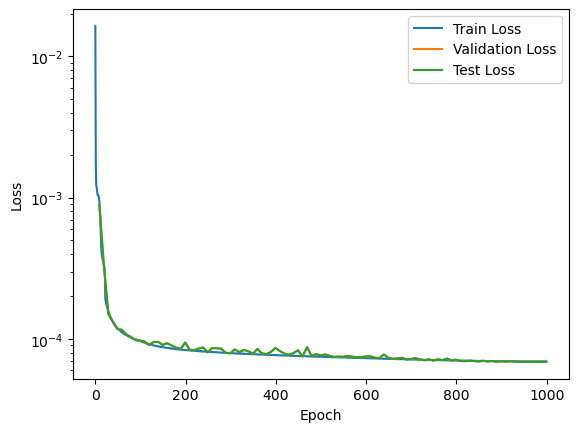

In [37]:
# Plotting
plt.plot(train_losses.numpy(), label='Train Loss')
plt.plot( np.arange(val_freq-1, num_epochs, val_freq),val_losses.numpy(), label='Validation Loss')
plt.plot(np.arange(test_freq-1, num_epochs, test_freq),test_losses.numpy(), label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

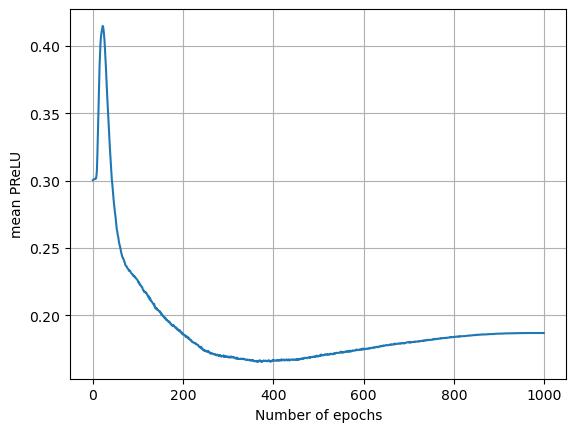

In [38]:
plt.plot(alphas.detach().numpy())
plt.xlabel('Number of epochs')
plt.ylabel('mean PReLU')    
plt.grid(True)
plt.show()

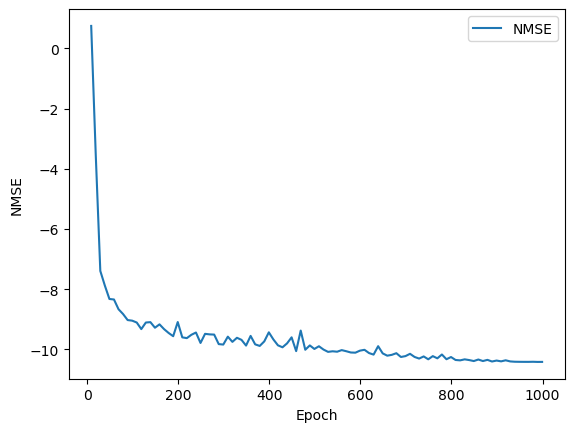

In [39]:
plt.plot(np.arange(test_freq-1, num_epochs, test_freq), test_nmses, label='NMSE')
plt.xlabel('Epoch')
plt.ylabel('NMSE')
plt.legend()
plt.show()

In [40]:
test_losses

tensor([8.8255e-04, 3.2776e-04, 1.4981e-04, 1.3170e-04, 1.1756e-04, 1.1606e-04,
        1.0736e-04, 1.0318e-04, 9.7993e-05, 9.7476e-05, 9.5897e-05, 9.0740e-05,
        9.5097e-05, 9.5427e-05, 9.0738e-05, 9.3222e-05, 8.9938e-05, 8.6884e-05,
        8.4933e-05, 9.4269e-05, 8.3856e-05, 8.3399e-05, 8.5604e-05, 8.7004e-05,
        8.0371e-05, 8.6297e-05, 8.5906e-05, 8.5331e-05, 7.9680e-05, 7.9235e-05,
        8.4294e-05, 8.0772e-05, 8.3627e-05, 8.1833e-05, 7.8525e-05, 8.4920e-05,
        7.9133e-05, 7.8178e-05, 8.0936e-05, 8.6462e-05, 8.2029e-05, 7.8740e-05,
        7.7284e-05, 7.9475e-05, 8.3083e-05, 7.5116e-05, 8.7429e-05, 7.5883e-05,
        7.8189e-05, 7.6384e-05, 7.7731e-05, 7.5953e-05, 7.4587e-05, 7.5041e-05,
        7.4735e-05, 7.5890e-05, 7.4916e-05, 7.4142e-05, 7.4231e-05, 7.5313e-05,
        7.5412e-05, 7.3800e-05, 7.3003e-05, 7.7694e-05, 7.3670e-05, 7.2315e-05,
        7.2787e-05, 7.3628e-05, 7.1590e-05, 7.2000e-05, 7.3263e-05, 7.1534e-05,
        7.0715e-05, 7.1710e-05, 7.0295e-

In [41]:
train_losses

tensor([1.6419e-02, 1.7617e-03, 1.2273e-03, 1.1799e-03, 1.1021e-03, 1.0436e-03,
        1.0417e-03, 1.0275e-03, 9.9021e-04, 9.2609e-04, 8.1871e-04, 7.1409e-04,
        5.7053e-04, 4.4507e-04, 4.0713e-04, 3.8420e-04, 3.6835e-04, 3.5333e-04,
        3.4315e-04, 3.3409e-04, 3.2555e-04, 3.0284e-04, 1.9435e-04, 1.8438e-04,
        1.7870e-04, 1.7282e-04, 1.6703e-04, 1.6475e-04, 1.5983e-04, 1.5540e-04,
        1.5313e-04, 1.4998e-04, 1.4720e-04, 1.4430e-04, 1.4172e-04, 1.3968e-04,
        1.3790e-04, 1.3545e-04, 1.3413e-04, 1.3203e-04, 1.3071e-04, 1.2863e-04,
        1.2801e-04, 1.2597e-04, 1.2464e-04, 1.2319e-04, 1.2263e-04, 1.2102e-04,
        1.2058e-04, 1.1916e-04, 1.1752e-04, 1.1714e-04, 1.1689e-04, 1.1616e-04,
        1.1509e-04, 1.1407e-04, 1.1297e-04, 1.1261e-04, 1.1191e-04, 1.1158e-04,
        1.1082e-04, 1.0983e-04, 1.0964e-04, 1.0910e-04, 1.0910e-04, 1.0794e-04,
        1.0738e-04, 1.0687e-04, 1.0648e-04, 1.0618e-04, 1.0563e-04, 1.0544e-04,
        1.0465e-04, 1.0463e-04, 1.0370e-

In [42]:
val_losses

tensor([8.8254e-04, 3.2775e-04, 1.4981e-04, 1.3170e-04, 1.1755e-04, 1.1606e-04,
        1.0736e-04, 1.0317e-04, 9.7990e-05, 9.7473e-05, 9.5894e-05, 9.0738e-05,
        9.5095e-05, 9.5425e-05, 9.0736e-05, 9.3219e-05, 8.9936e-05, 8.6882e-05,
        8.4930e-05, 9.4266e-05, 8.3854e-05, 8.3397e-05, 8.5602e-05, 8.7002e-05,
        8.0368e-05, 8.6295e-05, 8.5902e-05, 8.5329e-05, 7.9678e-05, 7.9233e-05,
        8.4292e-05, 8.0770e-05, 8.3625e-05, 8.1831e-05, 7.8523e-05, 8.4918e-05,
        7.9131e-05, 7.8176e-05, 8.0933e-05, 8.6460e-05, 8.2026e-05, 7.8737e-05,
        7.7282e-05, 7.9473e-05, 8.3080e-05, 7.5113e-05, 8.7426e-05, 7.5881e-05,
        7.8186e-05, 7.6381e-05, 7.7729e-05, 7.5951e-05, 7.4585e-05, 7.5039e-05,
        7.4733e-05, 7.5888e-05, 7.4913e-05, 7.4139e-05, 7.4229e-05, 7.5310e-05,
        7.5410e-05, 7.3798e-05, 7.3001e-05, 7.7691e-05, 7.3667e-05, 7.2313e-05,
        7.2785e-05, 7.3626e-05, 7.1588e-05, 7.1998e-05, 7.3260e-05, 7.1532e-05,
        7.0713e-05, 7.1708e-05, 7.0293e-